# The job of this notebook is to execute the chained fit in Jinchen's order
### (2-point, Sum-subtracted, 3-point)

In [7]:
import numpy as np
import pandas as pd
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

In [8]:
import gvar as gv
import h5py
import lsqfit
import h5data_methods as h5_dm

In [9]:
import pickle

In [10]:
# Constants

#Physical constants
hbarc = 197.3 # MeV fm
a = 0.12

# Pion mass
mpi = 0.1885
#mpi = 0.2

# Plot constants
t_min_plt = 1
t_max_plt = 25

# Array of tsep values
tsep_vals = np.arange(3,13,1)
tsep_vals

array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [11]:
def Ei(n_selec, p):
    Ea = p['E0']
    for l in range(1, n_selec+1):
        Ea += p['dE{}'.format(l)]
        
    #print(Ea)
    return Ea

In [12]:
data = {}
data['2pt'] = h5_dm.get_2pt("a12m310_a_avg.h5")
data['2pt_SS'] = data['2pt'][:,:,0]
data['2pt_PS'] = data['2pt'][:,:,1]
data['3pt_A3'] = h5_dm.get_3pt("a12m310_a_avg.h5", "A3", 3, 13)
data['3pt_V4'] = h5_dm.get_3pt("a12m310_a_avg.h5", "V4", 3, 13)
data['FH_N_A3'] = h5_dm.get_FH("a12m310_a_fh.h5", "gA")
data['FH_N_V4'] = h5_dm.get_FH("a12m310_a_fh.h5", "gV")
data['FH_N'] = h5_dm.get_FH("a12m310_a_fh.h5", "all")


In [13]:
gv_avg_data = gv.BufferDict()
gv_avg_data = gv.dataset.avg_data(data)

# Calculate the ratio between 3-point and 2-point data, for both A3 and V4
gv_avg_data['C_ratio_A3'] = np.array([ [gv_avg_data['3pt_A3'][i][j]/gv_avg_data['2pt_SS'][i+tsep_vals[0]] for j in range(1, i+3)] for i in range(len(tsep_vals))])
gv_avg_data['Csum_A3'] = np.array([np.sum(gv_avg_data['3pt_A3'][i][1:i+3]) for i in range(len(tsep_vals))])
gv_avg_data['C^FH_A3'] = np.array([ (gv_avg_data['Csum_A3'][i + 1]/gv_avg_data['2pt_SS'][i + tsep_vals[0] + 1]) - (gv_avg_data['Csum_A3'][i]/gv_avg_data['2pt_SS'][i + tsep_vals[0]]) for i in range(len(tsep_vals)-1)])

gv_avg_data['C_ratio_V4'] = np.array([ [gv_avg_data['3pt_V4'][i][j]/gv_avg_data['2pt_SS'][i+tsep_vals[0]] for j in range(1, i+3)] for i in range(len(tsep_vals))])
gv_avg_data['Csum_V4'] = np.array([np.sum(gv_avg_data['3pt_V4'][i][1:i+3]) for i in range(len(tsep_vals))])
gv_avg_data['C^FH_V4'] = np.array([ (gv_avg_data['Csum_V4'][i + 1]/gv_avg_data['2pt_SS'][i + tsep_vals[0] + 1]) - (gv_avg_data['Csum_V4'][i]/gv_avg_data['2pt_SS'][i + tsep_vals[0]]) for i in range(len(tsep_vals)-1)])

# The A3 and V4 3-point and Sum-subtracted samples are combined into arrays of (A3, V4) pairs 
gv_avg_data['3pt_combined'] = np.array([ [ [gv_avg_data['3pt_A3'][i][j], gv_avg_data['3pt_V4'][i][j]] for j in range(len(gv_avg_data['3pt_A3'][i]))] for i in range(len(gv_avg_data['3pt_A3']))])
gv_avg_data['C^FH_combined'] = np.transpose(np.append([gv_avg_data['C^FH_A3'],], [gv_avg_data['C^FH_V4'],], axis = 0))

gv_avg_data['2pt_meff'] = np.log(np.array([gv_avg_data['2pt'][j,:]/gv_avg_data['2pt'][j+1,:] for j in range(63)]))
gv_avg_data['2pt_SS_meff'] = np.log(np.array([gv_avg_data['2pt_SS'][j]/gv_avg_data['2pt_SS'][j+1] for j in range(63)]))
gv_avg_data['2pt_PS_meff'] = np.log(np.array([gv_avg_data['2pt_PS'][j]/gv_avg_data['2pt_PS'][j+1] for j in range(63)]))

gv_avg_data['2pt_zSeff'] = np.array([np.sqrt(np.exp(gv_avg_data['2pt_SS_meff'][t]*t)*gv_avg_data['2pt_SS'][t]) for t in range(63)])
gv_avg_data['2pt_zPeff'] = np.array([np.exp(gv_avg_data['2pt_PS_meff'][t]*t)*gv_avg_data['2pt_PS'][t]/gv_avg_data['2pt_zSeff'][t] for t in range(63)])


# Sum-subtract the Feynman-Hellman raw data to get a FH dataset
gv_avg_data['2pt_D'] = np.transpose(np.array([gv_avg_data['2pt_SS'], gv_avg_data['2pt_PS'], gv_avg_data['2pt_SS'], gv_avg_data['2pt_PS']]))
gv_avg_data['FH'] = np.roll(gv_avg_data['FH_N']/gv_avg_data['2pt_D'], -1, axis = 0) - gv_avg_data['FH_N']/gv_avg_data['2pt_D']

<ipython-input-13-5eece56e8865>:17: RuntimeWarning: invalid value encountered in log
  gv_avg_data['2pt_meff'] = np.log(np.array([gv_avg_data['2pt'][j,:]/gv_avg_data['2pt'][j+1,:] for j in range(63)]))
<ipython-input-13-5eece56e8865>:18: RuntimeWarning: invalid value encountered in log
  gv_avg_data['2pt_SS_meff'] = np.log(np.array([gv_avg_data['2pt_SS'][j]/gv_avg_data['2pt_SS'][j+1] for j in range(63)]))
<ipython-input-13-5eece56e8865>:19: RuntimeWarning: invalid value encountered in log
  gv_avg_data['2pt_PS_meff'] = np.log(np.array([gv_avg_data['2pt_PS'][j]/gv_avg_data['2pt_PS'][j+1] for j in range(63)]))
<ipython-input-13-5eece56e8865>:21: RuntimeWarning: invalid value encountered in sqrt
  gv_avg_data['2pt_zSeff'] = np.array([np.sqrt(np.exp(gv_avg_data['2pt_SS_meff'][t]*t)*gv_avg_data['2pt_SS'][t]) for t in range(63)])


In [14]:
# Create functions to extract the necessary fit-parameters for each function, and to insert priors specific to a function into a more complete parameter list
# Create methods for forming a parameter subset for each of the 3 functions: 2-point, 3-point, sum-subtracted
def param_2pt(p):
    sub_p = gv.BufferDict()
    sub_p['E0'] = p['E0']
    sub_p['Z0'] = p['Z0']
    sub_p['Ztilde0'] = p['Ztilde0']
    
    for k in range(1, num_zs):
        sub_p['Z{}'.format(k)] = p['Z{}'.format(k)]
        sub_p['Ztilde{}'.format(k)] = p['Ztilde{}'.format(k)]
        sub_p['log(dE{})'.format(k)] = p['log(dE{})'.format(k)]
        
    return sub_p
      
def param_3pt(p):
    sub_p = gv.BufferDict()
    sub_p['E0'] = p['E0']
    sub_p['Z0'] = p['Z0']
    
    for k in range(1, num_zs):
        sub_p['Z{}'.format(k)] = p['Z{}'.format(k)]
        sub_p['log(dE{})'.format(k)] = p['log(dE{})'.format(k)]
        
    for n in range(num_zs):
        for m in range(num_zs):
            sub_p['gA3_{0}{1}'.format(n, m)] = p['gA3_{0}{1}'.format(n, m)]
            sub_p['gV4_{0}{1}'.format(n, m)] = p['gV4_{0}{1}'.format(n, m)]
    
    return sub_p

def param_FH(p):
    sub_p = gv.BufferDict()
    sub_p['E0'] = p['E0']
    sub_p['Z0'] = p['Z0']
    
    for k in range(1, num_states_FH - 1):
        sub_p['Z{}'.format(k)] = p['Z{}'.format(k)]
        sub_p['log(dE{})'.format(k)] = p['log(dE{})'.format(k)]
        
    sub_p['Z{}'.format(num_states_FH - 1)] = p['Z_FHmax']
    sub_p['log(dE{})'.format(num_states_FH - 1)] = p['log(FH_dEmax)']
    
    for n in range(num_states_FH-1):
        for m in range(num_states_FH-1):
                
            sub_p['gA3_{0}{1}'.format(n, m)] = p['gA3_{0}{1}'.format(n, m)]
            sub_p['gV4_{0}{1}'.format(n, m)] = p['gV4_{0}{1}'.format(n, m)]
            
    for n in range(num_states_FH-1):
        sub_p['gA3_{0}{1}'.format(n, num_states_FH-1)] = p['gA3_{}FHmax'.format(n)]
        sub_p['gA3_{0}{1}'.format(num_states_FH-1, n)] = p['gA3_FHmax{}'.format(n)]
        sub_p['gV4_{0}{1}'.format(n, num_states_FH-1)] = p['gV4_{}FHmax'.format(n)]
        sub_p['gV4_{0}{1}'.format(num_states_FH-1, n)] = p['gV4_FHmax{}'.format(n)]
        
    sub_p['gA3_{0}{1}'.format(num_states_FH-1, num_states_FH-1)] = p['gA3_FHmaxFHmax']
    sub_p['gV4_{0}{1}'.format(num_states_FH-1, num_states_FH-1)] = p['gV4_FHmaxFHmax']
    
    return sub_p

def param_FHdata(p):
    sub_p = gv.BufferDict()
    sub_p['E0'] = p['E0']
    sub_p['Z0'] = p['Z0']
    sub_p['Ztilde0'] = p['Ztilde0']
    
    for k in range(1, num_states_FH - 1):
        sub_p['Z{}'.format(k)] = p['Z{}'.format(k)]
        sub_p['Ztilde{}'.format(k)] = p['Ztilde{}'.format(k)]
        sub_p['log(dE{})'.format(k)] = p['log(dE{})'.format(k)]
        
    sub_p['Z{}'.format(num_states_FH - 1)] = p['Z_FHmax']
    sub_p['Ztilde{}'.format(num_states_FH - 1)] = p['Ztilde_FHmax']
    sub_p['log(dE{})'.format(num_states_FH - 1)] = p['log(FH_dEmax)']
    
    for n in range(num_states_FH-1):
        for m in range(num_states_FH-1):
                
            sub_p['gA3_{0}{1}'.format(n, m)] = p['gA3_{0}{1}'.format(n, m)]
            sub_p['gV4_{0}{1}'.format(n, m)] = p['gV4_{0}{1}'.format(n, m)]
            
    for n in range(num_states_FH-1):
        sub_p['gA3_{0}{1}'.format(n, num_states_FH-1)] = p['gA3_{}FHmax'.format(n)]
        sub_p['gA3_{0}{1}'.format(num_states_FH-1, n)] = p['gA3_FHmax{}'.format(n)]
        sub_p['gV4_{0}{1}'.format(n, num_states_FH-1)] = p['gV4_{}FHmax'.format(n)]
        sub_p['gV4_{0}{1}'.format(num_states_FH-1, n)] = p['gV4_FHmax{}'.format(n)]
        
    sub_p['gA3_{0}{1}'.format(num_states_FH-1, num_states_FH-1)] = p['gA3_FHmaxFHmax']
    sub_p['gV4_{0}{1}'.format(num_states_FH-1, num_states_FH-1)] = p['gV4_FHmaxFHmax']
    
    for n in range(num_states_FH):
        sub_p['d_gA_ss_{}'.format(n)] = p['d_gA_ss_{}'.format(n)]
        sub_p['d_gA_ps_{}'.format(n)] = p['d_gA_ps_{}'.format(n)]
        sub_p['d_gV_ss_{}'.format(n)] = p['d_gV_ss_{}'.format(n)]
        sub_p['d_gV_ps_{}'.format(n)] = p['d_gV_ps_{}'.format(n)]
    
    return sub_p

#def param_FHdata(p):
    #sub_p = gv.BufferDict()
    #sub_p['E0'] = p['E0']
    #sub_p['Z0'] = p['Z0']
    #sub_p['Ztilde0'] = p['Ztilde0']
    
    #for k in range(1, num_states_FHdata - 1):
        #sub_p['Z{}'.format(k)] = p['Z{}'.format(k)]
        #sub_p['Ztilde{}'.format(k)] = p['Ztilde{}'.format(k)]
        #sub_p['log(dE{})'.format(k)] = p['log(dE{})'.format(k)]
        
    #sub_p['Z{}'.format(num_states_FHdata - 1)] = p['Z_FHdatamax']
    #sub_p['Ztilde{}'.format(num_states_FHdata - 1)] = p['Ztilde_FHdatamax']
    #sub_p['log(dE{})'.format(num_states_FHdata - 1)] = p['log(FHdata_dEmax)']
    
    #for n in range(num_states_FHdata-1):
        #for m in range(num_states_FHdata-1):
                
            #sub_p['gA3_{0}{1}'.format(n, m)] = p['gA3_{0}{1}'.format(n, m)]
            #sub_p['gV4_{0}{1}'.format(n, m)] = p['gV4_{0}{1}'.format(n, m)]
            
    #for n in range(num_states_FHdata-1):
        #sub_p['gA3_{0}{1}'.format(n, num_states_FHdata-1)] = p['gA3_{}FHdatamax'.format(n)]
        #sub_p['gA3_{0}{1}'.format(num_states_FHdata-1, n)] = p['gA3_FHdatamax{}'.format(n)]
        #sub_p['gV4_{0}{1}'.format(n, num_states_FHdata-1)] = p['gV4_{}FHdatamax'.format(n)]
        #sub_p['gV4_{0}{1}'.format(num_states_FHdata-1, n)] = p['gV4_FHdatamax{}'.format(n)]
        
    #sub_p['gA3_{0}{1}'.format(num_states_FHdata-1, num_states_FHdata-1)] = p['gA3_FHdatamaxFHdatamax']
    #sub_p['gV4_{0}{1}'.format(num_states_FHdata-1, num_states_FHdata-1)] = p['gV4_FHdatamaxFHdatamax']
    
    #for n in range(num_states_FHdata):
        #sub_p['d_gA_ss_{}'.format(n)] = p['d_gA_ss_{}'.format(n)]
        #sub_p['d_gA_ps_{}'.format(n)] = p['d_gA_ps_{}'.format(n)]
        #sub_p['d_gV_ss_{}'.format(n)] = p['d_gV_ss_{}'.format(n)]
        #sub_p['d_gV_ps_{}'.format(n)] = p['d_gV_ps_{}'.format(n)]
    
    #return sub_p

In [15]:
# Now, create some methods for setting the full posterior, both used and unused variables 
def posterior_2pt(partial_post, full_prior):
    full_post = gv.BufferDict()
    
    full_post['E0'] = partial_post['E0']
    full_post['Z0'] = partial_post['Z0']
    full_post['Ztilde0'] = partial_post['Ztilde0']
    
    for k in range(1, num_zs):
        full_post['Z{}'.format(k)] = partial_post['Z{}'.format(k)]
        full_post['Ztilde{}'.format(k)] = partial_post['Ztilde{}'.format(k)]
        full_post['log(dE{})'.format(k)] = partial_post['log(dE{})'.format(k)]
        
    for n in range(num_zs):
        for m in range(num_zs):
            full_post['gA3_{0}{1}'.format(n, m)] = full_prior['gA3_{0}{1}'.format(n, m)]
            full_post['gV4_{0}{1}'.format(n, m)] = full_prior['gV4_{0}{1}'.format(n, m)]
            
    full_post['Z_FHmax'] = full_prior['Z_FHmax']
    full_post['log(FH_dEmax)'] = full_prior['log(FH_dEmax)']
        
    for n in range(num_states_FH-1):
        full_post['gA3_FHmax{}'.format(n)] = full_prior['gA3_FHmax{}'.format(n)]
        full_post['gA3_{}FHmax'.format(n)] = full_prior['gA3_{}FHmax'.format(n)]
        full_post['gV4_FHmax{}'.format(n)] = full_prior['gV4_FHmax{}'.format(n)]
        full_post['gV4_{}FHmax'.format(n)] = full_prior['gV4_{}FHmax'.format(n)]
        
    full_post['gA3_FHmaxFHmax'] = full_prior['gA3_FHmaxFHmax']
    full_post['gV4_FHmaxFHmax'] = full_prior['gV4_FHmaxFHmax']
              
    return full_post          
              
def posterior_3pt(partial_post, full_prior):
    full_post = gv.BufferDict()
    
    full_post['E0'] = partial_post['E0']
    full_post['Z0'] = partial_post['Z0']
    full_post['Ztilde0'] = full_prior['Ztilde0']
    
    for k in range(1, num_zs):
        full_post['log(dE{})'.format(k)] = partial_post['log(dE{})'.format(k)]
        full_post['Z{}'.format(k)] = partial_post['Z{}'.format(k)]
        full_post['Ztilde{}'.format(k)] = full_prior['Ztilde{}'.format(k)]
        
    for n in range(num_zs):
        for m in range(num_zs):
            full_post['gA3_{0}{1}'.format(n, m)] = partial_post['gA3_{0}{1}'.format(n, m)]
            full_post['gV4_{0}{1}'.format(n, m)] = partial_post['gV4_{0}{1}'.format(n, m)]
            
    full_post['Z_FHmax'] = full_prior['Z_FHmax']
    full_post['log(FH_dEmax)'] = full_prior['log(FH_dEmax)']
    
    for n in range(num_states_FH-1):
        full_post['gA3_FHmax{}'.format(n)] = full_prior['gA3_FHmax{}'.format(n)]
        full_post['gA3_{}FHmax'.format(n)] = full_prior['gA3_{}FHmax'.format(n)]
        full_post['gV4_FHmax{}'.format(n)] = full_prior['gV4_FHmax{}'.format(n)]
        full_post['gV4_{}FHmax'.format(n)] = full_prior['gV4_{}FHmax'.format(n)]
        
    full_post['gA3_FHmaxFHmax'] = full_prior['gA3_FHmaxFHmax']
    full_post['gV4_FHmaxFHmax'] = full_prior['gV4_FHmaxFHmax']
              
    return full_post
              
def posterior_FH(partial_post, full_prior):
    full_post['E0'] = partial_post['E0']
    full_post['Z0'] = partial_post['Z0']
    full_post['Ztilde0'] = full_prior['Ztilde0']
    
    for k in range(1, num_zs):
        full_post['log(dE{})'.format(k)] = full_prior['log(dE{})'.format(k)]
        full_post['Z{}'.format(k)] = full_prior['Z{}'.format(k)]
        full_post['Ztilde{}'.format(k)] = full_prior['Ztilde{}'.format(k)] 
        
    for k in range(1, num_states_FH - 1):
        full_post['log(dE{})'.format(k)] = partial_post['log(dE{})'.format(k)]
        full_post['Z{}'.format(k)] = partial_post['Z{}'.format(k)]
        
    for n in range(num_zs):
        for m in range(num_zs):
            full_post['gA3_{0}{1}'.format(n, m)] = full_prior['gA3_{0}{1}'.format(n, m)]
            full_post['gV4_{0}{1}'.format(n, m)] = full_prior['gV4_{0}{1}'.format(n, m)]
    
    for n in range(num_states_FH-1):
        for m in range(num_states_FH-1):    
            full_post['gA3_{0}{1}'.format(n, m)] = partial_post['gA3_{0}{1}'.format(n, m)]
            full_post['gV4_{0}{1}'.format(n, m)] = partial_post['gV4_{0}{1}'.format(n, m)]
                        
    full_post['Z_FHmax'] = partial_post['Z{}'.format(num_states_FH - 1)]
    full_post['log(FH_dEmax)'] = partial_post['log(dE{})'.format(num_states_FH - 1)]
              
    for n in range(num_states_FH-1):
        full_post['gA3_FHmax{}'.format(n)] = partial_post['gA3_{0}{1}'.format(num_states_FH-1, n)]
        full_post['gA3_{}FHmax'.format(n)] = partial_post['gA3_{0}{1}'.format(n, num_states_FH-1)]
        full_post['gV4_FHmax{}'.format(n)] = partial_post['gV4_{0}{1}'.format(num_states_FH-1, n)]
        full_post['gV4_{}FHmax'.format(n)] = partial_post['gV4_{0}{1}'.format(n, num_states_FH-1)]
        
    full_post['gA3_FHmaxFHmax'] = partial_post['gA3_{0}{1}'.format(num_states_FH-1, num_states_FH-1)]
    full_post['gV4_FHmaxFHmax'] = partial_post['gV4_{0}{1}'.format(num_states_FH-1, num_states_FH-1)]
      
    return full_post
    

In [16]:
num_zs = 1 #Order number of the n's
# Log E: log of the energy.  
# P is point (in the context of )

def C_2pt(t, p):
    
    z = np.array([])
    ztilde = np.array([])
    E = np.array([])
    for i in range(num_zs):
        z = np.append(z, p['Z{}'.format(i)])
        ztilde = np.append(ztilde, p['Ztilde{}'.format(i)])
        E = np.append(E, Ei(i, p))
        
    
    sum_pp = sum([z[i]*z[i]*np.exp(-E[i]*t) for i in range(num_zs)])
    sum_ps = sum([z[i]*ztilde[i]*np.exp(-E[i]*t) for i in range(num_zs)])
    
    return np.transpose(np.array([[sum_pp], [sum_ps]]), axes=[2,0,1])

def C_2pt_SS(t, p):
    
    z = np.array([])
    E = np.array([])
    for i in range(num_zs):
        z = np.append(z, p['Z{}'.format(i)])
        E = np.append(E, Ei(i, p))
        
    
    sum_ss = sum([z[i]*z[i]*np.exp(-E[i]*t) for i in range(num_zs)])
    
    return np.array(sum_ss)

def C_2pt_PS(t, p):
    
    z = np.array([])
    ztilde = np.array([])
    E = np.array([])
    for i in range(num_zs):
        z = np.append(z, p['Z{}'.format(i)])
        ztilde = np.append(ztilde, p['Ztilde{}'.format(i)])
        E = np.append(E, Ei(i, p))
        
    #print("z: ", z)
    #print("ztilde: ", ztilde)
    
    sum_ps = sum([z[i]*ztilde[i]*np.exp(-E[i]*t) for i in range(num_zs)])
    
    return np.array(sum_ps)

In [17]:
# Precondition: t is a 1-D numpy array of 2-element array like objects t[i] = (t_sep, tau)
  
    
def C_3pt_A3(t, p):
    #tsep = np.array([np.array([t[i][j][0] for j in range(len(t[i]))]) for i in range(len(t))])
    #tau = np.array([np.array([t[i][j][1] for j in range(len(t[i]))]) for i in range(len(t))])
    tsep, tau = np.transpose(t)
    #print("tsep: ", tsep)
    #print("tau: ", tau)
    
    result = p['Z0']*p['gA3_00']*p['Z0']*np.exp(-p["E0"]*tsep)*np.exp(-(p["E0"] - p["E0"])*tau)
    n = 0
    m = 0
    
    if num_zs == 1:
        return result
    
    m += 1
    while n < num_zs:    
        En = Ei(n, p)
        Em = Ei(m, p) 
        result += p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*np.exp(-En*tsep)*np.exp(-(Em - En)*tau)
        m += 1
        if m >= num_zs:
            m = 0
            n += 1
            
    #for n in range(num_zs):
        #for m in range(num_zs):
            #result += p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*np.exp(-p["E{}".format(n)]*tsep)*np.exp(-(p["E{}".format(m)] - p["E{}".format(n)])*tau)
            # print out the dictionary indices which are called in this summation
            #print("n = ", n, "; m = ", m)
            #print('Z{}'.format(n), "*", 'gA3_{0}{1}'.format(n, m), "*", 'Z{}'.format(m), "*e^(-tsep*", "E{}".format(n), ")*e^(-tau*(", "E{}".format(m), "-", "E{}".format(n), ")")
            
    return result



def C_3pt_V4(t, p):
    #tsep = np.array([np.array([t[i][j][0] for j in range(len(t[i]))]) for i in range(len(t))])
    #tau = np.array([np.array([t[i][j][1] for j in range(len(t[i]))]) for i in range(len(t))])
    tsep, tau = np.transpose(t)
    #print("tsep: ", tsep)
    #print("tau: ", tau)
    
    result = p['Z0']*p['gV4_00']*p['Z0']*np.exp(-p["E0"]*tsep)*np.exp(-(p["E0"] - p["E0"])*tau)
    
    n = 0
    m = 0
    if num_zs == 1:
        return result
    
    m += 1
    while n < num_zs:
        En = Ei(n, p)
        Em = Ei(m, p)
        result += p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*np.exp(-En*tsep)*np.exp(-(Em - En)*tau)
        m += 1
        if m >= num_zs:
            m = 0
            n += 1
    
    
    #for n in range(num_zs):
        #for m in range(num_zs):
            #result += p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*np.exp(-p["E{}".format(n)]*tsep)*np.exp(-(p["E{}".format(m)] - p["E{}".format(n)])*tau)
            # print out the dictionary indices which are called in this summation
            #print("n = ", n, "; m = ", m)
            #print('Z{}'.format(n), "*", 'gV4_{0}{1}'.format(n, m), "*", 'Z{}'.format(m), "*e^(-tsep*", "E{}".format(n), ")*e^(-tau*(", "E{}".format(m), "-", "E{}".format(n), ")")
            
    return result

def C_3pt(t, p):
    A3 = C_3pt_A3(t, p)
    V4 = C_3pt_V4(t, p)
    
    return np.transpose(np.array([[A3], [V4]]), axes=[2,0,1])

In [18]:
num_states_FH = 1 # The number of states that the Feynman-Hellman and sum-subtraction needs

def C_2pt_SS_aux(t, p, n_local):
    
    z = np.array([])
    E = np.array([])
    for i in range(n_local):
        z = np.append(z, p['Z{}'.format(i)])
        E = np.append(E, Ei(i, p))
        
    
    sum_ss = sum([z[i]*z[i]*np.exp(-E[i]*t) for i in range(n_local)])
    
    return np.array(sum_ss)

def C_2pt_PS_aux(t, p, n_local):
    
    z = np.array([])
    ztilde = np.array([])
    E = np.array([])
    for i in range(n_local):
        z = np.append(z, p['Z{}'.format(i)])
        ztilde = np.append(ztilde, p['Ztilde{}'.format(i)])
        E = np.append(E, Ei(i, p))
        
    #print("z: ", z)
    #print("ztilde: ", ztilde)
    
    sum_ps = sum([z[i]*ztilde[i]*np.exp(-E[i]*t) for i in range(n_local)])
    
    return np.array(sum_ps)

def Csum_A3(t, p, n_local):
    result = 0
    for n in range(n_local):
        En = Ei(n, p)
        result += (t - 1) * p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, n)]*p['Z{}'.format(n)]*np.exp(-En*t)
        for m in range(n_local):
            if n == m:
                continue
            else:
                Em = Ei(m, p)
                e_Delta_nm = np.exp((En - Em)/2.)
                e_Delta_mn = np.exp((Em - En)/2.)
                #print("n = ", n)
                #print("m = ", m)
                #print("En = ", En)
                #print("Em = ", Em)
                #print("e_Delta_nm = ", e_Delta_nm)
                #print("e_Delta_nm = ", e_Delta_mn)
                
                mn_ratio = (e_Delta_nm*np.exp(-En*t) - e_Delta_mn*np.exp(-Em*t))/(e_Delta_mn - e_Delta_nm)
                
                result += p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*mn_ratio
                
    return result

def Csum_V4(t, p, n_local):
    result = 0
    for n in range(n_local):
        En = Ei(n, p)
        result += (t - 1) * p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, n)]*p['Z{}'.format(n)]*np.exp(-En*t)
        for m in range(n_local):
            if n == m:
                continue
            else:
                Em = Ei(m, p)
                e_Delta_nm = np.exp((En - Em)/2.)
                e_Delta_mn = np.exp((Em - En)/2.)
                
                mn_ratio = (e_Delta_nm*np.exp(-En*t) - e_Delta_mn*np.exp(-Em*t))/(e_Delta_mn - e_Delta_nm)
                
                result += p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*mn_ratio
                
    return result

def C_FH_A3(t, p):
    #p_FH = gv.BufferDict()
    #p_FH['E0'] = p['E0']
    
    #n = 0
    #while (n < num_states_FH):
        #p_FH['Z{}'.format(n)] = p['Z{}'.format(n)]
        #for m in range(num_states_FH):
            #p_FH['gA3_{0}{1}'.format(n, m)] = p['gA3_{0}{1}'.format(n, m)]
            
        #n += 1
        
    
    #nE = 0
    #while nE < num_states_FH - 2:
        #p_FH['log(dE{})'.format(nE)] = p['log(dE{})'.format(nE)]
        #nE += 1
        
    #p_FH['log(dE{})'.format(nE)] = p['log(FH_dEmax)']
    if(num_zs == num_states_FH):
        return (Csum_A3(t + 1, p, num_states_FH)/C_2pt_SS_aux(t + 1, p, num_states_FH)) - (Csum_A3(t, p, num_states_FH)/C_2pt_SS_aux(t, p, num_states_FH))

    else:
        return (Csum_A3(t + 1, param_FH(p), num_states_FH)/C_2pt_SS_aux(t + 1, param_FH(p), num_states_FH)) - (Csum_A3(t, param_FH(p), num_states_FH)/C_2pt_SS_aux(t, param_FH(p), num_states_FH))


def C_FH_V4(t, p):
    #p_FH = gv.BufferDict()
    #p_FH['E0'] = p['E0']
    
    #for n in range(num_states_FH):
        #p_FH['Z{}'.format(n)] = p['Z{}'.format(n)]
        #for m in range(num_states_FH):
            #p_FH['gV4_{0}{1}'.format(n, m)] = p['gV4_{0}{1}'.format(n, m)]
    
    #nE = 0
    #while nE < num_states_FH - 2:
        #p_FH['log(dE{})'.format(nE)] = p['log(dE{})'.format(nE)]
        #nE += 1
        
    #p_FH['log(dE{})'.format(nE)] = p['log(FH_dEmax)']
    
    if(num_zs == num_states_FH):
        return (Csum_V4(t + 1, p, num_states_FH)/C_2pt_SS_aux(t + 1, p, num_states_FH)) - (Csum_V4(t, p, num_states_FH)/C_2pt_SS_aux(t, p, num_states_FH))

    else:
        return (Csum_V4(t + 1, param_FH(p), num_states_FH)/C_2pt_SS_aux(t + 1, param_FH(p), num_states_FH)) - (Csum_V4(t, param_FH(p), num_states_FH)/C_2pt_SS_aux(t, param_FH(p), num_states_FH))




def C_FH(t, p):
    return np.transpose(np.array([C_FH_A3(t, p), C_FH_V4(t, p)])) #, axes=[2,0,1]

In [19]:
#num_states_FHdata = 1
# Create new functions to fit the new Feynman-Hellman dataset to 
def Csum_A3_FHdata_ss(t, p, n_local):
    result = 0
    for n in range(n_local):
        En = Ei(n, p)
        result += ((t - 1) * p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, n)]*p['Z{}'.format(n)] + p['d_gA_ss_{}'.format(n)])*np.exp(-En*t)
        for m in range(n_local):
            if n == m:
                continue
            else:
                Em = Ei(m, p)
                e_Delta_nm = np.exp((En - Em)/2.)
                e_Delta_mn = np.exp((Em - En)/2.)
                
                mn_ratio = (e_Delta_nm*np.exp(-En*t) - e_Delta_mn*np.exp(-Em*t))/(e_Delta_mn - e_Delta_nm)
                
                result += p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*mn_ratio
                
    return result

def Csum_A3_FHdata_ps(t, p, n_local):
    result = 0
    for n in range(n_local):
        En = Ei(n, p)
        result += ((t - 1) * p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, n)]*p['Ztilde{}'.format(n)] + p['d_gA_ps_{}'.format(n)])*np.exp(-En*t)
        for m in range(n_local):
            if n == m:
                continue
            else:
                Em = Ei(m, p)
                e_Delta_nm = np.exp((En - Em)/2.)
                e_Delta_mn = np.exp((Em - En)/2.)
                
                mn_ratio = (e_Delta_nm*np.exp(-En*t) - e_Delta_mn*np.exp(-Em*t))/(e_Delta_mn - e_Delta_nm)
                
                result += p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, m)]*p['Ztilde{}'.format(m)]*mn_ratio
                
    return result

def Csum_V4_FHdata_ss(t, p, n_local):
    result = 0
    for n in range(n_local):
        En = Ei(n, p)
        result += ((t - 1) * p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, n)]*p['Z{}'.format(n)] + p['d_gV_ss_{}'.format(n)])*np.exp(-En*t)
        for m in range(n_local):
            if n == m:
                continue
            else:
                Em = Ei(m, p)
                e_Delta_nm = np.exp((En - Em)/2.)
                e_Delta_mn = np.exp((Em - En)/2.)
                
                mn_ratio = (e_Delta_nm*np.exp(-En*t) - e_Delta_mn*np.exp(-Em*t))/(e_Delta_mn - e_Delta_nm)
                
                result += p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*mn_ratio
                
    return result

def Csum_V4_FHdata_ps(t, p, n_local):
    result = 0
    for n in range(n_local):
        En = Ei(n, p)
        result += ((t - 1) * p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, n)]*p['Ztilde{}'.format(n)] + p['d_gV_ps_{}'.format(n)])*np.exp(-En*t)
        for m in range(n_local):
            if n == m:
                continue
            else:
                Em = Ei(m, p)
                e_Delta_nm = np.exp((En - Em)/2.)
                e_Delta_mn = np.exp((Em - En)/2.)
                
                mn_ratio = (e_Delta_nm*np.exp(-En*t) - e_Delta_mn*np.exp(-Em*t))/(e_Delta_mn - e_Delta_nm)
                
                result += p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, m)]*p['Ztilde{}'.format(m)]*mn_ratio
                
    return result

#def C_FHdata_A3_ss(t, p):
    #return (Csum_A3_FHdata_ss(t + 1, param_FHdata(p), num_states_FHdata)/C_2pt_SS_aux(t + 1, param_FHdata(p), num_states_FHdata)) - (Csum_A3_FHdata_ss(t, param_FHdata(p), num_states_FHdata)/C_2pt_SS_aux(t, param_FHdata(p), num_states_FHdata))

#def C_FHdata_A3_ps(t, p):
    #return (Csum_A3_FHdata_ps(t + 1, param_FHdata(p), num_states_FHdata)/C_2pt_PS_aux(t + 1, param_FHdata(p), num_states_FHdata)) - (Csum_A3_FHdata_ps(t, param_FHdata(p), num_states_FHdata)/C_2pt_PS_aux(t, param_FHdata(p), num_states_FHdata))


#def C_FHdata_V4_ss(t, p):  
    #return (Csum_V4_FHdata_ss(t + 1, param_FHdata(p), num_states_FHdata)/C_2pt_SS_aux(t + 1, param_FHdata(p), num_states_FHdata)) - (Csum_V4_FHdata_ss(t, param_FHdata(p), num_states_FHdata)/C_2pt_SS_aux(t, param_FHdata(p), num_states_FHdata))

#def C_FHdata_V4_ps(t, p):
    #return (Csum_V4_FHdata_ps(t + 1, param_FHdata(p), num_states_FHdata)/C_2pt_PS_aux(t + 1, param_FHdata(p), num_states_FHdata)) - (Csum_V4_FHdata_ps(t, param_FHdata(p), num_states_FHdata)/C_2pt_PS_aux(t, param_FHdata(p), num_states_FHdata))

def C_FHdata_A3_ss(t, p):
    if(num_zs == num_states_FH):
        return (Csum_A3_FHdata_ss(t + 1, p, num_states_FH)/C_2pt_SS_aux(t + 1, p, num_states_FH)) - (Csum_A3_FHdata_ss(t, p, num_states_FH)/C_2pt_SS_aux(t, p, num_states_FH))

    else:
        return (Csum_A3_FHdata_ss(t + 1, param_FHdata(p), num_states_FH)/C_2pt_SS_aux(t + 1, param_FHdata(p), num_states_FH)) - (Csum_A3_FHdata_ss(t, param_FHdata(p), num_states_FH)/C_2pt_SS_aux(t, param_FHdata(p), num_states_FH))

def C_FHdata_A3_ps(t, p):
    if(num_zs == num_states_FH):
        return (Csum_A3_FHdata_ps(t + 1, p, num_states_FH)/C_2pt_PS_aux(t + 1, p, num_states_FH)) - (Csum_A3_FHdata_ps(t, p, num_states_FH)/C_2pt_PS_aux(t, p, num_states_FH))

    else:
        return (Csum_A3_FHdata_ps(t + 1, param_FHdata(p), num_states_FH)/C_2pt_PS_aux(t + 1, param_FHdata(p), num_states_FH)) - (Csum_A3_FHdata_ps(t, param_FHdata(p), num_states_FH)/C_2pt_PS_aux(t, param_FHdata(p), num_states_FH))


def C_FHdata_V4_ss(t, p):  
    if(num_zs == num_states_FH):
        return (Csum_V4_FHdata_ss(t + 1, p, num_states_FH)/C_2pt_SS_aux(t + 1, p, num_states_FH)) - (Csum_V4_FHdata_ss(t, p, num_states_FH)/C_2pt_SS_aux(t, p, num_states_FH))

    else:
        return (Csum_V4_FHdata_ss(t + 1, param_FHdata(p), num_states_FH)/C_2pt_SS_aux(t + 1, param_FHdata(p), num_states_FH)) - (Csum_V4_FHdata_ss(t, param_FHdata(p), num_states_FH)/C_2pt_SS_aux(t, param_FHdata(p), num_states_FH))

def C_FHdata_V4_ps(t, p):
    if(num_zs == num_states_FH):
        return (Csum_V4_FHdata_ps(t + 1, p, num_states_FH)/C_2pt_PS_aux(t + 1, p, num_states_FH)) - (Csum_V4_FHdata_ps(t, p, num_states_FH)/C_2pt_PS_aux(t, p, num_states_FH))

    else:
        return (Csum_V4_FHdata_ps(t + 1, param_FHdata(p), num_states_FH)/C_2pt_PS_aux(t + 1, param_FHdata(p), num_states_FH)) - (Csum_V4_FHdata_ps(t, param_FHdata(p), num_states_FH)/C_2pt_PS_aux(t, param_FHdata(p), num_states_FH))



def C_FHdata(t, p):
    return np.transpose(np.array([C_FHdata_A3_ss(t, p), C_FHdata_A3_ps(t, p), C_FHdata_V4_ss(t, p), C_FHdata_V4_ps(t, p)])) #, axes=[2,0,1]

In [20]:
# In order to be able to work with our 2-d array based functions, we need a way to convert from 2-d array to 1-d arrays and from 1-d arrays to 2-d arrays
# For the independent (time) variable, I'd just set up a 2-d array and a 1-d array with all the data I need
# For the dependent (correlation function) variable, I'd use the time variable arrays to call the correct indices to assign the variables in the conversion
t_2d_array = np.array([np.array([(i+3, j) for j in range(1, i+tsep_vals[0])]) for i in range(len(tsep_vals))])

num_elements = np.sum(np.array([i+tsep_vals[0]-1 for i in range(len(tsep_vals))]))
tsep_t = np.zeros(num_elements)
tau_t = np.zeros(num_elements)

k = 0
for i in range(len(tsep_vals)):
    for j in range(1, i+tsep_vals[0]):
        tsep_t[k] = i + tsep_vals[0]
        tau_t[k] = j
        #print("k = ", k, " tsep = ", tsep_t[k], " tau = ", tau_t[k])
        k += 1

        
t_1d_array = np.transpose(np.array([tsep_t, tau_t])) 

#print(t_2d_array)
#print(t_1d_array)

# Universal precondition for the below functions: x_1d, x_2d, y_1d, and y_2d, in the end, must have the 
# same number of elements. Also, x_1d and y_1d have to have the same dimensions, as must x_2d and y_2d
def convert_1dto2d(x_1d, x_2d, y_1d):
    y_2d = np.array([np.array([None for j in range(len(x_2d[i]))]) for i in range(len(x_2d))])
    i = 0
    j = 0
    for k in range(len(x_1d)):
        y_2d[i][j] = y_1d[k]
        j += 1
        if j >= len(x_2d[i]):
            i +=1
            j = 0
            
    return y_2d

def convert_2dto1d(x_1d, x_2d, y_2d):
    y_1d = np.array([None for k in range(len(x_1d))])
    k = 0
    for i in range(len(x_2d)):
        for j in range(len(x_2d[i])):
            y_1d[k] = y_2d[i][j]
            k += 1
    
    return y_1d
    

In [21]:
num_zs = 6
num_states_FH = 3 

# prior the fits
prior_2ptstep = gv.BufferDict()

# This is the exponent e_decay_exp such that the increment between two consecutive excited state energies decays as 1/n^e_decay_exp, where n is the order of the excited state energy 
e_decay_exp = 0

prior_2ptstep['E0'] = gv.gvar(0.67, 0.02)
prior_2ptstep['Z0'] = gv.gvar(0.0008, 0.0003)
prior_2ptstep['Ztilde0'] = gv.gvar(0.003, 0.003)

#prior_2ptstep['E1'] = gv.gvar(1.3, 0.23)
#prior_2ptstep['log(E1)'] = gv.gvar(np.log(1.3), np.log(1.3/(1.3 - 0.3)))
#prior_2ptstep['Z1'] = gv.gvar(0.0012, 0.0006)
#prior_2ptstep['Ztilde1'] = gv.gvar(0.006, 0.005)

# Define some constants for prioring the higher-order energies
dE0 = 2*mpi
b = 0.7

# Use constant dE to prior the energies
dE0 = 2*mpi
energyvals = np.array([None]*num_zs)
dEvals = np.array([None]*(num_zs - 1))

#E0_errbar = 0.8
energyvals[0] = gv.gvar(0.67, 0.02)
for k in range(1, num_zs):
    dEvals[k-1] = dE0/np.power(k, e_decay_exp)
    energyvals[k] = energyvals[k-1] + dEvals[k-1]

for n in range(1, num_zs):
    prior_2ptstep['log(dE{})'.format(n)] = gv.gvar(np.log(dEvals[n-1]), b)
    prior_2ptstep['Z{}'.format(n)] = gv.gvar(0.0012, 0.0006)
    prior_2ptstep['Ztilde{}'.format(n)] = gv.gvar(0, 0.01)
    
    # Insert priors for energy here
    #dE_next = dE0/np.power(n, e_decay_exp)
    #E_next = prior_2ptstep['E{}'.format(n-1)].mean + dE_next
    #sigma_next = np.log(E_next/(E_next - (dE_next*b)))

print(num_states_FH - 2)

for n in range(num_zs):
    for m in range(num_zs):
        
        prior_2ptstep['gA3_{0}{1}'.format(n, m)] = gv.gvar(0, 2)
        if n == m and n < num_zs-1:
            prior_2ptstep['gV4_{0}{1}'.format(n, m)] = gv.gvar(1, 0.1)
        else:
            prior_2ptstep['gV4_{0}{1}'.format(n, m)] = gv.gvar(0, 2)

prior_2ptstep['gA3_00'] = gv.gvar(1.25, 0.15)
prior_2ptstep['gV4_00'] = gv.gvar(1.07, 0.07)

# Set the "garbage can" for the Feynman Hellman fit
prior_2ptstep['Z_FHmax'] = gv.gvar(0.0008, 0.0004)
prior_2ptstep['log(FH_dEmax)'] = gv.gvar(np.log(dEvals[num_states_FH - 2]), b) 

for n in range(num_states_FH-1):
    prior_2ptstep['gA3_FHmax{}'.format(n)] = gv.gvar(0, 2)
    prior_2ptstep['gA3_{}FHmax'.format(n)] = gv.gvar(0, 2)
    prior_2ptstep['gV4_FHmax{}'.format(n)] = gv.gvar(0, 2)
    prior_2ptstep['gV4_{}FHmax'.format(n)] = gv.gvar(0, 2)
    
prior_2ptstep['gA3_FHmaxFHmax'] = gv.gvar(0, 2)
prior_2ptstep['gV4_FHmaxFHmax'] = gv.gvar(0, 2)

#prior_2ptstep

1


In [22]:
# 2-point fit
fit_2pt = lsqfit.nonlinear_fit(data=(np.array([l for l in range(2, 13)]), np.array([[ [c] for c in gv_avg_data['2pt'][l]] for l in range(2,13)]) ), prior=prior_2ptstep,fcn=C_2pt,debug=True)
print(fit_2pt.format(pstyle='vv'))
post_2pt = fit_2pt.p

Least Square Fit:
  chi2/dof [dof] = 0.86 [22]    Q = 0.66    logGBF = 483.59

Parameters:
             E0       0.659109 +- 0.00497708             [     0.67 +- 0.02 ]  
             Z0   0.000747066 +- 2.34176e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00281508 +- 0.000103288             [   0.003 +- 0.003 ]  
       log(dE1)         -1.06542 +- 0.444697             [  -0.97551 +- 0.7 ]  
             Z1   0.000529446 +- 0.000189051             [ 0.0012 +- 0.0006 ]  *
        Ztilde1     0.00321742 +- 0.00167507             [        0 +- 0.01 ]  
       log(dE2)        -0.734767 +- 0.452652             [  -0.97551 +- 0.7 ]  
             Z2   0.000757611 +- 0.000292612             [ 0.0012 +- 0.0006 ]  
        Ztilde2     0.00654625 +- 0.00263519             [        0 +- 0.01 ]  
       log(dE3)         -0.81456 +- 0.614238             [  -0.97551 +- 0.7 ]  
             Z3     0.000731681 +- 0.0004258             [ 0.0012 +- 0.0006 ]  
        Ztilde3     0.002735

In [23]:
# pickle output params of the 2-point fit, then set the next prior, prior_3pt_A3step
#current_posterior = open('2pt_FH_3pt_stage2pt.obj', 'wb')
#pickle.dump(post_2pt, current_posterior)
#current_posterior.close()

In [24]:
#next_priors = open('2pt_FH_3pt_stage2pt.obj', 'rb')
#prior_CFH = pickle.load(next_priors)
#next_priors.close()

In [25]:
fit_CFH = lsqfit.nonlinear_fit(data=(np.array([l for l in tsep_vals[:-1]]), np.array([gv_avg_data['C^FH_combined'][l] for l in range(len(tsep_vals[:-1]))])), prior=post_2pt,fcn=C_FH,debug=True)
print(fit_CFH.format(pstyle='vv'))
post_CFH = fit_CFH.p

Least Square Fit:
  chi2/dof [dof] = 0.32 [18]    Q = 1    logGBF = 46.104

Parameters:
             E0       0.659361 +- 0.00459209             [     0.659109 +- 0.00497708 ]  
             Z0   0.000748322 +- 2.13082e-05             [ 0.000747066 +- 2.34176e-05 ]  
        Ztilde0    0.00282034 +- 9.37097e-05             [  0.00281508 +- 0.000103288 ]  
       log(dE1)         -1.04731 +- 0.392259             [       -1.06542 +- 0.444697 ]  
             Z1   0.000531999 +- 0.000171624             [ 0.000529446 +- 0.000189051 ]  
        Ztilde1     0.00327215 +- 0.00148356             [   0.00321742 +- 0.00167507 ]  
       log(dE2)        -0.731776 +- 0.440911             [      -0.734767 +- 0.452652 ]  
             Z2   0.000762328 +- 0.000289832             [ 0.000757611 +- 0.000292612 ]  
        Ztilde2     0.00656072 +- 0.00262121             [   0.00654625 +- 0.00263519 ]  
       log(dE3)        -0.822442 +- 0.613113             [       -0.81456 +- 0.614238 ]  
            

In [26]:
#current_posterior = open('2pt_FH_3pt_stageFH.obj', 'wb')
#pickle.dump(post_CFH, current_posterior)
#current_posterior.close()

In [27]:
#next_priors = open('2pt_FH_3pt_stageFH.obj', 'rb')
#prior_3pt = pickle.load(next_priors)
#next_priors.close()

In [28]:
y_3pt_A3_2d = np.array([ [gv_avg_data['3pt_A3'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_A3_2d)

y_3pt_V4_2d = np.array([ [gv_avg_data['3pt_V4'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_V4 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_V4_2d)

y_3pt = np.transpose(np.array([[y_3pt_A3], [y_3pt_V4]]), axes=[2,0,1])

In [29]:
fit_3pt = lsqfit.nonlinear_fit(data=(t_1d_array, y_3pt), prior=post_CFH, fcn = C_3pt, debug = True)
print(fit_3pt.format(pstyle='vv'))
post_3pt = fit_3pt.p

Least Square Fit:
  chi2/dof [dof] = 0.83 [130]    Q = 0.92    logGBF = 3332.6

Parameters:
             E0        0.661677 +- 0.00343923             [     0.659361 +- 0.00459209 ]  
             Z0    0.000755996 +- 1.46151e-05             [ 0.000748322 +- 2.13082e-05 ]  
        Ztilde0     0.00285007 +- 6.31454e-05             [  0.00282034 +- 9.37097e-05 ]  
       log(dE1)          -1.05119 +- 0.187671             [       -1.04731 +- 0.392259 ]  
             Z1    0.000500617 +- 9.26283e-05             [ 0.000531999 +- 0.000171624 ]  
        Ztilde1     0.00320461 +- 0.000643066             [   0.00327215 +- 0.00148356 ]  
       log(dE2)         -0.686454 +- 0.248266             [      -0.731776 +- 0.440911 ]  
             Z2    0.000745664 +- 0.000178841             [ 0.000762328 +- 0.000289832 ]  
        Ztilde2      0.00692875 +- 0.00194892             [   0.00656072 +- 0.00262121 ]  
       log(dE3)         -0.890712 +- 0.497459             [      -0.822442 +- 0.613113 ] 

In [30]:
final_posterior = open("Final(3pt)_out.obj", 'wb')
pickle.dump(post_3pt, final_posterior)
final_posterior.close()

# Also, print out the result of E0 at each stage
print("E0 = ", post_2pt['E0'], " for 2-point; E0 = ", post_CFH['E0'], " for sum-subtracted; E0 = ", post_3pt['E0'], " for 3-point")

E0 =  0.6591(50)  for 2-point; E0 =  0.6594(46)  for sum-subtracted; E0 =  0.6617(34)  for 3-point


In [31]:
# Now, plot the fit results of the chained-fit, starting with the 2-point data
step_up = 10
t_min = 0
t_max = 25
tsep_model = np.linspace(t_min, t_max, (t_max - t_min)*step_up +1)

C2ptSS_model = C_2pt_SS(tsep_model, post_3pt)
C2ptPS_model = C_2pt_PS(tsep_model, post_3pt)

SS_meff_model = np.log(np.array([C2ptSS_model[j]/C2ptSS_model[j+step_up] for j in range(len(tsep_model[:-step_up]))]))
PS_meff_model = np.log(np.array([C2ptPS_model[j]/C2ptPS_model[j+step_up] for j in range(len(tsep_model[:-step_up]))]))

zSeff_model = np.array([np.sqrt(np.exp(SS_meff_model[t]*t/step_up)*C2ptSS_model[t]) for t in range(len(tsep_model[:-step_up]))])
zPeff_model = np.array([np.exp(PS_meff_model[t]*t/step_up)*C2ptPS_model[t]/zSeff_model[t] for t in range(len(tsep_model[:-step_up]))])

# Split the models up into mean, upper-bound, and lower-bound
C2ptSS_model_mean = np.array([C2ptSS_model[i].mean for i in range(len(C2ptSS_model))])
C2ptSS_model_upbound = np.array([C2ptSS_model[i].mean + C2ptSS_model[i].sdev for i in range(len(C2ptSS_model))])
C2ptSS_model_lowbound = np.array([C2ptSS_model[i].mean - C2ptSS_model[i].sdev for i in range(len(C2ptSS_model))])
C2ptPS_model_mean = np.array([C2ptPS_model[i].mean for i in range(len(C2ptPS_model))])
C2ptPS_model_upbound = np.array([C2ptPS_model[i].mean + C2ptPS_model[i].sdev for i in range(len(C2ptPS_model))])
C2ptPS_model_lowbound = np.array([C2ptPS_model[i].mean - C2ptPS_model[i].sdev for i in range(len(C2ptPS_model))])

SS_meff_model_mean = np.array([SS_meff_model[i].mean for i in range(len(SS_meff_model))])
SS_meff_model_upbound = np.array([SS_meff_model[i].mean + SS_meff_model[i].sdev for i in range(len(SS_meff_model))])
SS_meff_model_lowbound = np.array([SS_meff_model[i].mean - SS_meff_model[i].sdev for i in range(len(SS_meff_model))])
PS_meff_model_mean = np.array([PS_meff_model[i].mean for i in range(len(PS_meff_model))])
PS_meff_model_upbound = np.array([PS_meff_model[i].mean + PS_meff_model[i].sdev for i in range(len(PS_meff_model))])
PS_meff_model_lowbound = np.array([PS_meff_model[i].mean - PS_meff_model[i].sdev for i in range(len(PS_meff_model))])

zSeff_model_mean = np.array([zSeff_model[i].mean for i in range(len(zSeff_model))]) 
zSeff_model_upbound = np.array([zSeff_model[i].mean + zSeff_model[i].sdev for i in range(len(zSeff_model))]) 
zSeff_model_lowbound = np.array([zSeff_model[i].mean - zSeff_model[i].sdev for i in range(len(zSeff_model))])
zPeff_model_mean = np.array([zPeff_model[i].mean for i in range(len(zPeff_model))]) 
zPeff_model_upbound = np.array([zPeff_model[i].mean + zPeff_model[i].sdev for i in range(len(zPeff_model))])
zPeff_model_lowbound = np.array([zPeff_model[i].mean - zPeff_model[i].sdev for i in range(len(zPeff_model))])
#print(np.shape(zSeff_model_lowbound))

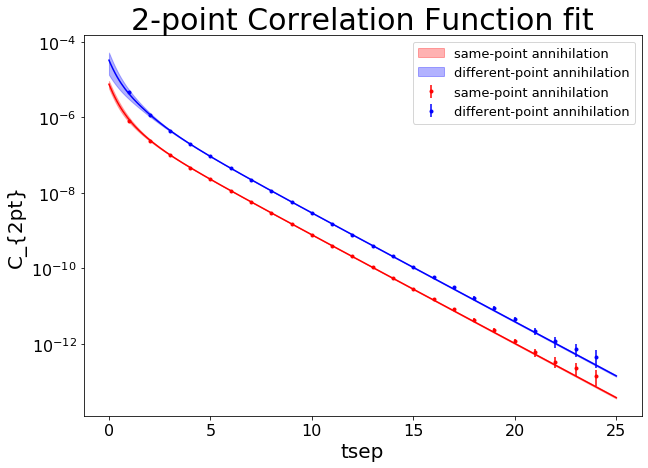

<Figure size 432x288 with 0 Axes>

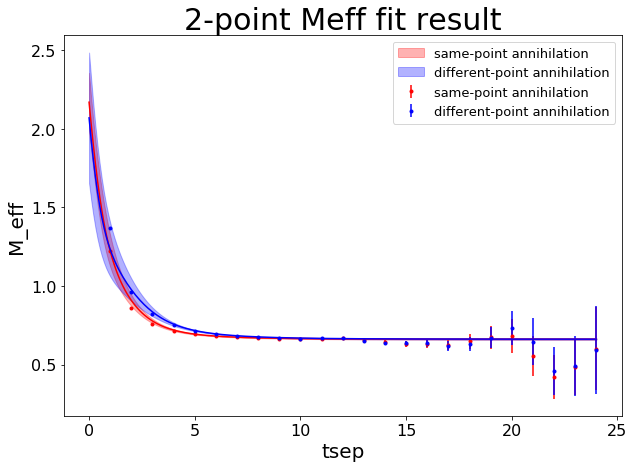

<Figure size 432x288 with 0 Axes>

In [32]:

# Plot the fits


t_plot = np.array([i for i in range(1, 25)])
x_raw2pt = np.array([t_plot, t_plot])
y_raw2pt_mean = np.array([[gv_avg_data['2pt_SS'][i].mean for i in t_plot], [gv_avg_data['2pt_PS'][i].mean for i in t_plot]])
y_raw2pt_sdev = np.array([[gv_avg_data['2pt_SS'][i].sdev for i in t_plot], [gv_avg_data['2pt_PS'][i].sdev for i in t_plot]])
y_2ptmeff_mean = np.array([[gv_avg_data['2pt_SS_meff'][i].mean for i in t_plot], [gv_avg_data['2pt_PS_meff'][i].mean for i in t_plot]])
y_2ptmeff_sdev = np.array([[gv_avg_data['2pt_SS_meff'][i].sdev for i in t_plot], [gv_avg_data['2pt_PS_meff'][i].sdev for i in t_plot]])

x_raw2pt_fit = np.array([tsep_model, tsep_model])
y_raw2pt_fit_mean = np.array([C2ptSS_model_mean, C2ptPS_model_mean])
y_raw2pt_fit_upper = np.array([C2ptSS_model_upbound, C2ptPS_model_upbound])
y_raw2pt_fit_lower = np.array([C2ptSS_model_lowbound, C2ptPS_model_lowbound])
h5_dm.fit_data_plot("2-point Correlation Function fit", "tsep", "C_{2pt}", x_raw2pt, y_raw2pt_mean, x_raw2pt_fit, y_raw2pt_fit_mean, y_raw2pt_fit_upper, y_raw2pt_fit_lower, ['red', 'blue'], 30, 20, 16, 13, ylim = None, nplots = 2, ydat_error = y_raw2pt_sdev, datalabels = ["same-point annihilation", "different-point annihilation"], fitlabels = ["same-point annihilation", "different-point annihilation"], logy = True)

y_2ptmeff_fit_mean = np.array([SS_meff_model_mean, PS_meff_model_mean])
y_2ptmeff_fit_upper = np.array([SS_meff_model_upbound, PS_meff_model_upbound])
y_2ptmeff_fit_lower = np.array([SS_meff_model_lowbound, PS_meff_model_lowbound])

#print(np.shape(x_raw2pt))
#print(np.shape(y_2ptmeff_mean))
#print(np.shape(x_raw2pt_fit[:,:-step_up]))
#print(np.shape(y_2ptmeff_fit_mean))
#print(np.shape(y_2ptmeff_fit_upper))
#print(np.shape(y_2ptmeff_fit_lower))
#print(np.shape(y_2ptmeff_sdev))

h5_dm.fit_data_plot("2-point Meff fit result", "tsep", "M_eff", x_raw2pt, y_2ptmeff_mean, x_raw2pt_fit[:,:-step_up], y_2ptmeff_fit_mean, y_2ptmeff_fit_upper, y_2ptmeff_fit_lower, ['red', 'blue'], 30, 20, 16, 13, ylim = None, nplots = 2, ydat_error = y_2ptmeff_sdev, datalabels = ["same-point annihilation", "different-point annihilation"], fitlabels = ["same-point annihilation", "different-point annihilation"])

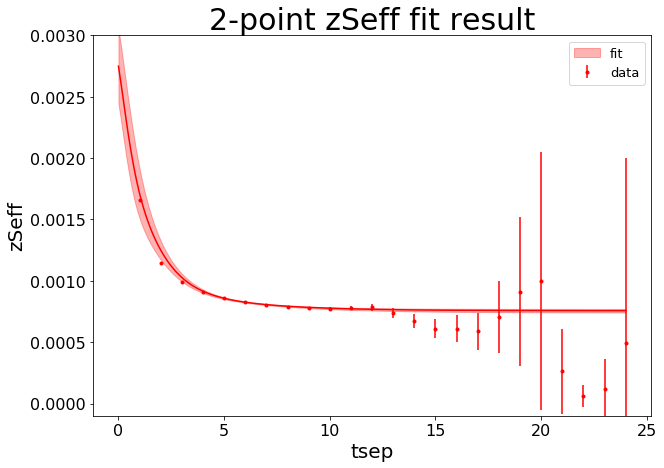

<Figure size 432x288 with 0 Axes>

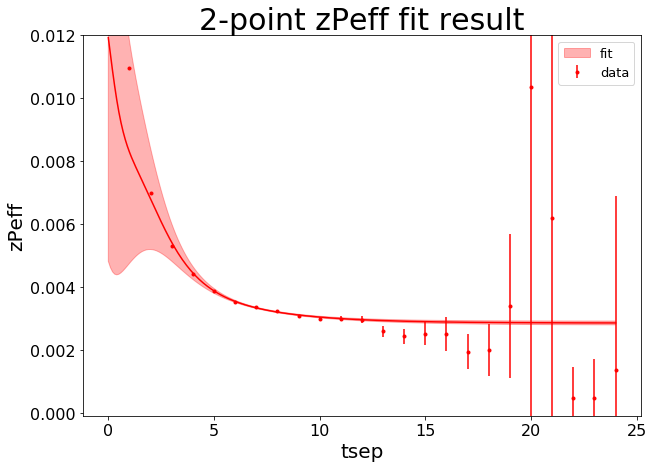

<Figure size 432x288 with 0 Axes>

In [33]:
h5_dm.fit_data_plot("2-point zSeff fit result", "tsep", "zSeff", x_raw2pt[0], [gv_avg_data['2pt_zSeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zSeff_model_mean, zSeff_model_upbound, zSeff_model_lowbound, "red", 30, 20, 16, 13, ylim=[-0.0001, 0.003], ydat_error = [gv_avg_data['2pt_zSeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit")
h5_dm.fit_data_plot("2-point zPeff fit result", "tsep", "zPeff", x_raw2pt[1], [gv_avg_data['2pt_zPeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zPeff_model_mean, zPeff_model_upbound, zPeff_model_lowbound, "red", 30, 20, 16, 13, ylim=[-0.0001, 0.012], ydat_error = [gv_avg_data['2pt_zPeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit")

In [34]:
# Now, plot out the 3-point function
# First, create the x, y, and z values
x_3pt = np.array([[j - (i+3)/2. for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].mean for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_A3_err = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4 = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].mean for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4_err = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])

legendlabels_3pt = np.array(["tsep = {}".format(i) for i in tsep_vals])

# set the array of tsep, tau pairs
tau_step = 10

# Create 2-d and 1-d versions of the 3-point (tsep, tau) pairs
t_3pt_fitresult_2d = np.array([ np.array([ [tsep, tau] for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])
t_3pt_fitresult_tsep = np.zeros(np.sum(np.array([len(np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)) for tsep in tsep_vals])))
t_3pt_fitresult_tau = np.zeros(np.sum(np.array([len(np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)) for tsep in tsep_vals])))

k = 0
for tsep in tsep_vals:
    for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1):
        t_3pt_fitresult_tsep[k] = tsep
        t_3pt_fitresult_tau[k] = tau
        k += 1
        
t_3pt_fitresult_1d = np.transpose(np.array([t_3pt_fitresult_tsep, t_3pt_fitresult_tau]))

# Now, calculate gA3 and gA4

model_A3_3pt_1d = C_3pt_A3(t_3pt_fitresult_1d, post_3pt)
model_V4_3pt_1d = C_3pt_V4(t_3pt_fitresult_1d, post_3pt)

# Convert to 2d
model_A3_3pt_2d = convert_1dto2d(t_3pt_fitresult_1d, t_3pt_fitresult_2d, model_A3_3pt_1d)
model_V4_3pt_2d = convert_1dto2d(t_3pt_fitresult_1d, t_3pt_fitresult_2d, model_V4_3pt_1d)

# Now, take the ratio, first take the respective 2-point function

model_ratio_2pt = C_2pt_SS(tsep_vals, post_3pt)

model_A3_ratio_2d = np.array([ np.array([ model_A3_3pt_2d[i][j]/model_ratio_2pt[i] for j in range(len(model_A3_3pt_2d[i]))]) for i in range(len(model_A3_3pt_2d))])
model_V4_ratio_2d = np.array([ np.array([ model_V4_3pt_2d[i][j]/model_ratio_2pt[i] for j in range(len(model_V4_3pt_2d[i]))]) for i in range(len(model_V4_3pt_2d))])

# Now, to prepare for plotting, split the data into mean, upper-bound and lower-bound
model_A3_ratio_2d_mean = np.array([ [ model_A3_ratio_2d[i][j].mean for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])
model_A3_ratio_2d_upbound = np.array([ [ model_A3_ratio_2d[i][j].mean + model_A3_ratio_2d[i][j].sdev for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])
model_A3_ratio_2d_lowbound = np.array([ [ model_A3_ratio_2d[i][j].mean - model_A3_ratio_2d[i][j].sdev for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])

model_V4_ratio_2d_mean = np.array([ [ model_V4_ratio_2d[i][j].mean for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])
model_V4_ratio_2d_upbound = np.array([ [ model_V4_ratio_2d[i][j].mean + model_V4_ratio_2d[i][j].sdev for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])
model_V4_ratio_2d_lowbound = np.array([ [ model_V4_ratio_2d[i][j].mean - model_V4_ratio_2d[i][j].sdev for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])

# Also, convert the 2-d tsep, tau array into an array of tau - tsep/2
t_3pt_tseptau_diff = np.array([ np.array([tau - tsep/2. for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])

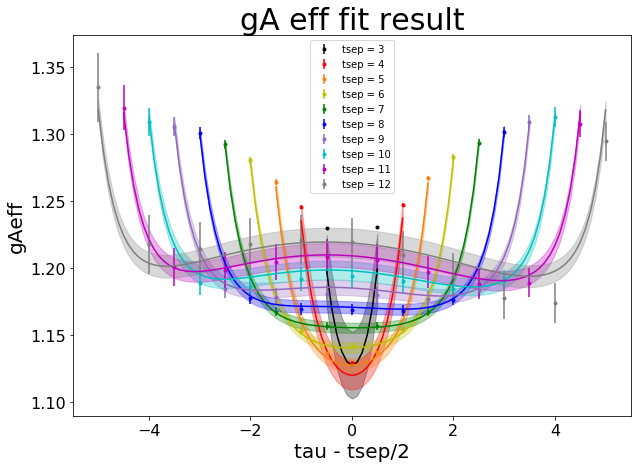

<Figure size 432x288 with 0 Axes>

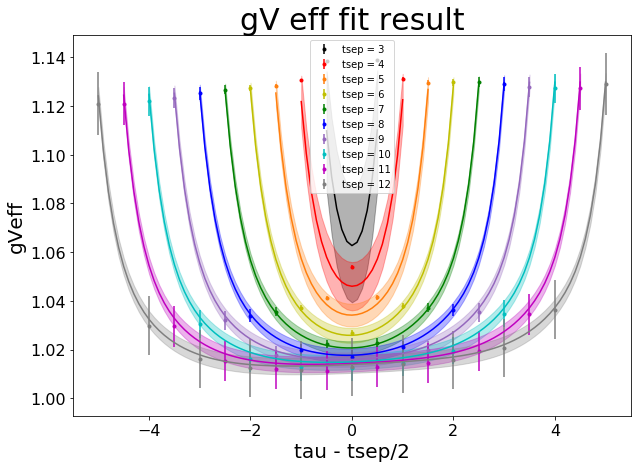

<Figure size 432x288 with 0 Axes>

In [35]:
# The color pallete for plotting the 3-point correlation function
colors_3pt = np.array(['k', 'r', 'tab:orange', 'y', 'g', 'b', 'tab:purple', 'c', 'm', 'tab:grey'])

# The raw dataset fitted to
x_3pt = np.array([[j - (i+3)/2. for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].mean for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_A3_err = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4 = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].mean for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4_err = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])

h5_dm.fit_data_plot("gA eff fit result", "tau - tsep/2", "gAeff", x_3pt, y_3pt_A3, t_3pt_tseptau_diff, model_A3_ratio_2d_mean, model_A3_ratio_2d_upbound, model_A3_ratio_2d_lowbound, colors_3pt, 30, 20, 16, 13, nplots = len(gv_avg_data['C_ratio_A3']), ydat_error=y_3pt_A3_err, datalabels = legendlabels_3pt) 
h5_dm.fit_data_plot("gV eff fit result", "tau - tsep/2", "gVeff", x_3pt, y_3pt_V4, t_3pt_tseptau_diff, model_V4_ratio_2d_mean, model_V4_ratio_2d_upbound, model_V4_ratio_2d_lowbound, colors_3pt, 30, 20, 16, 13, nplots = len(gv_avg_data['C_ratio_V4']), ydat_error=y_3pt_V4_err, datalabels = legendlabels_3pt) 



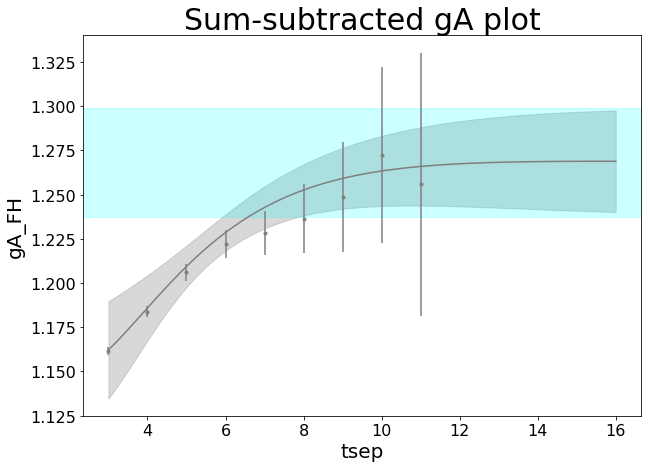

<Figure size 432x288 with 0 Axes>

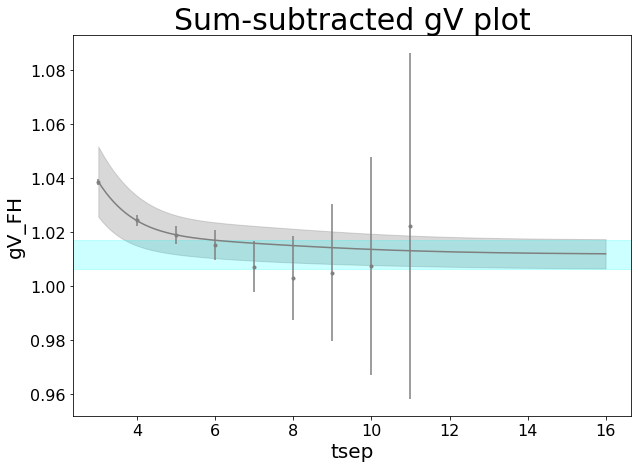

<Figure size 432x288 with 0 Axes>

In [36]:
# And finally, plot the sum-subtracted fit functions
step_FH = 10

# Set up the fit plotting
t_FH_model = np.linspace(tsep_vals[0], tsep_vals[-1]+4, (tsep_vals[-1]+4 - tsep_vals[0])*step_FH + 1)

CFH_A3_model = C_FH_A3(t_FH_model, post_3pt)
CFH_V4_model = C_FH_V4(t_FH_model, post_3pt)

CFH_A3_model_mean = np.array([CFH_A3_model[i].mean for i in range(len(CFH_A3_model))])
CFH_A3_model_upbound = np.array([CFH_A3_model[i].mean + CFH_A3_model[i].sdev for i in range(len(CFH_A3_model))])
CFH_A3_model_lowbound = np.array([CFH_A3_model[i].mean - CFH_A3_model[i].sdev for i in range(len(CFH_A3_model))])
CFH_V4_model_mean = np.array([CFH_V4_model[i].mean for i in range(len(CFH_V4_model))])
CFH_V4_model_upbound = np.array([CFH_V4_model[i].mean + CFH_V4_model[i].sdev for i in range(len(CFH_V4_model))])
CFH_V4_model_lowbound = np.array([CFH_V4_model[i].mean - CFH_V4_model[i].sdev for i in range(len(CFH_V4_model))])

# Set up the raw data plotting
x_CFH = np.array([i for i in tsep_vals[:-1] ])
y_CFH_A3 = np.array([gv_avg_data['C^FH_A3'][i].mean for i in range(len(tsep_vals)-1)])
y_CFH_A3_err = np.array([gv_avg_data['C^FH_A3'][i].sdev for i in range(len(tsep_vals)-1)])
y_CFH_V4 = np.array([gv_avg_data['C^FH_V4'][i].mean for i in range(len(tsep_vals)-1)])
y_CFH_V4_err = np.array([gv_avg_data['C^FH_V4'][i].sdev for i in range(len(tsep_vals)-1)])

h5_dm.fit_data_plot("Sum-subtracted gA plot", "tsep", "gA_FH", x_CFH, y_CFH_A3, t_FH_model, CFH_A3_model_mean, CFH_A3_model_upbound, CFH_A3_model_lowbound, "tab:grey", 30, 20, 16, 13, g00 = post_3pt['gA3_00'], ydat_error=y_CFH_A3_err) 
h5_dm.fit_data_plot("Sum-subtracted gV plot", "tsep", "gV_FH", x_CFH, y_CFH_V4, t_FH_model, CFH_V4_model_mean, CFH_V4_model_upbound, CFH_V4_model_lowbound, "tab:grey", 30, 20, 16, 13, g00 = post_3pt['gV4_00'], ydat_error=y_CFH_V4_err)



### gA_00 = 1.23 +/- 0.01; gV_00 = 1.019 +/- 0.003

### Now, try again, but with a 3 point with tau 2

In [37]:
num_zs = 4
num_states_FH = 3

# prior the fits
prior_2ptstep = gv.BufferDict()

# This is the exponent e_decay_exp such that the increment between two consecutive excited state energies decays as 1/n^e_decay_exp, where n is the order of the excited state energy 
e_decay_exp = 0

prior_2ptstep['E0'] = gv.gvar(0.67, 0.02)
prior_2ptstep['Z0'] = gv.gvar(0.0008, 0.0003)
prior_2ptstep['Ztilde0'] = gv.gvar(0.003, 0.003)

#prior_2ptstep['E1'] = gv.gvar(1.3, 0.23)
#prior_2ptstep['log(E1)'] = gv.gvar(np.log(1.3), np.log(1.3/(1.3 - 0.3)))
#prior_2ptstep['Z1'] = gv.gvar(0.0012, 0.0006)
#prior_2ptstep['Ztilde1'] = gv.gvar(0.006, 0.005)

# Define some constants for prioring the higher-order energies
dE0 = 2*mpi
b = 0.7

# Use constant dE to prior the energies
dE0 = 2*mpi
energyvals = np.array([None]*num_zs)
dEvals = np.array([None]*(num_zs - 1))

#E0_errbar = 0.8
energyvals[0] = gv.gvar(0.67, 0.02)
for k in range(1, num_zs):
    dEvals[k-1] = dE0/np.power(k, e_decay_exp)
    energyvals[k] = energyvals[k-1] + dEvals[k-1]

for n in range(1, num_zs):
    prior_2ptstep['log(dE{})'.format(n)] = gv.gvar(np.log(dEvals[n-1]), b)
    prior_2ptstep['Z{}'.format(n)] = gv.gvar(0.0012, 0.0006)
    prior_2ptstep['Ztilde{}'.format(n)] = gv.gvar(0, 0.01)
    
    # Insert priors for energy here
    #dE_next = dE0/np.power(n, e_decay_exp)
    #E_next = prior_2ptstep['E{}'.format(n-1)].mean + dE_next
    #sigma_next = np.log(E_next/(E_next - (dE_next*b)))

print(num_states_FH - 2)

for n in range(num_zs):
    for m in range(num_zs):
        
        prior_2ptstep['gA3_{0}{1}'.format(n, m)] = gv.gvar(0, 2)
        if n == m and n < num_zs-1:
            prior_2ptstep['gV4_{0}{1}'.format(n, m)] = gv.gvar(1, 0.1)
        else:
            prior_2ptstep['gV4_{0}{1}'.format(n, m)] = gv.gvar(0, 2)

prior_2ptstep['gA3_00'] = gv.gvar(1.25, 0.15)
prior_2ptstep['gV4_00'] = gv.gvar(1.07, 0.07)

# Set the "garbage can" for the Feynman Hellman fit
prior_2ptstep['Z_FHmax'] = gv.gvar(0.0008, 0.0004)
prior_2ptstep['log(FH_dEmax)'] = gv.gvar(np.log(dEvals[num_states_FH - 2]), b) 

for n in range(num_states_FH-1):
    prior_2ptstep['gA3_FHmax{}'.format(n)] = gv.gvar(0, 2)
    prior_2ptstep['gA3_{}FHmax'.format(n)] = gv.gvar(0, 2)
    prior_2ptstep['gV4_FHmax{}'.format(n)] = gv.gvar(0, 2)
    prior_2ptstep['gV4_{}FHmax'.format(n)] = gv.gvar(0, 2)
    
prior_2ptstep['gA3_FHmaxFHmax'] = gv.gvar(0, 2)
prior_2ptstep['gV4_FHmaxFHmax'] = gv.gvar(0, 2)

#prior_2ptstep

1


In [38]:
# 2-point fit
fit_2pt = lsqfit.nonlinear_fit(data=(np.array([l for l in range(2, 13)]), np.array([[ [c] for c in gv_avg_data['2pt'][l]] for l in range(2,13)]) ), prior=prior_2ptstep,fcn=C_2pt,debug=True)
print(fit_2pt.format(pstyle='vv'))
post_2pt = fit_2pt.p

Least Square Fit:
  chi2/dof [dof] = 0.85 [22]    Q = 0.67    logGBF = 484.64

Parameters:
             E0       0.661027 +- 0.00280207             [     0.67 +- 0.02 ]  
             Z0   0.000756981 +- 1.03675e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.00286124 +- 4.6968e-05             [   0.003 +- 0.003 ]  
       log(dE1)          -0.8113 +- 0.135657             [  -0.97551 +- 0.7 ]  
             Z1   0.000662449 +- 9.46282e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1    0.00448214 +- 0.000764342             [        0 +- 0.01 ]  
       log(dE2)        -0.516866 +- 0.438609             [  -0.97551 +- 0.7 ]  
             Z2    0.000799852 +- 0.00040447             [ 0.0012 +- 0.0006 ]  
        Ztilde2       0.0059393 +- 0.0030705             [        0 +- 0.01 ]  
       log(dE3)         -0.526875 +- 0.58489             [  -0.97551 +- 0.7 ]  
             Z3    0.00118014 +- 0.000236461             [ 0.0012 +- 0.0006 ]  
        Ztilde3      0.008748

In [39]:
# pickle output params of the 2-point fit, then set the next prior, prior_3pt_A3step
#current_posterior = open('2pt_FH_3pt_stage2pt.obj', 'wb')
#pickle.dump(post_2pt, current_posterior)
#current_posterior.close()

In [40]:
#next_priors = open('2pt_FH_3pt_stage2pt.obj', 'rb')
#prior_CFH = pickle.load(next_priors)
#next_priors.close()

In [41]:
fit_CFH = lsqfit.nonlinear_fit(data=(np.array([l for l in tsep_vals[:-1]]), np.array([gv_avg_data['C^FH_combined'][l] for l in range(len(tsep_vals[:-1]))])), prior=post_2pt,fcn=C_FH,debug=True)
print(fit_CFH.format(pstyle='vv'))
post_CFH = fit_CFH.p

Least Square Fit:
  chi2/dof [dof] = 0.32 [18]    Q = 1    logGBF = 46.333

Parameters:
             E0       0.661074 +- 0.00274943             [     0.661027 +- 0.00280207 ]  
             Z0   0.000757199 +- 1.01756e-05             [ 0.000756981 +- 1.03675e-05 ]  
        Ztilde0    0.00286188 +- 4.60965e-05             [   0.00286124 +- 4.6968e-05 ]  
       log(dE1)        -0.810387 +- 0.133613             [        -0.8113 +- 0.135657 ]  
             Z1   0.000659273 +- 9.38123e-05             [ 0.000662449 +- 9.46282e-05 ]  
        Ztilde1    0.00448196 +- 0.000754108             [  0.00448214 +- 0.000764342 ]  
       log(dE2)        -0.528043 +- 0.437477             [      -0.516866 +- 0.438609 ]  
             Z2    0.000801422 +- 0.00040434             [  0.000799852 +- 0.00040447 ]  
        Ztilde2     0.00587028 +- 0.00306862             [     0.0059393 +- 0.0030705 ]  
       log(dE3)        -0.525482 +- 0.582458             [       -0.526875 +- 0.58489 ]  
            

In [42]:
#current_posterior = open('2pt_FH_3pt_stageFH.obj', 'wb')
#pickle.dump(post_CFH, current_posterior)
#current_posterior.close()

In [43]:
#next_priors = open('2pt_FH_3pt_stageFH.obj', 'rb')
#prior_3pt = pickle.load(next_priors)
#next_priors.close()

In [44]:
tau_cut_val = 2
y_3pt_A3_2d = np.array([ [gv_avg_data['3pt_A3'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_A3_2d)
y_3pt_V4_2d = np.array([ [gv_avg_data['3pt_V4'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_V4 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_V4_2d)
y_3pt = np.transpose(np.array([[y_3pt_A3], [y_3pt_V4]]), axes=[2,0,1])

# Create the dataset to be fit
x_1darray_tau2 = []
y_3pt_tau2 = []

    
for k in range(len(t_1d_array)):
    if(t_1d_array[k][0] >= 4):
        if(t_1d_array[k][1] >= tau_cut_val):
            if(t_1d_array[k][1] <= t_1d_array[k][0] - tau_cut_val):
                x_1darray_tau2.append(t_1d_array[k].tolist())
                y_3pt_tau2.append(y_3pt[k].tolist())
                            
x_1darray_tau2 = np.array(x_1darray_tau2)
y_3pt_tau2 = np.array(y_3pt_tau2)

In [45]:


fit_3pt_tau2 = lsqfit.nonlinear_fit(data=(x_1darray_tau2, y_3pt_tau2), prior=post_CFH, fcn = C_3pt, debug = True)
print(fit_3pt_tau2.format(pstyle='vv'))
post_3pt_tau2 = fit_3pt_tau2.p

Least Square Fit:
  chi2/dof [dof] = 1 [90]    Q = 0.4    logGBF = 2353.6

Parameters:
             E0       0.659256 +- 0.00231638             [     0.661074 +- 0.00274943 ]  
             Z0    0.000748614 +- 8.3101e-06             [ 0.000757199 +- 1.01756e-05 ]  
        Ztilde0    0.00281907 +- 3.69447e-05             [  0.00286188 +- 4.60965e-05 ]  
       log(dE1)       -0.907568 +- 0.0804178             [      -0.810387 +- 0.133613 ]  
             Z1    0.00063358 +- 5.05102e-05             [ 0.000659273 +- 9.38123e-05 ]  
        Ztilde1    0.00413435 +- 0.000414519             [  0.00448196 +- 0.000754108 ]  
       log(dE2)       0.0698333 +- 0.0728476             [      -0.528043 +- 0.437477 ]  *
             Z2    0.00149048 +- 0.000177534             [  0.000801422 +- 0.00040434 ]  *
        Ztilde2      0.0113389 +- 0.00125738             [   0.00587028 +- 0.00306862 ]  *
       log(dE3)        -0.300188 +- 0.431431             [      -0.525482 +- 0.582458 ]  
          

In [46]:
final_posterior = open("Final(3pt)_tau2_out.obj", 'wb')
pickle.dump(post_3pt_tau2, final_posterior)
final_posterior.close()

# Also, print out the result of E0 at each stage
print("E0 = ", post_2pt['E0'], " for 2-point; E0 = ", post_CFH['E0'], " for sum-subtracted; E0 = ", post_3pt_tau2['E0'], " for 3-point")

E0 =  0.6610(28)  for 2-point; E0 =  0.6611(27)  for sum-subtracted; E0 =  0.6593(23)  for 3-point


In [47]:
# Now, plot the fit results of the chained-fit, starting with the 2-point data
step_up = 10
t_min = 0
t_max = 25
tsep_model = np.linspace(t_min, t_max, (t_max - t_min)*step_up +1)

C2ptSS_model = C_2pt_SS(tsep_model, post_3pt_tau2)
C2ptPS_model = C_2pt_PS(tsep_model, post_3pt_tau2)

SS_meff_model = np.log(np.array([C2ptSS_model[j]/C2ptSS_model[j+step_up] for j in range(len(tsep_model[:-step_up]))]))
PS_meff_model = np.log(np.array([C2ptPS_model[j]/C2ptPS_model[j+step_up] for j in range(len(tsep_model[:-step_up]))]))

zSeff_model = np.array([np.sqrt(np.exp(SS_meff_model[t]*t/step_up)*C2ptSS_model[t]) for t in range(len(tsep_model[:-step_up]))])
zPeff_model = np.array([np.exp(PS_meff_model[t]*t/step_up)*C2ptPS_model[t]/zSeff_model[t] for t in range(len(tsep_model[:-step_up]))])

# Split the models up into mean, upper-bound, and lower-bound
C2ptSS_model_mean = np.array([C2ptSS_model[i].mean for i in range(len(C2ptSS_model))])
C2ptSS_model_upbound = np.array([C2ptSS_model[i].mean + C2ptSS_model[i].sdev for i in range(len(C2ptSS_model))])
C2ptSS_model_lowbound = np.array([C2ptSS_model[i].mean - C2ptSS_model[i].sdev for i in range(len(C2ptSS_model))])
C2ptPS_model_mean = np.array([C2ptPS_model[i].mean for i in range(len(C2ptPS_model))])
C2ptPS_model_upbound = np.array([C2ptPS_model[i].mean + C2ptPS_model[i].sdev for i in range(len(C2ptPS_model))])
C2ptPS_model_lowbound = np.array([C2ptPS_model[i].mean - C2ptPS_model[i].sdev for i in range(len(C2ptPS_model))])

SS_meff_model_mean = np.array([SS_meff_model[i].mean for i in range(len(SS_meff_model))])
SS_meff_model_upbound = np.array([SS_meff_model[i].mean + SS_meff_model[i].sdev for i in range(len(SS_meff_model))])
SS_meff_model_lowbound = np.array([SS_meff_model[i].mean - SS_meff_model[i].sdev for i in range(len(SS_meff_model))])
PS_meff_model_mean = np.array([PS_meff_model[i].mean for i in range(len(PS_meff_model))])
PS_meff_model_upbound = np.array([PS_meff_model[i].mean + PS_meff_model[i].sdev for i in range(len(PS_meff_model))])
PS_meff_model_lowbound = np.array([PS_meff_model[i].mean - PS_meff_model[i].sdev for i in range(len(PS_meff_model))])

zSeff_model_mean = np.array([zSeff_model[i].mean for i in range(len(zSeff_model))]) 
zSeff_model_upbound = np.array([zSeff_model[i].mean + zSeff_model[i].sdev for i in range(len(zSeff_model))]) 
zSeff_model_lowbound = np.array([zSeff_model[i].mean - zSeff_model[i].sdev for i in range(len(zSeff_model))])
zPeff_model_mean = np.array([zPeff_model[i].mean for i in range(len(zPeff_model))]) 
zPeff_model_upbound = np.array([zPeff_model[i].mean + zPeff_model[i].sdev for i in range(len(zPeff_model))])
zPeff_model_lowbound = np.array([zPeff_model[i].mean - zPeff_model[i].sdev for i in range(len(zPeff_model))])
#print(np.shape(zSeff_model_lowbound))

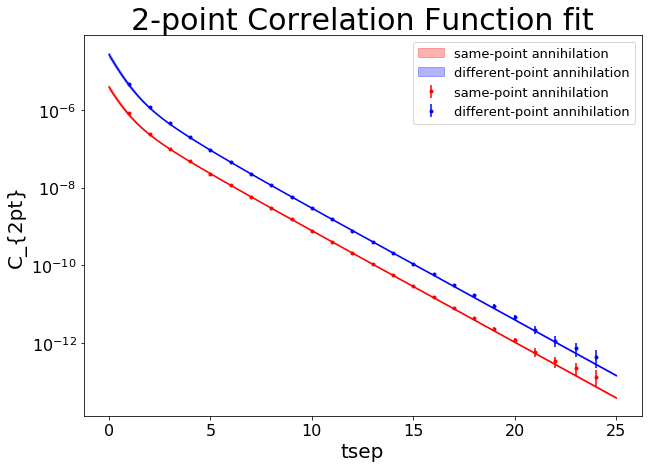

<Figure size 432x288 with 0 Axes>

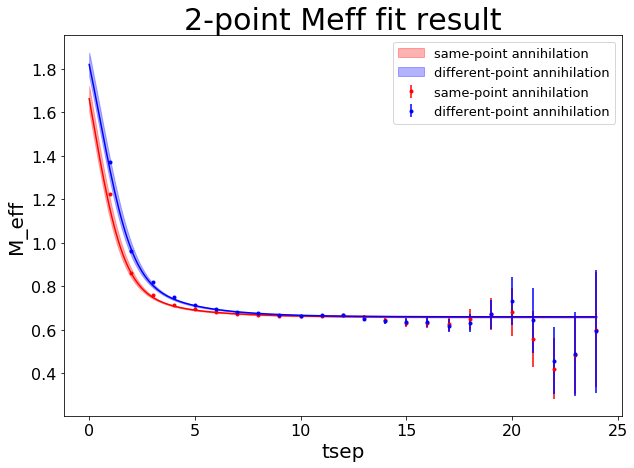

<Figure size 432x288 with 0 Axes>

In [48]:

# Plot the fits


t_plot = np.array([i for i in range(1, 25)])
x_raw2pt = np.array([t_plot, t_plot])
y_raw2pt_mean = np.array([[gv_avg_data['2pt_SS'][i].mean for i in t_plot], [gv_avg_data['2pt_PS'][i].mean for i in t_plot]])
y_raw2pt_sdev = np.array([[gv_avg_data['2pt_SS'][i].sdev for i in t_plot], [gv_avg_data['2pt_PS'][i].sdev for i in t_plot]])
y_2ptmeff_mean = np.array([[gv_avg_data['2pt_SS_meff'][i].mean for i in t_plot], [gv_avg_data['2pt_PS_meff'][i].mean for i in t_plot]])
y_2ptmeff_sdev = np.array([[gv_avg_data['2pt_SS_meff'][i].sdev for i in t_plot], [gv_avg_data['2pt_PS_meff'][i].sdev for i in t_plot]])

x_raw2pt_fit = np.array([tsep_model, tsep_model])
y_raw2pt_fit_mean = np.array([C2ptSS_model_mean, C2ptPS_model_mean])
y_raw2pt_fit_upper = np.array([C2ptSS_model_upbound, C2ptPS_model_upbound])
y_raw2pt_fit_lower = np.array([C2ptSS_model_lowbound, C2ptPS_model_lowbound])
h5_dm.fit_data_plot("2-point Correlation Function fit", "tsep", "C_{2pt}", x_raw2pt, y_raw2pt_mean, x_raw2pt_fit, y_raw2pt_fit_mean, y_raw2pt_fit_upper, y_raw2pt_fit_lower, ['red', 'blue'], 30, 20, 16, 13, ylim = None, nplots = 2, ydat_error = y_raw2pt_sdev, datalabels = ["same-point annihilation", "different-point annihilation"], fitlabels = ["same-point annihilation", "different-point annihilation"], logy = True)

y_2ptmeff_fit_mean = np.array([SS_meff_model_mean, PS_meff_model_mean])
y_2ptmeff_fit_upper = np.array([SS_meff_model_upbound, PS_meff_model_upbound])
y_2ptmeff_fit_lower = np.array([SS_meff_model_lowbound, PS_meff_model_lowbound])

#print(np.shape(x_raw2pt))
#print(np.shape(y_2ptmeff_mean))
#print(np.shape(x_raw2pt_fit[:,:-step_up]))
#print(np.shape(y_2ptmeff_fit_mean))
#print(np.shape(y_2ptmeff_fit_upper))
#print(np.shape(y_2ptmeff_fit_lower))
#print(np.shape(y_2ptmeff_sdev))

h5_dm.fit_data_plot("2-point Meff fit result", "tsep", "M_eff", x_raw2pt, y_2ptmeff_mean, x_raw2pt_fit[:,:-step_up], y_2ptmeff_fit_mean, y_2ptmeff_fit_upper, y_2ptmeff_fit_lower, ['red', 'blue'], 30, 20, 16, 13, ylim = None, nplots = 2, ydat_error = y_2ptmeff_sdev, datalabels = ["same-point annihilation", "different-point annihilation"], fitlabels = ["same-point annihilation", "different-point annihilation"])

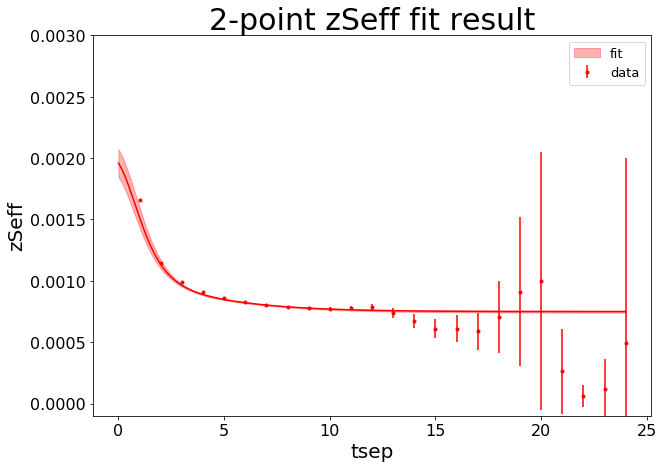

<Figure size 432x288 with 0 Axes>

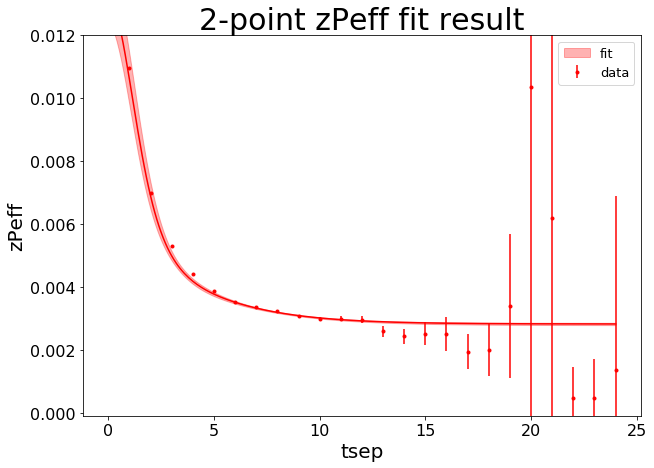

<Figure size 432x288 with 0 Axes>

In [49]:
h5_dm.fit_data_plot("2-point zSeff fit result", "tsep", "zSeff", x_raw2pt[0], [gv_avg_data['2pt_zSeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zSeff_model_mean, zSeff_model_upbound, zSeff_model_lowbound, "red", 30, 20, 16, 13, ylim=[-0.0001, 0.003], ydat_error = [gv_avg_data['2pt_zSeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit")
h5_dm.fit_data_plot("2-point zPeff fit result", "tsep", "zPeff", x_raw2pt[1], [gv_avg_data['2pt_zPeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zPeff_model_mean, zPeff_model_upbound, zPeff_model_lowbound, "red", 30, 20, 16, 13, ylim=[-0.0001, 0.012], ydat_error = [gv_avg_data['2pt_zPeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit")

In [50]:
# Now, plot out the 3-point function
# First, create the x, y, and z values
x_3pt = np.array([[j - (i+3)/2. for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].mean for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_A3_err = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4 = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].mean for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4_err = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])

legendlabels_3pt = np.array(["tsep = {}".format(i) for i in tsep_vals])

# set the array of tsep, tau pairs
tau_step = 10

# Create 2-d and 1-d versions of the 3-point (tsep, tau) pairs
t_3pt_fitresult_2d = np.array([ np.array([ [tsep, tau] for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])
t_3pt_fitresult_tsep = np.zeros(np.sum(np.array([len(np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)) for tsep in tsep_vals])))
t_3pt_fitresult_tau = np.zeros(np.sum(np.array([len(np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)) for tsep in tsep_vals])))

k = 0
for tsep in tsep_vals:
    for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1):
        t_3pt_fitresult_tsep[k] = tsep
        t_3pt_fitresult_tau[k] = tau
        k += 1
        
t_3pt_fitresult_1d = np.transpose(np.array([t_3pt_fitresult_tsep, t_3pt_fitresult_tau]))

# Now, calculate gA3 and gA4

model_A3_3pt_1d = C_3pt_A3(t_3pt_fitresult_1d, post_3pt_tau2)
model_V4_3pt_1d = C_3pt_V4(t_3pt_fitresult_1d, post_3pt_tau2)

# Convert to 2d
model_A3_3pt_2d = convert_1dto2d(t_3pt_fitresult_1d, t_3pt_fitresult_2d, model_A3_3pt_1d)
model_V4_3pt_2d = convert_1dto2d(t_3pt_fitresult_1d, t_3pt_fitresult_2d, model_V4_3pt_1d)

# Now, take the ratio, first take the respective 2-point function

model_ratio_2pt = C_2pt_SS(tsep_vals, post_3pt_tau2)

model_A3_ratio_2d = np.array([ np.array([ model_A3_3pt_2d[i][j]/model_ratio_2pt[i] for j in range(len(model_A3_3pt_2d[i]))]) for i in range(len(model_A3_3pt_2d))])
model_V4_ratio_2d = np.array([ np.array([ model_V4_3pt_2d[i][j]/model_ratio_2pt[i] for j in range(len(model_V4_3pt_2d[i]))]) for i in range(len(model_V4_3pt_2d))])

# Now, to prepare for plotting, split the data into mean, upper-bound and lower-bound
model_A3_ratio_2d_mean = np.array([ [ model_A3_ratio_2d[i][j].mean for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])
model_A3_ratio_2d_upbound = np.array([ [ model_A3_ratio_2d[i][j].mean + model_A3_ratio_2d[i][j].sdev for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])
model_A3_ratio_2d_lowbound = np.array([ [ model_A3_ratio_2d[i][j].mean - model_A3_ratio_2d[i][j].sdev for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])

model_V4_ratio_2d_mean = np.array([ [ model_V4_ratio_2d[i][j].mean for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])
model_V4_ratio_2d_upbound = np.array([ [ model_V4_ratio_2d[i][j].mean + model_V4_ratio_2d[i][j].sdev for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])
model_V4_ratio_2d_lowbound = np.array([ [ model_V4_ratio_2d[i][j].mean - model_V4_ratio_2d[i][j].sdev for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])

# Also, convert the 2-d tsep, tau array into an array of tau - tsep/2
t_3pt_tseptau_diff = np.array([ np.array([tau - tsep/2. for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])

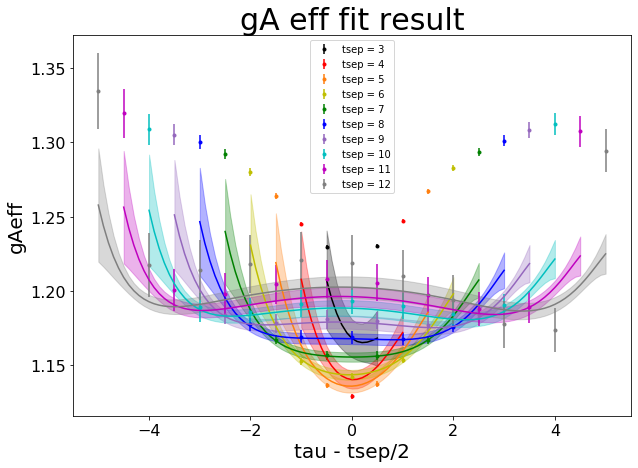

<Figure size 432x288 with 0 Axes>

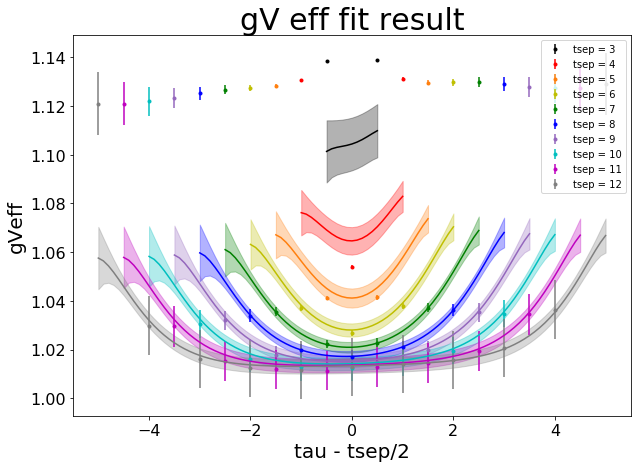

<Figure size 432x288 with 0 Axes>

In [51]:
# The color pallete for plotting the 3-point correlation function
colors_3pt = np.array(['k', 'r', 'tab:orange', 'y', 'g', 'b', 'tab:purple', 'c', 'm', 'tab:grey'])

# The raw dataset fitted to
x_3pt = np.array([[j - (i+3)/2. for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].mean for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_A3_err = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4 = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].mean for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4_err = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])

h5_dm.fit_data_plot("gA eff fit result", "tau - tsep/2", "gAeff", x_3pt, y_3pt_A3, t_3pt_tseptau_diff, model_A3_ratio_2d_mean, model_A3_ratio_2d_upbound, model_A3_ratio_2d_lowbound, colors_3pt, 30, 20, 16, 13, nplots = len(gv_avg_data['C_ratio_A3']), ydat_error=y_3pt_A3_err, datalabels = legendlabels_3pt) 
h5_dm.fit_data_plot("gV eff fit result", "tau - tsep/2", "gVeff", x_3pt, y_3pt_V4, t_3pt_tseptau_diff, model_V4_ratio_2d_mean, model_V4_ratio_2d_upbound, model_V4_ratio_2d_lowbound, colors_3pt, 30, 20, 16, 13, nplots = len(gv_avg_data['C_ratio_V4']), ydat_error=y_3pt_V4_err, datalabels = legendlabels_3pt) 



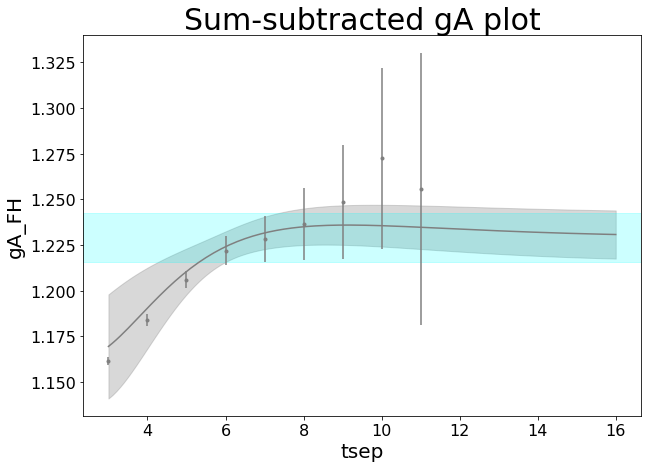

<Figure size 432x288 with 0 Axes>

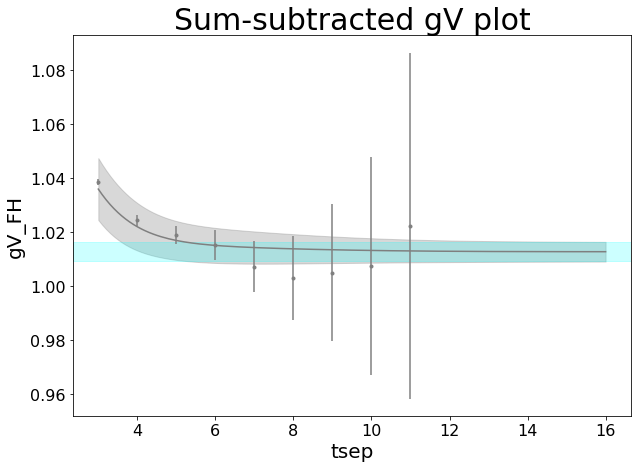

<Figure size 432x288 with 0 Axes>

In [52]:
# And finally, plot the Sum-subtracted fit functions
step_FH = 10

# Set up the fit plotting
t_FH_model = np.linspace(tsep_vals[0], tsep_vals[-1]+4, (tsep_vals[-1]+4 - tsep_vals[0])*step_FH + 1)

CFH_A3_model = C_FH_A3(t_FH_model, post_3pt_tau2)
CFH_V4_model = C_FH_V4(t_FH_model, post_3pt_tau2)

CFH_A3_model_mean = np.array([CFH_A3_model[i].mean for i in range(len(CFH_A3_model))])
CFH_A3_model_upbound = np.array([CFH_A3_model[i].mean + CFH_A3_model[i].sdev for i in range(len(CFH_A3_model))])
CFH_A3_model_lowbound = np.array([CFH_A3_model[i].mean - CFH_A3_model[i].sdev for i in range(len(CFH_A3_model))])
CFH_V4_model_mean = np.array([CFH_V4_model[i].mean for i in range(len(CFH_V4_model))])
CFH_V4_model_upbound = np.array([CFH_V4_model[i].mean + CFH_V4_model[i].sdev for i in range(len(CFH_V4_model))])
CFH_V4_model_lowbound = np.array([CFH_V4_model[i].mean - CFH_V4_model[i].sdev for i in range(len(CFH_V4_model))])

# Set up the raw data plotting
x_CFH = np.array([i for i in tsep_vals[:-1] ])
y_CFH_A3 = np.array([gv_avg_data['C^FH_A3'][i].mean for i in range(len(tsep_vals)-1)])
y_CFH_A3_err = np.array([gv_avg_data['C^FH_A3'][i].sdev for i in range(len(tsep_vals)-1)])
y_CFH_V4 = np.array([gv_avg_data['C^FH_V4'][i].mean for i in range(len(tsep_vals)-1)])
y_CFH_V4_err = np.array([gv_avg_data['C^FH_V4'][i].sdev for i in range(len(tsep_vals)-1)])

h5_dm.fit_data_plot("Sum-subtracted gA plot", "tsep", "gA_FH", x_CFH, y_CFH_A3, t_FH_model, CFH_A3_model_mean, CFH_A3_model_upbound, CFH_A3_model_lowbound, "tab:grey", 30, 20, 16, 13, g00 = post_3pt_tau2['gA3_00'], ydat_error=y_CFH_A3_err) 
h5_dm.fit_data_plot("Sum-subtracted gV plot", "tsep", "gV_FH", x_CFH, y_CFH_V4, t_FH_model, CFH_V4_model_mean, CFH_V4_model_upbound, CFH_V4_model_lowbound, "tab:grey", 30, 20, 16, 13, g00 = post_3pt_tau2['gV4_00'], ydat_error=y_CFH_V4_err)



### gA3_00 = 1.22815 +- 0.0133987, gV4_00 =1.01296 +- 0.00358532  

## Try adding in the FH fit

In [53]:
num_zs = 7
num_states_FH = 2
#num_states_FHdata = 3

# prior the fits
prior_2ptstep = gv.BufferDict()

# This is the exponent e_decay_exp such that the increment between two consecutive excited state energies decays as 1/n^e_decay_exp, where n is the order of the excited state energy 
e_decay_exp = 0

prior_2ptstep['E0'] = gv.gvar(0.67, 0.02)
prior_2ptstep['Z0'] = gv.gvar(0.0008, 0.0003)
prior_2ptstep['Ztilde0'] = gv.gvar(0.003, 0.003)

#prior_2ptstep['E1'] = gv.gvar(1.3, 0.23)
#prior_2ptstep['log(E1)'] = gv.gvar(np.log(1.3), np.log(1.3/(1.3 - 0.3)))
#prior_2ptstep['Z1'] = gv.gvar(0.0012, 0.0006)
#prior_2ptstep['Ztilde1'] = gv.gvar(0.006, 0.005)

# Define some constants for prioring the higher-order energies
dE0 = 2*mpi
b = 0.7

# Use constant dE to prior the energies
dE0 = 2*mpi
energyvals = np.array([None]*num_zs)
dEvals = np.array([None]*(num_zs - 1))

#E0_errbar = 0.8
energyvals[0] = gv.gvar(0.67, 0.02)
for k in range(1, num_zs):
    dEvals[k-1] = dE0/np.power(k, e_decay_exp)
    energyvals[k] = energyvals[k-1] + dEvals[k-1]

for n in range(1, num_zs):
    prior_2ptstep['log(dE{})'.format(n)] = gv.gvar(np.log(dEvals[n-1]), b)
    prior_2ptstep['Z{}'.format(n)] = gv.gvar(0.0012, 0.0006)
    prior_2ptstep['Ztilde{}'.format(n)] = gv.gvar(0, 0.01)
    
    # Insert priors for energy here
    #dE_next = dE0/np.power(n, e_decay_exp)
    #E_next = prior_2ptstep['E{}'.format(n-1)].mean + dE_next
    #sigma_next = np.log(E_next/(E_next - (dE_next*b)))

print(num_states_FH - 2)

for n in range(num_zs):
    prior_2ptstep["d_gA_ss_{}".format(n)] = gv.gvar(0,0.00001)
    prior_2ptstep["d_gA_ps_{}".format(n)] = gv.gvar(0,0.00001)
    prior_2ptstep["d_gV_ss_{}".format(n)] = gv.gvar(0,0.00001)
    prior_2ptstep["d_gV_ps_{}".format(n)] = gv.gvar(0,0.00001)
    for m in range(num_zs):
        
        prior_2ptstep['gA3_{0}{1}'.format(n, m)] = gv.gvar(0, 2)
        if n == m and n < num_zs-1:
            prior_2ptstep['gV4_{0}{1}'.format(n, m)] = gv.gvar(1, 0.1)
        else:
            prior_2ptstep['gV4_{0}{1}'.format(n, m)] = gv.gvar(0, 2)

prior_2ptstep['gA3_00'] = gv.gvar(1.25, 0.15)
prior_2ptstep['gV4_00'] = gv.gvar(1.07, 0.07)

# Set the "garbage can" for the Feynman Hellman fit, post-Lattice-QCD stage
prior_2ptstep['Z_FHmax'] = gv.gvar(0.0012, 0.0006)
prior_2ptstep['Ztilde_FHmax'] = gv.gvar(0, 0.01)
prior_2ptstep['log(FH_dEmax)'] = gv.gvar(np.log(dEvals[num_states_FH - 2]), b) 

for n in range(num_states_FH-1):
    prior_2ptstep['gA3_FHmax{}'.format(n)] = gv.gvar(0, 2)
    prior_2ptstep['gA3_{}FHmax'.format(n)] = gv.gvar(0, 2)
    prior_2ptstep['gV4_FHmax{}'.format(n)] = gv.gvar(0, 2)
    prior_2ptstep['gV4_{}FHmax'.format(n)] = gv.gvar(0, 2)
    
prior_2ptstep['gA3_FHmaxFHmax'] = gv.gvar(0, 2)
prior_2ptstep['gV4_FHmaxFHmax'] = gv.gvar(0, 2)

# Set the "garbage can" for the Feynman Hellman fit, Lattice-QCD stage
#prior_2ptstep['Z_FHdatamax'] = gv.gvar(0.0012, 0.0006)
#prior_2ptstep['Ztilde_FHdatamax'] = gv.gvar(0, 0.01)
#prior_2ptstep['log(FHdata_dEmax)'] = gv.gvar(np.log(dEvals[num_states_FH - 2]), b) 

#for n in range(num_states_FH-1):
    #prior_2ptstep['gA3_FHdatamax{}'.format(n)] = gv.gvar(1, 2)
    #prior_2ptstep['gA3_{}FHdatamax'.format(n)] = gv.gvar(1, 2)
    #prior_2ptstep['gV4_FHdatamax{}'.format(n)] = gv.gvar(0, 2)
    #prior_2ptstep['gV4_{}FHdatamax'.format(n)] = gv.gvar(0, 2)
    
#prior_2ptstep['gA3_FHdatamaxFHdatamax'] = gv.gvar(1, 2)
#prior_2ptstep['gV4_FHdatamaxFHdatamax'] = gv.gvar(0, 2)

#prior_2ptstep

0


In [54]:
# 2-point fit
fit_2pt = lsqfit.nonlinear_fit(data=(np.array([l for l in range(2, 13)]), np.array([[ [c] for c in gv_avg_data['2pt'][l]] for l in range(2,13)]) ), prior=prior_2ptstep,fcn=C_2pt,debug=True)
print(fit_2pt.format(pstyle='vv'))
post_2pt = fit_2pt.p

Least Square Fit:
  chi2/dof [dof] = 0.9 [22]    Q = 0.59    logGBF = 483.09

Parameters:
             E0       0.659347 +- 0.00482406             [     0.67 +- 0.02 ]  
             Z0   0.000748018 +- 2.26286e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00281834 +- 0.000100562             [   0.003 +- 0.003 ]  
       log(dE1)         -1.07435 +- 0.453575             [  -0.97551 +- 0.7 ]  
             Z1   0.000518164 +- 0.000197072             [ 0.0012 +- 0.0006 ]  *
        Ztilde1     0.00318134 +- 0.00168234             [        0 +- 0.01 ]  
       log(dE2)        -0.732238 +- 0.442562             [  -0.97551 +- 0.7 ]  
             Z2   0.000778871 +- 0.000287095             [ 0.0012 +- 0.0006 ]  
        Ztilde2       0.0064959 +- 0.0026369             [        0 +- 0.01 ]  
       log(dE3)        -0.853576 +- 0.645681             [  -0.97551 +- 0.7 ]  
             Z3   0.000712665 +- 0.000420096             [ 0.0012 +- 0.0006 ]  
        Ztilde3     0.0030271

In [55]:
# pickle output params of the 2-point fit, then set the next prior, prior_3pt_A3step
#current_posterior = open('2pt_FH_3pt_stage2pt.obj', 'wb')
#pickle.dump(post_2pt, current_posterior)
#current_posterior.close()

In [56]:
#next_priors = open('2pt_FH_3pt_stage2pt.obj', 'rb')
#prior_CFH = pickle.load(next_priors)
#next_priors.close()

In [57]:
fit_CFH = lsqfit.nonlinear_fit(data=(np.array([l for l in tsep_vals[:-1]]), np.array([gv_avg_data['C^FH_combined'][l] for l in range(len(tsep_vals[:-1]))])), prior=post_2pt,fcn=C_FH,debug=True)
print(fit_CFH.format(pstyle='vv'))
post_CFH = fit_CFH.p

Least Square Fit:
  chi2/dof [dof] = 0.39 [18]    Q = 0.99    logGBF = 46.545

Parameters:
             E0       0.659493 +- 0.00468475             [     0.659347 +- 0.00482406 ]  
             Z0   0.000748723 +- 2.21416e-05             [ 0.000748018 +- 2.26286e-05 ]  
        Ztilde0    0.00282116 +- 9.86772e-05             [  0.00281834 +- 0.000100562 ]  
       log(dE1)         -1.06801 +- 0.452498             [       -1.07435 +- 0.453575 ]  
             Z1    0.000515759 +- 0.00019659             [ 0.000518164 +- 0.000197072 ]  
        Ztilde1     0.00319093 +- 0.00168029             [   0.00318134 +- 0.00168234 ]  
       log(dE2)         -0.736855 +- 0.44144             [      -0.732238 +- 0.442562 ]  
             Z2   0.000782218 +- 0.000286582             [ 0.000778871 +- 0.000287095 ]  
        Ztilde2     0.00646897 +- 0.00262434             [     0.0064959 +- 0.0026369 ]  
       log(dE3)        -0.855432 +- 0.645319             [      -0.853576 +- 0.645681 ]  
         

In [58]:
# Feynman-Hellman fit
fit_FHdata = lsqfit.nonlinear_fit(data=(np.array([l for l in tsep_vals[:-1]]), np.array([gv_avg_data['FH'][l] for l in range(np.min(tsep_vals), np.max(tsep_vals))])), prior=post_CFH,fcn=C_FHdata, debug=True)
print(fit_FHdata.format(pstyle='vv'))
post_FHdata = fit_FHdata.p

Least Square Fit:
  chi2/dof [dof] = 1.1 [36]    Q = 0.38    logGBF = 144.29

Parameters:
             E0        0.660488 +- 0.00438595             [     0.659493 +- 0.00468475 ]  
             Z0    0.000752768 +- 2.07793e-05             [ 0.000748723 +- 2.21416e-05 ]  
        Ztilde0     0.00284078 +- 9.21318e-05             [  0.00282116 +- 9.86772e-05 ]  
       log(dE1)          -1.00678 +- 0.433305             [       -1.06801 +- 0.452498 ]  
             Z1    0.000535426 +- 0.000192066             [  0.000515759 +- 0.00019659 ]  
        Ztilde1      0.00330857 +- 0.00163253             [   0.00319093 +- 0.00168029 ]  
       log(dE2)         -0.780327 +- 0.437831             [       -0.736855 +- 0.44144 ]  
             Z2    0.000704402 +- 0.000284686             [ 0.000782218 +- 0.000286582 ]  
        Ztilde2       0.0066978 +- 0.00260239             [   0.00646897 +- 0.00262434 ]  
       log(dE3)         -0.926554 +- 0.644318             [      -0.855432 +- 0.645319 ]  


In [59]:
y_3pt_A3_2d = np.array([ [gv_avg_data['3pt_A3'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_A3_2d)

y_3pt_V4_2d = np.array([ [gv_avg_data['3pt_V4'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_V4 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_V4_2d)

y_3pt = np.transpose(np.array([[y_3pt_A3], [y_3pt_V4]]), axes=[2,0,1])

In [60]:
fit_3pt = lsqfit.nonlinear_fit(data=(t_1d_array, y_3pt), prior=post_FHdata, fcn = C_3pt, debug = True)
print(fit_3pt.format(pstyle='vv'))
post_3pt = fit_3pt.p

Least Square Fit:
  chi2/dof [dof] = 0.73 [130]    Q = 0.99    logGBF = 3326

Parameters:
             E0        0.661453 +- 0.00345451             [      0.660488 +- 0.00438595 ]  
             Z0    0.000753494 +- 1.53885e-05             [  0.000752768 +- 2.07793e-05 ]  
        Ztilde0     0.00283549 +- 6.73933e-05             [   0.00284078 +- 9.21318e-05 ]  
       log(dE1)           -1.3497 +- 0.258114             [        -1.00678 +- 0.433305 ]  
             Z1    0.000298142 +- 0.000106995             [  0.000535426 +- 0.000192066 ]  *
        Ztilde1     0.00174939 +- 0.000926807             [    0.00330857 +- 0.00163253 ]  
       log(dE2)          -1.28259 +- 0.257493             [       -0.780327 +- 0.437831 ]  *
             Z2    0.000580903 +- 0.000172134             [  0.000704402 +- 0.000284686 ]  
        Ztilde2      0.00402581 +- 0.00180936             [     0.0066978 +- 0.00260239 ]  *
       log(dE3)         -0.818377 +- 0.462697             [       -0.926554 +- 

In [61]:
final_posterior = open("Final(3pt)_withFH_out.obj", 'wb')
pickle.dump(post_3pt, final_posterior)
final_posterior.close()

# Also, print out the result of E0 at each stage
print("E0 = ", post_2pt['E0'], " for 2-point; E0 = ", post_CFH['E0'], " for sum-sub; E0 = ", post_FHdata['E0'], " for Feynman-Hellman; E0 = ", post_3pt['E0'], " for 3-point")

E0 =  0.6593(48)  for 2-point; E0 =  0.6595(47)  for sum-sub; E0 =  0.6605(44)  for Feynman-Hellman; E0 =  0.6615(35)  for 3-point


In [62]:
# Now, plot the fit results of the chained-fit, starting with the 2-point data
step_up = 10
t_min = 0
t_max = 25
tsep_model = np.linspace(t_min, t_max, (t_max - t_min)*step_up +1)

C2ptSS_model = C_2pt_SS(tsep_model, post_3pt)
C2ptPS_model = C_2pt_PS(tsep_model, post_3pt)

SS_meff_model = np.log(np.array([C2ptSS_model[j]/C2ptSS_model[j+step_up] for j in range(len(tsep_model[:-step_up]))]))
PS_meff_model = np.log(np.array([C2ptPS_model[j]/C2ptPS_model[j+step_up] for j in range(len(tsep_model[:-step_up]))]))

zSeff_model = np.array([np.sqrt(np.exp(SS_meff_model[t]*t/step_up)*C2ptSS_model[t]) for t in range(len(tsep_model[:-step_up]))])
zPeff_model = np.array([np.exp(PS_meff_model[t]*t/step_up)*C2ptPS_model[t]/zSeff_model[t] for t in range(len(tsep_model[:-step_up]))])

# Split the models up into mean, upper-bound, and lower-bound
C2ptSS_model_mean = np.array([C2ptSS_model[i].mean for i in range(len(C2ptSS_model))])
C2ptSS_model_upbound = np.array([C2ptSS_model[i].mean + C2ptSS_model[i].sdev for i in range(len(C2ptSS_model))])
C2ptSS_model_lowbound = np.array([C2ptSS_model[i].mean - C2ptSS_model[i].sdev for i in range(len(C2ptSS_model))])
C2ptPS_model_mean = np.array([C2ptPS_model[i].mean for i in range(len(C2ptPS_model))])
C2ptPS_model_upbound = np.array([C2ptPS_model[i].mean + C2ptPS_model[i].sdev for i in range(len(C2ptPS_model))])
C2ptPS_model_lowbound = np.array([C2ptPS_model[i].mean - C2ptPS_model[i].sdev for i in range(len(C2ptPS_model))])

SS_meff_model_mean = np.array([SS_meff_model[i].mean for i in range(len(SS_meff_model))])
SS_meff_model_upbound = np.array([SS_meff_model[i].mean + SS_meff_model[i].sdev for i in range(len(SS_meff_model))])
SS_meff_model_lowbound = np.array([SS_meff_model[i].mean - SS_meff_model[i].sdev for i in range(len(SS_meff_model))])
PS_meff_model_mean = np.array([PS_meff_model[i].mean for i in range(len(PS_meff_model))])
PS_meff_model_upbound = np.array([PS_meff_model[i].mean + PS_meff_model[i].sdev for i in range(len(PS_meff_model))])
PS_meff_model_lowbound = np.array([PS_meff_model[i].mean - PS_meff_model[i].sdev for i in range(len(PS_meff_model))])

zSeff_model_mean = np.array([zSeff_model[i].mean for i in range(len(zSeff_model))]) 
zSeff_model_upbound = np.array([zSeff_model[i].mean + zSeff_model[i].sdev for i in range(len(zSeff_model))]) 
zSeff_model_lowbound = np.array([zSeff_model[i].mean - zSeff_model[i].sdev for i in range(len(zSeff_model))])
zPeff_model_mean = np.array([zPeff_model[i].mean for i in range(len(zPeff_model))]) 
zPeff_model_upbound = np.array([zPeff_model[i].mean + zPeff_model[i].sdev for i in range(len(zPeff_model))])
zPeff_model_lowbound = np.array([zPeff_model[i].mean - zPeff_model[i].sdev for i in range(len(zPeff_model))])
#print(np.shape(zSeff_model_lowbound))

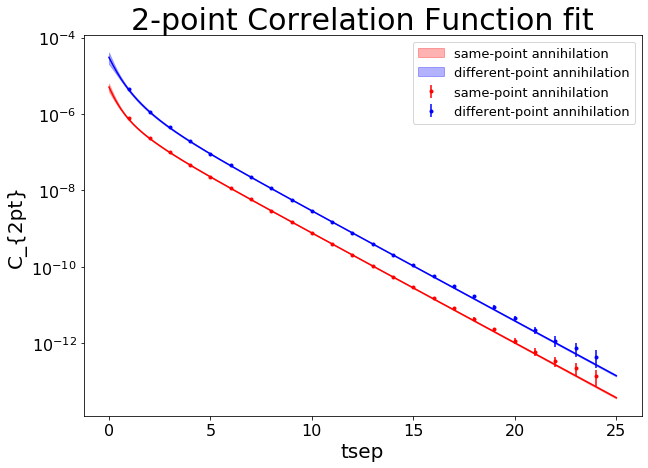

<Figure size 432x288 with 0 Axes>

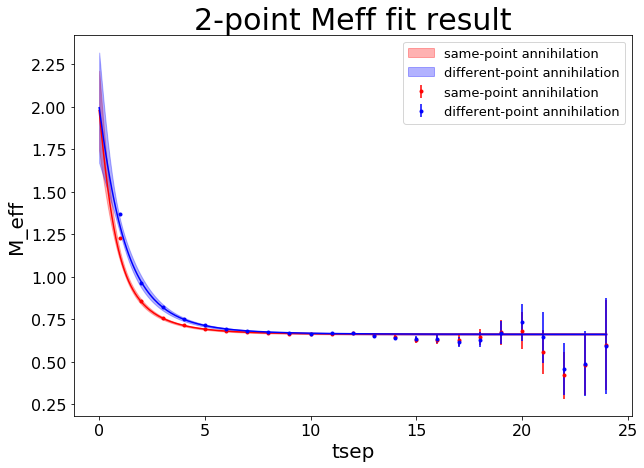

<Figure size 432x288 with 0 Axes>

In [63]:

# Plot the fits


t_plot = np.array([i for i in range(1, 25)])
x_raw2pt = np.array([t_plot, t_plot])
y_raw2pt_mean = np.array([[gv_avg_data['2pt_SS'][i].mean for i in t_plot], [gv_avg_data['2pt_PS'][i].mean for i in t_plot]])
y_raw2pt_sdev = np.array([[gv_avg_data['2pt_SS'][i].sdev for i in t_plot], [gv_avg_data['2pt_PS'][i].sdev for i in t_plot]])
y_2ptmeff_mean = np.array([[gv_avg_data['2pt_SS_meff'][i].mean for i in t_plot], [gv_avg_data['2pt_PS_meff'][i].mean for i in t_plot]])
y_2ptmeff_sdev = np.array([[gv_avg_data['2pt_SS_meff'][i].sdev for i in t_plot], [gv_avg_data['2pt_PS_meff'][i].sdev for i in t_plot]])

x_raw2pt_fit = np.array([tsep_model, tsep_model])
y_raw2pt_fit_mean = np.array([C2ptSS_model_mean, C2ptPS_model_mean])
y_raw2pt_fit_upper = np.array([C2ptSS_model_upbound, C2ptPS_model_upbound])
y_raw2pt_fit_lower = np.array([C2ptSS_model_lowbound, C2ptPS_model_lowbound])
h5_dm.fit_data_plot("2-point Correlation Function fit", "tsep", "C_{2pt}", x_raw2pt, y_raw2pt_mean, x_raw2pt_fit, y_raw2pt_fit_mean, y_raw2pt_fit_upper, y_raw2pt_fit_lower, ['red', 'blue'], 30, 20, 16, 13, ylim = None, nplots = 2, ydat_error = y_raw2pt_sdev, datalabels = ["same-point annihilation", "different-point annihilation"], fitlabels = ["same-point annihilation", "different-point annihilation"], logy = True)

y_2ptmeff_fit_mean = np.array([SS_meff_model_mean, PS_meff_model_mean])
y_2ptmeff_fit_upper = np.array([SS_meff_model_upbound, PS_meff_model_upbound])
y_2ptmeff_fit_lower = np.array([SS_meff_model_lowbound, PS_meff_model_lowbound])

#print(np.shape(x_raw2pt))
#print(np.shape(y_2ptmeff_mean))
#print(np.shape(x_raw2pt_fit[:,:-step_up]))
#print(np.shape(y_2ptmeff_fit_mean))
#print(np.shape(y_2ptmeff_fit_upper))
#print(np.shape(y_2ptmeff_fit_lower))
#print(np.shape(y_2ptmeff_sdev))

h5_dm.fit_data_plot("2-point Meff fit result", "tsep", "M_eff", x_raw2pt, y_2ptmeff_mean, x_raw2pt_fit[:,:-step_up], y_2ptmeff_fit_mean, y_2ptmeff_fit_upper, y_2ptmeff_fit_lower, ['red', 'blue'], 30, 20, 16, 13, ylim = None, nplots = 2, ydat_error = y_2ptmeff_sdev, datalabels = ["same-point annihilation", "different-point annihilation"], fitlabels = ["same-point annihilation", "different-point annihilation"])

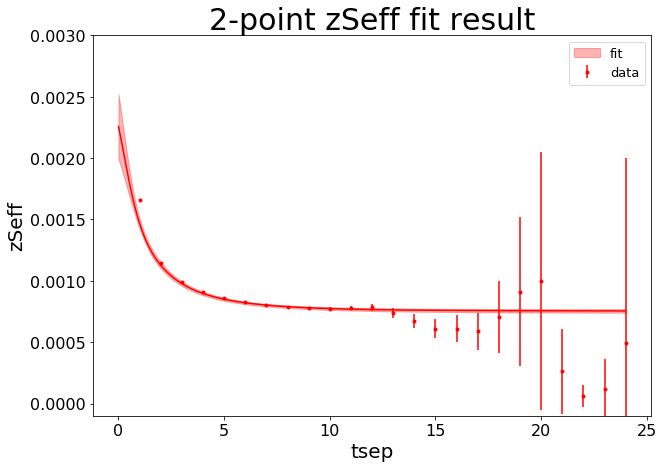

<Figure size 432x288 with 0 Axes>

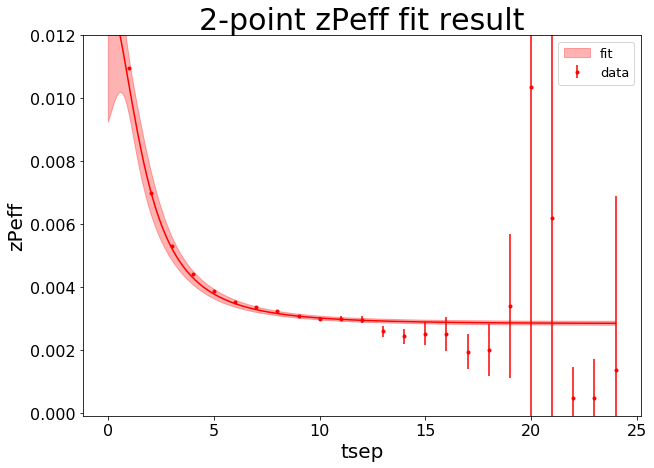

<Figure size 432x288 with 0 Axes>

In [64]:
h5_dm.fit_data_plot("2-point zSeff fit result", "tsep", "zSeff", x_raw2pt[0], [gv_avg_data['2pt_zSeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zSeff_model_mean, zSeff_model_upbound, zSeff_model_lowbound, "red", 30, 20, 16, 13, ylim=[-0.0001, 0.003], ydat_error = [gv_avg_data['2pt_zSeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit")
h5_dm.fit_data_plot("2-point zPeff fit result", "tsep", "zPeff", x_raw2pt[1], [gv_avg_data['2pt_zPeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zPeff_model_mean, zPeff_model_upbound, zPeff_model_lowbound, "red", 30, 20, 16, 13, ylim=[-0.0001, 0.012], ydat_error = [gv_avg_data['2pt_zPeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit")

In [65]:
# Now, plot out the 3-point function
# First, create the x, y, and z values
x_3pt = np.array([[j - (i+3)/2. for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].mean for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_A3_err = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4 = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].mean for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4_err = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])

legendlabels_3pt = np.array(["tsep = {}".format(i) for i in tsep_vals])

# set the array of tsep, tau pairs
tau_step = 10

# Create 2-d and 1-d versions of the 3-point (tsep, tau) pairs
t_3pt_fitresult_2d = np.array([ np.array([ [tsep, tau] for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])
t_3pt_fitresult_tsep = np.zeros(np.sum(np.array([len(np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)) for tsep in tsep_vals])))
t_3pt_fitresult_tau = np.zeros(np.sum(np.array([len(np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)) for tsep in tsep_vals])))

k = 0
for tsep in tsep_vals:
    for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1):
        t_3pt_fitresult_tsep[k] = tsep
        t_3pt_fitresult_tau[k] = tau
        k += 1
        
t_3pt_fitresult_1d = np.transpose(np.array([t_3pt_fitresult_tsep, t_3pt_fitresult_tau]))

# Now, calculate gA3 and gA4

model_A3_3pt_1d = C_3pt_A3(t_3pt_fitresult_1d, post_3pt)
model_V4_3pt_1d = C_3pt_V4(t_3pt_fitresult_1d, post_3pt)

# Convert to 2d
model_A3_3pt_2d = convert_1dto2d(t_3pt_fitresult_1d, t_3pt_fitresult_2d, model_A3_3pt_1d)
model_V4_3pt_2d = convert_1dto2d(t_3pt_fitresult_1d, t_3pt_fitresult_2d, model_V4_3pt_1d)

# Now, take the ratio, first take the respective 2-point function

model_ratio_2pt = C_2pt_SS(tsep_vals, post_3pt)

model_A3_ratio_2d = np.array([ np.array([ model_A3_3pt_2d[i][j]/model_ratio_2pt[i] for j in range(len(model_A3_3pt_2d[i]))]) for i in range(len(model_A3_3pt_2d))])
model_V4_ratio_2d = np.array([ np.array([ model_V4_3pt_2d[i][j]/model_ratio_2pt[i] for j in range(len(model_V4_3pt_2d[i]))]) for i in range(len(model_V4_3pt_2d))])

# Now, to prepare for plotting, split the data into mean, upper-bound and lower-bound
model_A3_ratio_2d_mean = np.array([ [ model_A3_ratio_2d[i][j].mean for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])
model_A3_ratio_2d_upbound = np.array([ [ model_A3_ratio_2d[i][j].mean + model_A3_ratio_2d[i][j].sdev for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])
model_A3_ratio_2d_lowbound = np.array([ [ model_A3_ratio_2d[i][j].mean - model_A3_ratio_2d[i][j].sdev for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])

model_V4_ratio_2d_mean = np.array([ [ model_V4_ratio_2d[i][j].mean for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])
model_V4_ratio_2d_upbound = np.array([ [ model_V4_ratio_2d[i][j].mean + model_V4_ratio_2d[i][j].sdev for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])
model_V4_ratio_2d_lowbound = np.array([ [ model_V4_ratio_2d[i][j].mean - model_V4_ratio_2d[i][j].sdev for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])

# Also, convert the 2-d tsep, tau array into an array of tau - tsep/2
t_3pt_tseptau_diff = np.array([ np.array([tau - tsep/2. for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])

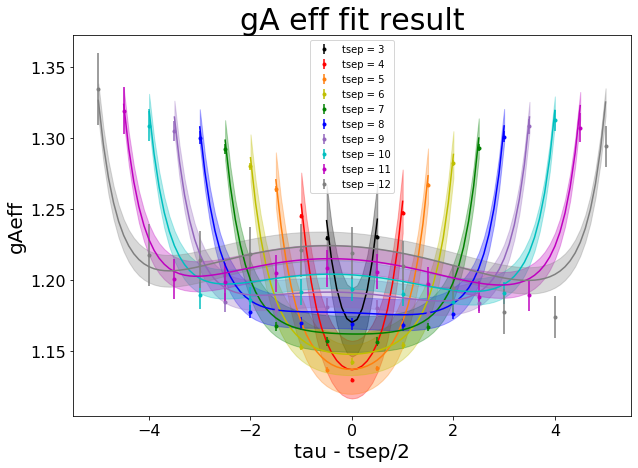

<Figure size 432x288 with 0 Axes>

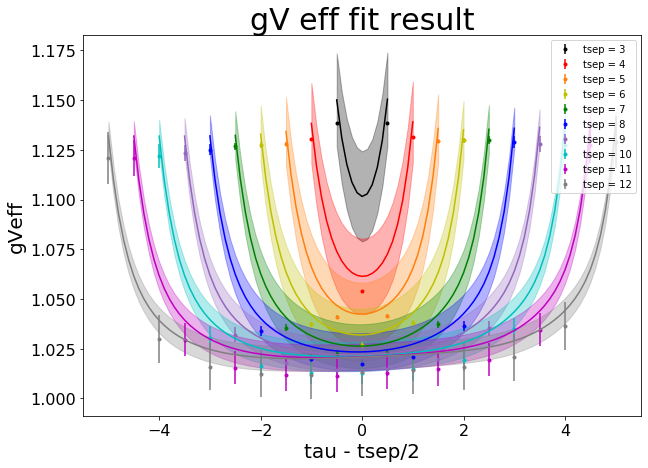

<Figure size 432x288 with 0 Axes>

In [66]:
# The color pallete for plotting the 3-point correlation function
colors_3pt = np.array(['k', 'r', 'tab:orange', 'y', 'g', 'b', 'tab:purple', 'c', 'm', 'tab:grey'])

# The raw dataset fitted to
x_3pt = np.array([[j - (i+3)/2. for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].mean for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_A3_err = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4 = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].mean for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4_err = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])

h5_dm.fit_data_plot("gA eff fit result", "tau - tsep/2", "gAeff", x_3pt, y_3pt_A3, t_3pt_tseptau_diff, model_A3_ratio_2d_mean, model_A3_ratio_2d_upbound, model_A3_ratio_2d_lowbound, colors_3pt, 30, 20, 16, 13, nplots = len(gv_avg_data['C_ratio_A3']), ydat_error=y_3pt_A3_err, datalabels = legendlabels_3pt) 
h5_dm.fit_data_plot("gV eff fit result", "tau - tsep/2", "gVeff", x_3pt, y_3pt_V4, t_3pt_tseptau_diff, model_V4_ratio_2d_mean, model_V4_ratio_2d_upbound, model_V4_ratio_2d_lowbound, colors_3pt, 30, 20, 16, 13, nplots = len(gv_avg_data['C_ratio_V4']), ydat_error=y_3pt_V4_err, datalabels = legendlabels_3pt) 



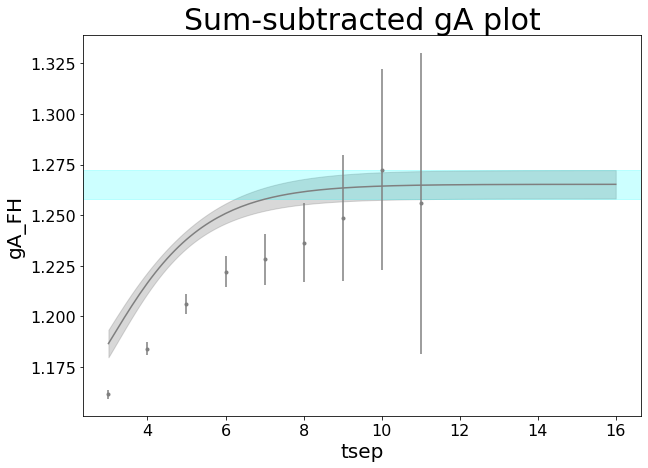

<Figure size 432x288 with 0 Axes>

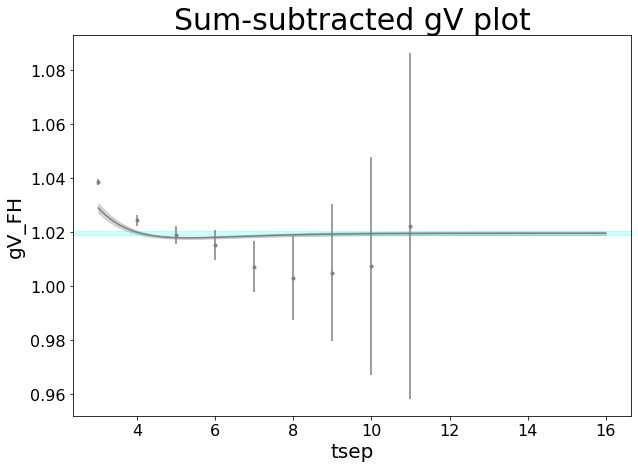

<Figure size 432x288 with 0 Axes>

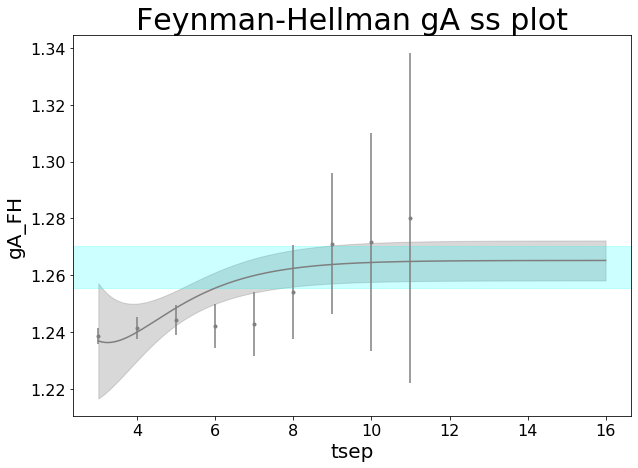

<Figure size 432x288 with 0 Axes>

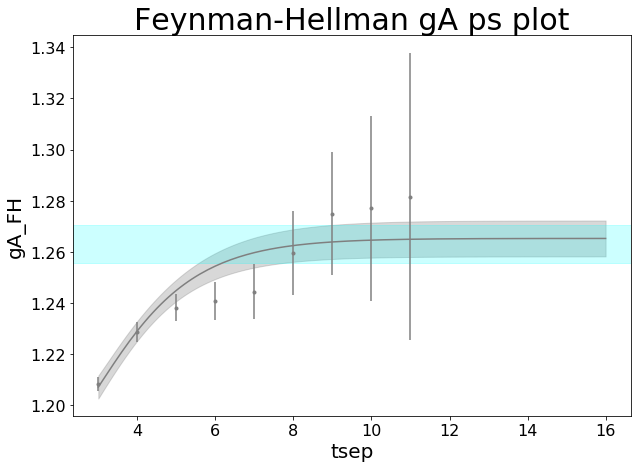

<Figure size 432x288 with 0 Axes>

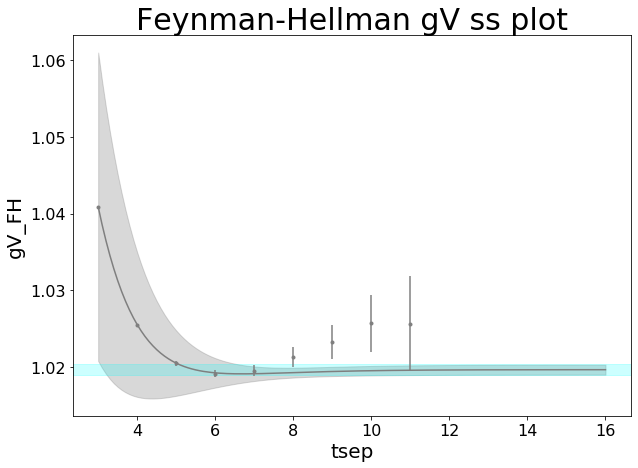

<Figure size 432x288 with 0 Axes>

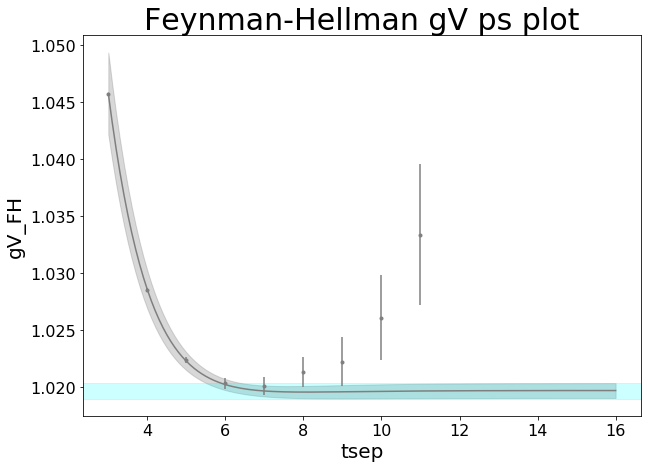

<Figure size 432x288 with 0 Axes>

In [67]:
# And finally, plot the sum-subtracted fit functions
step_FH = 10

# Set up the fit plotting
t_FH_model = np.linspace(tsep_vals[0], tsep_vals[-1]+4, (tsep_vals[-1]+4 - tsep_vals[0])*step_FH + 1)

CFH_A3_model = C_FH_A3(t_FH_model, post_3pt)
CFH_V4_model = C_FH_V4(t_FH_model, post_3pt)

CFH_A3_model_mean = np.array([CFH_A3_model[i].mean for i in range(len(CFH_A3_model))])
CFH_A3_model_upbound = np.array([CFH_A3_model[i].mean + CFH_A3_model[i].sdev for i in range(len(CFH_A3_model))])
CFH_A3_model_lowbound = np.array([CFH_A3_model[i].mean - CFH_A3_model[i].sdev for i in range(len(CFH_A3_model))])
CFH_V4_model_mean = np.array([CFH_V4_model[i].mean for i in range(len(CFH_V4_model))])
CFH_V4_model_upbound = np.array([CFH_V4_model[i].mean + CFH_V4_model[i].sdev for i in range(len(CFH_V4_model))])
CFH_V4_model_lowbound = np.array([CFH_V4_model[i].mean - CFH_V4_model[i].sdev for i in range(len(CFH_V4_model))])

# Set up the raw data plotting
x_CFH = np.array([i for i in tsep_vals[:-1] ])
y_CFH_A3 = np.array([gv_avg_data['C^FH_A3'][i].mean for i in range(len(tsep_vals)-1)])
y_CFH_A3_err = np.array([gv_avg_data['C^FH_A3'][i].sdev for i in range(len(tsep_vals)-1)])
y_CFH_V4 = np.array([gv_avg_data['C^FH_V4'][i].mean for i in range(len(tsep_vals)-1)])
y_CFH_V4_err = np.array([gv_avg_data['C^FH_V4'][i].sdev for i in range(len(tsep_vals)-1)])

h5_dm.fit_data_plot("Sum-subtracted gA plot", "tsep", "gA_FH", x_CFH, y_CFH_A3, t_FH_model, CFH_A3_model_mean, CFH_A3_model_upbound, CFH_A3_model_lowbound, "tab:grey", 30, 20, 16, 13, g00 = post_3pt['gA3_00'], ydat_error=y_CFH_A3_err) 
h5_dm.fit_data_plot("Sum-subtracted gV plot", "tsep", "gV_FH", x_CFH, y_CFH_V4, t_FH_model, CFH_V4_model_mean, CFH_V4_model_upbound, CFH_V4_model_lowbound, "tab:grey", 30, 20, 16, 13, g00 = post_3pt['gV4_00'], ydat_error=y_CFH_V4_err)

step_FH = 10

# Set up the fit plotting
t_FH_model = np.linspace(tsep_vals[0], tsep_vals[-1]+4, (tsep_vals[-1]+4 - tsep_vals[0])*step_FH + 1)


#CFH_A3_model = C_FH_A3(t_FH_model, post_CFHV4)
#CFH_V4_model = C_FH_V4(t_FH_model, post_CFHV4)
FH_A3_ss_model = C_FHdata_A3_ss(t_FH_model, post_3pt)
FH_A3_ps_model = C_FHdata_A3_ps(t_FH_model, post_3pt)
FH_V4_ss_model = C_FHdata_V4_ss(t_FH_model, post_3pt)
FH_V4_ps_model = C_FHdata_V4_ps(t_FH_model, post_3pt)

FH_A3_ss_model_mean = np.array([FH_A3_ss_model[i].mean for i in range(len(FH_A3_ss_model))])
FH_A3_ss_model_upbound = np.array([FH_A3_ss_model[i].mean + FH_A3_ss_model[i].sdev for i in range(len(FH_A3_ss_model))])
FH_A3_ss_model_lowbound = np.array([FH_A3_ss_model[i].mean - FH_A3_ss_model[i].sdev for i in range(len(FH_A3_ss_model))])
FH_A3_ps_model_mean = np.array([FH_A3_ps_model[i].mean for i in range(len(FH_A3_ps_model))])
FH_A3_ps_model_upbound = np.array([FH_A3_ps_model[i].mean + FH_A3_ps_model[i].sdev for i in range(len(FH_A3_ps_model))])
FH_A3_ps_model_lowbound = np.array([FH_A3_ps_model[i].mean - FH_A3_ps_model[i].sdev for i in range(len(FH_A3_ps_model))])
FH_V4_ss_model_mean = np.array([FH_V4_ss_model[i].mean for i in range(len(FH_V4_ss_model))])
FH_V4_ss_model_upbound = np.array([FH_V4_ss_model[i].mean + FH_V4_ss_model[i].sdev for i in range(len(FH_V4_ss_model))])
FH_V4_ss_model_lowbound = np.array([FH_V4_ss_model[i].mean - FH_V4_ss_model[i].sdev for i in range(len(FH_V4_ss_model))])
FH_V4_ps_model_mean = np.array([FH_V4_ps_model[i].mean for i in range(len(FH_V4_ps_model))])
FH_V4_ps_model_upbound = np.array([FH_V4_ps_model[i].mean + FH_V4_ps_model[i].sdev for i in range(len(FH_V4_ps_model))])
FH_V4_ps_model_lowbound = np.array([FH_V4_ps_model[i].mean - FH_V4_ps_model[i].sdev for i in range(len(FH_V4_ps_model))])

# Set up the raw data plotting
x_FHdata = np.array([i for i in tsep_vals[:-1] ])
y_FHdata_A3_ss = np.array([gv_avg_data['FH'][i][0].mean for i in range(np.min(tsep_vals), np.max(tsep_vals))])
y_FHdata_A3_ss_err = np.array([gv_avg_data['FH'][i][0].sdev for i in range(np.min(tsep_vals), np.max(tsep_vals))])
y_FHdata_A3_ps = np.array([gv_avg_data['FH'][i][1].mean for i in range(np.min(tsep_vals), np.max(tsep_vals))])
y_FHdata_A3_ps_err = np.array([gv_avg_data['FH'][i][1].sdev for i in range(np.min(tsep_vals), np.max(tsep_vals))])
y_FHdata_V4_ss = np.array([gv_avg_data['FH'][i][2].mean for i in range(np.min(tsep_vals), np.max(tsep_vals))])
y_FHdata_V4_ss_err = np.array([gv_avg_data['FH'][i][2].sdev for i in range(np.min(tsep_vals), np.max(tsep_vals))])
y_FHdata_V4_ps = np.array([gv_avg_data['FH'][i][3].mean for i in range(np.min(tsep_vals), np.max(tsep_vals))])
y_FHdata_V4_ps_err = np.array([gv_avg_data['FH'][i][3].sdev for i in range(np.min(tsep_vals), np.max(tsep_vals))])

#h5_dm.fit_data_plot("Feynman-Hellman gA plot", "tsep", "gA_FH", x_CFH, y_CFH_A3, t_FH_model, CFH_A3_model_mean, CFH_A3_model_upbound, CFH_A3_model_lowbound, "tab:grey", 30, 20, 16, 13, g00 = post_CFHV4['gA3_00'], ydat_error=y_CFH_A3_err) 
#h5_dm.fit_data_plot("Feynman-Hellman gV plot", "tsep", "gV_FH", x_CFH, y_CFH_V4, t_FH_model, CFH_V4_model_mean, CFH_V4_model_upbound, CFH_V4_model_lowbound, "tab:grey", 30, 20, 16, 13, g00 = post_CFHV4['gV4_00'], ydat_error=y_CFH_V4_err)

h5_dm.fit_data_plot("Feynman-Hellman gA ss plot", "tsep", "gA_FH", x_FHdata, y_FHdata_A3_ss, t_FH_model, FH_A3_ss_model_mean, FH_A3_ss_model_upbound, FH_A3_ss_model_lowbound, "tab:grey", 30, 20, 16, 13, g00 = post_FHdata['gA3_00'], ydat_error=y_FHdata_A3_ss_err) 
h5_dm.fit_data_plot("Feynman-Hellman gA ps plot", "tsep", "gA_FH", x_FHdata, y_FHdata_A3_ps, t_FH_model, FH_A3_ps_model_mean, FH_A3_ps_model_upbound, FH_A3_ps_model_lowbound, "tab:grey", 30, 20, 16, 13, g00 = post_FHdata['gA3_00'], ydat_error=y_FHdata_A3_ps_err) 
h5_dm.fit_data_plot("Feynman-Hellman gV ss plot", "tsep", "gV_FH", x_FHdata, y_FHdata_V4_ss, t_FH_model, FH_V4_ss_model_mean, FH_V4_ss_model_upbound, FH_V4_ss_model_lowbound, "tab:grey", 30, 20, 16, 13, g00 = post_FHdata['gV4_00'], ydat_error=y_FHdata_V4_ss_err)
h5_dm.fit_data_plot("Feynman-Hellman gV ps plot", "tsep", "gV_FH", x_FHdata, y_FHdata_V4_ps, t_FH_model, FH_V4_ps_model_mean, FH_V4_ps_model_upbound, FH_V4_ps_model_lowbound, "tab:grey", 30, 20, 16, 13, g00 = post_FHdata['gV4_00'], ydat_error=y_FHdata_V4_ps_err)

### gA_00 = 1.23 +/- 0.01 ; gV_00 = 1.019 +/- 0.002 


### Now, try again, but with a 3 point with tau 2

In [68]:
num_zs = 4
num_states_FH = 3


# prior the fits
prior_2ptstep = gv.BufferDict()

# This is the exponent e_decay_exp such that the increment between two consecutive excited state energies decays as 1/n^e_decay_exp, where n is the order of the excited state energy 
e_decay_exp = 0

prior_2ptstep['E0'] = gv.gvar(0.67, 0.02)
prior_2ptstep['Z0'] = gv.gvar(0.0008, 0.0003)
prior_2ptstep['Ztilde0'] = gv.gvar(0.003, 0.003)

#prior_2ptstep['E1'] = gv.gvar(1.3, 0.23)
#prior_2ptstep['log(E1)'] = gv.gvar(np.log(1.3), np.log(1.3/(1.3 - 0.3)))
#prior_2ptstep['Z1'] = gv.gvar(0.0012, 0.0006)
#prior_2ptstep['Ztilde1'] = gv.gvar(0.006, 0.005)

# Define some constants for prioring the higher-order energies
dE0 = 2*mpi
b = 0.7

# Use constant dE to prior the energies
dE0 = 2*mpi
energyvals = np.array([None]*num_zs)
dEvals = np.array([None]*(num_zs - 1))

#E0_errbar = 0.8
energyvals[0] = gv.gvar(0.67, 0.02)
for k in range(1, num_zs):
    dEvals[k-1] = dE0/np.power(k, e_decay_exp)
    energyvals[k] = energyvals[k-1] + dEvals[k-1]

for n in range(1, num_zs):
    prior_2ptstep['log(dE{})'.format(n)] = gv.gvar(np.log(dEvals[n-1]), b)
    prior_2ptstep['Z{}'.format(n)] = gv.gvar(0.0012, 0.0006)
    prior_2ptstep['Ztilde{}'.format(n)] = gv.gvar(0, 0.01)
    
    # Insert priors for energy here
    #dE_next = dE0/np.power(n, e_decay_exp)
    #E_next = prior_2ptstep['E{}'.format(n-1)].mean + dE_next
    #sigma_next = np.log(E_next/(E_next - (dE_next*b)))

print(num_states_FH - 2)

for n in range(num_zs):
    prior_2ptstep["d_gA_ss_{}".format(n)] = gv.gvar(0,0.00001)
    prior_2ptstep["d_gA_ps_{}".format(n)] = gv.gvar(0,0.00001)
    prior_2ptstep["d_gV_ss_{}".format(n)] = gv.gvar(0,0.00001)
    prior_2ptstep["d_gV_ps_{}".format(n)] = gv.gvar(0,0.00001)
    for m in range(num_zs):
        
        prior_2ptstep['gA3_{0}{1}'.format(n, m)] = gv.gvar(0, 2)
        if n == m and n < num_zs-1:
            prior_2ptstep['gV4_{0}{1}'.format(n, m)] = gv.gvar(1, 0.1)
        else:
            prior_2ptstep['gV4_{0}{1}'.format(n, m)] = gv.gvar(0, 2)

prior_2ptstep['gA3_00'] = gv.gvar(1.25, 0.15)
prior_2ptstep['gV4_00'] = gv.gvar(1.07, 0.07)

# Set the "garbage can" for the Feynman Hellman fit, post-Lattice-QCD stage
prior_2ptstep['Z_FHmax'] = gv.gvar(0.0012, 0.0006)
prior_2ptstep['Ztilde_FHmax'] = gv.gvar(0, 0.01)
prior_2ptstep['log(FH_dEmax)'] = gv.gvar(np.log(dEvals[num_states_FH - 2]), b) 

for n in range(num_states_FH-1):
    prior_2ptstep['gA3_FHmax{}'.format(n)] = gv.gvar(0, 2)
    prior_2ptstep['gA3_{}FHmax'.format(n)] = gv.gvar(0, 2)
    prior_2ptstep['gV4_FHmax{}'.format(n)] = gv.gvar(0, 2)
    prior_2ptstep['gV4_{}FHmax'.format(n)] = gv.gvar(0, 2)
    
prior_2ptstep['gA3_FHmaxFHmax'] = gv.gvar(0, 2)
prior_2ptstep['gV4_FHmaxFHmax'] = gv.gvar(0, 2)

# Set the "garbage can" for the Feynman Hellman fit, Lattice-QCD stage
#prior_2ptstep['Z_FHdatamax'] = gv.gvar(0.0012, 0.0006)
#prior_2ptstep['Ztilde_FHdatamax'] = gv.gvar(0, 0.01)
#prior_2ptstep['log(FHdata_dEmax)'] = gv.gvar(np.log(dEvals[num_states_FH - 2]), b) 

#for n in range(num_states_FH-1):
    #prior_2ptstep['gA3_FHdatamax{}'.format(n)] = gv.gvar(1, 2)
    #prior_2ptstep['gA3_{}FHdatamax'.format(n)] = gv.gvar(1, 2)
    #prior_2ptstep['gV4_FHdatamax{}'.format(n)] = gv.gvar(0, 2)
    #prior_2ptstep['gV4_{}FHdatamax'.format(n)] = gv.gvar(0, 2)
    
#prior_2ptstep['gA3_FHdatamaxFHdatamax'] = gv.gvar(1, 2)
#prior_2ptstep['gV4_FHdatamaxFHdatamax'] = gv.gvar(0, 2)



1


In [69]:
# 2-point fit
fit_2pt = lsqfit.nonlinear_fit(data=(np.array([l for l in range(2, 13)]), np.array([[ [c] for c in gv_avg_data['2pt'][l]] for l in range(2,13)]) ), prior=prior_2ptstep,fcn=C_2pt,debug=True)
print(fit_2pt.format(pstyle='vv'))
post_2pt = fit_2pt.p

Least Square Fit:
  chi2/dof [dof] = 0.85 [22]    Q = 0.67    logGBF = 484.64

Parameters:
             E0       0.661027 +- 0.00280207             [     0.67 +- 0.02 ]  
             Z0   0.000756981 +- 1.03675e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.00286124 +- 4.6968e-05             [   0.003 +- 0.003 ]  
       log(dE1)          -0.8113 +- 0.135657             [  -0.97551 +- 0.7 ]  
             Z1   0.000662449 +- 9.46282e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1    0.00448214 +- 0.000764342             [        0 +- 0.01 ]  
       log(dE2)        -0.516866 +- 0.438609             [  -0.97551 +- 0.7 ]  
             Z2    0.000799852 +- 0.00040447             [ 0.0012 +- 0.0006 ]  
        Ztilde2       0.0059393 +- 0.0030705             [        0 +- 0.01 ]  
       log(dE3)         -0.526875 +- 0.58489             [  -0.97551 +- 0.7 ]  
             Z3    0.00118014 +- 0.000236461             [ 0.0012 +- 0.0006 ]  
        Ztilde3      0.008748

In [70]:
# pickle output params of the 2-point fit, then set the next prior, prior_3pt_A3step
#current_posterior = open('2pt_FH_3pt_stage2pt.obj', 'wb')
#pickle.dump(post_2pt, current_posterior)
#current_posterior.close()

In [71]:
#next_priors = open('2pt_FH_3pt_stage2pt.obj', 'rb')
#prior_CFH = pickle.load(next_priors)
#next_priors.close()

In [72]:
fit_CFH = lsqfit.nonlinear_fit(data=(np.array([l for l in tsep_vals[:-1]]), np.array([gv_avg_data['C^FH_combined'][l] for l in range(len(tsep_vals[:-1]))])), prior=post_2pt,fcn=C_FH,debug=True)
print(fit_CFH.format(pstyle='vv'))
post_CFH = fit_CFH.p

Least Square Fit:
  chi2/dof [dof] = 0.31 [18]    Q = 1    logGBF = 44.144

Parameters:
             E0       0.661091 +- 0.00275206             [     0.661027 +- 0.00280207 ]  
             Z0   0.000757305 +- 1.01856e-05             [ 0.000756981 +- 1.03675e-05 ]  
        Ztilde0     0.00286243 +- 4.6139e-05             [   0.00286124 +- 4.6968e-05 ]  
       log(dE1)         -0.80737 +- 0.133738             [        -0.8113 +- 0.135657 ]  
             Z1   0.000661284 +- 9.38685e-05             [ 0.000662449 +- 9.46282e-05 ]  
        Ztilde1    0.00449941 +- 0.000754815             [  0.00448214 +- 0.000764342 ]  
       log(dE2)        -0.523628 +- 0.437582             [      -0.516866 +- 0.438609 ]  
             Z2   0.000801401 +- 0.000404353             [  0.000799852 +- 0.00040447 ]  
        Ztilde2     0.00586376 +- 0.00306865             [     0.0059393 +- 0.0030705 ]  
       log(dE3)          -0.533188 +- 0.5827             [       -0.526875 +- 0.58489 ]  
            

In [73]:
# Feynman-Hellman fit
fit_FHdata = lsqfit.nonlinear_fit(data=(np.array([l for l in tsep_vals[:-1]]), np.array([gv_avg_data['FH'][l] for l in range(np.min(tsep_vals), np.max(tsep_vals))])), prior=post_CFH,fcn=C_FHdata, debug=True)
print(fit_FHdata.format(pstyle='vv'))
post_FHdata = fit_FHdata.p

Least Square Fit:
  chi2/dof [dof] = 0.74 [36]    Q = 0.88    logGBF = 126.48

Parameters:
             E0        0.661157 +- 0.00264905             [     0.661091 +- 0.00275206 ]  
             Z0    0.000757713 +- 9.69472e-06             [ 0.000757305 +- 1.01856e-05 ]  
        Ztilde0     0.00286329 +- 4.34513e-05             [   0.00286243 +- 4.6139e-05 ]  
       log(dE1)         -0.809536 +- 0.120423             [       -0.80737 +- 0.133738 ]  
             Z1    0.000654784 +- 8.73868e-05             [ 0.000661284 +- 9.38685e-05 ]  
        Ztilde1     0.00448343 +- 0.000690025             [  0.00449941 +- 0.000754815 ]  
       log(dE2)         -0.545765 +- 0.432264             [      -0.523628 +- 0.437582 ]  
             Z2     0.00080496 +- 0.000404076             [ 0.000801401 +- 0.000404353 ]  
        Ztilde2      0.00574785 +- 0.00306136             [   0.00586376 +- 0.00306865 ]  
       log(dE3)           -0.4956 +- 0.570344             [        -0.533188 +- 0.5827 ]  

In [74]:
#next_priors = open('2pt_FH_3pt_stageFH.obj', 'rb')
#prior_3pt = pickle.load(next_priors)
#next_priors.close()

In [75]:
tau_cut_val = 2
y_3pt_A3_2d = np.array([ [gv_avg_data['3pt_A3'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_A3_2d)
y_3pt_V4_2d = np.array([ [gv_avg_data['3pt_V4'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_V4 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_V4_2d)
y_3pt = np.transpose(np.array([[y_3pt_A3], [y_3pt_V4]]), axes=[2,0,1])

# Create the dataset to be fit
x_1darray_tau2 = []
y_3pt_tau2 = []

    
for k in range(len(t_1d_array)):
    if(t_1d_array[k][0] >= 4):
        if(t_1d_array[k][1] >= tau_cut_val):
            if(t_1d_array[k][1] <= t_1d_array[k][0] - tau_cut_val):
                x_1darray_tau2.append(t_1d_array[k].tolist())
                y_3pt_tau2.append(y_3pt[k].tolist())
                            
x_1darray_tau2 = np.array(x_1darray_tau2)
y_3pt_tau2 = np.array(y_3pt_tau2)

In [76]:


fit_3pt_tau2 = lsqfit.nonlinear_fit(data=(x_1darray_tau2, y_3pt_tau2), prior=post_FHdata, fcn = C_3pt, debug = True)
print(fit_3pt_tau2.format(pstyle='vv'))
post_3pt_tau2 = fit_3pt_tau2.p

Least Square Fit:
  chi2/dof [dof] = 1.1 [90]    Q = 0.24    logGBF = 2351.5

Parameters:
             E0        0.659854 +- 0.00217711             [      0.661157 +- 0.00264905 ]  
             Z0     0.000751453 +- 7.7012e-06             [  0.000757713 +- 9.69472e-06 ]  
        Ztilde0     0.00283127 +- 3.38202e-05             [   0.00286329 +- 4.34513e-05 ]  
       log(dE1)        -0.880197 +- 0.0681413             [       -0.809536 +- 0.120423 ]  
             Z1    0.000634943 +- 4.54954e-05             [  0.000654784 +- 8.73868e-05 ]  
        Ztilde1     0.00425237 +- 0.000353947             [   0.00448343 +- 0.000690025 ]  
       log(dE2)       0.00047515 +- 0.0762327             [       -0.545765 +- 0.432264 ]  *
             Z2     0.00143417 +- 0.000169306             [   0.00080496 +- 0.000404076 ]  *
        Ztilde2       0.0105675 +- 0.00115935             [    0.00574785 +- 0.00306136 ]  *
       log(dE3)         -0.323291 +- 0.422205             [         -0.4956 +- 

In [77]:
final_posterior = open("Final(3pt)_tau2_withFH_out.obj", 'wb')
pickle.dump(post_3pt_tau2, final_posterior)
final_posterior.close()

# Also, print out the result of E0 at each stage
print("E0 = ", post_2pt['E0'], " for 2-point; E0 = ", post_CFH['E0'], " for sum-sub; E0 = ", post_FHdata['E0'], " for Feynman-Hellman; E0 = ", post_3pt_tau2['E0'], " for 3-point")

E0 =  0.6610(28)  for 2-point; E0 =  0.6611(28)  for sum-sub; E0 =  0.6612(26)  for Feynman-Hellman; E0 =  0.6599(22)  for 3-point


In [78]:
# Now, plot the fit results of the chained-fit, starting with the 2-point data
step_up = 10
t_min = 0
t_max = 25
tsep_model = np.linspace(t_min, t_max, (t_max - t_min)*step_up +1)

C2ptSS_model = C_2pt_SS(tsep_model, post_3pt_tau2)
C2ptPS_model = C_2pt_PS(tsep_model, post_3pt_tau2)

SS_meff_model = np.log(np.array([C2ptSS_model[j]/C2ptSS_model[j+step_up] for j in range(len(tsep_model[:-step_up]))]))
PS_meff_model = np.log(np.array([C2ptPS_model[j]/C2ptPS_model[j+step_up] for j in range(len(tsep_model[:-step_up]))]))

zSeff_model = np.array([np.sqrt(np.exp(SS_meff_model[t]*t/step_up)*C2ptSS_model[t]) for t in range(len(tsep_model[:-step_up]))])
zPeff_model = np.array([np.exp(PS_meff_model[t]*t/step_up)*C2ptPS_model[t]/zSeff_model[t] for t in range(len(tsep_model[:-step_up]))])

# Split the models up into mean, upper-bound, and lower-bound
C2ptSS_model_mean = np.array([C2ptSS_model[i].mean for i in range(len(C2ptSS_model))])
C2ptSS_model_upbound = np.array([C2ptSS_model[i].mean + C2ptSS_model[i].sdev for i in range(len(C2ptSS_model))])
C2ptSS_model_lowbound = np.array([C2ptSS_model[i].mean - C2ptSS_model[i].sdev for i in range(len(C2ptSS_model))])
C2ptPS_model_mean = np.array([C2ptPS_model[i].mean for i in range(len(C2ptPS_model))])
C2ptPS_model_upbound = np.array([C2ptPS_model[i].mean + C2ptPS_model[i].sdev for i in range(len(C2ptPS_model))])
C2ptPS_model_lowbound = np.array([C2ptPS_model[i].mean - C2ptPS_model[i].sdev for i in range(len(C2ptPS_model))])

SS_meff_model_mean = np.array([SS_meff_model[i].mean for i in range(len(SS_meff_model))])
SS_meff_model_upbound = np.array([SS_meff_model[i].mean + SS_meff_model[i].sdev for i in range(len(SS_meff_model))])
SS_meff_model_lowbound = np.array([SS_meff_model[i].mean - SS_meff_model[i].sdev for i in range(len(SS_meff_model))])
PS_meff_model_mean = np.array([PS_meff_model[i].mean for i in range(len(PS_meff_model))])
PS_meff_model_upbound = np.array([PS_meff_model[i].mean + PS_meff_model[i].sdev for i in range(len(PS_meff_model))])
PS_meff_model_lowbound = np.array([PS_meff_model[i].mean - PS_meff_model[i].sdev for i in range(len(PS_meff_model))])

zSeff_model_mean = np.array([zSeff_model[i].mean for i in range(len(zSeff_model))]) 
zSeff_model_upbound = np.array([zSeff_model[i].mean + zSeff_model[i].sdev for i in range(len(zSeff_model))]) 
zSeff_model_lowbound = np.array([zSeff_model[i].mean - zSeff_model[i].sdev for i in range(len(zSeff_model))])
zPeff_model_mean = np.array([zPeff_model[i].mean for i in range(len(zPeff_model))]) 
zPeff_model_upbound = np.array([zPeff_model[i].mean + zPeff_model[i].sdev for i in range(len(zPeff_model))])
zPeff_model_lowbound = np.array([zPeff_model[i].mean - zPeff_model[i].sdev for i in range(len(zPeff_model))])
#print(np.shape(zSeff_model_lowbound))

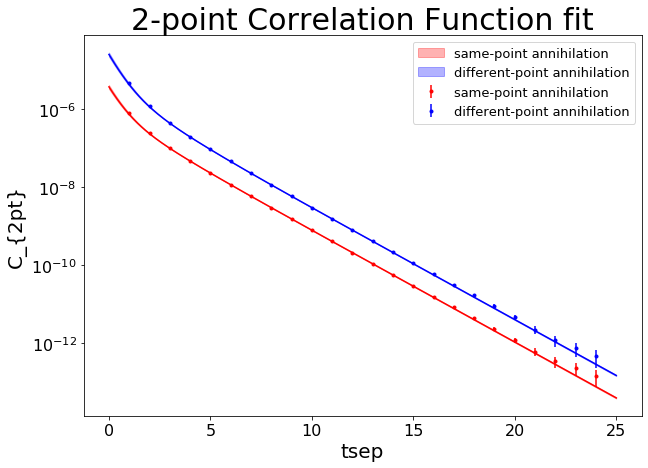

<Figure size 432x288 with 0 Axes>

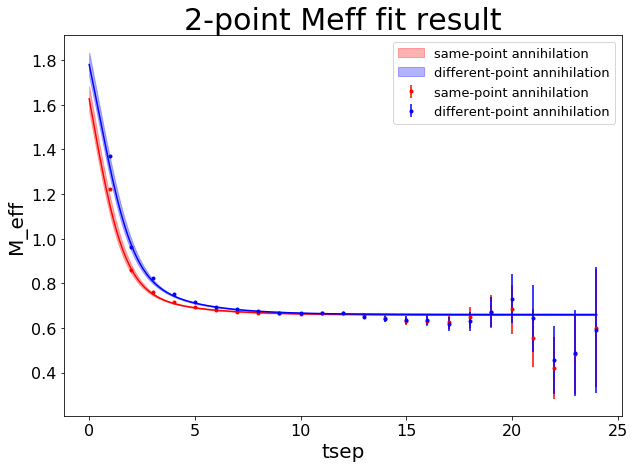

<Figure size 432x288 with 0 Axes>

In [79]:

# Plot the fits


t_plot = np.array([i for i in range(1, 25)])
x_raw2pt = np.array([t_plot, t_plot])
y_raw2pt_mean = np.array([[gv_avg_data['2pt_SS'][i].mean for i in t_plot], [gv_avg_data['2pt_PS'][i].mean for i in t_plot]])
y_raw2pt_sdev = np.array([[gv_avg_data['2pt_SS'][i].sdev for i in t_plot], [gv_avg_data['2pt_PS'][i].sdev for i in t_plot]])
y_2ptmeff_mean = np.array([[gv_avg_data['2pt_SS_meff'][i].mean for i in t_plot], [gv_avg_data['2pt_PS_meff'][i].mean for i in t_plot]])
y_2ptmeff_sdev = np.array([[gv_avg_data['2pt_SS_meff'][i].sdev for i in t_plot], [gv_avg_data['2pt_PS_meff'][i].sdev for i in t_plot]])

x_raw2pt_fit = np.array([tsep_model, tsep_model])
y_raw2pt_fit_mean = np.array([C2ptSS_model_mean, C2ptPS_model_mean])
y_raw2pt_fit_upper = np.array([C2ptSS_model_upbound, C2ptPS_model_upbound])
y_raw2pt_fit_lower = np.array([C2ptSS_model_lowbound, C2ptPS_model_lowbound])
h5_dm.fit_data_plot("2-point Correlation Function fit", "tsep", "C_{2pt}", x_raw2pt, y_raw2pt_mean, x_raw2pt_fit, y_raw2pt_fit_mean, y_raw2pt_fit_upper, y_raw2pt_fit_lower, ['red', 'blue'], 30, 20, 16, 13, ylim = None, nplots = 2, ydat_error = y_raw2pt_sdev, datalabels = ["same-point annihilation", "different-point annihilation"], fitlabels = ["same-point annihilation", "different-point annihilation"], logy = True)

y_2ptmeff_fit_mean = np.array([SS_meff_model_mean, PS_meff_model_mean])
y_2ptmeff_fit_upper = np.array([SS_meff_model_upbound, PS_meff_model_upbound])
y_2ptmeff_fit_lower = np.array([SS_meff_model_lowbound, PS_meff_model_lowbound])

#print(np.shape(x_raw2pt))
#print(np.shape(y_2ptmeff_mean))
#print(np.shape(x_raw2pt_fit[:,:-step_up]))
#print(np.shape(y_2ptmeff_fit_mean))
#print(np.shape(y_2ptmeff_fit_upper))
#print(np.shape(y_2ptmeff_fit_lower))
#print(np.shape(y_2ptmeff_sdev))

h5_dm.fit_data_plot("2-point Meff fit result", "tsep", "M_eff", x_raw2pt, y_2ptmeff_mean, x_raw2pt_fit[:,:-step_up], y_2ptmeff_fit_mean, y_2ptmeff_fit_upper, y_2ptmeff_fit_lower, ['red', 'blue'], 30, 20, 16, 13, ylim = None, nplots = 2, ydat_error = y_2ptmeff_sdev, datalabels = ["same-point annihilation", "different-point annihilation"], fitlabels = ["same-point annihilation", "different-point annihilation"])

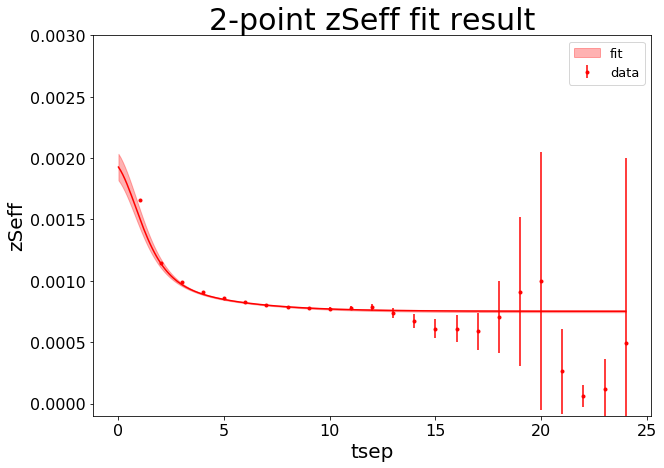

<Figure size 432x288 with 0 Axes>

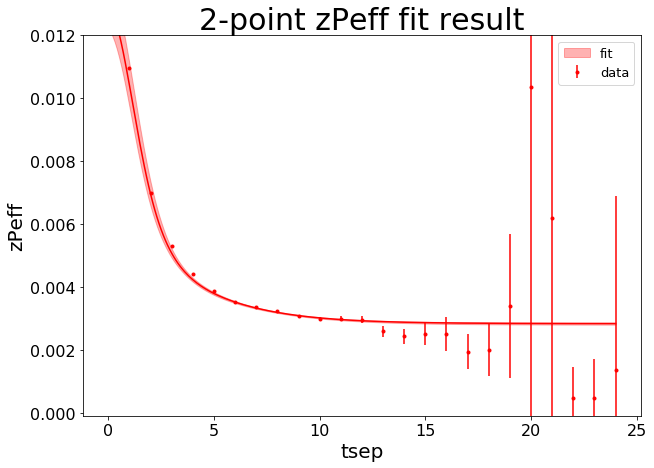

<Figure size 432x288 with 0 Axes>

In [80]:
h5_dm.fit_data_plot("2-point zSeff fit result", "tsep", "zSeff", x_raw2pt[0], [gv_avg_data['2pt_zSeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zSeff_model_mean, zSeff_model_upbound, zSeff_model_lowbound, "red", 30, 20, 16, 13, ylim=[-0.0001, 0.003], ydat_error = [gv_avg_data['2pt_zSeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit")
h5_dm.fit_data_plot("2-point zPeff fit result", "tsep", "zPeff", x_raw2pt[1], [gv_avg_data['2pt_zPeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zPeff_model_mean, zPeff_model_upbound, zPeff_model_lowbound, "red", 30, 20, 16, 13, ylim=[-0.0001, 0.012], ydat_error = [gv_avg_data['2pt_zPeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit")

In [81]:
# Now, plot out the 3-point function
# First, create the x, y, and z values
x_3pt = np.array([[j - (i+3)/2. for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].mean for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_A3_err = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4 = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].mean for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4_err = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])

legendlabels_3pt = np.array(["tsep = {}".format(i) for i in tsep_vals])

# set the array of tsep, tau pairs
tau_step = 10

# Create 2-d and 1-d versions of the 3-point (tsep, tau) pairs
t_3pt_fitresult_2d = np.array([ np.array([ [tsep, tau] for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])
t_3pt_fitresult_tsep = np.zeros(np.sum(np.array([len(np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)) for tsep in tsep_vals])))
t_3pt_fitresult_tau = np.zeros(np.sum(np.array([len(np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)) for tsep in tsep_vals])))

k = 0
for tsep in tsep_vals:
    for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1):
        t_3pt_fitresult_tsep[k] = tsep
        t_3pt_fitresult_tau[k] = tau
        k += 1
        
t_3pt_fitresult_1d = np.transpose(np.array([t_3pt_fitresult_tsep, t_3pt_fitresult_tau]))

# Now, calculate gA3 and gA4

model_A3_3pt_1d = C_3pt_A3(t_3pt_fitresult_1d, post_3pt_tau2)
model_V4_3pt_1d = C_3pt_V4(t_3pt_fitresult_1d, post_3pt_tau2)

# Convert to 2d
model_A3_3pt_2d = convert_1dto2d(t_3pt_fitresult_1d, t_3pt_fitresult_2d, model_A3_3pt_1d)
model_V4_3pt_2d = convert_1dto2d(t_3pt_fitresult_1d, t_3pt_fitresult_2d, model_V4_3pt_1d)

# Now, take the ratio, first take the respective 2-point function

model_ratio_2pt = C_2pt_SS(tsep_vals, post_3pt_tau2)

model_A3_ratio_2d = np.array([ np.array([ model_A3_3pt_2d[i][j]/model_ratio_2pt[i] for j in range(len(model_A3_3pt_2d[i]))]) for i in range(len(model_A3_3pt_2d))])
model_V4_ratio_2d = np.array([ np.array([ model_V4_3pt_2d[i][j]/model_ratio_2pt[i] for j in range(len(model_V4_3pt_2d[i]))]) for i in range(len(model_V4_3pt_2d))])

# Now, to prepare for plotting, split the data into mean, upper-bound and lower-bound
model_A3_ratio_2d_mean = np.array([ [ model_A3_ratio_2d[i][j].mean for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])
model_A3_ratio_2d_upbound = np.array([ [ model_A3_ratio_2d[i][j].mean + model_A3_ratio_2d[i][j].sdev for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])
model_A3_ratio_2d_lowbound = np.array([ [ model_A3_ratio_2d[i][j].mean - model_A3_ratio_2d[i][j].sdev for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])

model_V4_ratio_2d_mean = np.array([ [ model_V4_ratio_2d[i][j].mean for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])
model_V4_ratio_2d_upbound = np.array([ [ model_V4_ratio_2d[i][j].mean + model_V4_ratio_2d[i][j].sdev for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])
model_V4_ratio_2d_lowbound = np.array([ [ model_V4_ratio_2d[i][j].mean - model_V4_ratio_2d[i][j].sdev for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])

# Also, convert the 2-d tsep, tau array into an array of tau - tsep/2
t_3pt_tseptau_diff = np.array([ np.array([tau - tsep/2. for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])

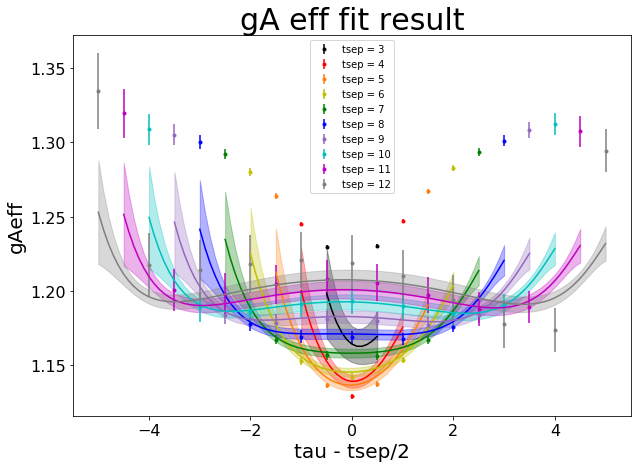

<Figure size 432x288 with 0 Axes>

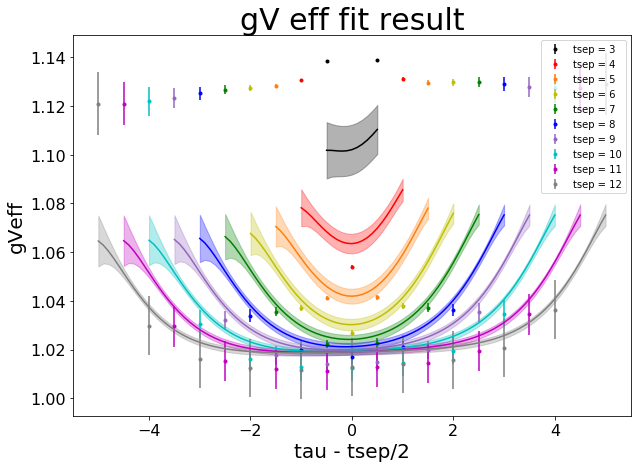

<Figure size 432x288 with 0 Axes>

In [82]:
# The color pallete for plotting the 3-point correlation function
colors_3pt = np.array(['k', 'r', 'tab:orange', 'y', 'g', 'b', 'tab:purple', 'c', 'm', 'tab:grey'])

# The raw dataset fitted to
x_3pt = np.array([[j - (i+3)/2. for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].mean for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_A3_err = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4 = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].mean for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4_err = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])

h5_dm.fit_data_plot("gA eff fit result", "tau - tsep/2", "gAeff", x_3pt, y_3pt_A3, t_3pt_tseptau_diff, model_A3_ratio_2d_mean, model_A3_ratio_2d_upbound, model_A3_ratio_2d_lowbound, colors_3pt, 30, 20, 16, 13, nplots = len(gv_avg_data['C_ratio_A3']), ydat_error=y_3pt_A3_err, datalabels = legendlabels_3pt) 
h5_dm.fit_data_plot("gV eff fit result", "tau - tsep/2", "gVeff", x_3pt, y_3pt_V4, t_3pt_tseptau_diff, model_V4_ratio_2d_mean, model_V4_ratio_2d_upbound, model_V4_ratio_2d_lowbound, colors_3pt, 30, 20, 16, 13, nplots = len(gv_avg_data['C_ratio_V4']), ydat_error=y_3pt_V4_err, datalabels = legendlabels_3pt) 



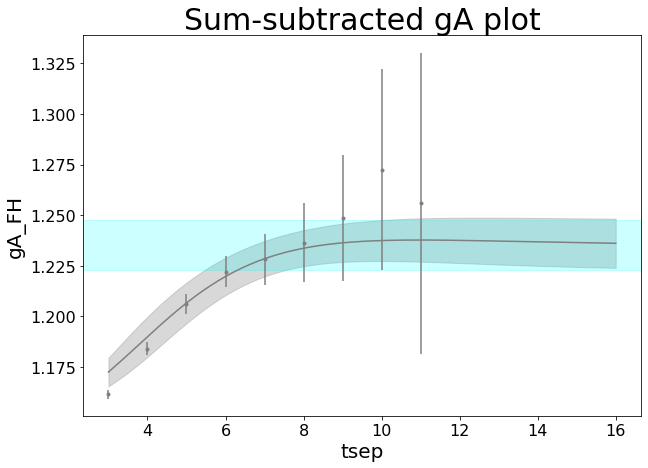

<Figure size 432x288 with 0 Axes>

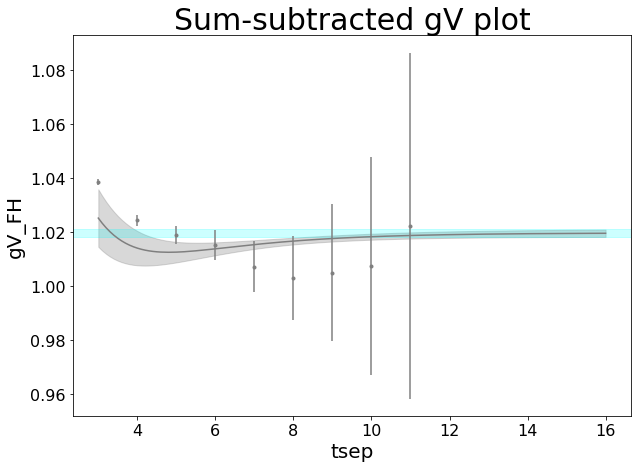

<Figure size 432x288 with 0 Axes>

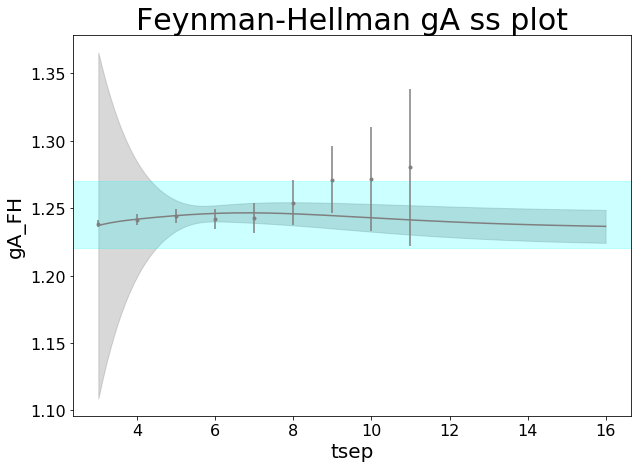

<Figure size 432x288 with 0 Axes>

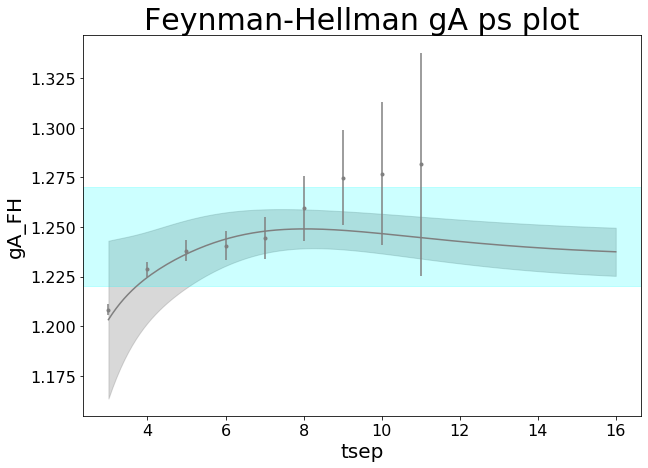

<Figure size 432x288 with 0 Axes>

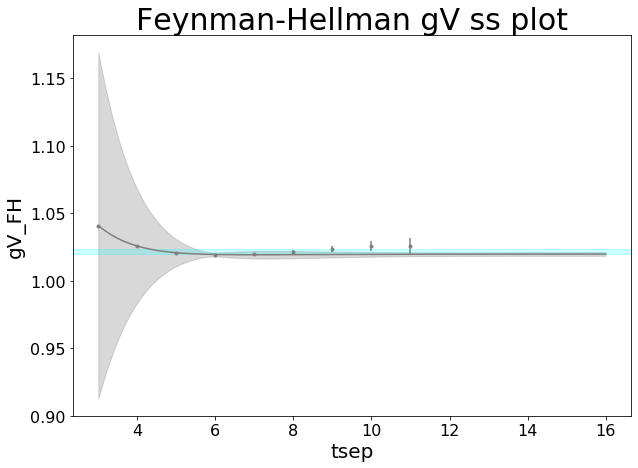

<Figure size 432x288 with 0 Axes>

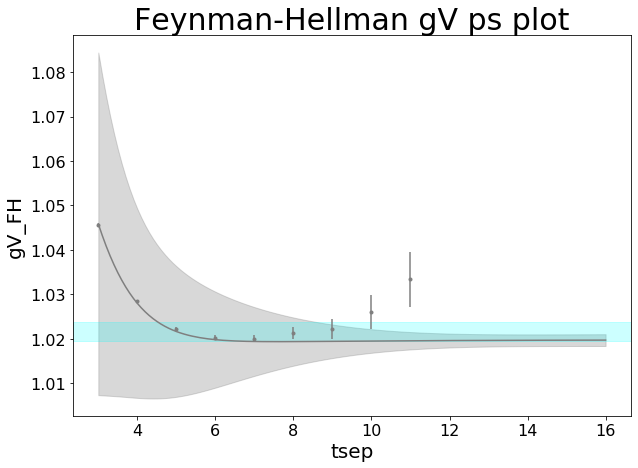

<Figure size 432x288 with 0 Axes>

In [83]:
# And finally, plot the sum-subtracted and sum-subtracted Feynman-Hellman fit functions
step_FH = 10

# Set up the fit plotting
t_FH_model = np.linspace(tsep_vals[0], tsep_vals[-1]+4, (tsep_vals[-1]+4 - tsep_vals[0])*step_FH + 1)

CFH_A3_model = C_FH_A3(t_FH_model, post_3pt_tau2)
CFH_V4_model = C_FH_V4(t_FH_model, post_3pt_tau2)

CFH_A3_model_mean = np.array([CFH_A3_model[i].mean for i in range(len(CFH_A3_model))])
CFH_A3_model_upbound = np.array([CFH_A3_model[i].mean + CFH_A3_model[i].sdev for i in range(len(CFH_A3_model))])
CFH_A3_model_lowbound = np.array([CFH_A3_model[i].mean - CFH_A3_model[i].sdev for i in range(len(CFH_A3_model))])
CFH_V4_model_mean = np.array([CFH_V4_model[i].mean for i in range(len(CFH_V4_model))])
CFH_V4_model_upbound = np.array([CFH_V4_model[i].mean + CFH_V4_model[i].sdev for i in range(len(CFH_V4_model))])
CFH_V4_model_lowbound = np.array([CFH_V4_model[i].mean - CFH_V4_model[i].sdev for i in range(len(CFH_V4_model))])

# Set up the raw data plotting
x_CFH = np.array([i for i in tsep_vals[:-1] ])
y_CFH_A3 = np.array([gv_avg_data['C^FH_A3'][i].mean for i in range(len(tsep_vals)-1)])
y_CFH_A3_err = np.array([gv_avg_data['C^FH_A3'][i].sdev for i in range(len(tsep_vals)-1)])
y_CFH_V4 = np.array([gv_avg_data['C^FH_V4'][i].mean for i in range(len(tsep_vals)-1)])
y_CFH_V4_err = np.array([gv_avg_data['C^FH_V4'][i].sdev for i in range(len(tsep_vals)-1)])

h5_dm.fit_data_plot("Sum-subtracted gA plot", "tsep", "gA_FH", x_CFH, y_CFH_A3, t_FH_model, CFH_A3_model_mean, CFH_A3_model_upbound, CFH_A3_model_lowbound, "tab:grey", 30, 20, 16, 13, g00 = post_3pt_tau2['gA3_00'], ydat_error=y_CFH_A3_err) 
h5_dm.fit_data_plot("Sum-subtracted gV plot", "tsep", "gV_FH", x_CFH, y_CFH_V4, t_FH_model, CFH_V4_model_mean, CFH_V4_model_upbound, CFH_V4_model_lowbound, "tab:grey", 30, 20, 16, 13, g00 = post_3pt_tau2['gV4_00'], ydat_error=y_CFH_V4_err)

step_FH = 10

# Set up the fit plotting
t_FH_model = np.linspace(tsep_vals[0], tsep_vals[-1]+4, (tsep_vals[-1]+4 - tsep_vals[0])*step_FH + 1)


#CFH_A3_model = C_FH_A3(t_FH_model, post_CFHV4)
#CFH_V4_model = C_FH_V4(t_FH_model, post_CFHV4)
FH_A3_ss_model = C_FHdata_A3_ss(t_FH_model, post_3pt_tau2)
FH_A3_ps_model = C_FHdata_A3_ps(t_FH_model, post_3pt_tau2)
FH_V4_ss_model = C_FHdata_V4_ss(t_FH_model, post_3pt_tau2)
FH_V4_ps_model = C_FHdata_V4_ps(t_FH_model, post_3pt_tau2)

FH_A3_ss_model_mean = np.array([FH_A3_ss_model[i].mean for i in range(len(FH_A3_ss_model))])
FH_A3_ss_model_upbound = np.array([FH_A3_ss_model[i].mean + FH_A3_ss_model[i].sdev for i in range(len(FH_A3_ss_model))])
FH_A3_ss_model_lowbound = np.array([FH_A3_ss_model[i].mean - FH_A3_ss_model[i].sdev for i in range(len(FH_A3_ss_model))])
FH_A3_ps_model_mean = np.array([FH_A3_ps_model[i].mean for i in range(len(FH_A3_ps_model))])
FH_A3_ps_model_upbound = np.array([FH_A3_ps_model[i].mean + FH_A3_ps_model[i].sdev for i in range(len(FH_A3_ps_model))])
FH_A3_ps_model_lowbound = np.array([FH_A3_ps_model[i].mean - FH_A3_ps_model[i].sdev for i in range(len(FH_A3_ps_model))])
FH_V4_ss_model_mean = np.array([FH_V4_ss_model[i].mean for i in range(len(FH_V4_ss_model))])
FH_V4_ss_model_upbound = np.array([FH_V4_ss_model[i].mean + FH_V4_ss_model[i].sdev for i in range(len(FH_V4_ss_model))])
FH_V4_ss_model_lowbound = np.array([FH_V4_ss_model[i].mean - FH_V4_ss_model[i].sdev for i in range(len(FH_V4_ss_model))])
FH_V4_ps_model_mean = np.array([FH_V4_ps_model[i].mean for i in range(len(FH_V4_ps_model))])
FH_V4_ps_model_upbound = np.array([FH_V4_ps_model[i].mean + FH_V4_ps_model[i].sdev for i in range(len(FH_V4_ps_model))])
FH_V4_ps_model_lowbound = np.array([FH_V4_ps_model[i].mean - FH_V4_ps_model[i].sdev for i in range(len(FH_V4_ps_model))])

# Set up the raw data plotting
x_FHdata = np.array([i for i in tsep_vals[:-1] ])
y_FHdata_A3_ss = np.array([gv_avg_data['FH'][i][0].mean for i in range(np.min(tsep_vals), np.max(tsep_vals))])
y_FHdata_A3_ss_err = np.array([gv_avg_data['FH'][i][0].sdev for i in range(np.min(tsep_vals), np.max(tsep_vals))])
y_FHdata_A3_ps = np.array([gv_avg_data['FH'][i][1].mean for i in range(np.min(tsep_vals), np.max(tsep_vals))])
y_FHdata_A3_ps_err = np.array([gv_avg_data['FH'][i][1].sdev for i in range(np.min(tsep_vals), np.max(tsep_vals))])
y_FHdata_V4_ss = np.array([gv_avg_data['FH'][i][2].mean for i in range(np.min(tsep_vals), np.max(tsep_vals))])
y_FHdata_V4_ss_err = np.array([gv_avg_data['FH'][i][2].sdev for i in range(np.min(tsep_vals), np.max(tsep_vals))])
y_FHdata_V4_ps = np.array([gv_avg_data['FH'][i][3].mean for i in range(np.min(tsep_vals), np.max(tsep_vals))])
y_FHdata_V4_ps_err = np.array([gv_avg_data['FH'][i][3].sdev for i in range(np.min(tsep_vals), np.max(tsep_vals))])

#h5_dm.fit_data_plot("Feynman-Hellman gA plot", "tsep", "gA_FH", x_CFH, y_CFH_A3, t_FH_model, CFH_A3_model_mean, CFH_A3_model_upbound, CFH_A3_model_lowbound, "tab:grey", 30, 20, 16, 13, g00 = post_CFHV4['gA3_00'], ydat_error=y_CFH_A3_err) 
#h5_dm.fit_data_plot("Feynman-Hellman gV plot", "tsep", "gV_FH", x_CFH, y_CFH_V4, t_FH_model, CFH_V4_model_mean, CFH_V4_model_upbound, CFH_V4_model_lowbound, "tab:grey", 30, 20, 16, 13, g00 = post_CFHV4['gV4_00'], ydat_error=y_CFH_V4_err)

h5_dm.fit_data_plot("Feynman-Hellman gA ss plot", "tsep", "gA_FH", x_FHdata, y_FHdata_A3_ss, t_FH_model, FH_A3_ss_model_mean, FH_A3_ss_model_upbound, FH_A3_ss_model_lowbound, "tab:grey", 30, 20, 16, 13, g00 = post_FHdata['gA3_00'], ydat_error=y_FHdata_A3_ss_err) 
h5_dm.fit_data_plot("Feynman-Hellman gA ps plot", "tsep", "gA_FH", x_FHdata, y_FHdata_A3_ps, t_FH_model, FH_A3_ps_model_mean, FH_A3_ps_model_upbound, FH_A3_ps_model_lowbound, "tab:grey", 30, 20, 16, 13, g00 = post_FHdata['gA3_00'], ydat_error=y_FHdata_A3_ps_err) 
h5_dm.fit_data_plot("Feynman-Hellman gV ss plot", "tsep", "gV_FH", x_FHdata, y_FHdata_V4_ss, t_FH_model, FH_V4_ss_model_mean, FH_V4_ss_model_upbound, FH_V4_ss_model_lowbound, "tab:grey", 30, 20, 16, 13, g00 = post_FHdata['gV4_00'], ydat_error=y_FHdata_V4_ss_err)
h5_dm.fit_data_plot("Feynman-Hellman gV ps plot", "tsep", "gV_FH", x_FHdata, y_FHdata_V4_ps, t_FH_model, FH_V4_ps_model_mean, FH_V4_ps_model_upbound, FH_V4_ps_model_lowbound, "tab:grey", 30, 20, 16, 13, g00 = post_FHdata['gV4_00'], ydat_error=y_FHdata_V4_ps_err)

#### Now, vary the width of the first excited state, the tau-bounds (calculated as distance from 0 of the minimum and from tsep of the maximum

Set the arrays over which to loop over and the priors and 3-point data-sets to use at each iteration

In [84]:
# Create arrays for the parameters that will be varied
b = np.array([0.1, 0.3, 0.5, 0.7, 1.0])
#tsep_mins = np.array([3, 7, 10])
tau_cuts = np.arange(1,4,1)
n_z_vals = np.arange(3,8,1)
n_FH_vals = np.array([2, 3])

n_zFH_combined = np.arange(6, 16, 1) # these n-values are there to encode both num_zs and n_FH
zFH_splitted = 2 #The number such that n_zFH_combined/2 is num_zs and (n_zFH_combined % 2) + 2 is num_states_FH

In [85]:
# set priors for each dE-set, num-z set, and num-FH-set
priors = []
for i in range(3):
    priors.append([])
    for j in range(len(b)):
        priors[i].append([])
        for k in range(len(n_zFH_combined)):
            priors[i][j].append(gv.BufferDict())
            
            num_zs = n_zFH_combined[k]//2
            num_states_FH = n_zFH_combined[k] % 2 + 2
            e_decay_exp = i
            
            priors[i][j][k]['E0'] = gv.gvar(0.67, 0.02)
            priors[i][j][k]['Z0'] = gv.gvar(0.0008, 0.0003)
            priors[i][j][k]['Ztilde0'] = gv.gvar(0.003, 0.003)

            # Define some constants for prioring the higher-order energies
            dE0 = 2*mpi

            # Use constant dE to prior the energies
            energyvals = np.array([None]*num_zs)
            dEvals = np.array([None]*(num_zs - 1))

            #E0_errbar = 0.8
            energyvals[0] = gv.gvar(0.67, 0.02)
            for n in range(1, num_zs):
                dEvals[n-1] = dE0/np.power(n, e_decay_exp)
                energyvals[n] = energyvals[n-1] + dEvals[n-1]
            
            priors[i][j][k]['log(dE1)'] = gv.gvar(np.log(dEvals[0]), b[j])
            priors[i][j][k]['Z1'] = gv.gvar(0.0012, 0.0006)
            priors[i][j][k]['Ztilde1'] = gv.gvar(0, 0.01)
            
            for n in range(2, num_zs):
                priors[i][j][k]['log(dE{})'.format(n)] = gv.gvar(np.log(dEvals[n-1]), 0.7)
                priors[i][j][k]['Z{}'.format(n)] = gv.gvar(0.0012, 0.0006)
                priors[i][j][k]['Ztilde{}'.format(n)] = gv.gvar(0, 0.01)


            for n in range(num_zs):
                for m in range(num_zs):
        
                    priors[i][j][k]['gA3_{0}{1}'.format(n, m)] = gv.gvar(0, 2)
                    if n == m and n < num_zs-1:
                        priors[i][j][k]['gV4_{0}{1}'.format(n, m)] = gv.gvar(1, 0.1)
                    else:
                        priors[i][j][k]['gV4_{0}{1}'.format(n, m)] = gv.gvar(0, 2)

            priors[i][j][k]['gA3_00'] = gv.gvar(1.25, 0.15)
            priors[i][j][k]['gV4_00'] = gv.gvar(1.07, 0.07)

            # Set the "garbage can" for the Feynman Hellman fit
            priors[i][j][k]['Z_FHmax'] = gv.gvar(0.0008, 0.0004)
            if num_states_FH == 2:
                priors[i][j][k]['log(FH_dEmax)'] = gv.gvar(np.log(dEvals[num_states_FH - 2]), b[j])
            else:
                priors[i][j][k]['log(FH_dEmax)'] = gv.gvar(np.log(dEvals[num_states_FH - 2]), 0.7)

            for n in range(num_states_FH-1):
                priors[i][j][k]['gA3_FHmax{}'.format(n)] = gv.gvar(0, 2)
                priors[i][j][k]['gA3_{}FHmax'.format(n)] = gv.gvar(0, 2)
                priors[i][j][k]['gV4_FHmax{}'.format(n)] = gv.gvar(0, 2)
                priors[i][j][k]['gV4_{}FHmax'.format(n)] = gv.gvar(0, 2)
    
            priors[i][j][k]['gA3_FHmaxFHmax'] = gv.gvar(0, 2)
            priors[i][j][k]['gV4_FHmaxFHmax'] = gv.gvar(0, 2)
            
            

In [86]:
list_LogGBF_a0_2pt = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_LogGBF_a0_FH = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_LogGBF_a0_3pt = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_Q_a0_2pt = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_Q_a0_FH = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_Q_a0_3pt = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_E0_a0 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gA00_a0 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gV00_a0 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))

list_LogGBF_a1_2pt = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_LogGBF_a1_FH = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_LogGBF_a1_3pt = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_Q_a1_2pt = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_Q_a1_FH = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_Q_a1_3pt = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_E0_a1 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gA00_a1 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gV00_a1 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))

list_LogGBF_a2_2pt = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_LogGBF_a2_FH = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_LogGBF_a2_3pt = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_Q_a2_2pt = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_Q_a2_FH = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_Q_a2_3pt = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_E0_a2 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gA00_a2 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gV00_a2 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))


In [87]:
# Create 3-point datasets for each tau-cut data set
tau_cut_to_min_tsep = np.array([3, 4, 6])
x_vals_3fit = []
y_vals_3fit = []

y_3pt_A3_2d = np.array([ [gv_avg_data['3pt_A3'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_A3_2d)
y_3pt_V4_2d = np.array([ [gv_avg_data['3pt_V4'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_V4 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_V4_2d)

y_3pt = np.transpose(np.array([[y_3pt_A3], [y_3pt_V4]]), axes=[2,0,1])

for i in range(len(tau_cuts)):
    x_vals_3fit.append([])
    y_vals_3fit.append([])
    
    for k in range(len(t_1d_array)):
        if(t_1d_array[k][0] >= tau_cut_to_min_tsep[i]):
            if(t_1d_array[k][1] >= tau_cuts[i]):
                if(t_1d_array[k][1] <= t_1d_array[k][0] - tau_cuts[i]):
                    x_vals_3fit[i].append(t_1d_array[k].tolist())
                    y_vals_3fit[i].append(y_3pt[k].tolist())
                            
    x_vals_3fit[i] = np.array(x_vals_3fit[i])
    y_vals_3fit[i] = np.array(y_vals_3fit[i])

In [88]:
for i in range(len(b)):
    for j in range(len(tau_cuts)):
        for k in range(len(n_zFH_combined)):
            num_zs = n_zFH_combined[k]//2
            num_states_FH = n_zFH_combined[k] % 2 + 2
            
            fit_a0_2pt = lsqfit.nonlinear_fit(data=(np.array([l for l in range(2, 13)]), np.array([[ [c] for c in gv_avg_data['2pt'][l]] for l in range(2,13)]) ), prior=priors[0][i][k],fcn=C_2pt,debug=True)
            fit_a1_2pt = lsqfit.nonlinear_fit(data=(np.array([l for l in range(2, 13)]), np.array([[ [c] for c in gv_avg_data['2pt'][l]] for l in range(2,13)]) ), prior=priors[1][i][k],fcn=C_2pt,debug=True)
            fit_a2_2pt = lsqfit.nonlinear_fit(data=(np.array([l for l in range(2, 13)]), np.array([[ [c] for c in gv_avg_data['2pt'][l]] for l in range(2,13)]) ), prior=priors[2][i][k],fcn=C_2pt,debug=True)
                
            fit_a0_FH = lsqfit.nonlinear_fit(data=(np.array([l for l in tsep_vals[:-1]]), np.array([gv_avg_data['C^FH_combined'][l] for l in range(len(tsep_vals[:-1]))])), prior=fit_a0_2pt.p,fcn=C_FH,debug=True)
            fit_a1_FH = lsqfit.nonlinear_fit(data=(np.array([l for l in tsep_vals[:-1]]), np.array([gv_avg_data['C^FH_combined'][l] for l in range(len(tsep_vals[:-1]))])), prior=fit_a1_2pt.p,fcn=C_FH,debug=True)
            fit_a2_FH = lsqfit.nonlinear_fit(data=(np.array([l for l in tsep_vals[:-1]]), np.array([gv_avg_data['C^FH_combined'][l] for l in range(len(tsep_vals[:-1]))])), prior=fit_a2_2pt.p,fcn=C_FH,debug=True)
            
                
            fit_a0 = lsqfit.nonlinear_fit(data=(x_vals_3fit[j], y_vals_3fit[j]), prior=fit_a0_FH.p,fcn=C_3pt,debug=True)
            fit_a1 = lsqfit.nonlinear_fit(data=(x_vals_3fit[j], y_vals_3fit[j]), prior=fit_a1_FH.p,fcn=C_3pt,debug=True)
            fit_a2 = lsqfit.nonlinear_fit(data=(x_vals_3fit[j], y_vals_3fit[j]), prior=fit_a2_FH.p,fcn=C_3pt,debug=True)
            
            print("dE constant, lod(dE1) bound = ", b[i], " tau_cuts = ", tau_cuts[j], " num_zs = ", num_zs, " num_states_FH = ", num_states_FH)
            print(fit_a0.format(pstyle='vv'))    
            list_LogGBF_a0_2pt[i][j][k] = fit_a0_2pt.logGBF
            list_LogGBF_a0_FH[i][j][k] = fit_a0_FH.logGBF
            list_LogGBF_a0_3pt[i][j][k] = fit_a0.logGBF
            list_Q_a0_2pt[i][j][k] = fit_a0_2pt.Q
            list_Q_a0_FH[i][j][k] = fit_a0_FH.Q
            list_Q_a0_3pt[i][j][k] = fit_a0.Q
            list_E0_a0[i][j][k] = fit_a0.p['E0']
            list_gA00_a0[i][j][k] = fit_a0.p['gA3_00']
            list_gV00_a0[i][j][k] = fit_a0.p['gV4_00']
                
            print("dE proportional to 1/n, log(dE1) bound = ", b[i], " tau_cuts = ", tau_cuts[j], " num_zs = ", num_zs, " num_states_FH = ", num_states_FH)
            print(fit_a1.format(pstyle='vv')) 
            list_LogGBF_a1_2pt[i][j][k] = fit_a1_2pt.logGBF
            list_LogGBF_a1_FH[i][j][k] = fit_a1_FH.logGBF
            list_LogGBF_a1_3pt[i][j][k] = fit_a1.logGBF
            list_Q_a1_2pt[i][j][k] = fit_a1_2pt.Q
            list_Q_a1_FH[i][j][k] = fit_a1_FH.Q
            list_Q_a1_3pt[i][j][k] = fit_a1.Q
            list_E0_a1[i][j][k] = fit_a1.p['E0']
            list_gA00_a1[i][j][k] = fit_a1.p['gA3_00']
            list_gV00_a1[i][j][k] = fit_a1.p['gV4_00']
                
            print("dE proportional to 1/n^2, log(dE1) bound = ", b[i], " tau_cuts = ", tau_cuts[j], " num_zs = ", num_zs, " num_states_FH = ", num_states_FH)
            print(fit_a2.format(pstyle='vv'))
            list_LogGBF_a2_2pt[i][j][k] = fit_a2_2pt.logGBF
            list_LogGBF_a2_FH[i][j][k] = fit_a2_FH.logGBF
            list_LogGBF_a2_3pt[i][j][k] = fit_a2.logGBF
            list_Q_a2_2pt[i][j][k] = fit_a2_2pt.Q
            list_Q_a2_FH[i][j][k] = fit_a2_FH.Q
            list_Q_a2_3pt[i][j][k] = fit_a2.Q
            list_E0_a2[i][j][k] = fit_a2.p['E0']
            list_gA00_a2[i][j][k] = fit_a2.p['gA3_00']
            list_gV00_a2[i][j][k] = fit_a2.p['gV4_00']
                


dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 34 [130]    Q = 0    logGBF = 1313.5

Parameters:
             E0         0.68032 +- 0.00101962             [     0.660814 +- 0.00192142 ]  *****
             Z0    0.000809937 +- 2.60516e-06             [ 0.000755492 +- 6.13856e-06 ]  *****
        Ztilde0       0.0031314 +- 1.1692e-05             [  0.00285113 +- 2.87558e-05 ]  *****
       log(dE1)       -0.104965 +- 0.00785218             [      -0.822326 +- 0.057489 ]  *****
             Z1     0.00110809 +- 5.52481e-06             [ 0.000675852 +- 3.48201e-05 ]  *****
        Ztilde1     0.00835905 +- 4.93954e-05             [  0.00457964 +- 0.000248997 ]  *****
       log(dE2)        0.828221 +- 0.00586032             [     -0.132165 +- 0.0422636 ]  *****
             Z2     0.00183915 +- 6.33109e-06             [  0.00132118 +- 1.74106e-05 ]  *****
        Ztilde2       0.013827 +- 6.25025e-05             [  0

dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 84 [130]    Q = 0    logGBF = -1956.9

Parameters:
             E0      0.711453 +- 0.000814911             [      0.66064 +- 0.00192967 ]  *****
             Z0   0.000845601 +- 1.88409e-06             [ 0.000755065 +- 6.15182e-06 ]  *****
        Ztilde0    0.00327856 +- 8.80752e-06             [  0.00284932 +- 2.87854e-05 ]  *****
       log(dE1)      -0.315346 +- 0.00504434             [     -0.821562 +- 0.0573835 ]  *****
             Z1   0.000930366 +- 5.82505e-06             [ 0.000677864 +- 3.48684e-05 ]  *****
        Ztilde1      0.00767886 +- 4.451e-05             [  0.00458832 +- 0.000248714 ]  *****
       log(dE2)       0.743688 +- 0.00252642             [     -0.129404 +- 0.0423695 ]  *****
             Z2    0.00183228 +- 5.27903e-06             [   0.00132176 +- 1.7426e-05 ]  *****
        Ztilde2     0.0131913 +- 5.81522e-05             [  0.0098239

dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 13 [130]    Q = 9.4e-260    logGBF = 2667.8

Parameters:
             E0        0.684289 +- 0.0010137             [     0.660545 +- 0.00302454 ]  *****
             Z0    0.00083583 +- 2.63217e-06             [ 0.000753827 +- 1.13515e-05 ]  *****
        Ztilde0     0.0032239 +- 1.22946e-05             [  0.00284329 +- 4.86503e-05 ]  *****
       log(dE1)       0.0743631 +- 0.0162588             [     -0.963519 +- 0.0957901 ]  *****
             Z1    0.00098493 +- 1.50317e-05             [ 0.000550131 +- 9.36586e-05 ]  ****
        Ztilde1    0.00829747 +- 0.000125312             [  0.00362226 +- 0.000562644 ]  *****
       log(dE2)        0.404459 +- 0.0556034             [      -0.767077 +- 0.487952 ]  **
             Z2    0.00112672 +- 8.37727e-05             [ 0.000793358 +- 0.000295474 ]  *
        Ztilde2    0.00783316 +- 0.000590424             [   0.00582686

dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 13 [130]    Q = 9.8e-257    logGBF = 2677.1

Parameters:
             E0       0.683942 +- 0.00101498             [     0.660278 +- 0.00306392 ]  *****
             Z0   0.000835725 +- 2.66415e-06             [ 0.000752994 +- 1.14756e-05 ]  *****
        Ztilde0    0.00322293 +- 1.24496e-05             [  0.00283992 +- 4.90887e-05 ]  *****
       log(dE1)       0.0733066 +- 0.0162144             [     -0.963548 +- 0.0950865 ]  *****
             Z1    0.00097902 +- 1.56495e-05             [ 0.000553381 +- 9.36209e-05 ]  ****
        Ztilde1    0.00827709 +- 0.000127466             [  0.00362588 +- 0.000558164 ]  *****
       log(dE2)        0.399871 +- 0.0548627             [      -0.776841 +- 0.486902 ]  **
             Z2     0.0011433 +- 8.46855e-05             [  0.00078123 +- 0.000296251 ]  *
        Ztilde2    0.00788408 +- 0.000594218             [   0.00576263

dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.3 [130]    Q = 0.019    logGBF = 3346.2

Parameters:
             E0       0.656149 +- 0.00228645             [     0.660064 +- 0.00317714 ]  *
             Z0   0.000736603 +- 8.38888e-06             [  0.00075162 +- 1.22184e-05 ]  *
        Ztilde0     0.0027696 +- 3.55816e-05             [  0.00283538 +- 5.14483e-05 ]  *
       log(dE1)         -0.89117 +- 0.049275             [     -0.977206 +- 0.0971395 ]  
             Z1   0.000707092 +- 2.90612e-05             [ 0.000559562 +- 8.30745e-05 ]  *
        Ztilde1    0.00449251 +- 0.000212751             [   0.00355021 +- 0.00052811 ]  *
       log(dE2)        0.162724 +- 0.0614447             [        -0.7275 +- 0.423573 ]  **
             Z2    0.00125763 +- 9.09348e-05             [ 0.000758657 +- 0.000314324 ]  *
        Ztilde2      0.0104383 +- 0.00108585             [   0.00635914 +- 0.00253231 ]  *
      

dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.2 [130]    Q = 0.03    logGBF = 3350.5

Parameters:
             E0       0.656092 +- 0.00223803             [      0.659696 +- 0.0032307 ]  *
             Z0   0.000736589 +- 8.19169e-06             [ 0.000750327 +- 1.24001e-05 ]  *
        Ztilde0    0.00277036 +- 3.48001e-05             [    0.00283032 +- 5.209e-05 ]  *
       log(dE1)       -0.863988 +- 0.0475142             [     -0.979075 +- 0.0965065 ]  *
             Z1   0.000725932 +- 2.93322e-05             [ 0.000565227 +- 8.35704e-05 ]  *
        Ztilde1    0.00461271 +- 0.000208278             [  0.00354847 +- 0.000524805 ]  **
       log(dE2)        0.158918 +- 0.0618393             [      -0.722618 +- 0.423246 ]  **
             Z2    0.00122288 +- 9.28477e-05             [ 0.000743414 +- 0.000315178 ]  *
        Ztilde2      0.0103729 +- 0.00108188             [   0.00647307 +- 0.00253632 ]  *
     

dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 9.6e+03 [130]    Q = 0    logGBF = -6.1895e+05

Parameters:
             E0         0.642647 +- 0.0011598             [     0.660321 +- 0.00322391 ]  *****
             Z0    0.000344307 +- 6.02541e-06             [ 0.000752694 +- 1.24676e-05 ]  *****
        Ztilde0     0.00165728 +- 2.56898e-05             [  0.00283967 +- 5.24735e-05 ]  *****
       log(dE1)        -0.981341 +- 0.0799259             [      -0.981109 +- 0.097497 ]  
             Z1    0.000200136 +- 6.64881e-05             [ 0.000548324 +- 8.92655e-05 ]  ***
        Ztilde1     0.00190312 +- 0.000436628             [   0.0035119 +- 0.000535954 ]  ***
       log(dE2)         -0.747164 +- 0.330843             [      -0.747098 +- 0.439065 ]  
             Z2    0.000219183 +- 0.000257117             [ 0.000764601 +- 0.000309031 ]  *
        Ztilde2      0.00729747 +- 0.00222768             [   0.006213

Least Square Fit:
  chi2/dof [dof] = 1.1e+04 [130]    Q = 0    logGBF = -6.9587e+05

Parameters:
             E0        0.647791 +- 0.00108417             [     0.659566 +- 0.00316343 ]  ***
             Z0    0.000348942 +- 5.38333e-06             [ 0.000749747 +- 1.21189e-05 ]  *****
        Ztilde0       0.00170447 +- 2.292e-05             [  0.00282824 +- 5.06336e-05 ]  *****
       log(dE1)         -0.95239 +- 0.0678892             [       -0.95206 +- 0.095198 ]  
             Z1     0.00015956 +- 6.03671e-05             [ 0.000589898 +- 8.05937e-05 ]  *****
        Ztilde1     0.00228043 +- 0.000421871             [  0.00368447 +- 0.000542724 ]  **
       log(dE2)          -0.857307 +- 0.43928             [       -0.85733 +- 0.500549 ]  
             Z2    9.41583e-05 +- 0.000278451             [ 0.000578762 +- 0.000373129 ]  *
        Ztilde2      0.00480517 +- 0.00216296             [   0.00543102 +- 0.00231987 ]  
       log(dE3)         -0.731112 +- 0.355967             [    

Least Square Fit:
  chi2/dof [dof] = 6e+03 [130]    Q = 0    logGBF = -3.8965e+05

Parameters:
             E0        0.649882 +- 0.00073057             [      0.656049 +- 0.00201844 ]  ***
             Z0    0.000307178 +- 2.18949e-06             [  0.000709392 +- 5.69316e-06 ]  *****
        Ztilde0     0.00141548 +- 1.23013e-05             [   0.00273389 +- 2.57915e-05 ]  *****
       log(dE1)        -0.967055 +- 0.0839427             [      -0.966966 +- 0.0876687 ]  
             Z1   -0.000110972 +- 9.09718e-05             [  8.43786e-05 +- 9.88034e-05 ]  *
        Ztilde1      -0.0126695 +- 0.00948897             [     -0.0121244 +- 0.0099266 ]  
       log(dE2)          -2.35798 +- 0.428771             [        -2.35797 +- 0.432101 ]  
             Z2    -0.00011882 +- 0.000200088             [  0.000121542 +- 0.000240245 ]  *
        Ztilde2      -0.0098441 +- 0.00975027             [   -0.00918405 +- 0.00987275 ]  
       log(dE3)           -3.1711 +- 0.648633             [   

dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.83 [130]    Q = 0.92    logGBF = 3335.1

Parameters:
             E0        0.662405 +- 0.00297827             [      0.65993 +- 0.00328203 ]  
             Z0    0.000759641 +- 1.14684e-05             [ 0.000751297 +- 1.26689e-05 ]  
        Ztilde0     0.00286715 +- 4.81933e-05             [  0.00283418 +- 5.31929e-05 ]  
       log(dE1)         -0.98351 +- 0.0874986             [      -0.982699 +- 0.096835 ]  
             Z1    0.000513631 +- 7.55262e-05             [  0.00055539 +- 8.98939e-05 ]  
        Ztilde1      0.00341655 +- 0.00041616             [  0.00351547 +- 0.000532524 ]  
       log(dE2)         -0.736294 +- 0.265852             [      -0.733534 +- 0.439039 ]  
             Z2    0.000738407 +- 0.000174595             [ 0.000753682 +- 0.000309462 ]  
        Ztilde2       0.0065124 +- 0.00204548             [   0.00637662 +- 0.00277288 ]  
      

Least Square Fit:
  chi2/dof [dof] = 1.4 [130]    Q = 0.0021    logGBF = 3337.1

Parameters:
             E0        0.656161 +- 0.00229261             [     0.659317 +- 0.00320853 ]  
             Z0     0.00073744 +- 8.41643e-06             [ 0.000748947 +- 1.22677e-05 ]  
        Ztilde0     0.00277748 +- 3.57368e-05             [  0.00282524 +- 5.11522e-05 ]  
       log(dE1)        -0.848331 +- 0.0522068             [     -0.950204 +- 0.0946731 ]  *
             Z1    0.000731535 +- 2.64882e-05             [  0.00059521 +- 8.10895e-05 ]  *
        Ztilde1      0.00460979 +- 0.00024022             [   0.00369452 +- 0.00054003 ]  *
       log(dE2)         0.221292 +- 0.0600388             [      -0.862246 +- 0.500382 ]  **
             Z2    0.000903199 +- 0.000120447             [  0.00055964 +- 0.000375138 ]  
        Ztilde2       0.0101285 +- 0.00131122             [   0.00548259 +- 0.00232179 ]  **
       log(dE3)          -1.44093 +- 0.254438             [      -0.741238 +- 0.4

Least Square Fit:
  chi2/dof [dof] = 5.6e+03 [130]    Q = 0    logGBF = -3.6182e+05

Parameters:
             E0       0.641914 +- 0.000694884             [       0.65606 +- 0.00201822 ]  *****
             Z0    0.000293082 +- 2.08248e-06             [  0.000709405 +- 5.69771e-06 ]  *****
        Ztilde0     0.00149437 +- 1.19491e-05             [   0.00273245 +- 2.58765e-05 ]  *****
       log(dE1)        -0.950364 +- 0.0850138             [      -0.958155 +- 0.0872263 ]  
             Z1   -5.83588e-05 +- 8.88071e-05             [  8.36496e-05 +- 9.53025e-05 ]  *
        Ztilde1       -0.026357 +- 0.00964335             [    -0.0120369 +- 0.00993232 ]  *
       log(dE2)           -2.3849 +- 0.427248             [        -2.38656 +- 0.431921 ]  
             Z2   -0.000127777 +- 0.000185328             [  0.000131867 +- 0.000230777 ]  *
        Ztilde2      -0.0183672 +- 0.00967939             [   -0.00931616 +- 0.00984684 ]  
       log(dE3)           -3.18294 +- 0.64848            

dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 4.9e+02 [130]    Q = 0    logGBF = -28526

Parameters:
             E0       0.652182 +- 0.00278435             [     0.660619 +- 0.00326259 ]  **
             Z0   0.000691259 +- 1.05447e-05             [ 0.000753959 +- 1.26606e-05 ]  ****
        Ztilde0    0.00264577 +- 4.43301e-05             [  0.00284448 +- 5.32874e-05 ]  ***
       log(dE1)       -0.988023 +- 0.0869983             [     -0.981855 +- 0.0975556 ]  
             Z1   0.000353191 +- 8.34331e-05             [  0.00053845 +- 9.51136e-05 ]  *
        Ztilde1    0.00124803 +- 0.000476675             [  0.00350197 +- 0.000536512 ]  ****
       log(dE2)          -0.7498 +- 0.360296             [       -0.74742 +- 0.431813 ]  
             Z2   0.000401962 +- 0.000263244             [ 0.000790188 +- 0.000293883 ]  *
        Ztilde2     0.00571617 +- 0.00238353             [   0.00614554 +- 0.00274583 ]  


Least Square Fit:
  chi2/dof [dof] = 1.1e+04 [130]    Q = 0    logGBF = -6.9378e+05

Parameters:
             E0       0.647963 +- 0.00108072             [     0.659392 +- 0.00312952 ]  ***
             Z0   0.000347898 +- 5.38267e-06             [ 0.000748993 +- 1.19849e-05 ]  *****
        Ztilde0     0.00171975 +- 2.2852e-05             [  0.00282536 +- 5.00607e-05 ]  *****
       log(dE1)       -0.951803 +- 0.0660036             [     -0.951523 +- 0.0948389 ]  
             Z1   0.000169097 +- 5.65777e-05             [ 0.000597309 +- 7.35771e-05 ]  *****
        Ztilde1    0.00208458 +- 0.000404951             [  0.00369973 +- 0.000522933 ]  ***
       log(dE2)         -0.82594 +- 0.425982             [      -0.825963 +- 0.478072 ]  
             Z2   9.14371e-05 +- 0.000304828             [ 0.000556082 +- 0.000396677 ]  *
        Ztilde2      0.0049797 +- 0.00266977             [   0.00576722 +- 0.00286251 ]  
       log(dE3)        -0.912519 +- 0.427449             [      -0.9125

Least Square Fit:
  chi2/dof [dof] = 5.9e+03 [130]    Q = 0    logGBF = -3.8271e+05

Parameters:
             E0        0.650662 +- 0.00071503             [      0.657115 +- 0.00197854 ]  ***
             Z0    0.000309482 +- 2.13493e-06             [  0.000714758 +- 5.56178e-06 ]  *****
        Ztilde0      0.00142042 +- 1.2186e-05             [   0.00274881 +- 2.53681e-05 ]  *****
       log(dE1)        -0.967928 +- 0.0849471             [      -0.967921 +- 0.0887847 ]  
             Z1   -0.000106844 +- 9.31047e-05             [  6.37632e-05 +- 0.000105803 ]  *
        Ztilde1     -0.00965624 +- 0.00946593             [    -0.00924705 +- 0.0099302 ]  
       log(dE2)            -2.3585 +- 0.43417             [         -2.3585 +- 0.436541 ]  
             Z2   -9.41112e-05 +- 0.000165458             [  0.000148188 +- 0.000181214 ]  *
        Ztilde2      -0.0123075 +- 0.00968802             [      -0.011512 +- 0.0098642 ]  
       log(dE3)          -3.17141 +- 0.645131             [ 

dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.8e+02 [130]    Q = 0    logGBF = -8476.4

Parameters:
             E0        0.70562 +- 0.00267683             [     0.660209 +- 0.00332521 ]  *****
             Z0   0.000823036 +- 9.86527e-06             [ 0.000752477 +- 1.28811e-05 ]  *****
        Ztilde0    0.00321009 +- 4.15019e-05             [  0.00283863 +- 5.40839e-05 ]  *****
       log(dE1)        -1.02719 +- 0.0870362             [     -0.983062 +- 0.0968693 ]  
             Z1   0.000372785 +- 8.11113e-05             [ 0.000546809 +- 9.58889e-05 ]  *
        Ztilde1    0.00212147 +- 0.000476183             [  0.00351075 +- 0.000533074 ]  **
       log(dE2)        -0.755004 +- 0.351177             [      -0.727382 +- 0.432258 ]  
             Z2   0.000417407 +- 0.000260011             [  0.000783608 +- 0.00029399 ]  *
        Ztilde2     0.00531281 +- 0.00235063             [   0.00633115 +- 0.00275516

Least Square Fit:
  chi2/dof [dof] = 1.4 [130]    Q = 0.0039    logGBF = 3336.5

Parameters:
             E0        0.656177 +- 0.00230714             [      0.65915 +- 0.00317091 ]  
             Z0    0.000737508 +- 8.48831e-06             [ 0.000748224 +- 1.21184e-05 ]  
        Ztilde0     0.00277719 +- 3.60342e-05             [   0.0028225 +- 5.05203e-05 ]  
       log(dE1)        -0.850016 +- 0.0522222             [     -0.950003 +- 0.0943472 ]  *
             Z1    0.000725908 +- 2.66196e-05             [ 0.000602098 +- 7.40191e-05 ]  *
        Ztilde1     0.00461621 +- 0.000243314             [  0.00370704 +- 0.000520527 ]  *
       log(dE2)         0.227229 +- 0.0602921             [       -0.829801 +- 0.47797 ]  **
             Z2    0.000921407 +- 0.000136465             [ 0.000536817 +- 0.000398543 ]  
        Ztilde2       0.0102562 +- 0.00180494             [   0.00587194 +- 0.00286823 ]  *
       log(dE3)           -1.1468 +- 0.302853             [      -0.921561 +- 0.49

Least Square Fit:
  chi2/dof [dof] = 6.1e+03 [130]    Q = 0    logGBF = -3.9026e+05

Parameters:
             E0       0.650211 +- 0.000673836             [      0.657151 +- 0.00197449 ]  ***
             Z0    0.000309746 +- 2.03996e-06             [   0.00071481 +- 5.55257e-06 ]  *****
        Ztilde0      0.0014819 +- 1.16291e-05             [    0.00274878 +- 2.5351e-05 ]  *****
       log(dE1)         -0.95916 +- 0.0860663             [      -0.959152 +- 0.0881564 ]  
             Z1   -3.64272e-05 +- 9.49885e-05             [  6.65343e-05 +- 0.000106446 ]  
        Ztilde1     -0.00962251 +- 0.00958981             [   -0.00914856 +- 0.00992643 ]  
       log(dE2)          -2.38704 +- 0.430127             [        -2.38703 +- 0.435412 ]  
             Z2     -0.00010448 +- 0.00016098             [  0.000147535 +- 0.000179947 ]  *
        Ztilde2      -0.0124277 +- 0.00965988             [    -0.0116101 +- 0.00986435 ]  
       log(dE3)          -3.18308 +- 0.645899             [  

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.8 [90]    Q = 2.2e-06    logGBF = 2329.9

Parameters:
             E0       0.660941 +- 0.00174581             [     0.660814 +- 0.00192142 ]  
             Z0   0.000753009 +- 5.55315e-06             [ 0.000755492 +- 6.13856e-06 ]  
        Ztilde0     0.0028294 +- 2.58472e-05             [  0.00285113 +- 2.87558e-05 ]  
       log(dE1)        -0.991384 +- 0.031536             [      -0.822326 +- 0.057489 ]  **
             Z1    0.000560986 +- 1.2971e-05             [ 0.000675852 +- 3.48201e-05 ]  ***
        Ztilde1    0.00376441 +- 0.000100527             [  0.00457964 +- 0.000248997 ]  ***
       log(dE2)        -0.26428 +- 0.0191636             [     -0.132165 +- 0.0422636 ]  ***
             Z2    0.00127593 +- 1.16092e-05             [  0.00132118 +- 1.74106e-05 ]  **
        Ztilde2    0.00934733 +- 0.000121717             [  0.00981481 +- 0.000187214 ]  **

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 2.1 [90]    Q = 3.2e-09    logGBF = 2342

Parameters:
             E0       0.656211 +- 0.00135823             [      0.66064 +- 0.00192967 ]  **
             Z0    0.00073539 +- 3.65232e-06             [ 0.000755065 +- 6.15182e-06 ]  ***
        Ztilde0     0.0027464 +- 1.60922e-05             [  0.00284932 +- 2.87854e-05 ]  ***
       log(dE1)        -1.06105 +- 0.0181843             [     -0.821562 +- 0.0573835 ]  ****
             Z1   0.000583164 +- 1.14866e-05             [ 0.000677864 +- 3.48684e-05 ]  **
        Ztilde1    0.00364265 +- 7.54488e-05             [  0.00458832 +- 0.000248714 ]  ***
       log(dE2)        -0.211702 +- 0.009928             [     -0.129404 +- 0.0423695 ]  *
             Z2    0.00127585 +- 9.83654e-06             [   0.00132176 +- 1.7426e-05 ]  **
        Ztilde2    0.00960379 +- 8.08478e-05             [  0.00982397 +- 0.000187602 

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.1 [90]    Q = 0.29    logGBF = 2346.7

Parameters:
             E0       0.658856 +- 0.00248135             [     0.660545 +- 0.00302454 ]  
             Z0    0.000745403 +- 9.1323e-06             [ 0.000753827 +- 1.13515e-05 ]  
        Ztilde0      0.0028004 +- 3.9205e-05             [  0.00284329 +- 4.86503e-05 ]  
       log(dE1)        -0.994708 +- 0.070035             [     -0.963519 +- 0.0957901 ]  
             Z1   0.000618169 +- 4.60074e-05             [ 0.000550131 +- 9.36586e-05 ]  
        Ztilde1    0.00400218 +- 0.000292078             [  0.00362226 +- 0.000562644 ]  
       log(dE2)       0.0580168 +- 0.0614077             [      -0.767077 +- 0.487952 ]  *
             Z2    0.00121237 +- 8.97275e-05             [ 0.000793358 +- 0.000295474 ]  *
        Ztilde2    0.00917281 +- 0.000506167             [   0.00582686 +- 0.00216944 ]  *
       log(dE3

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1 [90]    Q = 0.42    logGBF = 2351.5

Parameters:
             E0        0.65919 +- 0.00245281             [     0.660278 +- 0.00306392 ]  
             Z0   0.000746898 +- 9.01037e-06             [ 0.000752994 +- 1.14756e-05 ]  
        Ztilde0      0.0028075 +- 3.8683e-05             [  0.00283992 +- 4.90887e-05 ]  
       log(dE1)       -0.961423 +- 0.0704575             [     -0.963548 +- 0.0950865 ]  
             Z1   0.000633807 +- 4.81623e-05             [ 0.000553381 +- 9.36209e-05 ]  
        Ztilde1    0.00414435 +- 0.000300219             [  0.00362588 +- 0.000558164 ]  
       log(dE2)       0.0455093 +- 0.0635851             [      -0.776841 +- 0.486902 ]  *
             Z2    0.00119003 +- 9.10889e-05             [  0.00078123 +- 0.000296251 ]  *
        Ztilde2    0.00899404 +- 0.000513259             [   0.00576263 +- 0.00216966 ]  *
       log(dE3) 

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.75 [90]    Q = 0.96    logGBF = 2338.1

Parameters:
             E0       0.662058 +- 0.00296489             [     0.660064 +- 0.00317714 ]  
             Z0   0.000758969 +- 1.13075e-05             [  0.00075162 +- 1.22184e-05 ]  
        Ztilde0    0.00286503 +- 4.77373e-05             [  0.00283538 +- 5.14483e-05 ]  
       log(dE1)         -1.0307 +- 0.0877972             [     -0.977206 +- 0.0971395 ]  
             Z1   0.000458235 +- 7.10862e-05             [ 0.000559562 +- 8.30745e-05 ]  *
        Ztilde1    0.00302885 +- 0.000439537             [   0.00355021 +- 0.00052811 ]  
       log(dE2)           -1.1268 +- 0.29196             [        -0.7275 +- 0.423573 ]  
             Z2   0.000680301 +- 0.000188541             [ 0.000758657 +- 0.000314324 ]  
        Ztilde2     0.00422609 +- 0.00199855             [   0.00635914 +- 0.00253231 ]  
       log(dE3)

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.7 [90]    Q = 0.99    logGBF = 2342.7

Parameters:
             E0       0.661268 +- 0.00301805             [      0.659696 +- 0.0032307 ]  
             Z0   0.000756017 +- 1.14992e-05             [ 0.000750327 +- 1.24001e-05 ]  
        Ztilde0    0.00285352 +- 4.84615e-05             [    0.00283032 +- 5.209e-05 ]  
       log(dE1)        -1.01914 +- 0.0898021             [     -0.979075 +- 0.0965065 ]  
             Z1   0.000484605 +- 7.49436e-05             [ 0.000565227 +- 8.35704e-05 ]  
        Ztilde1    0.00311827 +- 0.000451607             [  0.00354847 +- 0.000524805 ]  
       log(dE2)          -1.0906 +- 0.301201             [      -0.722618 +- 0.423246 ]  
             Z2   0.000634904 +- 0.000196238             [ 0.000743414 +- 0.000315178 ]  
        Ztilde2     0.00451784 +- 0.00205134             [   0.00647307 +- 0.00253632 ]  
       log(dE3)  

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.73 [90]    Q = 0.97    logGBF = 2335.3

Parameters:
             E0        0.662416 +- 0.0030082             [     0.660321 +- 0.00322391 ]  
             Z0   0.000760499 +- 1.15488e-05             [ 0.000752694 +- 1.24676e-05 ]  
        Ztilde0    0.00287075 +- 4.85905e-05             [  0.00283967 +- 5.24735e-05 ]  
       log(dE1)        -1.05625 +- 0.0906305             [      -0.981109 +- 0.097497 ]  
             Z1   0.000422212 +- 7.51758e-05             [ 0.000548324 +- 8.92655e-05 ]  *
        Ztilde1     0.00284023 +- 0.00045823             [   0.0035119 +- 0.000535954 ]  *
       log(dE2)          -1.2786 +- 0.314516             [      -0.747098 +- 0.439065 ]  *
             Z2   0.000587495 +- 0.000233971             [ 0.000764601 +- 0.000309031 ]  
        Ztilde2     0.00337363 +- 0.00216988             [   0.00621308 +- 0.00276589 ]  *
       log(d

Least Square Fit:
  chi2/dof [dof] = 0.77 [90]    Q = 0.95    logGBF = 2339.8

Parameters:
             E0       0.661105 +- 0.00293102             [     0.659566 +- 0.00316343 ]  
             Z0   0.000755102 +- 1.11232e-05             [ 0.000749747 +- 1.21189e-05 ]  
        Ztilde0     0.00284979 +- 4.6855e-05             [  0.00282824 +- 5.06336e-05 ]  
       log(dE1)        -1.00229 +- 0.0840865             [       -0.95206 +- 0.095198 ]  
             Z1    0.00050364 +- 6.49867e-05             [ 0.000589898 +- 8.05937e-05 ]  *
        Ztilde1    0.00318973 +- 0.000452567             [  0.00368447 +- 0.000542724 ]  
       log(dE2)         -1.20023 +- 0.370075             [       -0.85733 +- 0.500549 ]  
             Z2    0.00064605 +- 0.000234777             [ 0.000578762 +- 0.000373129 ]  
        Ztilde2     0.00428669 +- 0.00203147             [   0.00543102 +- 0.00231987 ]  
       log(dE3)        -0.430967 +- 0.359318             [      -0.731197 +- 0.437334 ]  
        

Least Square Fit:
  chi2/dof [dof] = 4.5e+02 [90]    Q = 0    logGBF = -17731

Parameters:
             E0        0.691891 +- 0.00176369             [      0.656049 +- 0.00201844 ]  *****
             Z0    0.000664518 +- 5.16053e-06             [  0.000709392 +- 5.69316e-06 ]  *****
        Ztilde0     0.00249534 +- 2.34213e-05             [   0.00273389 +- 2.57915e-05 ]  *****
       log(dE1)        -0.940928 +- 0.0801232             [      -0.966966 +- 0.0876687 ]  
             Z1   -0.000334502 +- 8.93478e-05             [  8.43786e-05 +- 9.88034e-05 ]  ****
        Ztilde1       -0.064098 +- 0.00960702             [     -0.0121244 +- 0.0099266 ]  *****
       log(dE2)             -2.3507 +- 0.4269             [        -2.35797 +- 0.432101 ]  
             Z2   -0.000292642 +- 0.000224109             [  0.000121542 +- 0.000240245 ]  *
        Ztilde2      -0.0373446 +- 0.00978049             [   -0.00918405 +- 0.00987275 ]  **
       log(dE3)          -3.16685 +- 0.642357         

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.69 [90]    Q = 0.99    logGBF = 2340.6

Parameters:
             E0       0.661811 +- 0.00303977             [      0.65993 +- 0.00328203 ]  
             Z0    0.000758363 +- 1.1638e-05             [ 0.000751297 +- 1.26689e-05 ]  
        Ztilde0    0.00286253 +- 4.88638e-05             [  0.00283418 +- 5.31929e-05 ]  
       log(dE1)        -1.03218 +- 0.0912039             [      -0.982699 +- 0.096835 ]  
             Z1   0.000454238 +- 7.78143e-05             [  0.00055539 +- 8.98939e-05 ]  *
        Ztilde1    0.00300522 +- 0.000464261             [  0.00351547 +- 0.000532524 ]  
       log(dE2)          -1.17905 +- 0.31718             [      -0.733534 +- 0.439039 ]  *
             Z2   0.000611859 +- 0.000229681             [ 0.000753682 +- 0.000309462 ]  
        Ztilde2     0.00394919 +- 0.00218643             [   0.00637662 +- 0.00277288 ]  
       log(dE3

Least Square Fit:
  chi2/dof [dof] = 0.71 [90]    Q = 0.98    logGBF = 2344.8

Parameters:
             E0        0.660433 +- 0.0029734             [     0.659317 +- 0.00320853 ]  
             Z0    0.000752661 +- 1.1279e-05             [ 0.000748947 +- 1.22677e-05 ]  
        Ztilde0      0.00284019 +- 4.748e-05             [  0.00282524 +- 5.11522e-05 ]  
       log(dE1)       -0.983982 +- 0.0878405             [     -0.950204 +- 0.0946731 ]  
             Z1   0.000533769 +- 7.18189e-05             [  0.00059521 +- 8.10895e-05 ]  
        Ztilde1    0.00333174 +- 0.000482341             [   0.00369452 +- 0.00054003 ]  
       log(dE2)         -1.14619 +- 0.395275             [      -0.862246 +- 0.500382 ]  
             Z2   0.000582747 +- 0.000255016             [  0.00055964 +- 0.000375138 ]  
        Ztilde2     0.00455992 +- 0.00211125             [   0.00548259 +- 0.00232179 ]  
       log(dE3)         -0.522404 +- 0.38516             [      -0.741238 +- 0.437608 ]  
         

Least Square Fit:
  chi2/dof [dof] = 5e+02 [90]    Q = 0    logGBF = -20172

Parameters:
             E0        0.682749 +- 0.00168077             [       0.65606 +- 0.00201822 ]  *****
             Z0    0.000628764 +- 4.99647e-06             [  0.000709405 +- 5.69771e-06 ]  *****
        Ztilde0     0.00243897 +- 2.26412e-05             [   0.00273245 +- 2.58765e-05 ]  *****
       log(dE1)        -0.932213 +- 0.0838695             [      -0.958155 +- 0.0872263 ]  
             Z1   -3.58135e-05 +- 8.88496e-05             [  8.36496e-05 +- 9.53025e-05 ]  *
        Ztilde1       -0.046703 +- 0.00969647             [    -0.0120369 +- 0.00993232 ]  ***
       log(dE2)          -2.38035 +- 0.404371             [        -2.38656 +- 0.431921 ]  
             Z2   -0.000483393 +- 0.000189907             [  0.000131867 +- 0.000230777 ]  **
        Ztilde2      -0.0318767 +- 0.00949775             [   -0.00931616 +- 0.00984684 ]  **
       log(dE3)          -3.17982 +- 0.604441             [ 

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.72 [90]    Q = 0.98    logGBF = 2335.3

Parameters:
             E0        0.663082 +- 0.0029904             [     0.660619 +- 0.00326259 ]  
             Z0   0.000763368 +- 1.14663e-05             [ 0.000753959 +- 1.26606e-05 ]  
        Ztilde0    0.00288161 +- 4.82692e-05             [  0.00284448 +- 5.32874e-05 ]  
       log(dE1)        -1.06208 +- 0.0906158             [     -0.981855 +- 0.0975556 ]  
             Z1   0.000394547 +- 7.75256e-05             [  0.00053845 +- 9.51136e-05 ]  *
        Ztilde1    0.00279065 +- 0.000456392             [  0.00350197 +- 0.000536512 ]  *
       log(dE2)         -1.30396 +- 0.307157             [       -0.74742 +- 0.431813 ]  *
             Z2    0.000600159 +- 0.00022658             [ 0.000790188 +- 0.000293883 ]  
        Ztilde2     0.00318164 +- 0.00211764             [   0.00614554 +- 0.00274583 ]  *
       log(d

Least Square Fit:
  chi2/dof [dof] = 0.77 [90]    Q = 0.95    logGBF = 2338.9

Parameters:
             E0       0.660726 +- 0.00292859             [     0.659392 +- 0.00312952 ]  
             Z0   0.000753466 +- 1.11332e-05             [ 0.000748993 +- 1.19849e-05 ]  
        Ztilde0    0.00284305 +- 4.69151e-05             [  0.00282536 +- 5.00607e-05 ]  
       log(dE1)         -1.00057 +- 0.084116             [     -0.951523 +- 0.0948389 ]  
             Z1    0.000521271 +- 6.0162e-05             [ 0.000597309 +- 7.35771e-05 ]  *
        Ztilde1    0.00325356 +- 0.000439147             [  0.00369973 +- 0.000522933 ]  
       log(dE2)         -1.12083 +- 0.366529             [      -0.825963 +- 0.478072 ]  
             Z2   0.000638096 +- 0.000256306             [ 0.000556082 +- 0.000396677 ]  
        Ztilde2     0.00431587 +- 0.00264226             [   0.00576722 +- 0.00286251 ]  
       log(dE3)        -0.591231 +- 0.421467             [      -0.912583 +- 0.495402 ]  
        

Least Square Fit:
  chi2/dof [dof] = 4.8e+02 [90]    Q = 0    logGBF = -19124

Parameters:
             E0        0.683236 +- 0.00169472             [      0.657115 +- 0.00197854 ]  *****
             Z0    0.000637308 +- 4.97253e-06             [  0.000714758 +- 5.56178e-06 ]  *****
        Ztilde0     0.00233531 +- 2.27064e-05             [   0.00274881 +- 2.53681e-05 ]  *****
       log(dE1)          -0.95425 +- 0.082011             [      -0.967921 +- 0.0887847 ]  
             Z1    -0.000280018 +- 9.2253e-05             [  6.37632e-05 +- 0.000105803 ]  ***
        Ztilde1      -0.0363798 +- 0.00957203             [    -0.00924705 +- 0.0099302 ]  **
       log(dE2)          -2.35477 +- 0.432867             [         -2.3585 +- 0.436541 ]  
             Z2   -0.000151522 +- 0.000173413             [  0.000148188 +- 0.000181214 ]  *
        Ztilde2      -0.0371286 +- 0.00976422             [      -0.011512 +- 0.0098642 ]  **
       log(dE3)          -3.16949 +- 0.645251             

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.68 [90]    Q = 0.99    logGBF = 2340

Parameters:
             E0       0.662378 +- 0.00302785             [     0.660209 +- 0.00332521 ]  
             Z0   0.000760795 +- 1.15849e-05             [ 0.000752477 +- 1.28811e-05 ]  
        Ztilde0    0.00287167 +- 4.86317e-05             [  0.00283863 +- 5.40839e-05 ]  
       log(dE1)        -1.03911 +- 0.0911707             [     -0.983062 +- 0.0968693 ]  
             Z1   0.000429302 +- 8.01432e-05             [ 0.000546809 +- 9.58889e-05 ]  *
        Ztilde1     0.0029534 +- 0.000462089             [  0.00351075 +- 0.000533074 ]  *
       log(dE2)         -1.20372 +- 0.308304             [      -0.727382 +- 0.432258 ]  *
             Z2    0.000621912 +- 0.00022436             [  0.000783608 +- 0.00029399 ]  
        Ztilde2     0.00375768 +- 0.00212472             [   0.00633115 +- 0.00275516 ]  
       log(dE3)

Least Square Fit:
  chi2/dof [dof] = 0.71 [90]    Q = 0.98    logGBF = 2344.2

Parameters:
             E0       0.660162 +- 0.00295429             [      0.65915 +- 0.00317091 ]  
             Z0   0.000751482 +- 1.12194e-05             [ 0.000748224 +- 1.21184e-05 ]  
        Ztilde0    0.00283537 +- 4.72485e-05             [   0.0028225 +- 5.05203e-05 ]  
       log(dE1)       -0.983575 +- 0.0873312             [     -0.950003 +- 0.0943472 ]  
             Z1   0.000546269 +- 6.55277e-05             [ 0.000602098 +- 7.40191e-05 ]  
        Ztilde1     0.0033734 +- 0.000463578             [  0.00370704 +- 0.000520527 ]  
       log(dE2)         -1.08109 +- 0.384261             [       -0.829801 +- 0.47797 ]  
             Z2   0.000576875 +- 0.000274042             [ 0.000536817 +- 0.000398543 ]  
        Ztilde2     0.00468702 +- 0.00271119             [   0.00587194 +- 0.00286823 ]  
       log(dE3)        -0.668075 +- 0.443495             [      -0.921561 +- 0.495577 ]  
         

Least Square Fit:
  chi2/dof [dof] = 5.2e+02 [90]    Q = 0    logGBF = -20810

Parameters:
             E0        0.678808 +- 0.00160173             [      0.657151 +- 0.00197449 ]  *****
             Z0    0.000616728 +- 4.79258e-06             [   0.00071481 +- 5.55257e-06 ]  *****
        Ztilde0     0.00232187 +- 2.18263e-05             [    0.00274878 +- 2.5351e-05 ]  *****
       log(dE1)        -0.946715 +- 0.0853826             [      -0.959152 +- 0.0881564 ]  
             Z1   -2.15528e-06 +- 9.60565e-05             [  6.65343e-05 +- 0.000106446 ]  
        Ztilde1      -0.0295909 +- 0.00964049             [   -0.00914856 +- 0.00992643 ]  **
       log(dE2)           -2.3841 +- 0.414556             [        -2.38703 +- 0.435412 ]  
             Z2   -0.000364794 +- 0.000167781             [  0.000147535 +- 0.000179947 ]  **
        Ztilde2       -0.0314489 +- 0.0095707             [    -0.0116101 +- 0.00986435 ]  **
       log(dE3)          -3.18141 +- 0.624699             [ 

dE constant, lod(dE1) bound =  0.1  tau_cuts =  3  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.3 [56]    Q = 0.081    logGBF = 1457.7

Parameters:
             E0        0.65945 +- 0.00184843             [     0.660814 +- 0.00192142 ]  
             Z0   0.000749567 +- 5.88917e-06             [ 0.000755492 +- 6.13856e-06 ]  
        Ztilde0    0.00282325 +- 2.75516e-05             [  0.00285113 +- 2.87558e-05 ]  
       log(dE1)        -0.862419 +- 0.051439             [      -0.822326 +- 0.057489 ]  
             Z1   0.000666204 +- 3.01739e-05             [ 0.000675852 +- 3.48201e-05 ]  
        Ztilde1    0.00442856 +- 0.000216451             [  0.00457964 +- 0.000248997 ]  
       log(dE2)       -0.132249 +- 0.0365949             [     -0.132165 +- 0.0422636 ]  
             Z2    0.00131891 +- 1.57027e-05             [  0.00132118 +- 1.74106e-05 ]  
        Ztilde2    0.00985115 +- 0.000169167             [  0.00981481 +- 0.000187214 ]  
         gA3_00 

dE constant, lod(dE1) bound =  0.1  tau_cuts =  3  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.2 [56]    Q = 0.19    logGBF = 1476

Parameters:
             E0       0.659878 +- 0.00182027             [      0.66064 +- 0.00192967 ]  
             Z0     0.0007513 +- 5.80399e-06             [ 0.000755065 +- 6.15182e-06 ]  
        Ztilde0      0.00283176 +- 2.713e-05             [  0.00284932 +- 2.87854e-05 ]  
       log(dE1)        -0.84299 +- 0.0502864             [     -0.821562 +- 0.0573835 ]  
             Z1   0.000674559 +- 2.95112e-05             [ 0.000677864 +- 3.48684e-05 ]  
        Ztilde1    0.00451379 +- 0.000211316             [  0.00458832 +- 0.000248714 ]  
       log(dE2)       -0.123053 +- 0.0361566             [     -0.129404 +- 0.0423695 ]  
             Z2    0.00132332 +- 1.55911e-05             [   0.00132176 +- 1.7426e-05 ]  
        Ztilde2    0.00987495 +- 0.000168439             [  0.00982397 +- 0.000187602 ]  
         gA3_00    

dE constant, lod(dE1) bound =  0.1  tau_cuts =  3  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.69 [56]    Q = 0.96    logGBF = 1458.7

Parameters:
             E0       0.660703 +- 0.00291979             [     0.660545 +- 0.00302454 ]  
             Z0   0.000753902 +- 1.09457e-05             [ 0.000753827 +- 1.13515e-05 ]  
        Ztilde0     0.00284291 +- 4.6918e-05             [  0.00284329 +- 4.86503e-05 ]  
       log(dE1)        -1.01208 +- 0.0879828             [     -0.963519 +- 0.0957901 ]  
             Z1   0.000497577 +- 8.28374e-05             [ 0.000550131 +- 9.36586e-05 ]  
        Ztilde1    0.00326705 +- 0.000478664             [  0.00362226 +- 0.000562644 ]  
       log(dE2)          -1.08006 +- 0.34106             [      -0.767077 +- 0.487952 ]  
             Z2   0.000639199 +- 0.000195944             [ 0.000793358 +- 0.000295474 ]  
        Ztilde2     0.00453743 +- 0.00144457             [   0.00582686 +- 0.00216944 ]  
       log(dE3) 

Least Square Fit:
  chi2/dof [dof] = 0.91 [56]    Q = 0.66    logGBF = 1462.3

Parameters:
             E0       0.659521 +- 0.00211324             [     0.660537 +- 0.00219186 ]  
             Z0   0.000749284 +- 7.12122e-06             [ 0.000754293 +- 7.44644e-06 ]  
        Ztilde0    0.00282066 +- 3.21072e-05             [  0.00284588 +- 3.37759e-05 ]  
       log(dE1)       -0.908944 +- 0.0561399             [     -0.835942 +- 0.0628602 ]  *
             Z1   0.000639048 +- 3.15616e-05             [ 0.000671814 +- 3.44422e-05 ]  
        Ztilde1    0.00418544 +- 0.000237664             [  0.00450979 +- 0.000269328 ]  *
       log(dE2)         -0.220438 +- 0.04757             [     -0.157794 +- 0.0527424 ]  *
             Z2   0.000894449 +- 0.000314266             [ 0.000904097 +- 0.000421554 ]  
        Ztilde2      0.00728568 +- 0.0059295             [   0.00887466 +- 0.00598252 ]  
       log(dE3)          -1.7107 +- 0.551053             [         -3.0441 +- 0.69259 ]  *
     

Least Square Fit:
  chi2/dof [dof] = 0.72 [56]    Q = 0.94    logGBF = 1467.3

Parameters:
             E0       0.659475 +- 0.00243741             [     0.659679 +- 0.00254969 ]  
             Z0   0.000749434 +- 8.63888e-06             [ 0.000751083 +- 9.06981e-06 ]  
        Ztilde0     0.0028235 +- 3.79926e-05             [  0.00283255 +- 4.00255e-05 ]  
       log(dE1)        -0.887111 +- 0.063384             [     -0.854021 +- 0.0688155 ]  
             Z1   0.000653066 +- 3.29391e-05             [ 0.000672255 +- 3.47647e-05 ]  
        Ztilde1    0.00427126 +- 0.000261864             [  0.00442225 +- 0.000287005 ]  
       log(dE2)        -0.320976 +- 0.110376             [       -0.22861 +- 0.126064 ]  
             Z2   0.000803634 +- 0.000360166             [ 0.000817543 +- 0.000438998 ]  
        Ztilde2     0.00603795 +- 0.00338763             [   0.00782056 +- 0.00363489 ]  
       log(dE3)          -1.14305 +- 0.57017             [        -1.74717 +- 0.68234 ]  
         

dE constant, lod(dE1) bound =  0.1  tau_cuts =  3  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.68 [56]    Q = 0.97    logGBF = 1456.8

Parameters:
             E0       0.660373 +- 0.00305865             [     0.660064 +- 0.00317714 ]  
             Z0    0.000752191 +- 1.1739e-05             [  0.00075162 +- 1.22184e-05 ]  
        Ztilde0    0.00283761 +- 4.95118e-05             [  0.00283538 +- 5.14483e-05 ]  
       log(dE1)        -1.03782 +- 0.0921304             [     -0.977206 +- 0.0971395 ]  
             Z1    0.00049974 +- 7.64422e-05             [ 0.000559562 +- 8.30745e-05 ]  
        Ztilde1    0.00311236 +- 0.000479634             [   0.00355021 +- 0.00052811 ]  
       log(dE2)         -1.05211 +- 0.354186             [        -0.7275 +- 0.423573 ]  
             Z2   0.000597055 +- 0.000254284             [ 0.000758657 +- 0.000314324 ]  
        Ztilde2     0.00479214 +- 0.00224669             [   0.00635914 +- 0.00253231 ]  
       log(dE3) 

Least Square Fit:
  chi2/dof [dof] = 1.2 [56]    Q = 0.2    logGBF = 1441.3

Parameters:
             E0        0.655273 +- 0.00202069             [      0.656012 +- 0.00207137 ]  
             Z0    0.000701949 +- 5.73316e-06             [  0.000704235 +- 5.88577e-06 ]  
        Ztilde0     0.00270916 +- 2.51947e-05             [   0.00272257 +- 2.59821e-05 ]  
       log(dE1)         -1.15672 +- 0.0686834             [       -0.966668 +- 0.079728 ]  **
             Z1   -0.000118054 +- 7.23502e-05             [  0.000109817 +- 8.94421e-05 ]  **
        Ztilde1      -0.0232491 +- 0.00955756             [    -0.0149192 +- 0.00991141 ]  
       log(dE2)          -2.58127 +- 0.351073             [        -2.35758 +- 0.409096 ]  
             Z2    0.000642336 +- 0.000365653             [  3.94241e-05 +- 0.000517091 ]  *
        Ztilde2     -0.00329865 +- 0.00995371             [   -0.00326373 +- 0.00996798 ]  
       log(dE3)          -2.00966 +- 0.468551             [        -3.17084 +-

Least Square Fit:
  chi2/dof [dof] = 0.65 [56]    Q = 0.98    logGBF = 1460.8

Parameters:
             E0       0.659927 +- 0.00302803             [     0.659645 +- 0.00323247 ]  
             Z0   0.000750849 +- 1.14959e-05             [ 0.000750383 +- 1.23343e-05 ]  
        Ztilde0    0.00283167 +- 4.84556e-05             [  0.00283076 +- 5.16322e-05 ]  
       log(dE1)       -0.984381 +- 0.0886198             [     -0.950803 +- 0.0951038 ]  
             Z1   0.000543684 +- 8.35143e-05             [ 0.000580702 +- 9.20077e-05 ]  
        Ztilde1    0.00342594 +- 0.000522235             [  0.00366448 +- 0.000576465 ]  
       log(dE2)         -1.07602 +- 0.451859             [      -0.922596 +- 0.539308 ]  
             Z2   0.000589677 +- 0.000256345             [ 0.000592577 +- 0.000333172 ]  
        Ztilde2     0.00470614 +- 0.00163246             [   0.00503665 +- 0.00189123 ]  
       log(dE3)        -0.464964 +- 0.319647             [      -0.530209 +- 0.347336 ]  
         

dE constant, lod(dE1) bound =  0.1  tau_cuts =  3  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.68 [56]    Q = 0.97    logGBF = 1456.7

Parameters:
             E0        0.660825 +- 0.0030854             [     0.660321 +- 0.00322391 ]  
             Z0   0.000754173 +- 1.18894e-05             [ 0.000752694 +- 1.24676e-05 ]  
        Ztilde0    0.00284531 +- 5.00677e-05             [  0.00283967 +- 5.24735e-05 ]  
       log(dE1)        -1.04472 +- 0.0929508             [      -0.981109 +- 0.097497 ]  
             Z1   0.000478031 +- 8.10876e-05             [ 0.000548324 +- 8.92655e-05 ]  
        Ztilde1    0.00304629 +- 0.000486801             [   0.0035119 +- 0.000535954 ]  
       log(dE2)         -1.09908 +- 0.363927             [      -0.747098 +- 0.439065 ]  
             Z2   0.000597767 +- 0.000251779             [ 0.000764601 +- 0.000309031 ]  
        Ztilde2      0.0043982 +- 0.00241696             [   0.00621308 +- 0.00276589 ]  
       log(dE3) 

Least Square Fit:
  chi2/dof [dof] = 0.69 [56]    Q = 0.96    logGBF = 1457.7

Parameters:
             E0       0.659945 +- 0.00300552             [     0.659566 +- 0.00316343 ]  
             Z0     0.000750478 +- 1.146e-05             [ 0.000749747 +- 1.21189e-05 ]  
        Ztilde0     0.0028302 +- 4.81739e-05             [  0.00282824 +- 5.06336e-05 ]  
       log(dE1)        -1.00194 +- 0.0884239             [       -0.95206 +- 0.095198 ]  
             Z1   0.000539028 +- 7.05815e-05             [ 0.000589898 +- 8.05937e-05 ]  
        Ztilde1    0.00334521 +- 0.000488332             [  0.00368447 +- 0.000542724 ]  
       log(dE2)         -1.05166 +- 0.425818             [       -0.85733 +- 0.500549 ]  
             Z2   0.000607462 +- 0.000292213             [ 0.000578762 +- 0.000373129 ]  
        Ztilde2      0.0048015 +- 0.00215002             [   0.00543102 +- 0.00231987 ]  
       log(dE3)        -0.593847 +- 0.398282             [      -0.731197 +- 0.437334 ]  
         

Least Square Fit:
  chi2/dof [dof] = 37 [56]    Q = 0    logGBF = 461.53

Parameters:
             E0        0.677296 +- 0.00195715             [      0.656049 +- 0.00201844 ]  *****
             Z0    0.000760291 +- 5.50791e-06             [  0.000709392 +- 5.69316e-06 ]  *****
        Ztilde0     0.00296577 +- 2.47981e-05             [   0.00273389 +- 2.57915e-05 ]  *****
       log(dE1)        -0.911046 +- 0.0874791             [      -0.966966 +- 0.0876687 ]  
             Z1    0.000225662 +- 9.75963e-05             [  8.43786e-05 +- 9.88034e-05 ]  *
        Ztilde1      -0.0245928 +- 0.00990303             [     -0.0121244 +- 0.0099266 ]  *
       log(dE2)          -2.34303 +- 0.423988             [        -2.35797 +- 0.432101 ]  
             Z2   -0.000752467 +- 0.000226063             [  0.000121542 +- 0.000240245 ]  ***
        Ztilde2      -0.0108256 +- 0.00983326             [   -0.00918405 +- 0.00987275 ]  
       log(dE3)          -3.16358 +- 0.646267             [       

dE constant, lod(dE1) bound =  0.1  tau_cuts =  3  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.64 [56]    Q = 0.98    logGBF = 1460.1

Parameters:
             E0       0.660408 +- 0.00311803             [      0.65993 +- 0.00328203 ]  
             Z0     0.000752799 +- 1.199e-05             [ 0.000751297 +- 1.26689e-05 ]  
        Ztilde0    0.00284013 +- 5.04022e-05             [  0.00283418 +- 5.31929e-05 ]  
       log(dE1)        -1.03823 +- 0.0926447             [      -0.982699 +- 0.096835 ]  
             Z1   0.000488653 +- 8.31189e-05             [  0.00055539 +- 8.98939e-05 ]  
        Ztilde1    0.00307564 +- 0.000488185             [  0.00351547 +- 0.000532524 ]  
       log(dE2)         -1.10424 +- 0.362792             [      -0.733534 +- 0.439039 ]  
             Z2   0.000568401 +- 0.000241357             [ 0.000753682 +- 0.000309462 ]  
        Ztilde2     0.00441879 +- 0.00242031             [   0.00637662 +- 0.00277288 ]  
       log(dE3) 

Least Square Fit:
  chi2/dof [dof] = 0.65 [56]    Q = 0.98    logGBF = 1460.5

Parameters:
             E0       0.659666 +- 0.00300149             [     0.659317 +- 0.00320853 ]  
             Z0   0.000749625 +- 1.14068e-05             [ 0.000748947 +- 1.22677e-05 ]  
        Ztilde0    0.00282711 +- 4.79566e-05             [  0.00282524 +- 5.11522e-05 ]  
       log(dE1)       -0.987766 +- 0.0884919             [     -0.950204 +- 0.0946731 ]  
             Z1   0.000554912 +- 7.29248e-05             [  0.00059521 +- 8.10895e-05 ]  
        Ztilde1    0.00342869 +- 0.000496409             [   0.00369452 +- 0.00054003 ]  
       log(dE2)          -1.02408 +- 0.43666             [      -0.862246 +- 0.500382 ]  
             Z2   0.000577205 +- 0.000291364             [  0.00055964 +- 0.000375138 ]  
        Ztilde2     0.00497768 +- 0.00218734             [   0.00548259 +- 0.00232179 ]  
       log(dE3)        -0.632877 +- 0.405387             [      -0.741238 +- 0.437608 ]  
         

Least Square Fit:
  chi2/dof [dof] = 1.1 [56]    Q = 0.26    logGBF = 1444.6

Parameters:
             E0        0.655263 +- 0.00197311             [       0.65606 +- 0.00201822 ]  
             Z0     0.00070676 +- 5.56235e-06             [  0.000709405 +- 5.69771e-06 ]  
        Ztilde0     0.00271263 +- 2.50317e-05             [   0.00273245 +- 2.58765e-05 ]  
       log(dE1)         -1.18393 +- 0.0714522             [      -0.958155 +- 0.0872263 ]  **
             Z1   -0.000181495 +- 7.27924e-05             [  8.36496e-05 +- 9.53025e-05 ]  **
        Ztilde1      -0.0199517 +- 0.00949258             [    -0.0120369 +- 0.00993232 ]  
       log(dE2)          -2.38341 +- 0.365537             [        -2.38656 +- 0.431921 ]  
             Z2    0.000449286 +- 0.000196253             [  0.000131867 +- 0.000230777 ]  *
        Ztilde2     -0.00791728 +- 0.00967121             [   -0.00931616 +- 0.00984684 ]  
       log(dE3)           -2.0141 +- 0.453046             [        -3.18379 +

dE constant, lod(dE1) bound =  0.1  tau_cuts =  3  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.68 [56]    Q = 0.97    logGBF = 1457

Parameters:
             E0        0.661317 +- 0.0030973             [     0.660619 +- 0.00326259 ]  
             Z0   0.000756329 +- 1.19534e-05             [ 0.000753959 +- 1.26606e-05 ]  
        Ztilde0    0.00285346 +- 5.03272e-05             [  0.00284448 +- 5.32874e-05 ]  
       log(dE1)        -1.04586 +- 0.0930939             [     -0.981855 +- 0.0975556 ]  
             Z1   0.000459999 +- 8.50014e-05             [  0.00053845 +- 9.51136e-05 ]  
        Ztilde1    0.00302966 +- 0.000486333             [  0.00350197 +- 0.000536512 ]  
       log(dE2)         -1.10614 +- 0.356158             [       -0.74742 +- 0.431813 ]  
             Z2   0.000620911 +- 0.000242112             [ 0.000790188 +- 0.000293883 ]  
        Ztilde2     0.00424018 +- 0.00236609             [   0.00614554 +- 0.00274583 ]  
       log(dE3)   

Least Square Fit:
  chi2/dof [dof] = 0.69 [56]    Q = 0.96    logGBF = 1457.4

Parameters:
             E0       0.659791 +- 0.00298456             [     0.659392 +- 0.00312952 ]  
             Z0   0.000749765 +- 1.13802e-05             [ 0.000748993 +- 1.19849e-05 ]  
        Ztilde0    0.00282751 +- 4.78158e-05             [  0.00282536 +- 5.00607e-05 ]  
       log(dE1)        -1.00222 +- 0.0884269             [     -0.951523 +- 0.0948389 ]  
             Z1   0.000546718 +- 6.46069e-05             [ 0.000597309 +- 7.35771e-05 ]  
        Ztilde1    0.00335931 +- 0.000475844             [  0.00369973 +- 0.000522933 ]  
       log(dE2)         -1.01782 +- 0.413365             [      -0.825963 +- 0.478072 ]  
             Z2   0.000603154 +- 0.000313792             [ 0.000556082 +- 0.000396677 ]  
        Ztilde2     0.00487352 +- 0.00271214             [   0.00576722 +- 0.00286251 ]  
       log(dE3)        -0.750061 +- 0.457731             [      -0.912583 +- 0.495402 ]  
         

Least Square Fit:
  chi2/dof [dof] = 52 [56]    Q = 0    logGBF = 18.049

Parameters:
             E0          0.676634 +- 0.001936             [      0.657115 +- 0.00197854 ]  *****
             Z0    0.000750633 +- 5.43334e-06             [  0.000714758 +- 5.56178e-06 ]  *****
        Ztilde0      0.00294963 +- 2.4646e-05             [   0.00274881 +- 2.53681e-05 ]  *****
       log(dE1)        -0.966965 +- 0.0880918             [      -0.967921 +- 0.0887847 ]  
             Z1    0.000378899 +- 0.000104386             [  6.37632e-05 +- 0.000105803 ]  **
        Ztilde1      -0.0203582 +- 0.00990123             [    -0.00924705 +- 0.0099302 ]  *
       log(dE2)          -2.35771 +- 0.432451             [         -2.3585 +- 0.436541 ]  
             Z2   -0.000740279 +- 0.000175439             [  0.000148188 +- 0.000181214 ]  ****
        Ztilde2        -0.02404 +- 0.00983116             [      -0.011512 +- 0.0098642 ]  *
       log(dE3)           -3.1703 +- 0.650776             [    

dE constant, lod(dE1) bound =  0.1  tau_cuts =  3  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.64 [56]    Q = 0.98    logGBF = 1460.2

Parameters:
             E0       0.660911 +- 0.00313928             [     0.660209 +- 0.00332521 ]  
             Z0      0.000755 +- 1.20962e-05             [ 0.000752477 +- 1.28811e-05 ]  
        Ztilde0    0.00284846 +- 5.08155e-05             [  0.00283863 +- 5.40839e-05 ]  
       log(dE1)        -1.03941 +- 0.0927857             [     -0.983062 +- 0.0968693 ]  
             Z1   0.000470241 +- 8.70593e-05             [ 0.000546809 +- 9.58889e-05 ]  
        Ztilde1    0.00305728 +- 0.000487054             [  0.00351075 +- 0.000533074 ]  
       log(dE2)         -1.11267 +- 0.354411             [      -0.727382 +- 0.432258 ]  
             Z2    0.000593289 +- 0.00023192             [  0.000783608 +- 0.00029399 ]  
        Ztilde2      0.0042364 +- 0.00235913             [   0.00633115 +- 0.00275516 ]  
       log(dE3) 

Least Square Fit:
  chi2/dof [dof] = 0.65 [56]    Q = 0.98    logGBF = 1460.3

Parameters:
             E0       0.659508 +- 0.00297519             [      0.65915 +- 0.00317091 ]  
             Z0   0.000748898 +- 1.13042e-05             [ 0.000748224 +- 1.21184e-05 ]  
        Ztilde0    0.00282438 +- 4.75028e-05             [   0.0028225 +- 5.05203e-05 ]  
       log(dE1)       -0.990134 +- 0.0885153             [     -0.950003 +- 0.0943472 ]  
             Z1   0.000560546 +- 6.66671e-05             [ 0.000602098 +- 7.40191e-05 ]  
        Ztilde1    0.00342619 +- 0.000483279             [  0.00370704 +- 0.000520527 ]  
       log(dE2)        -0.997912 +- 0.424107             [       -0.829801 +- 0.47797 ]  
             Z2   0.000566669 +- 0.000313279             [ 0.000536817 +- 0.000398543 ]  
        Ztilde2      0.00514669 +- 0.0027554             [   0.00587194 +- 0.00286823 ]  
       log(dE3)        -0.783514 +- 0.464527             [      -0.921561 +- 0.495577 ]  
         

Least Square Fit:
  chi2/dof [dof] = 37 [56]    Q = 0    logGBF = 459.26

Parameters:
             E0         0.66821 +- 0.00190871             [      0.657151 +- 0.00197449 ]  *****
             Z0    0.000749095 +- 5.35579e-06             [   0.00071481 +- 5.55257e-06 ]  *****
        Ztilde0      0.0028704 +- 2.44965e-05             [    0.00274878 +- 2.5351e-05 ]  ****
       log(dE1)        -0.919178 +- 0.0851666             [      -0.959152 +- 0.0881564 ]  
             Z1   -0.000236254 +- 0.000101554             [  6.65343e-05 +- 0.000106446 ]  **
        Ztilde1      -0.0442581 +- 0.00982983             [   -0.00914856 +- 0.00992643 ]  ***
       log(dE2)          -2.38075 +- 0.433094             [        -2.38703 +- 0.435412 ]  
             Z2   -5.19644e-05 +- 0.000176121             [  0.000147535 +- 0.000179947 ]  *
        Ztilde2      -0.0397108 +- 0.00983335             [    -0.0116101 +- 0.00986435 ]  **
       log(dE3)           -3.17986 +- 0.65369             [     

dE constant, lod(dE1) bound =  0.3  tau_cuts =  1  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 28 [130]    Q = 0    logGBF = 1666.3

Parameters:
             E0       0.678497 +- 0.00101324             [     0.661268 +- 0.00184674 ]  *****
             Z0     0.0008058 +- 2.58301e-06             [ 0.000758138 +- 5.84539e-06 ]  *****
        Ztilde0    0.00312129 +- 1.16379e-05             [  0.00286742 +- 2.79347e-05 ]  *****
       log(dE1)     -0.0809223 +- 0.00763463             [     -0.753712 +- 0.0631957 ]  *****
             Z1    0.00114438 +- 5.76303e-06             [ 0.000713605 +- 4.10405e-05 ]  *****
        Ztilde1    0.00863358 +- 5.14648e-05             [  0.00488621 +- 0.000307592 ]  *****
       log(dE2)       0.850229 +- 0.00670228             [     -0.102256 +- 0.0538115 ]  *****
             Z2    0.00185663 +- 7.24605e-06             [  0.00132934 +- 2.30752e-05 ]  *****
        Ztilde2     0.0138484 +- 6.95904e-05             [  0.00988149

dE constant, lod(dE1) bound =  0.3  tau_cuts =  1  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 70 [130]    Q = 0    logGBF = -998.5

Parameters:
             E0       0.708059 +- 0.00075608             [     0.661127 +- 0.00185349 ]  *****
             Z0   0.000841816 +- 1.70035e-06             [ 0.000757799 +- 5.85298e-06 ]  *****
        Ztilde0     0.00327089 +- 8.0522e-06             [  0.00286597 +- 2.79355e-05 ]  *****
       log(dE1)       -0.29278 +- 0.00519494             [     -0.753331 +- 0.0630031 ]  *****
             Z1   0.000952391 +- 5.84811e-06             [ 0.000715152 +- 4.10209e-05 ]  *****
        Ztilde1    0.00782384 +- 4.72507e-05             [  0.00489262 +- 0.000306782 ]  *****
       log(dE2)       0.755605 +- 0.00273127             [    -0.0996646 +- 0.0538802 ]  *****
             Z2    0.00186368 +- 5.71142e-06             [  0.00133006 +- 2.30911e-05 ]  *****
        Ztilde2     0.0132798 +- 6.47136e-05             [  0.00989119

Least Square Fit:
  chi2/dof [dof] = 76 [130]    Q = 0    logGBF = -1392.5

Parameters:
             E0       0.709826 +- 0.000771934             [     0.661248 +- 0.00188341 ]  *****
             Z0    0.000844482 +- 1.75355e-06             [ 0.000757859 +- 5.99991e-06 ]  *****
        Ztilde0     0.00327984 +- 8.28498e-06             [  0.00286473 +- 2.86268e-05 ]  *****
       log(dE1)       -0.293638 +- 0.00511072             [     -0.776505 +- 0.0655302 ]  *****
             Z1   -0.000947447 +- 5.84442e-06             [ -0.000697441 +- 4.1257e-05 ]  *****
        Ztilde1     -0.0078298 +- 4.65856e-05             [ -0.00476994 +- 0.000306216 ]  *****
       log(dE2)         0.75153 +- 0.00270764             [     -0.120531 +- 0.0499588 ]  *****
             Z2     0.00184403 +- 5.53386e-06             [  0.00132364 +- 2.02019e-05 ]  *****
        Ztilde2      0.0131374 +- 6.19248e-05             [  0.00982179 +- 0.000210041 ]  *****
         gA3_00         1.04995 +- 0.00209203   

Least Square Fit:
  chi2/dof [dof] = 2.7 [130]    Q = 2.4e-21    logGBF = 3285.3

Parameters:
             E0       0.660506 +- 0.00185942             [      0.66131 +- 0.00240796 ]  
             Z0   0.000753474 +- 6.16891e-06             [ 0.000758219 +- 8.47019e-06 ]  
        Ztilde0    0.00284121 +- 2.73275e-05             [  0.00286745 +- 3.84472e-05 ]  
       log(dE1)       -0.832529 +- 0.0349187             [       -0.75973 +- 0.078379 ]  
             Z1   0.000660222 +- 1.63651e-05             [ 0.000707818 +- 4.20695e-05 ]  *
        Ztilde1    0.00447401 +- 0.000172522             [  0.00484774 +- 0.000392028 ]  
       log(dE2)       -0.503008 +- 0.0387572             [      -0.198862 +- 0.113761 ]  **
             Z2   0.000916185 +- 4.86371e-05             [  0.00086538 +- 0.000425503 ]  
        Ztilde2     0.00589632 +- 0.00288016             [   0.00636018 +- 0.00436223 ]  
       log(dE3)         1.26798 +- 0.0384704             [       -1.91164 +- 0.696689 ]  ****

dE constant, lod(dE1) bound =  0.3  tau_cuts =  1  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 12 [130]    Q = 7.9e-249    logGBF = 2696.4

Parameters:
             E0       0.684405 +- 0.00101522             [     0.660652 +- 0.00294505 ]  *****
             Z0    0.000837184 +- 2.6534e-06             [ 0.000755045 +- 1.11997e-05 ]  *****
        Ztilde0    0.00324149 +- 1.23222e-05             [  0.00285063 +- 5.01503e-05 ]  *****
       log(dE1)       0.0760195 +- 0.0165649             [      -0.882264 +- 0.170887 ]  *****
             Z1   0.000994904 +- 1.58206e-05             [ 0.000607432 +- 0.000124689 ]  ***
        Ztilde1    0.00851156 +- 0.000129692             [  0.00405791 +- 0.000939676 ]  ****
       log(dE2)        0.389933 +- 0.0538125             [      -0.675683 +- 0.514103 ]  **
             Z2    0.00120555 +- 0.000106768             [ 0.000779959 +- 0.000356992 ]  *
        Ztilde2    0.00746116 +- 0.000764622             [   0.00575967 +

dE constant, lod(dE1) bound =  0.3  tau_cuts =  1  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.2 [130]    Q = 0.03    logGBF = 3347.8

Parameters:
             E0        0.656217 +- 0.0023461             [     0.659898 +- 0.00377005 ]  
             Z0   0.000737292 +- 8.81476e-06             [ 0.000750878 +- 1.60913e-05 ]  
        Ztilde0    0.00277274 +- 3.75181e-05             [  0.00283209 +- 6.99124e-05 ]  
       log(dE1)       -0.857299 +- 0.0565515             [      -0.988724 +- 0.247484 ]  
             Z1   0.000722541 +- 2.80697e-05             [ 0.000556192 +- 0.000128858 ]  *
        Ztilde1     0.0046289 +- 0.000221904             [   0.00350399 +- 0.00110034 ]  *
       log(dE2)        0.157523 +- 0.0616817             [       -0.72631 +- 0.440208 ]  **
             Z2     0.00123723 +- 8.8833e-05             [ 0.000757931 +- 0.000308182 ]  *
        Ztilde2      0.0104135 +- 0.00105638             [   0.00642505 +- 0.00248849 ]  *
       log

Least Square Fit:
  chi2/dof [dof] = 2.6e+03 [130]    Q = 0    logGBF = -1.6685e+05

Parameters:
             E0       0.581686 +- 0.000626041             [      0.655823 +- 0.00208713 ]  *****
             Z0    0.000154676 +- 1.85293e-06             [  0.000703937 +- 5.92717e-06 ]  *****
        Ztilde0    0.000770342 +- 1.17113e-05             [   0.00271925 +- 2.68433e-05 ]  *****
       log(dE1)         -0.867473 +- 0.117915             [       -0.965969 +- 0.139049 ]  
             Z1   -0.000131016 +- 9.98671e-05             [  0.000101317 +- 0.000117032 ]  *
        Ztilde1      -0.0470916 +- 0.00951574             [    -0.0146441 +- 0.00992663 ]  ***
       log(dE2)          -2.34027 +- 0.509642             [        -2.35802 +- 0.549581 ]  
             Z2   -0.000157185 +- 0.000361336             [  9.72248e-05 +- 0.000424252 ]  
        Ztilde2       -0.0143372 +- 0.0098128             [     -0.006057 +- 0.00990727 ]  
       log(dE3)          -3.16794 +- 0.656614           

Least Square Fit:
  chi2/dof [dof] = 3.9e+03 [130]    Q = 0    logGBF = -2.4965e+05

Parameters:
             E0        0.58318 +- 0.000580873             [     0.661132 +- 0.00252308 ]  *****
             Z0     0.000265644 +- 2.9376e-06             [  0.000757655 +- 8.9902e-06 ]  *****
        Ztilde0      0.0011959 +- 1.38677e-05             [  0.00286501 +- 4.05627e-05 ]  *****
       log(dE1)        -0.770066 +- 0.0380089             [     -0.764727 +- 0.0831456 ]  
             Z1    0.000212301 +- 2.58275e-05             [ 0.000705427 +- 4.36738e-05 ]  *****
        Ztilde1     0.00108303 +- 0.000212911             [  0.00481577 +- 0.000418295 ]  *****
       log(dE2)         -0.283963 +- 0.156994             [      -0.284584 +- 0.169236 ]  
             Z2   -5.32081e-05 +- 0.000463867             [ 0.000676762 +- 0.000486465 ]  *
        Ztilde2      0.00622228 +- 0.00423293             [   0.00531692 +- 0.00483244 ]  
       log(dE3)          -1.82469 +- 0.679963             

dE constant, lod(dE1) bound =  0.3  tau_cuts =  1  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 9.4e+03 [130]    Q = 0    logGBF = -6.069e+05

Parameters:
             E0         0.641645 +- 0.0012665             [     0.660005 +- 0.00381217 ]  ****
             Z0    0.000347177 +- 6.72363e-06             [ 0.000751177 +- 1.63437e-05 ]  *****
        Ztilde0     0.00165559 +- 2.93887e-05             [  0.00283276 +- 7.09665e-05 ]  *****
       log(dE1)          -1.01028 +- 0.129737             [       -1.01002 +- 0.256475 ]  
             Z1    0.000189318 +- 8.51737e-05             [ 0.000538687 +- 0.000135019 ]  **
        Ztilde1     0.00188602 +- 0.000599295             [     0.0033985 +- 0.0011036 ]  *
       log(dE2)         -0.744823 +- 0.321846             [      -0.744743 +- 0.445774 ]  
             Z2    0.000223744 +- 0.000250159             [ 0.000765512 +- 0.000300551 ]  *
        Ztilde2       0.00719733 +- 0.0021497             [   0.00633677 +-

Least Square Fit:
  chi2/dof [dof] = 6.6e+03 [130]    Q = 0    logGBF = -4.2308e+05

Parameters:
             E0       0.621541 +- 0.000851206             [     0.661119 +- 0.00259874 ]  *****
             Z0    0.000323016 +- 3.92349e-06             [  0.000757368 +- 9.4011e-06 ]  *****
        Ztilde0     0.00151342 +- 1.80054e-05             [  0.00286345 +- 4.23349e-05 ]  *****
       log(dE1)        -0.777539 +- 0.0454501             [     -0.775853 +- 0.0893592 ]  
             Z1     0.00019942 +- 3.04088e-05             [  0.00069735 +- 4.62435e-05 ]  *****
        Ztilde1     0.00238985 +- 0.000253575             [  0.00474211 +- 0.000454456 ]  *****
       log(dE2)         -0.375582 +- 0.211044             [      -0.375863 +- 0.224421 ]  
             Z2   -8.35782e-05 +- 0.000475956             [  0.00057794 +- 0.000514202 ]  *
        Ztilde2      0.00421262 +- 0.00462521             [   0.00497027 +- 0.00511231 ]  
       log(dE3)          -1.75181 +- 0.677523             

Least Square Fit:
  chi2/dof [dof] = 6.1e+03 [130]    Q = 0    logGBF = -3.9164e+05

Parameters:
             E0       0.650843 +- 0.000759008             [       0.65651 +- 0.00202163 ]  **
             Z0    0.000310463 +- 2.24921e-06             [   0.000710309 +- 5.7018e-06 ]  *****
        Ztilde0     0.00142956 +- 1.26171e-05             [   0.00273472 +- 2.59515e-05 ]  *****
       log(dE1)         -0.966862 +- 0.138031             [       -0.966797 +- 0.160375 ]  
             Z1    -0.000113548 +- 0.00010211             [   7.1372e-05 +- 0.000123485 ]  *
        Ztilde1      -0.0111438 +- 0.00955782             [    -0.0106598 +- 0.00993398 ]  
       log(dE2)          -2.35851 +- 0.568998             [         -2.3585 +- 0.603242 ]  
             Z2   -0.000108167 +- 0.000176529             [  0.000152085 +- 0.000200582 ]  *
        Ztilde2      -0.0128165 +- 0.00972893             [     -0.0119408 +- 0.0098773 ]  
       log(dE3)           -3.1713 +- 0.654914             [  

dE constant, lod(dE1) bound =  0.3  tau_cuts =  1  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.83 [130]    Q = 0.92    logGBF = 3333.9

Parameters:
             E0         0.66209 +- 0.00324623             [     0.659651 +- 0.00382322 ]  
             Z0    0.000758072 +- 1.33194e-05             [ 0.000749852 +- 1.62442e-05 ]  
        Ztilde0     0.00285978 +- 5.73025e-05             [  0.00282746 +- 7.02652e-05 ]  
       log(dE1)           -1.0139 +- 0.159439             [       -1.01447 +- 0.245166 ]  
             Z1     0.000506957 +- 8.9627e-05             [ 0.000543291 +- 0.000131402 ]  
        Ztilde1     0.00331493 +- 0.000617186             [   0.00339031 +- 0.00105592 ]  
       log(dE2)         -0.713939 +- 0.259765             [      -0.735196 +- 0.442791 ]  
             Z2    0.000742539 +- 0.000182118             [ 0.000756998 +- 0.000300534 ]  
        Ztilde2      0.00670893 +- 0.00206027             [   0.00646548 +- 0.00269838 ]  
      

Least Square Fit:
  chi2/dof [dof] = 5.1e+03 [130]    Q = 0    logGBF = -3.2744e+05

Parameters:
             E0       0.608351 +- 0.000703722             [     0.661021 +- 0.00260688 ]  *****
             Z0    0.000313784 +- 3.42679e-06             [ 0.000757159 +- 9.41095e-06 ]  *****
        Ztilde0     0.00143072 +- 1.58937e-05             [   0.0028627 +- 4.23273e-05 ]  *****
       log(dE1)         -0.77639 +- 0.0437394             [     -0.774017 +- 0.0890597 ]  
             Z1    0.000164659 +- 3.04564e-05             [  0.000699461 +- 4.6331e-05 ]  *****
        Ztilde1     0.00221562 +- 0.000248006             [  0.00475427 +- 0.000453113 ]  *****
       log(dE2)         -0.372636 +- 0.213962             [      -0.372919 +- 0.224528 ]  
             Z2    9.86087e-06 +- 0.000502508             [ 0.000574855 +- 0.000514293 ]  *
        Ztilde2      0.00366298 +- 0.00466226             [    0.0049938 +- 0.00511243 ]  
       log(dE3)          -1.75225 +- 0.677931             

Least Square Fit:
  chi2/dof [dof] = 5.7e+03 [130]    Q = 0    logGBF = -3.6376e+05

Parameters:
             E0       0.642379 +- 0.000677987             [      0.656545 +- 0.00202291 ]  *****
             Z0    0.000293839 +- 2.03877e-06             [  0.000710391 +- 5.71146e-06 ]  *****
        Ztilde0     0.00147051 +- 1.19399e-05             [    0.00273298 +- 2.6052e-05 ]  *****
       log(dE1)           -0.9306 +- 0.142645             [       -0.938158 +- 0.157133 ]  
             Z1   -6.28415e-05 +- 0.000100727             [   7.70646e-05 +- 0.00011482 ]  *
        Ztilde1      -0.0218481 +- 0.00973446             [    -0.0105815 +- 0.00994463 ]  *
       log(dE2)          -2.44764 +- 0.573314             [        -2.44927 +- 0.596267 ]  
             Z2   -0.000117308 +- 0.000165753             [  0.000156548 +- 0.000191753 ]  *
        Ztilde2      -0.0227241 +- 0.00966847             [    -0.0119751 +- 0.00985638 ]  *
       log(dE3)           -3.21059 +- 0.65902           

dE constant, lod(dE1) bound =  0.3  tau_cuts =  1  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.75 [130]    Q = 0.99    logGBF = 3327.1

Parameters:
             E0       0.662895 +- 0.00317442             [     0.660278 +- 0.00376278 ]  
             Z0   0.000760638 +- 1.31066e-05             [ 0.000752318 +- 1.60222e-05 ]  
        Ztilde0    0.00286662 +- 5.70197e-05             [  0.00283696 +- 6.97694e-05 ]  
       log(dE1)         -1.25059 +- 0.189527             [       -1.01417 +- 0.257878 ]  
             Z1   0.000290099 +- 9.39025e-05             [  0.00052792 +- 0.000141487 ]  *
        Ztilde1    0.00195504 +- 0.000769134             [   0.00337583 +- 0.00110581 ]  *
       log(dE2)          -1.41168 +- 0.25561             [      -0.744493 +- 0.437286 ]  *
             Z2   0.000600058 +- 0.000187441             [ 0.000789072 +- 0.000289723 ]  
        Ztilde2     0.00301448 +- 0.00182418             [   0.00627696 +- 0.00268157 ]  *
       log(

Least Square Fit:
  chi2/dof [dof] = 1e+04 [130]    Q = 0    logGBF = -6.4327e+05

Parameters:
             E0      0.644568 +- 0.000946172             [       0.6611 +- 0.00293974 ]  *****
             Z0   0.000343823 +- 4.43333e-06             [  0.00075686 +- 1.12365e-05 ]  *****
        Ztilde0    0.00167672 +- 1.96531e-05             [  0.00286028 +- 4.98605e-05 ]  *****
       log(dE1)       -0.814691 +- 0.0568623             [      -0.814217 +- 0.125641 ]  
             Z1   0.000172859 +- 4.37216e-05             [ 0.000667334 +- 6.70746e-05 ]  *****
        Ztilde1    0.00267923 +- 0.000371001             [  0.00447393 +- 0.000703855 ]  **
       log(dE2)         -0.71259 +- 0.372208             [      -0.712683 +- 0.395433 ]  
             Z2   3.92666e-05 +- 0.000458089             [ 0.000360337 +- 0.000542272 ]  
        Ztilde2     0.00427208 +- 0.00505081             [   0.00453481 +- 0.00567341 ]  
       log(dE3)         -1.46862 +- 0.619366             [       -1.46867

Least Square Fit:
  chi2/dof [dof] = 5.9e+03 [130]    Q = 0    logGBF = -3.7723e+05

Parameters:
             E0         0.6549 +- 0.000756709             [       0.66097 +- 0.00201139 ]  ***
             Z0    0.000313213 +- 2.25238e-06             [  0.000722259 +- 5.69031e-06 ]  *****
        Ztilde0      0.0014484 +- 1.27419e-05             [    0.0027747 +- 2.60196e-05 ]  *****
       log(dE1)         -0.969469 +- 0.145545             [       -0.969488 +- 0.164095 ]  
             Z1   -0.000106247 +- 0.000106982             [  4.44005e-05 +- 0.000134297 ]  *
        Ztilde1      -0.0071386 +- 0.00960847             [   -0.00686132 +- 0.00994077 ]  
       log(dE2)          -2.35986 +- 0.590839             [        -2.35987 +- 0.611288 ]  
             Z2   -8.88756e-05 +- 0.000166847             [  0.000179843 +- 0.000179967 ]  *
        Ztilde2      -0.0132228 +- 0.00958468             [    -0.0122856 +- 0.00983483 ]  
       log(dE3)           -3.1722 +- 0.647828             [ 

dE constant, lod(dE1) bound =  0.3  tau_cuts =  1  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1e+03 [130]    Q = 0    logGBF = -63291

Parameters:
             E0         0.646726 +- 0.0026318             [     0.659922 +- 0.00378565 ]  ***
             Z0    0.000605836 +- 1.09567e-05             [ 0.000750993 +- 1.59789e-05 ]  *****
        Ztilde0     0.00234924 +- 4.70355e-05             [  0.00283167 +- 6.92691e-05 ]  *****
       log(dE1)          -1.02939 +- 0.150481             [       -1.01661 +- 0.246132 ]  
             Z1    0.000280424 +- 0.000103363             [ 0.000534253 +- 0.000137768 ]  *
        Ztilde1   -0.000718626 +- 0.000685746             [    0.00337879 +- 0.0010565 ]  ***
       log(dE2)         -0.731024 +- 0.363292             [       -0.729339 +- 0.43469 ]  
             Z2    0.000408096 +- 0.000254369             [  0.00078384 +- 0.000289258 ]  *
        Ztilde2       0.0135838 +- 0.00236709             [   0.00642247 +- 0.002

Least Square Fit:
  chi2/dof [dof] = 7.7e+03 [130]    Q = 0    logGBF = -4.9671e+05

Parameters:
             E0       0.626579 +- 0.000793408             [     0.660984 +- 0.00294621 ]  *****
             Z0    0.000321652 +- 3.92621e-06             [ 0.000756575 +- 1.12286e-05 ]  *****
        Ztilde0     0.00153439 +- 1.75839e-05             [   0.00285925 +- 4.9755e-05 ]  *****
       log(dE1)        -0.813508 +- 0.0539378             [       -0.81239 +- 0.124623 ]  
             Z1     0.00015764 +- 4.32204e-05             [ 0.000669852 +- 6.68902e-05 ]  *****
        Ztilde1      0.00225983 +- 0.00035758             [  0.00448456 +- 0.000698322 ]  ***
       log(dE2)         -0.711909 +- 0.387143             [      -0.712018 +- 0.395434 ]  
             Z2    3.20008e-05 +- 0.000503541             [ 0.000351589 +- 0.000542392 ]  
        Ztilde2      0.00358045 +- 0.00501632             [   0.00463635 +- 0.00566684 ]  
       log(dE3)          -1.46671 +- 0.620864             [  

Least Square Fit:
  chi2/dof [dof] = 6e+03 [130]    Q = 0    logGBF = -3.8721e+05

Parameters:
             E0       0.654468 +- 0.000658205             [      0.661192 +- 0.00200966 ]  ***
             Z0    0.000311828 +- 2.02125e-06             [  0.000722655 +- 5.68832e-06 ]  *****
        Ztilde0     0.00149231 +- 1.15686e-05             [   0.00277628 +- 2.60339e-05 ]  *****
       log(dE1)         -0.940673 +- 0.148384             [       -0.940675 +- 0.160056 ]  
             Z1    -3.2003e-05 +- 0.000112241             [  5.45271e-05 +- 0.000135548 ]  
        Ztilde1     -0.00712869 +- 0.00968424             [   -0.00677867 +- 0.00993572 ]  
       log(dE2)          -2.45111 +- 0.584013             [         -2.4511 +- 0.600958 ]  
             Z2   -0.000102167 +- 0.000163272             [  0.000178768 +- 0.000180007 ]  *
        Ztilde2      -0.0132538 +- 0.00955085             [      -0.012231 +- 0.0098329 ]  
       log(dE3)           -3.2101 +- 0.654289             [    

dE constant, lod(dE1) bound =  0.3  tau_cuts =  2  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.8 [90]    Q = 3.4e-06    logGBF = 2330.8

Parameters:
             E0       0.660783 +- 0.00168027             [     0.661268 +- 0.00184674 ]  
             Z0   0.000753192 +- 5.22439e-06             [ 0.000758138 +- 5.84539e-06 ]  
        Ztilde0    0.00283271 +- 2.44103e-05             [  0.00286742 +- 2.79347e-05 ]  *
       log(dE1)       -0.954724 +- 0.0295638             [     -0.753712 +- 0.0631957 ]  ***
             Z1   0.000572005 +- 1.25388e-05             [ 0.000713605 +- 4.10405e-05 ]  ***
        Ztilde1    0.00383479 +- 0.000106024             [  0.00488621 +- 0.000307592 ]  ***
       log(dE2)       -0.284071 +- 0.0195476             [     -0.102256 +- 0.0538115 ]  ***
             Z2    0.00126068 +- 1.33385e-05             [  0.00132934 +- 2.30752e-05 ]  **
        Ztilde2     0.0092563 +- 0.000142564             [  0.00988149 +- 0.000232933 ]  

dE constant, lod(dE1) bound =  0.3  tau_cuts =  2  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 2.3 [90]    Q = 3.7e-11    logGBF = 2333.5

Parameters:
             E0       0.655535 +- 0.00137275             [     0.661127 +- 0.00185349 ]  ***
             Z0   0.000734381 +- 3.81955e-06             [ 0.000757799 +- 5.85298e-06 ]  ****
        Ztilde0    0.00274384 +- 1.72156e-05             [  0.00286597 +- 2.79355e-05 ]  ****
       log(dE1)        -1.03246 +- 0.0177383             [     -0.753331 +- 0.0630031 ]  ****
             Z1    0.000590692 +- 1.0376e-05             [ 0.000715152 +- 4.10209e-05 ]  ***
        Ztilde1    0.00365503 +- 7.69498e-05             [  0.00489262 +- 0.000306782 ]  ****
       log(dE2)       -0.228105 +- 0.0115586             [    -0.0996646 +- 0.0538802 ]  **
             Z2    0.00126088 +- 1.07632e-05             [  0.00133006 +- 2.30911e-05 ]  **
        Ztilde2    0.00958786 +- 9.77203e-05             [  0.00989119 +- 0.00

Least Square Fit:
  chi2/dof [dof] = 2.2 [90]    Q = 5.9e-10    logGBF = 2338.5

Parameters:
             E0        0.656093 +- 0.00135954             [     0.661248 +- 0.00188341 ]  **
             Z0    0.000735707 +- 3.72934e-06             [ 0.000757859 +- 5.99991e-06 ]  ***
        Ztilde0     0.00274871 +- 1.66752e-05             [  0.00286473 +- 2.86268e-05 ]  ****
       log(dE1)          -1.04656 +- 0.017858             [     -0.776505 +- 0.0655302 ]  ****
             Z1   -0.000582805 +- 1.08829e-05             [ -0.000697441 +- 4.1257e-05 ]  **
        Ztilde1    -0.00362467 +- 7.69238e-05             [ -0.00476994 +- 0.000306216 ]  ***
       log(dE2)        -0.221318 +- 0.0108535             [     -0.120531 +- 0.0499588 ]  **
             Z2      0.0012709 +- 1.03057e-05             [  0.00132364 +- 2.02019e-05 ]  **
        Ztilde2     0.00961802 +- 8.98228e-05             [  0.00982179 +- 0.000210041 ]  
         gA3_00         1.29091 +- 0.00601189             [       

Least Square Fit:
  chi2/dof [dof] = 1.2 [90]    Q = 0.055    logGBF = 2344

Parameters:
             E0       0.659868 +- 0.00216876             [      0.66131 +- 0.00240796 ]  
             Z0   0.000752604 +- 7.50395e-06             [ 0.000758219 +- 8.47019e-06 ]  
        Ztilde0    0.00284235 +- 3.37645e-05             [  0.00286745 +- 3.84472e-05 ]  
       log(dE1)       -0.772711 +- 0.0622724             [       -0.75973 +- 0.078379 ]  
             Z1   0.000715227 +- 3.30625e-05             [ 0.000707818 +- 4.20695e-05 ]  
        Ztilde1    0.00480504 +- 0.000308075             [  0.00484774 +- 0.000392028 ]  
       log(dE2)       -0.108857 +- 0.0758029             [      -0.198862 +- 0.113761 ]  
             Z2     0.00133541 +- 0.00030795             [  0.00086538 +- 0.000425503 ]  *
        Ztilde2      0.0102992 +- 0.00387218             [   0.00636018 +- 0.00436223 ]  
       log(dE3)         -1.67113 +- 0.567865             [       -1.91164 +- 0.696689 ]  
          

dE constant, lod(dE1) bound =  0.3  tau_cuts =  2  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1 [90]    Q = 0.43    logGBF = 2352.4

Parameters:
             E0        0.659236 +- 0.0024619             [     0.660652 +- 0.00294505 ]  
             Z0    0.000747796 +- 9.1032e-06             [ 0.000755045 +- 1.11997e-05 ]  
        Ztilde0    0.00281363 +- 4.00738e-05             [  0.00285063 +- 5.01503e-05 ]  
       log(dE1)       -0.939816 +- 0.0873737             [      -0.882264 +- 0.170887 ]  
             Z1   0.000628681 +- 5.25327e-05             [ 0.000607432 +- 0.000124689 ]  
        Ztilde1    0.00410368 +- 0.000404268             [  0.00405791 +- 0.000939676 ]  
       log(dE2)       0.0619171 +- 0.0688651             [      -0.675683 +- 0.514103 ]  *
             Z2    0.00129345 +- 0.000126918             [ 0.000779959 +- 0.000356992 ]  *
        Ztilde2     0.0097889 +- 0.000796339             [   0.00575967 +- 0.00263767 ]  *
       log(dE3) 

dE constant, lod(dE1) bound =  0.3  tau_cuts =  2  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.71 [90]    Q = 0.98    logGBF = 2337

Parameters:
             E0       0.660441 +- 0.00338994             [     0.659898 +- 0.00377005 ]  
             Z0   0.000751618 +- 1.39356e-05             [ 0.000750878 +- 1.60913e-05 ]  
        Ztilde0    0.00283292 +- 6.02415e-05             [  0.00283209 +- 6.99124e-05 ]  
       log(dE1)         -1.12113 +- 0.177654             [      -0.988724 +- 0.247484 ]  
             Z1   0.000443565 +- 9.59829e-05             [ 0.000556192 +- 0.000128858 ]  
        Ztilde1    0.00272333 +- 0.000762228             [   0.00350399 +- 0.00110034 ]  
       log(dE2)          -1.07733 +- 0.30167             [       -0.72631 +- 0.440208 ]  
             Z2   0.000678328 +- 0.000180754             [ 0.000757931 +- 0.000308182 ]  
        Ztilde2     0.00481549 +- 0.00202692             [   0.00642505 +- 0.00248849 ]  
       log(dE3)   

dE constant, lod(dE1) bound =  0.3  tau_cuts =  2  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.7 [90]    Q = 0.99    logGBF = 2340.1

Parameters:
             E0       0.660222 +- 0.00336892             [      0.659547 +- 0.0037736 ]  
             Z0   0.000750848 +- 1.37867e-05             [ 0.000749559 +- 1.59667e-05 ]  
        Ztilde0     0.00283006 +- 5.9597e-05             [  0.00282676 +- 6.91364e-05 ]  
       log(dE1)          -1.1191 +- 0.180169             [      -0.995849 +- 0.237486 ]  
             Z1   0.000448504 +- 9.94775e-05             [ 0.000558437 +- 0.000125439 ]  
        Ztilde1    0.00272708 +- 0.000775151             [   0.00347954 +- 0.00105654 ]  
       log(dE2)         -1.09689 +- 0.302078             [      -0.725471 +- 0.436892 ]  
             Z2   0.000646222 +- 0.000185126             [ 0.000745611 +- 0.000308689 ]  
        Ztilde2     0.00474923 +- 0.00202374             [    0.0065146 +- 0.00249163 ]  
       log(dE3)  


dE constant, lod(dE1) bound =  0.3  tau_cuts =  2  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.69 [90]    Q = 0.99    logGBF = 2331.6

Parameters:
             E0       0.660105 +- 0.00354968             [     0.660005 +- 0.00381217 ]  
             Z0    0.00074941 +- 1.49649e-05             [ 0.000751177 +- 1.63437e-05 ]  
        Ztilde0    0.00282138 +- 6.47777e-05             [  0.00283276 +- 7.09665e-05 ]  
       log(dE1)          -1.2451 +- 0.211595             [       -1.01002 +- 0.256475 ]  
             Z1   0.000370235 +- 0.000108248             [ 0.000538687 +- 0.000135019 ]  *
        Ztilde1    0.00215465 +- 0.000879296             [     0.0033985 +- 0.0011036 ]  *
       log(dE2)           -1.257 +- 0.324656             [      -0.744743 +- 0.445774 ]  *
             Z2   0.000572289 +- 0.000225774             [ 0.000765512 +- 0.000300551 ]  
        Ztilde2       0.004013 +- 0.00217549             [   0.00633677 +- 0.00269323 ]  
       log(d

Least Square Fit:
  chi2/dof [dof] = 0.82 [90]    Q = 0.89    logGBF = 2347.2

Parameters:
             E0       0.660569 +- 0.00242566             [     0.661119 +- 0.00259874 ]  
             Z0    0.00075385 +- 8.65252e-06             [  0.000757368 +- 9.4011e-06 ]  
        Ztilde0    0.00284308 +- 3.85808e-05             [  0.00286345 +- 4.23349e-05 ]  
       log(dE1)        -0.864967 +- 0.074122             [     -0.775853 +- 0.0893592 ]  
             Z1   0.000635536 +- 3.80334e-05             [  0.00069735 +- 4.62435e-05 ]  *
        Ztilde1    0.00424532 +- 0.000372385             [  0.00474211 +- 0.000454456 ]  *
       log(dE2)        -0.635162 +- 0.184395             [      -0.375863 +- 0.224421 ]  *
             Z2    0.000523576 +- 0.00035827             [  0.00057794 +- 0.000514202 ]  
        Ztilde2     0.00475425 +- 0.00482664             [   0.00497027 +- 0.00511231 ]  
       log(dE3)         -1.10727 +- 0.583237             [        -1.7519 +- 0.687085 ]  
      

Least Square Fit:
  chi2/dof [dof] = 3.9e+02 [90]    Q = 0    logGBF = -15235

Parameters:
             E0        0.708444 +- 0.00179875             [       0.65651 +- 0.00202163 ]  *****
             Z0    0.000717746 +- 5.21903e-06             [   0.000710309 +- 5.7018e-06 ]  *
        Ztilde0     0.00273332 +- 2.38101e-05             [   0.00273472 +- 2.59515e-05 ]  
       log(dE1)         -0.928115 +- 0.101147             [       -0.966797 +- 0.160375 ]  
             Z1    -0.000444226 +- 8.4952e-05             [   7.1372e-05 +- 0.000123485 ]  ****
        Ztilde1      -0.0688671 +- 0.00965821             [    -0.0106598 +- 0.00993398 ]  *****
       log(dE2)          -2.34738 +- 0.490457             [         -2.3585 +- 0.603242 ]  
             Z2   -0.000206123 +- 0.000179246             [  0.000152085 +- 0.000200582 ]  *
        Ztilde2       -0.0578208 +- 0.0097956             [     -0.0119408 +- 0.0098773 ]  ****
       log(dE3)          -3.16547 +- 0.638721             [  

dE constant, lod(dE1) bound =  0.3  tau_cuts =  2  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.68 [90]    Q = 0.99    logGBF = 2335.6

Parameters:
             E0       0.660221 +- 0.00350151             [     0.659651 +- 0.00382322 ]  
             Z0   0.000750276 +- 1.46267e-05             [ 0.000749852 +- 1.62442e-05 ]  
        Ztilde0    0.00282562 +- 6.31599e-05             [  0.00282746 +- 7.02652e-05 ]  
       log(dE1)         -1.20956 +- 0.205468             [       -1.01447 +- 0.245166 ]  
             Z1    0.00038922 +- 0.000108119             [ 0.000543291 +- 0.000131402 ]  *
        Ztilde1    0.00231412 +- 0.000861549             [   0.00339031 +- 0.00105592 ]  *
       log(dE2)         -1.21501 +- 0.325081             [      -0.735196 +- 0.442791 ]  *
             Z2    0.000592477 +- 0.00022402             [ 0.000756998 +- 0.000300534 ]  
        Ztilde2     0.00417657 +- 0.00216258             [   0.00646548 +- 0.00269838 ]  
       log(dE

Least Square Fit:
  chi2/dof [dof] = 0.79 [90]    Q = 0.93    logGBF = 2351.9

Parameters:
             E0       0.660782 +- 0.00240568             [     0.661021 +- 0.00260688 ]  
             Z0   0.000754906 +- 8.58295e-06             [ 0.000757159 +- 9.41095e-06 ]  
        Ztilde0    0.00284854 +- 3.83491e-05             [   0.0028627 +- 4.23273e-05 ]  
       log(dE1)        -0.84422 +- 0.0755549             [     -0.774017 +- 0.0890597 ]  
             Z1   0.000647024 +- 3.94434e-05             [  0.000699461 +- 4.6331e-05 ]  *
        Ztilde1     0.00435632 +- 0.00038115             [  0.00475427 +- 0.000453113 ]  
       log(dE2)         -0.613778 +- 0.18647             [      -0.372919 +- 0.224528 ]  *
             Z2   0.000508316 +- 0.000359101             [ 0.000574855 +- 0.000514293 ]  
        Ztilde2     0.00445837 +- 0.00482707             [    0.0049938 +- 0.00511243 ]  
       log(dE3)         -1.16359 +- 0.592065             [       -1.75235 +- 0.687023 ]  
       

Least Square Fit:
  chi2/dof [dof] = 4.8e+02 [90]    Q = 0    logGBF = -19118

Parameters:
             E0         0.687951 +- 0.0017158             [      0.656545 +- 0.00202291 ]  *****
             Z0    0.000649207 +- 5.07517e-06             [  0.000710391 +- 5.71146e-06 ]  *****
        Ztilde0     0.00251127 +- 2.31002e-05             [    0.00273298 +- 2.6052e-05 ]  *****
       log(dE1)         -0.901875 +- 0.134158             [       -0.938158 +- 0.157133 ]  
             Z1   -5.86859e-05 +- 9.94056e-05             [   7.70646e-05 +- 0.00011482 ]  *
        Ztilde1      -0.0479039 +- 0.00981451             [    -0.0105815 +- 0.00994463 ]  ***
       log(dE2)          -2.44124 +- 0.560752             [        -2.44927 +- 0.596267 ]  
             Z2   -0.000483719 +- 0.000172896             [  0.000156548 +- 0.000191753 ]  ***
        Ztilde2      -0.0483695 +- 0.00952451             [    -0.0119751 +- 0.00985638 ]  ***
       log(dE3)          -3.20603 +- 0.608523           

dE constant, lod(dE1) bound =  0.3  tau_cuts =  2  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.68 [90]    Q = 0.99    logGBF = 2331.5

Parameters:
             E0       0.660853 +- 0.00347589             [     0.660278 +- 0.00376278 ]  
             Z0    0.000752578 +- 1.4556e-05             [ 0.000752318 +- 1.60222e-05 ]  
        Ztilde0    0.00283286 +- 6.31799e-05             [  0.00283696 +- 6.97694e-05 ]  
       log(dE1)         -1.26362 +- 0.210751             [       -1.01417 +- 0.257878 ]  
             Z1   0.000337055 +- 0.000110678             [  0.00052792 +- 0.000141487 ]  *
        Ztilde1      0.002058 +- 0.000869983             [   0.00337583 +- 0.00110581 ]  *
       log(dE2)         -1.27655 +- 0.317852             [      -0.744493 +- 0.437286 ]  *
             Z2   0.000587195 +- 0.000222569             [ 0.000789072 +- 0.000289723 ]  
        Ztilde2     0.00383788 +- 0.00214591             [   0.00627696 +- 0.00268157 ]  
       log(dE

Least Square Fit:
  chi2/dof [dof] = 0.75 [90]    Q = 0.96    logGBF = 2341.6

Parameters:
             E0       0.660558 +- 0.00274491             [       0.6611 +- 0.00293974 ]  
             Z0   0.000753298 +- 1.02994e-05             [  0.00075686 +- 1.12365e-05 ]  
        Ztilde0    0.00284149 +- 4.53257e-05             [  0.00286028 +- 4.98605e-05 ]  
       log(dE1)         -0.91846 +- 0.100246             [      -0.814217 +- 0.125641 ]  
             Z1   0.000590934 +- 4.94727e-05             [ 0.000667334 +- 6.70746e-05 ]  *
        Ztilde1    0.00379986 +- 0.000547219             [  0.00447393 +- 0.000703855 ]  
       log(dE2)        -0.985536 +- 0.326643             [      -0.712683 +- 0.395433 ]  
             Z2   0.000589902 +- 0.000354431             [ 0.000360337 +- 0.000542272 ]  
        Ztilde2     0.00540493 +- 0.00543057             [   0.00453481 +- 0.00567341 ]  
       log(dE3)        -0.931389 +- 0.553403             [       -1.46867 +- 0.645312 ]  
        

Least Square Fit:
  chi2/dof [dof] = 4.5e+02 [90]    Q = 0    logGBF = -17838

Parameters:
             E0        0.691851 +- 0.00174198             [       0.66097 +- 0.00201139 ]  *****
             Z0    0.000653918 +- 5.10457e-06             [  0.000722259 +- 5.69031e-06 ]  *****
        Ztilde0     0.00238477 +- 2.32537e-05             [    0.0027747 +- 2.60196e-05 ]  *****
       log(dE1)         -0.957456 +- 0.106607             [       -0.969488 +- 0.164095 ]  
             Z1   -0.000415088 +- 8.89671e-05             [  4.44005e-05 +- 0.000134297 ]  ***
        Ztilde1      -0.0237006 +- 0.00962698             [   -0.00686132 +- 0.00994077 ]  *
       log(dE2)          -2.35653 +- 0.510601             [        -2.35987 +- 0.611288 ]  
             Z2   -1.52635e-05 +- 0.000169383             [  0.000179843 +- 0.000179967 ]  *
        Ztilde2      -0.0397031 +- 0.00974173             [    -0.0122856 +- 0.00983483 ]  **
       log(dE3)          -3.17063 +- 0.635986             [

dE constant, lod(dE1) bound =  0.3  tau_cuts =  2  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.67 [90]    Q = 0.99    logGBF = 2334.8

Parameters:
             E0       0.660793 +- 0.00343344             [     0.659922 +- 0.00378565 ]  
             Z0   0.000752596 +- 1.42573e-05             [ 0.000750993 +- 1.59789e-05 ]  
        Ztilde0     0.00283349 +- 6.1739e-05             [  0.00283167 +- 6.92691e-05 ]  
       log(dE1)         -1.23868 +- 0.206106             [       -1.01661 +- 0.246132 ]  
             Z1   0.000354247 +- 0.000110782             [ 0.000534253 +- 0.000137768 ]  *
        Ztilde1    0.00217736 +- 0.000857699             [    0.00337879 +- 0.0010565 ]  *
       log(dE2)         -1.23927 +- 0.316735             [       -0.729339 +- 0.43469 ]  *
             Z2   0.000599699 +- 0.000220705             [  0.00078384 +- 0.000289258 ]  
        Ztilde2     0.00401682 +- 0.00212682             [   0.00642247 +- 0.00268847 ]  
       log(dE

Least Square Fit:
  chi2/dof [dof] = 4.3 [90]    Q = 1.1e-38    logGBF = 2198.1

Parameters:
             E0       0.659407 +- 0.00263474             [     0.660984 +- 0.00294621 ]  
             Z0   0.000748082 +- 9.92962e-06             [ 0.000756575 +- 1.12286e-05 ]  
        Ztilde0    0.00282279 +- 4.38888e-05             [   0.00285925 +- 4.9755e-05 ]  
       log(dE1)        -0.833207 +- 0.106597             [       -0.81239 +- 0.124623 ]  
             Z1   0.000661112 +- 5.84204e-05             [ 0.000669852 +- 6.68902e-05 ]  
        Ztilde1    0.00431863 +- 0.000599958             [  0.00448456 +- 0.000698322 ]  
       log(dE2)        -0.744293 +- 0.389807             [      -0.712018 +- 0.395434 ]  
             Z2   0.000156222 +- 0.000498964             [ 0.000351589 +- 0.000542392 ]  
        Ztilde2     0.00560331 +- 0.00549417             [   0.00463635 +- 0.00566684 ]  
       log(dE3)         -1.49942 +- 0.630962             [       -1.46678 +- 0.644862 ]  
       

Least Square Fit:
  chi2/dof [dof] = 4.9e+02 [90]    Q = 0    logGBF = -19795

Parameters:
             E0        0.685927 +- 0.00162158             [      0.661192 +- 0.00200966 ]  *****
             Z0    0.000630362 +- 4.89643e-06             [  0.000722655 +- 5.68832e-06 ]  *****
        Ztilde0     0.00235963 +- 2.22405e-05             [   0.00277628 +- 2.60339e-05 ]  *****
       log(dE1)         -0.928032 +- 0.141151             [       -0.940675 +- 0.160056 ]  
             Z1   -1.69944e-05 +- 0.000114254             [  5.45271e-05 +- 0.000135548 ]  
        Ztilde1      -0.0220754 +- 0.00975029             [   -0.00677867 +- 0.00993572 ]  *
       log(dE2)          -2.44832 +- 0.569937             [         -2.4511 +- 0.600958 ]  
             Z2    -0.000346699 +- 0.00017095             [  0.000178768 +- 0.000180007 ]  **
        Ztilde2      -0.0376834 +- 0.00948444             [      -0.012231 +- 0.0098329 ]  **
       log(dE3)          -3.20844 +- 0.632936             [  

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.2 [56]    Q = 0.11    logGBF = 1459.4

Parameters:
             E0       0.659916 +- 0.00177558             [     0.661268 +- 0.00184674 ]  
             Z0    0.00075217 +- 5.58296e-06             [ 0.000758138 +- 5.84539e-06 ]  *
        Ztilde0    0.00283817 +- 2.64948e-05             [  0.00286742 +- 2.79347e-05 ]  *
       log(dE1)       -0.809015 +- 0.0535277             [     -0.753712 +- 0.0631957 ]  
             Z1   0.000690382 +- 3.34773e-05             [ 0.000713605 +- 4.10405e-05 ]  
        Ztilde1    0.00463454 +- 0.000252613             [  0.00488621 +- 0.000307592 ]  
       log(dE2)       -0.118558 +- 0.0439501             [     -0.102256 +- 0.0538115 ]  
             Z2    0.00132189 +- 1.98496e-05             [  0.00132934 +- 2.30752e-05 ]  
        Ztilde2    0.00988427 +- 0.000203621             [  0.00988149 +- 0.000232933 ]  
         gA3_00

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.2 [56]    Q = 0.14    logGBF = 1475.2

Parameters:
             E0        0.66044 +- 0.00174626             [     0.661127 +- 0.00185349 ]  
             Z0    0.00075439 +- 5.46883e-06             [ 0.000757799 +- 5.85298e-06 ]  
        Ztilde0    0.00284966 +- 2.58814e-05             [  0.00286597 +- 2.79355e-05 ]  
       log(dE1)       -0.780532 +- 0.0512451             [     -0.753331 +- 0.0630031 ]  
             Z1   0.000703607 +- 3.23852e-05             [ 0.000715152 +- 4.10209e-05 ]  
        Ztilde1     0.00476454 +- 0.00024215             [  0.00489262 +- 0.000306782 ]  
       log(dE2)        -0.106918 +- 0.043309             [    -0.0996646 +- 0.0538802 ]  
             Z2    0.00132706 +- 1.96812e-05             [  0.00133006 +- 2.30911e-05 ]  
        Ztilde2     0.00990119 +- 0.00020338             [  0.00989119 +- 0.000233386 ]  
         gA3_00  

Least Square Fit:
  chi2/dof [dof] = 1.2 [56]    Q = 0.16    logGBF = 1475.6

Parameters:
             E0          0.6605 +- 0.00177624             [     0.661248 +- 0.00188341 ]  
             Z0    0.000754146 +- 5.62588e-06             [ 0.000757859 +- 5.99991e-06 ]  
        Ztilde0      0.00284696 +- 2.6641e-05             [  0.00286473 +- 2.86268e-05 ]  
       log(dE1)        -0.805215 +- 0.0537738             [     -0.776505 +- 0.0655302 ]  
             Z1   -0.000687444 +- 3.27635e-05             [ -0.000697441 +- 4.1257e-05 ]  
        Ztilde1    -0.00464725 +- 0.000243497             [ -0.00476994 +- 0.000306216 ]  
       log(dE2)         -0.12214 +- 0.0406128             [     -0.120531 +- 0.0499588 ]  
             Z2     0.00132301 +- 1.75408e-05             [  0.00132364 +- 2.02019e-05 ]  
        Ztilde2     0.00985454 +- 0.000185444             [  0.00982179 +- 0.000210041 ]  
         gA3_00          1.22355 +- 0.0126853             [       1.24176 +- 0.0365276 ]  


Least Square Fit:
  chi2/dof [dof] = 0.78 [56]    Q = 0.88    logGBF = 1465.3

Parameters:
             E0        0.660533 +- 0.0023009             [      0.66131 +- 0.00240796 ]  
             Z0   0.000754191 +- 7.99634e-06             [ 0.000758219 +- 8.47019e-06 ]  
        Ztilde0    0.00284606 +- 3.58656e-05             [  0.00286745 +- 3.84472e-05 ]  
       log(dE1)       -0.832562 +- 0.0666474             [       -0.75973 +- 0.078379 ]  
             Z1    0.000665948 +- 3.6153e-05             [ 0.000707818 +- 4.20695e-05 ]  
        Ztilde1    0.00447317 +- 0.000330211             [  0.00484774 +- 0.000392028 ]  
       log(dE2)        -0.32302 +- 0.0956536             [      -0.198862 +- 0.113761 ]  *
             Z2   0.000793973 +- 0.000331972             [  0.00086538 +- 0.000425503 ]  
        Ztilde2     0.00617432 +- 0.00407787             [   0.00636018 +- 0.00436223 ]  
       log(dE3)         -1.09928 +- 0.570804             [       -1.91164 +- 0.696689 ]  *
       

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.66 [56]    Q = 0.98    logGBF = 1463.1

Parameters:
             E0       0.660476 +- 0.00277792             [     0.660652 +- 0.00294505 ]  
             Z0   0.000753354 +- 1.03803e-05             [ 0.000755045 +- 1.11997e-05 ]  
        Ztilde0      0.002841 +- 4.59212e-05             [  0.00285063 +- 5.01503e-05 ]  
       log(dE1)        -0.952216 +- 0.133017             [      -0.882264 +- 0.170887 ]  
             Z1   0.000551603 +- 9.94599e-05             [ 0.000607432 +- 0.000124689 ]  
        Ztilde1    0.00363933 +- 0.000715151             [  0.00405791 +- 0.000939676 ]  
       log(dE2)         -0.97012 +- 0.369246             [      -0.675683 +- 0.514103 ]  
             Z2    0.00061432 +- 0.000238653             [ 0.000779959 +- 0.000356992 ]  
        Ztilde2       0.00443355 +- 0.001836             [   0.00575967 +- 0.00263767 ]  
       log(dE3) 

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.63 [56]    Q = 0.99    logGBF = 1453.7

Parameters:
             E0       0.658193 +- 0.00351722             [     0.659898 +- 0.00377005 ]  
             Z0   0.000741598 +- 1.47529e-05             [ 0.000750878 +- 1.60913e-05 ]  
        Ztilde0    0.00279026 +- 6.41334e-05             [  0.00283209 +- 6.99124e-05 ]  
       log(dE1)         -1.24036 +- 0.213227             [      -0.988724 +- 0.247484 ]  *
             Z1   0.000422952 +- 0.000111902             [ 0.000556192 +- 0.000128858 ]  *
        Ztilde1    0.00227494 +- 0.000927458             [   0.00350399 +- 0.00110034 ]  *
       log(dE2)         -1.14368 +- 0.347258             [       -0.72631 +- 0.440208 ]  
             Z2   0.000562016 +- 0.000222864             [ 0.000757931 +- 0.000308182 ]  
        Ztilde2     0.00495473 +- 0.00217054             [   0.00642505 +- 0.00248849 ]  
       log(dE

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.62 [56]    Q = 0.99    logGBF = 1456.2

Parameters:
             E0       0.658048 +- 0.00349799             [      0.659547 +- 0.0037736 ]  
             Z0    0.00074116 +- 1.45241e-05             [ 0.000749559 +- 1.59667e-05 ]  
        Ztilde0     0.0027886 +- 6.29944e-05             [  0.00282676 +- 6.91364e-05 ]  
       log(dE1)          -1.2415 +- 0.204359             [      -0.995849 +- 0.237486 ]  *
             Z1   0.000422847 +- 0.000109858             [ 0.000558437 +- 0.000125439 ]  *
        Ztilde1    0.00225947 +- 0.000890313             [   0.00347954 +- 0.00105654 ]  *
       log(dE2)          -1.16486 +- 0.34106             [      -0.725471 +- 0.436892 ]  *
             Z2   0.000544765 +- 0.000212354             [ 0.000745611 +- 0.000308689 ]  
        Ztilde2     0.00486864 +- 0.00215789             [    0.0065146 +- 0.00249163 ]  
       log(d

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.62 [56]    Q = 0.99    logGBF = 1453.5

Parameters:
             E0       0.658706 +- 0.00356628             [     0.660005 +- 0.00381217 ]  
             Z0   0.000743659 +- 1.50465e-05             [ 0.000751177 +- 1.63437e-05 ]  
        Ztilde0     0.00279777 +- 6.5285e-05             [  0.00283276 +- 7.09665e-05 ]  
       log(dE1)         -1.26668 +- 0.219195             [       -1.01002 +- 0.256475 ]  *
             Z1    0.00039525 +- 0.000114405             [ 0.000538687 +- 0.000135019 ]  *
        Ztilde1    0.00217171 +- 0.000914428             [     0.0033985 +- 0.0011036 ]  *
       log(dE2)         -1.16184 +- 0.345248             [      -0.744743 +- 0.445774 ]  
             Z2    0.000578343 +- 0.00022015             [ 0.000765512 +- 0.000300551 ]  
        Ztilde2     0.00465568 +- 0.00229936             [   0.00633677 +- 0.00269323 ]  
       log(dE

Least Square Fit:
  chi2/dof [dof] = 0.73 [56]    Q = 0.94    logGBF = 1464

Parameters:
             E0        0.66066 +- 0.00247648             [     0.661119 +- 0.00259874 ]  
             Z0   0.000754636 +- 8.85092e-06             [  0.000757368 +- 9.4011e-06 ]  
        Ztilde0     0.00284862 +- 3.9441e-05             [  0.00286345 +- 4.23349e-05 ]  
       log(dE1)       -0.834358 +- 0.0762801             [     -0.775853 +- 0.0893592 ]  
             Z1   0.000659881 +- 3.94807e-05             [  0.00069735 +- 4.62435e-05 ]  
        Ztilde1     0.00443082 +- 0.00038361             [  0.00474211 +- 0.000454456 ]  
       log(dE2)        -0.501687 +- 0.193852             [      -0.375863 +- 0.224421 ]  
             Z2   0.000703187 +- 0.000420686             [  0.00057794 +- 0.000514202 ]  
        Ztilde2     0.00495391 +- 0.00492521             [   0.00497027 +- 0.00511231 ]  
       log(dE3)          -1.34976 +- 0.63241             [        -1.7519 +- 0.687085 ]  
           

Least Square Fit:
  chi2/dof [dof] = 58 [56]    Q = 0    logGBF = -150.11

Parameters:
             E0        0.680373 +- 0.00197603             [       0.65651 +- 0.00202163 ]  *****
             Z0    0.000751659 +- 5.56601e-06             [   0.000710309 +- 5.7018e-06 ]  *****
        Ztilde0     0.00296508 +- 2.52034e-05             [   0.00273472 +- 2.59515e-05 ]  *****
       log(dE1)         -0.963267 +- 0.156468             [       -0.966797 +- 0.160375 ]  
             Z1    0.000401855 +- 0.000121675             [   7.1372e-05 +- 0.000123485 ]  **
        Ztilde1      -0.0173586 +- 0.00990689             [    -0.0106598 +- 0.00993398 ]  
       log(dE2)          -2.35506 +- 0.592609             [         -2.3585 +- 0.603242 ]  
             Z2   -0.000813267 +- 0.000193762             [  0.000152085 +- 0.000200582 ]  ****
        Ztilde2      -0.0205975 +- 0.00984919             [     -0.0119408 +- 0.0098773 ]  
       log(dE3)          -3.16846 +- 0.673049             [     

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.61 [56]    Q = 0.99    logGBF = 1455.9

Parameters:
             E0       0.658581 +- 0.00355222             [     0.659651 +- 0.00382322 ]  
             Z0   0.000743321 +- 1.48348e-05             [ 0.000749852 +- 1.62442e-05 ]  
        Ztilde0    0.00279654 +- 6.41771e-05             [  0.00282746 +- 7.02652e-05 ]  
       log(dE1)           -1.2673 +- 0.20929             [       -1.01447 +- 0.245166 ]  *
             Z1    0.000394735 +- 0.00011191             [ 0.000543291 +- 0.000131402 ]  *
        Ztilde1    0.00215766 +- 0.000873644             [   0.00339031 +- 0.00105592 ]  *
       log(dE2)         -1.18156 +- 0.337157             [      -0.735196 +- 0.442791 ]  *
             Z2    0.000564631 +- 0.00020899             [ 0.000756998 +- 0.000300534 ]  
        Ztilde2     0.00457307 +- 0.00227398             [   0.00646548 +- 0.00269838 ]  
       log(d

Least Square Fit:
  chi2/dof [dof] = 0.71 [56]    Q = 0.95    logGBF = 1466.7

Parameters:
             E0        0.660655 +- 0.0024594             [     0.661021 +- 0.00260688 ]  
             Z0     0.00075479 +- 8.7955e-06             [ 0.000757159 +- 9.41095e-06 ]  
        Ztilde0    0.00284964 +- 3.92662e-05             [   0.0028627 +- 4.23273e-05 ]  
       log(dE1)       -0.826346 +- 0.0781379             [     -0.774017 +- 0.0890597 ]  
             Z1     0.00066528 +- 4.1246e-05             [  0.000699461 +- 4.6331e-05 ]  
        Ztilde1    0.00447457 +- 0.000393883             [  0.00475427 +- 0.000453113 ]  
       log(dE2)        -0.493648 +- 0.196427             [      -0.372919 +- 0.224528 ]  
             Z2   0.000691076 +- 0.000420965             [ 0.000574855 +- 0.000514293 ]  
        Ztilde2     0.00489472 +- 0.00492383             [    0.0049938 +- 0.00511243 ]  
       log(dE3)         -1.36246 +- 0.634669             [       -1.75235 +- 0.687023 ]  
         

Least Square Fit:
  chi2/dof [dof] = 0.95 [56]    Q = 0.59    logGBF = 1443.2

Parameters:
             E0        0.655558 +- 0.00196481             [      0.656545 +- 0.00202291 ]  
             Z0    0.000707007 +- 5.53351e-06             [  0.000710391 +- 5.71146e-06 ]  
        Ztilde0     0.00271138 +- 2.48529e-05             [    0.00273298 +- 2.6052e-05 ]  
       log(dE1)          -1.41969 +- 0.102264             [       -0.938158 +- 0.157133 ]  ***
             Z1   -0.000297375 +- 7.87686e-05             [   7.70646e-05 +- 0.00011482 ]  ***
        Ztilde1      -0.0154525 +- 0.00956133             [    -0.0105815 +- 0.00994463 ]  
       log(dE2)           -1.47021 +- 0.45968             [        -2.44927 +- 0.596267 ]  *
             Z2    0.000537162 +- 0.000158563             [  0.000156548 +- 0.000191753 ]  *
        Ztilde2      -0.0091483 +- 0.00967191             [    -0.0119751 +- 0.00985638 ]  
       log(dE3)          -1.61944 +- 0.550806             [        -3.211

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.62 [56]    Q = 0.99    logGBF = 1453.9

Parameters:
             E0        0.65938 +- 0.00352571             [     0.660278 +- 0.00376278 ]  
             Z0   0.000746631 +- 1.48029e-05             [ 0.000752318 +- 1.60222e-05 ]  
        Ztilde0    0.00280878 +- 6.43568e-05             [  0.00283696 +- 6.97694e-05 ]  
       log(dE1)         -1.27152 +- 0.219494             [       -1.01417 +- 0.257878 ]  
             Z1   0.000373358 +- 0.000117318             [  0.00052792 +- 0.000141487 ]  *
        Ztilde1     0.0021424 +- 0.000908116             [   0.00337583 +- 0.00110581 ]  *
       log(dE2)         -1.16387 +- 0.335378             [      -0.744493 +- 0.437286 ]  
             Z2   0.000600687 +- 0.000215077             [ 0.000789072 +- 0.000289723 ]  
        Ztilde2     0.00450097 +- 0.00225131             [   0.00627696 +- 0.00268157 ]  
       log(dE3

Least Square Fit:
  chi2/dof [dof] = 0.68 [56]    Q = 0.97    logGBF = 1459.9

Parameters:
             E0       0.660612 +- 0.00277743             [       0.6611 +- 0.00293974 ]  
             Z0   0.000753848 +- 1.04611e-05             [  0.00075686 +- 1.12365e-05 ]  
        Ztilde0    0.00284458 +- 4.60873e-05             [  0.00286028 +- 4.98605e-05 ]  
       log(dE1)        -0.896243 +- 0.106613             [      -0.814217 +- 0.125641 ]  
             Z1   0.000608726 +- 5.50633e-05             [ 0.000667334 +- 6.70746e-05 ]  
        Ztilde1    0.00397764 +- 0.000590022             [  0.00447393 +- 0.000703855 ]  
       log(dE2)         -0.840323 +- 0.35711             [      -0.712683 +- 0.395433 ]  
             Z2   0.000671018 +- 0.000429301             [ 0.000360337 +- 0.000542272 ]  
        Ztilde2     0.00464417 +- 0.00552721             [   0.00453481 +- 0.00567341 ]  
       log(dE3)         -1.15145 +- 0.603451             [       -1.46867 +- 0.645312 ]  
         

Least Square Fit:
  chi2/dof [dof] = 65 [56]    Q = 0    logGBF = -326.85

Parameters:
             E0        0.678375 +- 0.00196707             [       0.66097 +- 0.00201139 ]  *****
             Z0    0.000749471 +- 5.55812e-06             [  0.000722259 +- 5.69031e-06 ]  ****
        Ztilde0     0.00293972 +- 2.52384e-05             [    0.0027747 +- 2.60196e-05 ]  *****
       log(dE1)         -0.972704 +- 0.156315             [       -0.969488 +- 0.164095 ]  
             Z1    0.000482858 +- 0.000131726             [  4.44005e-05 +- 0.000134297 ]  ***
        Ztilde1      -0.0141706 +- 0.00990201             [   -0.00686132 +- 0.00994077 ]  
       log(dE2)           -2.35975 +- 0.59227             [        -2.35987 +- 0.611288 ]  
             Z2   -0.000624215 +- 0.000175303             [  0.000179843 +- 0.000179967 ]  ****
        Ztilde2      -0.0260695 +- 0.00981337             [    -0.0122856 +- 0.00983483 ]  *
       log(dE3)          -3.17158 +- 0.676086             [    

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.61 [56]    Q = 0.99    logGBF = 1456.2

Parameters:
             E0        0.65927 +- 0.00351689             [     0.659922 +- 0.00378565 ]  
             Z0    0.000746344 +- 1.4624e-05             [ 0.000750993 +- 1.59789e-05 ]  
        Ztilde0    0.00280772 +- 6.33565e-05             [  0.00283167 +- 6.92691e-05 ]  
       log(dE1)         -1.27304 +- 0.209392             [       -1.01661 +- 0.246132 ]  *
             Z1   0.000371961 +- 0.000114304             [ 0.000534253 +- 0.000137768 ]  *
        Ztilde1    0.00212428 +- 0.000865419             [    0.00337879 +- 0.0010565 ]  *
       log(dE2)         -1.18331 +- 0.325859             [       -0.729339 +- 0.43469 ]  *
             Z2   0.000587985 +- 0.000203934             [  0.00078384 +- 0.000289258 ]  
        Ztilde2     0.00442114 +- 0.00221611             [   0.00642247 +- 0.00268847 ]  
       log(d

Least Square Fit:
  chi2/dof [dof] = 0.67 [56]    Q = 0.97    logGBF = 1462.5

Parameters:
             E0       0.660693 +- 0.00273484             [     0.660984 +- 0.00294621 ]  
             Z0   0.000754324 +- 1.02703e-05             [ 0.000756575 +- 1.12286e-05 ]  
        Ztilde0     0.00284688 +- 4.5266e-05             [   0.00285925 +- 4.9755e-05 ]  
       log(dE1)        -0.884967 +- 0.105577             [       -0.81239 +- 0.124623 ]  
             Z1     0.000615226 +- 5.561e-05             [ 0.000669852 +- 6.68902e-05 ]  
        Ztilde1     0.0040409 +- 0.000583773             [  0.00448456 +- 0.000698322 ]  
       log(dE2)        -0.838605 +- 0.358514             [      -0.712018 +- 0.395434 ]  
             Z2   0.000642408 +- 0.000425533             [ 0.000351589 +- 0.000542392 ]  
        Ztilde2     0.00454925 +- 0.00550147             [   0.00463635 +- 0.00566684 ]  
       log(dE3)         -1.15929 +- 0.605103             [       -1.46678 +- 0.644862 ]  
         

Least Square Fit:
  chi2/dof [dof] = 0.98 [56]    Q = 0.52    logGBF = 1441.4

Parameters:
             E0        0.659796 +- 0.00195077             [      0.661192 +- 0.00200966 ]  
             Z0    0.000718016 +- 5.50669e-06             [  0.000722655 +- 5.68832e-06 ]  
        Ztilde0      0.0027477 +- 2.49452e-05             [   0.00277628 +- 2.60339e-05 ]  *
       log(dE1)          -1.38503 +- 0.108634             [       -0.940675 +- 0.160056 ]  **
             Z1   -0.000335171 +- 0.000104128             [  5.45271e-05 +- 0.000135548 ]  **
        Ztilde1     -0.00918353 +- 0.00973407             [   -0.00677867 +- 0.00993572 ]  
       log(dE2)           -1.61339 +- 0.47418             [         -2.4511 +- 0.600958 ]  *
             Z2     0.000500722 +- 0.00016023             [  0.000178768 +- 0.000180007 ]  *
        Ztilde2     -0.00913355 +- 0.00959583             [      -0.012231 +- 0.0098329 ]  
       log(dE3)          -1.74355 +- 0.557804             [         -3.210

dE constant, lod(dE1) bound =  0.5  tau_cuts =  1  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 28 [130]    Q = 0    logGBF = 1689.1

Parameters:
             E0        0.678761 +- 0.00100916             [     0.661278 +- 0.00183985 ]  *****
             Z0    0.000806679 +- 2.56965e-06             [ 0.000758322 +- 5.81522e-06 ]  *****
        Ztilde0     0.00312625 +- 1.15847e-05             [  0.00286876 +- 2.78361e-05 ]  *****
       log(dE1)      -0.0762296 +- 0.00769816             [     -0.746178 +- 0.0635461 ]  *****
             Z1     0.00114698 +- 5.82113e-06             [ 0.000718414 +- 4.16603e-05 ]  *****
        Ztilde1     0.00867303 +- 5.21343e-05             [  0.00492324 +- 0.000313193 ]  *****
       log(dE2)        0.855221 +- 0.00698794             [    -0.0974429 +- 0.0553428 ]  *****
             Z2       0.0018626 +- 7.3941e-06             [  0.00133079 +- 2.38987e-05 ]  *****
        Ztilde2      0.0138601 +- 7.07709e-05             [  0

dE constant, lod(dE1) bound =  0.5  tau_cuts =  1  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 68 [130]    Q = 0    logGBF = -898.15

Parameters:
             E0      0.707594 +- 0.000750715             [     0.661181 +- 0.00184572 ]  *****
             Z0   0.000841165 +- 1.68483e-06             [ 0.000758089 +- 5.82094e-06 ]  *****
        Ztilde0    0.00326881 +- 7.98834e-06             [  0.00286772 +- 2.78301e-05 ]  *****
       log(dE1)      -0.291097 +- 0.00520797             [     -0.746237 +- 0.0633445 ]  *****
             Z1   0.000955104 +- 5.85078e-06             [  0.00071928 +- 4.16232e-05 ]  *****
        Ztilde1    0.00783707 +- 4.75298e-05             [  0.00492634 +- 0.000312279 ]  *****
       log(dE2)        0.75683 +- 0.00274788             [    -0.0958936 +- 0.0553748 ]  *****
             Z2    0.00186699 +- 5.76135e-06             [   0.0013312 +- 2.39049e-05 ]  *****
        Ztilde2     0.0132926 +- 6.55104e-05             [  0.0098999

dE constant, lod(dE1) bound =  0.5  tau_cuts =  1  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 2.6 [130]    Q = 4.2e-20    logGBF = 3282.8

Parameters:
             E0       0.662429 +- 0.00198206             [     0.661078 +- 0.00278097 ]  
             Z0   0.000761448 +- 6.70873e-06             [    0.000757 +- 1.04024e-05 ]  
        Ztilde0    0.00288077 +- 2.92396e-05             [  0.00286058 +- 4.71727e-05 ]  
       log(dE1)       -0.854183 +- 0.0551454             [      -0.824245 +- 0.144449 ]  
             Z1   0.000558248 +- 3.53273e-05             [ 0.000648123 +- 0.000102316 ]  
        Ztilde1    0.00393078 +- 0.000255371             [  0.00439507 +- 0.000813892 ]  
       log(dE2)       -0.503992 +- 0.0575093             [      -0.560362 +- 0.462258 ]  
             Z2    0.00154786 +- 8.52719e-05             [ 0.000797273 +- 0.000397086 ]  *
        Ztilde2      0.010708 +- 0.000758142             [   0.00585151 +- 0.00298994 ]  *
       log(

dE constant, lod(dE1) bound =  0.5  tau_cuts =  1  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 2.6 [130]    Q = 5.7e-20    logGBF = 3285.6

Parameters:
             E0         0.662382 +- 0.001976             [     0.660972 +- 0.00279215 ]  
             Z0   0.000761389 +- 6.68152e-06             [ 0.000756698 +- 1.04059e-05 ]  
        Ztilde0    0.00288086 +- 2.91405e-05             [  0.00285927 +- 4.70727e-05 ]  
       log(dE1)       -0.848434 +- 0.0563691             [      -0.825173 +- 0.142729 ]  
             Z1   0.000562461 +- 3.61908e-05             [  0.000648656 +- 0.00010166 ]  
        Ztilde1    0.00395861 +- 0.000260989             [  0.00439317 +- 0.000804331 ]  
       log(dE2)        -0.509722 +- 0.058655             [      -0.562307 +- 0.460934 ]  
             Z2    0.00153643 +- 8.70696e-05             [ 0.000793957 +- 0.000397228 ]  *
        Ztilde2     0.0106304 +- 0.000769269             [   0.00583577 +- 0.00299014 ]  *
       log(

dE constant, lod(dE1) bound =  0.5  tau_cuts =  1  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.2 [130]    Q = 0.033    logGBF = 3348.3

Parameters:
             E0       0.656114 +- 0.00235993             [     0.659634 +- 0.00429283 ]  
             Z0   0.000736863 +- 8.92849e-06             [ 0.000749719 +- 1.93466e-05 ]  
        Ztilde0    0.00277057 +- 3.79988e-05             [  0.00282706 +- 8.49971e-05 ]  
       log(dE1)        -0.853463 +- 0.056875             [        -1.00474 +- 0.33964 ]  
             Z1   0.000725463 +- 2.73042e-05             [ 0.000551966 +- 0.000159556 ]  *
        Ztilde1    0.00464522 +- 0.000214627             [   0.00344145 +- 0.00143433 ]  
       log(dE2)        0.156915 +- 0.0611379             [       -0.72764 +- 0.451743 ]  *
             Z2     0.0012307 +- 8.65818e-05             [ 0.000754742 +- 0.000303323 ]  *
        Ztilde2      0.0104775 +- 0.00102551             [   0.00648942 +- 0.00245617 ]  *
       log(

dE constant, lod(dE1) bound =  0.5  tau_cuts =  1  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.2 [130]    Q = 0.04    logGBF = 3351.1

Parameters:
             E0       0.656157 +- 0.00230197             [     0.659437 +- 0.00419363 ]  
             Z0   0.000737013 +- 8.65775e-06             [ 0.000748981 +- 1.86364e-05 ]  
        Ztilde0    0.00277144 +- 3.68678e-05             [  0.00282409 +- 8.15552e-05 ]  
       log(dE1)       -0.847504 +- 0.0534096             [       -1.00844 +- 0.315015 ]  
             Z1   0.000729228 +- 2.77183e-05             [ 0.000553537 +- 0.000150502 ]  *
        Ztilde1    0.00466768 +- 0.000206654             [    0.00342989 +- 0.0013317 ]  
       log(dE2)        0.156014 +- 0.0612102             [       -0.72649 +- 0.444008 ]  *
             Z2    0.00122263 +- 8.73159e-05             [  0.00074774 +- 0.000303182 ]  *
        Ztilde2       0.010486 +- 0.00102074             [   0.00654648 +- 0.00245726 ]  *
       log(d

dE constant, lod(dE1) bound =  0.5  tau_cuts =  1  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 9.4e+03 [130]    Q = 0    logGBF = -6.0682e+05

Parameters:
             E0       0.641664 +- 0.00120822             [     0.659624 +- 0.00439231 ]  ****
             Z0   0.000346715 +- 6.74842e-06             [ 0.000749398 +- 2.00872e-05 ]  *****
        Ztilde0    0.00166932 +- 2.96542e-05             [  0.00282486 +- 8.83444e-05 ]  *****
       log(dE1)         -1.03948 +- 0.140598             [       -1.03923 +- 0.367422 ]  
             Z1    0.000196227 +- 8.6239e-05             [ 0.000530546 +- 0.000167741 ]  *
        Ztilde1    0.00176705 +- 0.000605199             [   0.00329237 +- 0.00145379 ]  *
       log(dE2)          -0.743051 +- 0.3077             [      -0.742968 +- 0.449682 ]  
             Z2   0.000216968 +- 0.000244565             [ 0.000763805 +- 0.000294692 ]  *
        Ztilde2     0.00711158 +- 0.00206153             [   0.00644003 +- 0.002646

Least Square Fit:
  chi2/dof [dof] = 5.1e+03 [130]    Q = 0    logGBF = -3.2778e+05

Parameters:
             E0       0.610301 +- 0.000778061             [     0.661289 +- 0.00257266 ]  *****
             Z0     0.000319133 +- 3.6762e-06             [  0.00075821 +- 9.26315e-06 ]  *****
        Ztilde0      0.0014595 +- 1.70645e-05             [   0.0028677 +- 4.18333e-05 ]  *****
       log(dE1)        -0.763662 +- 0.0439951             [     -0.761305 +- 0.0890932 ]  
             Z1     0.00020756 +- 2.98585e-05             [ 0.000704418 +- 4.68614e-05 ]  *****
        Ztilde1     0.00238378 +- 0.000251016             [  0.00481857 +- 0.000464149 ]  *****
       log(dE2)         -0.364294 +- 0.204038             [      -0.364777 +- 0.217734 ]  
             Z2   -4.53421e-05 +- 0.000489926             [ 0.000577044 +- 0.000512249 ]  *
        Ztilde2      0.00362837 +- 0.00473772             [   0.00468522 +- 0.00528348 ]  
       log(dE3)          -1.78412 +- 0.679859             

Least Square Fit:
  chi2/dof [dof] = 6e+03 [130]    Q = 0    logGBF = -3.8776e+05

Parameters:
             E0       0.651265 +- 0.000726734             [      0.656954 +- 0.00202997 ]  **
             Z0    0.000311508 +- 2.17224e-06             [  0.000711169 +- 5.73269e-06 ]  *****
        Ztilde0     0.00143201 +- 1.25546e-05             [     0.002736 +- 2.61209e-05 ]  *****
       log(dE1)         -0.966938 +- 0.149214             [       -0.966878 +- 0.178723 ]  
             Z1   -0.000116523 +- 9.83999e-05             [  6.20365e-05 +- 0.000122542 ]  *
        Ztilde1      -0.0106838 +- 0.00964293             [    -0.0102568 +- 0.00994702 ]  
       log(dE2)          -2.35956 +- 0.604256             [         -2.35955 +- 0.65312 ]  
             Z2    -0.000104686 +- 0.00016861             [  0.000171164 +- 0.000190382 ]  *
        Ztilde2      -0.0132855 +- 0.00967784             [      -0.0122874 +- 0.009858 ]  
       log(dE3)           -3.17179 +- 0.65438             [    

dE constant, lod(dE1) bound =  0.5  tau_cuts =  1  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.83 [130]    Q = 0.92    logGBF = 3333.1

Parameters:
             E0        0.661836 +- 0.00337491             [     0.659458 +- 0.00428571 ]  
             Z0    0.000756801 +- 1.41857e-05             [ 0.000748838 +- 1.92838e-05 ]  
        Ztilde0     0.00285383 +- 6.12637e-05             [  0.00282275 +- 8.43982e-05 ]  
       log(dE1)          -1.03701 +- 0.179906             [       -1.03635 +- 0.336627 ]  
             Z1    0.000502864 +- 9.23049e-05             [  0.00053562 +- 0.000157203 ]  
        Ztilde1     0.00324506 +- 0.000644041             [    0.0033103 +- 0.00133427 ]  
       log(dE2)         -0.696529 +- 0.252944             [      -0.733834 +- 0.442319 ]  
             Z2    0.000744736 +- 0.000180942             [  0.000760083 +- 0.00029379 ]  
        Ztilde2      0.00684977 +- 0.00199815             [    0.00652597 +- 0.0026474 ]  
      

Least Square Fit:
  chi2/dof [dof] = 4e+03 [130]    Q = 0    logGBF = -2.5554e+05

Parameters:
             E0        0.59382 +- 0.000652764             [      0.661256 +- 0.0025797 ]  *****
             Z0    0.000300702 +- 3.17871e-06             [ 0.000758187 +- 9.27058e-06 ]  *****
        Ztilde0     0.00135987 +- 1.48913e-05             [   0.0028677 +- 4.18164e-05 ]  *****
       log(dE1)        -0.763277 +- 0.0409194             [     -0.759389 +- 0.0887876 ]  
             Z1    0.000196095 +- 2.88157e-05             [  0.000705897 +- 4.6932e-05 ]  *****
        Ztilde1     0.00158392 +- 0.000237524             [  0.00483056 +- 0.000462746 ]  *****
       log(dE2)         -0.362312 +- 0.204567             [      -0.362951 +- 0.217849 ]  
             Z2    -2.06699e-05 +- 0.00048843             [ 0.000576063 +- 0.000512318 ]  *
        Ztilde2      0.00346511 +- 0.00473855             [    0.0046698 +- 0.00528287 ]  
       log(dE3)          -1.78478 +- 0.678979             [ 

Least Square Fit:
  chi2/dof [dof] = 5.6e+03 [130]    Q = 0    logGBF = -3.5961e+05

Parameters:
             E0       0.642107 +- 0.000676612             [        0.6571 +- 0.00202287 ]  *****
             Z0    0.000292505 +- 2.03706e-06             [   0.000711438 +- 5.7111e-06 ]  *****
        Ztilde0     0.00144018 +- 1.19197e-05             [   0.00273848 +- 2.60361e-05 ]  *****
       log(dE1)         -0.924716 +- 0.152745             [       -0.932147 +- 0.173013 ]  
             Z1   -6.13724e-05 +- 0.000111134             [  8.73596e-05 +- 0.000129959 ]  *
        Ztilde1      -0.0195555 +- 0.00967839             [    -0.0101886 +- 0.00992841 ]  
       log(dE2)          -2.46699 +- 0.600605             [        -2.46865 +- 0.636762 ]  
             Z2   -0.000118643 +- 0.000168718             [  0.000142437 +- 0.000194568 ]  *
        Ztilde2      -0.0198486 +- 0.00971123             [    -0.0122761 +- 0.00987756 ]  
       log(dE3)          -3.21938 +- 0.662161             

dE constant, lod(dE1) bound =  0.5  tau_cuts =  1  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 3.6e+02 [130]    Q = 0    logGBF = -20176

Parameters:
             E0       0.649711 +- 0.00274025             [     0.659877 +- 0.00428055 ]  **
             Z0   0.000709012 +- 1.08989e-05             [ 0.000750431 +- 1.94629e-05 ]  **
        Ztilde0    0.00275725 +- 4.66532e-05             [  0.00282852 +- 8.61166e-05 ]  
       log(dE1)           -1.06408 +- 0.1792             [       -1.04632 +- 0.372408 ]  
             Z1    0.00032345 +- 0.000113778             [ 0.000519246 +- 0.000174852 ]  *
        Ztilde1   0.000826214 +- 0.000769011             [   0.00326075 +- 0.00145842 ]  *
       log(dE2)        -0.751959 +- 0.343164             [      -0.741433 +- 0.439933 ]  
             Z2    0.00041995 +- 0.000251798             [ 0.000785966 +- 0.000287372 ]  *
        Ztilde2     0.00619959 +- 0.00224077             [   0.00638742 +- 0.00264159 ]  
       l

Least Square Fit:
  chi2/dof [dof] = 9.5e+03 [130]    Q = 0    logGBF = -6.1363e+05

Parameters:
             E0       0.641435 +- 0.000877366             [     0.661333 +- 0.00285847 ]  *****
             Z0    0.000344677 +- 4.19101e-06             [ 0.000758091 +- 1.07709e-05 ]  *****
        Ztilde0     0.00167262 +- 1.87646e-05             [  0.00286644 +- 4.81151e-05 ]  *****
       log(dE1)        -0.788252 +- 0.0546955             [      -0.787603 +- 0.119382 ]  
             Z1     0.000172048 +- 4.3046e-05             [ 0.000681089 +- 6.50039e-05 ]  *****
        Ztilde1     0.00271743 +- 0.000360255             [  0.00462541 +- 0.000684103 ]  **
       log(dE2)         -0.663897 +- 0.358579             [       -0.664009 +- 0.37838 ]  
             Z2    4.60309e-05 +- 0.000483274             [ 0.000384271 +- 0.000542278 ]  
        Ztilde2       0.00371015 +- 0.0048617             [   0.00408909 +- 0.00562384 ]  
       log(dE3)          -1.47298 +- 0.631369             [   

Least Square Fit:
  chi2/dof [dof] = 5.8e+03 [130]    Q = 0    logGBF = -3.7166e+05

Parameters:
             E0       0.655998 +- 0.000728082             [      0.662019 +- 0.00201362 ]  **
             Z0    0.000314577 +- 2.18451e-06             [    0.000724201 +- 5.698e-06 ]  *****
        Ztilde0     0.00145823 +- 1.25662e-05             [   0.00278369 +- 2.59596e-05 ]  *****
       log(dE1)         -0.970069 +- 0.155451             [       -0.970113 +- 0.182544 ]  
             Z1   -0.000111364 +- 0.000117049             [  5.13406e-05 +- 0.000156405 ]  *
        Ztilde1     -0.00666781 +- 0.00942341             [   -0.00632767 +- 0.00990541 ]  
       log(dE2)          -2.36027 +- 0.621483             [        -2.36028 +- 0.658633 ]  
             Z2    -8.76372e-05 +- 0.00017008             [  0.000174687 +- 0.000183505 ]  *
        Ztilde2      -0.0132284 +- 0.00961382             [    -0.0122991 +- 0.00984648 ]  
       log(dE3)          -3.17192 +- 0.648936             [  

dE constant, lod(dE1) bound =  0.5  tau_cuts =  1  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 3e+03 [130]    Q = 0    logGBF = -1.8932e+05

Parameters:
             E0        0.631563 +- 0.00147566             [     0.659715 +- 0.00419905 ]  *****
             Z0    0.000466019 +- 7.31658e-06             [ 0.000749909 +- 1.87706e-05 ]  *****
        Ztilde0     0.00184448 +- 3.22734e-05             [  0.00282661 +- 8.25332e-05 ]  *****
       log(dE1)          -1.04416 +- 0.137982             [        -1.04032 +- 0.34005 ]  
             Z1     0.00025512 +- 7.81776e-05             [ 0.000526217 +- 0.000163723 ]  *
        Ztilde1   -0.000496541 +- 0.000554517             [   0.00329247 +- 0.00133419 ]  **
       log(dE2)         -0.728796 +- 0.257204             [      -0.728261 +- 0.433027 ]  
             Z2    0.000295242 +- 0.000219798             [ 0.000784598 +- 0.000285783 ]  *
        Ztilde2        0.0134268 +- 0.0018513             [   0.00648536 +-

Least Square Fit:
  chi2/dof [dof] = 4.8e+03 [130]    Q = 0    logGBF = -3.1033e+05

Parameters:
             E0        0.61154 +- 0.000763241             [     0.661144 +- 0.00266698 ]  *****
             Z0    0.000335487 +- 3.60115e-06             [ 0.000757683 +- 9.72143e-06 ]  *****
        Ztilde0     0.00153976 +- 1.66097e-05             [  0.00286535 +- 4.37243e-05 ]  *****
       log(dE1)        -0.771684 +- 0.0463077             [     -0.769284 +- 0.0964329 ]  
             Z1    0.000172269 +- 3.35814e-05             [ 0.000699304 +- 5.08782e-05 ]  *****
        Ztilde1     0.00232397 +- 0.000275616             [  0.00476264 +- 0.000511725 ]  ****
       log(dE2)         -0.447004 +- 0.257555             [        -0.4474 +- 0.270655 ]  
             Z2    2.09275e-05 +- 0.000507637             [  0.00051356 +- 0.000526115 ]  
        Ztilde2      0.00264037 +- 0.00492887             [   0.00461395 +- 0.00543659 ]  
       log(dE3)            -1.725 +- 0.674047             [ 

Least Square Fit:
  chi2/dof [dof] = 6e+03 [130]    Q = 0    logGBF = -3.8421e+05

Parameters:
             E0       0.656025 +- 0.000674859             [      0.662882 +- 0.00201621 ]  ***
             Z0    0.000312544 +- 2.07628e-06             [   0.000725875 +- 5.7147e-06 ]  *****
        Ztilde0     0.00149522 +- 1.17781e-05             [   0.00279016 +- 2.60365e-05 ]  *****
       log(dE1)         -0.934792 +- 0.159493             [       -0.934759 +- 0.177032 ]  
             Z1   -3.99025e-05 +- 0.000129926             [  6.77174e-05 +- 0.000160043 ]  
        Ztilde1     -0.00656002 +- 0.00953963             [   -0.00618514 +- 0.00989011 ]  
       log(dE2)          -2.47146 +- 0.616848             [        -2.47143 +- 0.644063 ]  
             Z2   -0.000100353 +- 0.000170056             [  0.000170825 +- 0.000186078 ]  *
        Ztilde2      -0.0129504 +- 0.00957903             [    -0.0120133 +- 0.00984071 ]  
       log(dE3)           -3.2192 +- 0.658416             [    

dE constant, lod(dE1) bound =  0.5  tau_cuts =  2  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.8 [90]    Q = 4.2e-06    logGBF = 2331.5

Parameters:
             E0        0.660828 +- 0.0016655             [     0.661278 +- 0.00183985 ]  
             Z0    0.000753462 +- 5.1475e-06             [ 0.000758322 +- 5.81522e-06 ]  
        Ztilde0    0.00283435 +- 2.40102e-05             [  0.00286876 +- 2.78361e-05 ]  *
       log(dE1)       -0.948371 +- 0.0285997             [     -0.746178 +- 0.0635461 ]  ***
             Z1   0.000574031 +- 1.23881e-05             [ 0.000718414 +- 4.16603e-05 ]  ***
        Ztilde1    0.00385279 +- 0.000103927             [  0.00492324 +- 0.000313193 ]  ***
       log(dE2)       -0.286903 +- 0.0194173             [    -0.0974429 +- 0.0553428 ]  ***
             Z2     0.00125817 +- 1.3433e-05             [  0.00133079 +- 2.38987e-05 ]  ***
        Ztilde2    0.00923692 +- 0.000143073             [  0.00989441 +- 0.000239258 ] 

dE constant, lod(dE1) bound =  0.5  tau_cuts =  2  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 2.3 [90]    Q = 2e-11    logGBF = 2332.4

Parameters:
             E0       0.655506 +- 0.00137569             [     0.661181 +- 0.00184572 ]  ***
             Z0   0.000734464 +- 3.84088e-06             [ 0.000758089 +- 5.82094e-06 ]  ****
        Ztilde0    0.00274456 +- 1.73514e-05             [  0.00286772 +- 2.78301e-05 ]  ****
       log(dE1)         -1.0274 +- 0.0177886             [     -0.746237 +- 0.0633445 ]  ****
             Z1   0.000592016 +- 1.02663e-05             [  0.00071928 +- 4.16232e-05 ]  ***
        Ztilde1    0.00366293 +- 7.73788e-05             [  0.00492634 +- 0.000312279 ]  ****
       log(dE2)       -0.231132 +- 0.0117883             [    -0.0958936 +- 0.0553748 ]  **
             Z2     0.0012582 +- 1.08914e-05             [   0.0013312 +- 2.39049e-05 ]  ***
        Ztilde2    0.00957751 +- 0.000100142             [  0.00989998 +- 0.000

Least Square Fit:
  chi2/dof [dof] = 2.2 [90]    Q = 3.7e-10    logGBF = 2337.6

Parameters:
             E0        0.656014 +- 0.00135974             [     0.661294 +- 0.00187633 ]  **
             Z0     0.00073558 +- 3.74058e-06             [ 0.000758115 +- 5.97197e-06 ]  ***
        Ztilde0     0.00274837 +- 1.67618e-05             [   0.0028663 +- 2.85471e-05 ]  ****
       log(dE1)         -1.04342 +- 0.0178307             [      -0.769994 +- 0.066031 ]  ****
             Z1   -0.000583781 +- 1.07647e-05             [ -0.000701086 +- 4.1903e-05 ]  **
        Ztilde1    -0.00362701 +- 7.71223e-05             [ -0.00479964 +- 0.000312108 ]  ***
       log(dE2)        -0.223025 +- 0.0110101             [     -0.117625 +- 0.0512096 ]  **
             Z2     0.00126929 +- 1.03927e-05             [   0.00132441 +- 2.0783e-05 ]  **
        Ztilde2     0.00961652 +- 9.15144e-05             [  0.00982772 +- 0.000214618 ]  
         gA3_00         1.29038 +- 0.00591937             [       

Least Square Fit:
  chi2/dof [dof] = 1.2 [90]    Q = 0.064    logGBF = 2344.9

Parameters:
             E0       0.659936 +- 0.00214852             [     0.661426 +- 0.00238869 ]  
             Z0    0.000752933 +- 7.4001e-06             [ 0.000758827 +- 8.37515e-06 ]  
        Ztilde0     0.0028439 +- 3.33203e-05             [  0.00287065 +- 3.81045e-05 ]  
       log(dE1)       -0.768308 +- 0.0615295             [     -0.748596 +- 0.0786777 ]  
             Z1   0.000717203 +- 3.31051e-05             [ 0.000713332 +- 4.29447e-05 ]  
        Ztilde1    0.00482703 +- 0.000311319             [  0.00490435 +- 0.000402122 ]  
       log(dE2)       -0.109422 +- 0.0760142             [      -0.195033 +- 0.114225 ]  
             Z2    0.00133234 +- 0.000307755             [ 0.000866772 +- 0.000425128 ]  *
        Ztilde2      0.0103221 +- 0.00400344             [   0.00611361 +- 0.00448716 ]  
       log(dE3)          -1.6504 +- 0.567919             [       -1.91937 +- 0.696964 ]  
        

dE constant, lod(dE1) bound =  0.5  tau_cuts =  2  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1 [90]    Q = 0.41    logGBF = 2353.4

Parameters:
             E0        0.659273 +- 0.0023544             [     0.660972 +- 0.00279215 ]  
             Z0   0.000748516 +- 8.50541e-06             [ 0.000756698 +- 1.04059e-05 ]  
        Ztilde0     0.00281823 +- 3.7723e-05             [  0.00285927 +- 4.70727e-05 ]  
       log(dE1)       -0.915797 +- 0.0820115             [      -0.825173 +- 0.142729 ]  
             Z1   0.000630351 +- 5.15534e-05             [  0.000648656 +- 0.00010166 ]  
        Ztilde1    0.00411498 +- 0.000415239             [  0.00439317 +- 0.000804331 ]  
       log(dE2)       0.0683634 +- 0.0724373             [      -0.562307 +- 0.460934 ]  *
             Z2    0.00144441 +- 0.000167838             [ 0.000793957 +- 0.000397228 ]  *
        Ztilde2      0.0109562 +- 0.00114643             [   0.00583577 +- 0.00299014 ]  *
       log(dE3) 

dE constant, lod(dE1) bound =  0.5  tau_cuts =  2  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.7 [90]    Q = 0.99    logGBF = 2336.6

Parameters:
             E0        0.659866 +- 0.0036006             [     0.659634 +- 0.00429283 ]  
             Z0   0.000749048 +- 1.52176e-05             [ 0.000749719 +- 1.93466e-05 ]  
        Ztilde0     0.00282183 +- 6.6154e-05             [  0.00282706 +- 8.49971e-05 ]  
       log(dE1)         -1.15723 +- 0.213375             [        -1.00474 +- 0.33964 ]  
             Z1   0.000436156 +- 0.000106607             [ 0.000551966 +- 0.000159556 ]  
        Ztilde1    0.00260645 +- 0.000876581             [   0.00344145 +- 0.00143433 ]  
       log(dE2)         -1.06354 +- 0.301438             [       -0.72764 +- 0.451743 ]  
             Z2   0.000680227 +- 0.000176702             [ 0.000754742 +- 0.000303323 ]  
        Ztilde2     0.00495637 +- 0.00200125             [   0.00648942 +- 0.00245617 ]  
       log(dE3)  

dE constant, lod(dE1) bound =  0.5  tau_cuts =  2  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.69 [90]    Q = 0.99    logGBF = 2339.1

Parameters:
             E0       0.659869 +- 0.00354686             [     0.659437 +- 0.00419363 ]  
             Z0    0.000749028 +- 1.4921e-05             [ 0.000748981 +- 1.86364e-05 ]  
        Ztilde0    0.00282177 +- 6.48713e-05             [  0.00282409 +- 8.15552e-05 ]  
       log(dE1)         -1.15928 +- 0.212423             [       -1.00844 +- 0.315015 ]  
             Z1   0.000434603 +- 0.000108282             [ 0.000553537 +- 0.000150502 ]  
        Ztilde1    0.00258537 +- 0.000875612             [    0.00342989 +- 0.0013317 ]  
       log(dE2)         -1.09385 +- 0.300268             [       -0.72649 +- 0.444008 ]  
             Z2   0.000653238 +- 0.000179354             [  0.00074774 +- 0.000303182 ]  
        Ztilde2     0.00481113 +- 0.00198719             [   0.00654648 +- 0.00245726 ]  
       log(dE3) 

dE constant, lod(dE1) bound =  0.5  tau_cuts =  2  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.67 [90]    Q = 0.99    logGBF = 2329.7

Parameters:
             E0       0.658919 +- 0.00388645             [     0.659624 +- 0.00439231 ]  
             Z0    0.000743502 +- 1.7129e-05             [ 0.000749398 +- 2.00872e-05 ]  
        Ztilde0    0.00279519 +- 7.47932e-05             [  0.00282486 +- 8.83444e-05 ]  
       log(dE1)          -1.35551 +- 0.27302             [       -1.03923 +- 0.367422 ]  
             Z1   0.000341732 +- 0.000123664             [ 0.000530546 +- 0.000167741 ]  *
        Ztilde1     0.00180745 +- 0.00104982             [   0.00329237 +- 0.00145379 ]  *
       log(dE2)         -1.25144 +- 0.318198             [      -0.742968 +- 0.449682 ]  *
             Z2   0.000560456 +- 0.000217994             [ 0.000763805 +- 0.000294692 ]  
        Ztilde2     0.00414654 +- 0.00211815             [   0.00644003 +- 0.00264678 ]  
       log(dE

Least Square Fit:
  chi2/dof [dof] = 0.81 [90]    Q = 0.91    logGBF = 2348.9

Parameters:
             E0       0.660773 +- 0.00239463             [     0.661289 +- 0.00257266 ]  
             Z0   0.000754824 +- 8.48976e-06             [  0.00075821 +- 9.26315e-06 ]  
        Ztilde0    0.00284775 +- 3.79003e-05             [   0.0028677 +- 4.18333e-05 ]  
       log(dE1)       -0.848845 +- 0.0725977             [     -0.761305 +- 0.0890932 ]  
             Z1   0.000642539 +- 3.77061e-05             [ 0.000704418 +- 4.68614e-05 ]  *
        Ztilde1      0.004326 +- 0.000374472             [  0.00481857 +- 0.000464149 ]  *
       log(dE2)        -0.617694 +- 0.179545             [      -0.364777 +- 0.217734 ]  *
             Z2   0.000517407 +- 0.000362626             [ 0.000577044 +- 0.000512249 ]  
        Ztilde2     0.00466682 +- 0.00496623             [   0.00468522 +- 0.00528348 ]  
       log(dE3)         -1.15197 +- 0.587471             [       -1.78426 +- 0.688843 ]  
      

Least Square Fit:
  chi2/dof [dof] = 3.8e+02 [90]    Q = 0    logGBF = -14839

Parameters:
             E0        0.712365 +- 0.00177855             [      0.656954 +- 0.00202997 ]  *****
             Z0    0.000726971 +- 5.21131e-06             [  0.000711169 +- 5.73269e-06 ]  **
        Ztilde0     0.00276215 +- 2.38282e-05             [     0.002736 +- 2.61209e-05 ]  *
       log(dE1)         -0.926806 +- 0.105847             [       -0.966878 +- 0.178723 ]  
             Z1   -0.000455263 +- 8.25802e-05             [  6.20365e-05 +- 0.000122542 ]  ****
        Ztilde1      -0.0631123 +- 0.00974243             [    -0.0102568 +- 0.00994702 ]  *****
       log(dE2)          -2.34817 +- 0.505955             [         -2.35955 +- 0.65312 ]  
             Z2   -0.000208031 +- 0.000173531             [  0.000171164 +- 0.000190382 ]  *
        Ztilde2      -0.0658842 +- 0.00976354             [      -0.0122874 +- 0.009858 ]  *****
       log(dE3)          -3.16578 +- 0.635941             

dE constant, lod(dE1) bound =  0.5  tau_cuts =  2  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.67 [90]    Q = 0.99    logGBF = 2333.1

Parameters:
             E0       0.659347 +- 0.00378138             [     0.659458 +- 0.00428571 ]  
             Z0   0.000745574 +- 1.65246e-05             [ 0.000748838 +- 1.92838e-05 ]  
        Ztilde0    0.00280419 +- 7.20546e-05             [  0.00282275 +- 8.43982e-05 ]  
       log(dE1)         -1.32083 +- 0.266015             [       -1.03635 +- 0.336627 ]  
             Z1   0.000352442 +- 0.000124149             [  0.00053562 +- 0.000157203 ]  *
        Ztilde1      0.00193908 +- 0.0010381             [    0.0033103 +- 0.00133427 ]  *
       log(dE2)         -1.22976 +- 0.323705             [      -0.733834 +- 0.442319 ]  *
             Z2    0.00058237 +- 0.000216781             [  0.000760083 +- 0.00029379 ]  
        Ztilde2     0.00418513 +- 0.00210964             [    0.00652597 +- 0.0026474 ]  
       log(dE

Least Square Fit:
  chi2/dof [dof] = 0.79 [90]    Q = 0.92    logGBF = 2352.3

Parameters:
             E0       0.660963 +- 0.00237531             [      0.661256 +- 0.0025797 ]  
             Z0   0.000755742 +- 8.42782e-06             [ 0.000758187 +- 9.27058e-06 ]  
        Ztilde0    0.00285249 +- 3.77302e-05             [   0.0028677 +- 4.18164e-05 ]  
       log(dE1)        -0.831832 +- 0.074763             [     -0.759389 +- 0.0887876 ]  
             Z1   0.000651608 +- 3.96515e-05             [  0.000705897 +- 4.6932e-05 ]  *
        Ztilde1    0.00441658 +- 0.000386906             [  0.00483056 +- 0.000462746 ]  
       log(dE2)        -0.604551 +- 0.181467             [      -0.362951 +- 0.217849 ]  *
             Z2   0.000508825 +- 0.000359369             [ 0.000576063 +- 0.000512318 ]  
        Ztilde2     0.00435633 +- 0.00495831             [    0.0046698 +- 0.00528287 ]  
       log(dE3)         -1.18473 +- 0.593444             [       -1.78498 +- 0.688798 ]  
       

Least Square Fit:
  chi2/dof [dof] = 4.7e+02 [90]    Q = 0    logGBF = -18543

Parameters:
             E0        0.700754 +- 0.00176187             [        0.6571 +- 0.00202287 ]  *****
             Z0    0.000691352 +- 5.16356e-06             [   0.000711438 +- 5.7111e-06 ]  ***
        Ztilde0     0.00267228 +- 2.34728e-05             [   0.00273848 +- 2.60361e-05 ]  **
       log(dE1)         -0.888851 +- 0.141572             [       -0.932147 +- 0.173013 ]  
             Z1   -6.51343e-05 +- 0.000109187             [  8.73596e-05 +- 0.000129959 ]  *
        Ztilde1      -0.0469164 +- 0.00978029             [    -0.0101886 +- 0.00992841 ]  ***
       log(dE2)          -2.45924 +- 0.583882             [        -2.46865 +- 0.636762 ]  
             Z2   -0.000460796 +- 0.000176372             [  0.000142437 +- 0.000194568 ]  ***
        Ztilde2      -0.0427832 +- 0.00961856             [    -0.0122761 +- 0.00987756 ]  ***
       log(dE3)          -3.21406 +- 0.619293             [  

dE constant, lod(dE1) bound =  0.5  tau_cuts =  2  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.66 [90]    Q = 0.99    logGBF = 2329.6

Parameters:
             E0        0.659761 +- 0.0037692             [     0.659877 +- 0.00428055 ]  
             Z0   0.000747062 +- 1.64903e-05             [ 0.000750431 +- 1.94629e-05 ]  
        Ztilde0    0.00280805 +- 7.22897e-05             [  0.00282852 +- 8.61166e-05 ]  
       log(dE1)         -1.37673 +- 0.270844             [       -1.04632 +- 0.372408 ]  
             Z1   0.000308573 +- 0.000125222             [ 0.000519246 +- 0.000174852 ]  *
        Ztilde1     0.00171383 +- 0.00102861             [   0.00326075 +- 0.00145842 ]  *
       log(dE2)         -1.26231 +- 0.311783             [      -0.741433 +- 0.439933 ]  *
             Z2   0.000577887 +- 0.000216916             [ 0.000785966 +- 0.000287372 ]  
        Ztilde2     0.00398377 +- 0.00210135             [   0.00638742 +- 0.00264159 ]  
       log(dE

Least Square Fit:
  chi2/dof [dof] = 0.75 [90]    Q = 0.96    logGBF = 2344

Parameters:
             E0        0.660827 +- 0.0026632             [     0.661333 +- 0.00285847 ]  
             Z0   0.000754745 +- 9.85461e-06             [ 0.000758091 +- 1.07709e-05 ]  
        Ztilde0     0.00284813 +- 4.3593e-05             [  0.00286644 +- 4.81151e-05 ]  
       log(dE1)       -0.884529 +- 0.0955865             [      -0.787603 +- 0.119382 ]  
             Z1   0.000608085 +- 4.87129e-05             [ 0.000681089 +- 6.50039e-05 ]  *
        Ztilde1    0.00399845 +- 0.000538183             [  0.00462541 +- 0.000684103 ]  
       log(dE2)         -0.94655 +- 0.314289             [       -0.664009 +- 0.37838 ]  
             Z2   0.000567787 +- 0.000356846             [ 0.000384271 +- 0.000542278 ]  
        Ztilde2       0.00551452 +- 0.005361             [   0.00408909 +- 0.00562384 ]  
       log(dE3)        -0.940624 +- 0.563565             [       -1.47304 +- 0.655554 ]  
          

Least Square Fit:
  chi2/dof [dof] = 4.4e+02 [90]    Q = 0    logGBF = -17299

Parameters:
             E0        0.695431 +- 0.00170631             [      0.662019 +- 0.00201362 ]  *****
             Z0    0.000662231 +- 5.05114e-06             [    0.000724201 +- 5.698e-06 ]  *****
        Ztilde0     0.00243074 +- 2.30213e-05             [   0.00278369 +- 2.59596e-05 ]  *****
       log(dE1)         -0.958117 +- 0.108037             [       -0.970113 +- 0.182544 ]  
             Z1    -0.00043271 +- 9.43819e-05             [  5.13406e-05 +- 0.000156405 ]  ***
        Ztilde1      -0.0253011 +- 0.00948953             [   -0.00632767 +- 0.00990541 ]  *
       log(dE2)           -2.35697 +- 0.51826             [        -2.36028 +- 0.658633 ]  
             Z2   -1.95942e-05 +- 0.000170327             [  0.000174687 +- 0.000183505 ]  *
        Ztilde2        -0.037898 +- 0.0097585             [    -0.0122991 +- 0.00984648 ]  **
       log(dE3)          -3.17038 +- 0.634804             [

dE constant, lod(dE1) bound =  0.5  tau_cuts =  2  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.66 [90]    Q = 0.99    logGBF = 2332.2

Parameters:
             E0       0.659901 +- 0.00366453             [     0.659715 +- 0.00419905 ]  
             Z0   0.000747691 +- 1.59133e-05             [ 0.000749909 +- 1.87706e-05 ]  
        Ztilde0    0.00281068 +- 6.97411e-05             [  0.00282661 +- 8.25332e-05 ]  
       log(dE1)          -1.36736 +- 0.26639             [        -1.04032 +- 0.34005 ]  
             Z1   0.000311691 +- 0.000125962             [ 0.000526217 +- 0.000163723 ]  *
        Ztilde1     0.00175207 +- 0.00102379             [   0.00329247 +- 0.00133419 ]  *
       log(dE2)          -1.2517 +- 0.313514             [      -0.728261 +- 0.433027 ]  *
             Z2    0.000587921 +- 0.00021457             [ 0.000784598 +- 0.000285783 ]  
        Ztilde2      0.00403222 +- 0.0020821             [   0.00648536 +- 0.00264331 ]  
       log(dE

Least Square Fit:
  chi2/dof [dof] = 0.77 [90]    Q = 0.95    logGBF = 2350.7

Parameters:
             E0        0.660876 +- 0.0024551             [     0.661144 +- 0.00266698 ]  
             Z0   0.000755323 +- 8.83005e-06             [ 0.000757683 +- 9.72143e-06 ]  
        Ztilde0    0.00285087 +- 3.94385e-05             [  0.00286535 +- 4.37243e-05 ]  
       log(dE1)        -0.843098 +- 0.081144             [     -0.769284 +- 0.0964329 ]  
             Z1   0.000642943 +- 4.27298e-05             [ 0.000699304 +- 5.08782e-05 ]  *
        Ztilde1    0.00432502 +- 0.000426917             [  0.00476264 +- 0.000511725 ]  
       log(dE2)          -0.709322 +- 0.2249             [        -0.4474 +- 0.270655 ]  
             Z2   0.000505125 +- 0.000358216             [  0.00051356 +- 0.000526115 ]  
        Ztilde2     0.00466373 +- 0.00518091             [   0.00461395 +- 0.00543659 ]  
       log(dE3)         -1.16491 +- 0.597633             [       -1.72514 +- 0.683686 ]  
        

Least Square Fit:
  chi2/dof [dof] = 4.9e+02 [90]    Q = 0    logGBF = -19408

Parameters:
             E0        0.688261 +- 0.00163405             [      0.662882 +- 0.00201621 ]  *****
             Z0    0.000633439 +- 4.93848e-06             [   0.000725875 +- 5.7147e-06 ]  *****
        Ztilde0     0.00237921 +- 2.23405e-05             [   0.00279016 +- 2.60365e-05 ]  *****
       log(dE1)         -0.922571 +- 0.149953             [       -0.934759 +- 0.177032 ]  
             Z1   -1.94519e-05 +- 0.000130298             [  6.77174e-05 +- 0.000160043 ]  
        Ztilde1      -0.0240508 +- 0.00962652             [   -0.00618514 +- 0.00989011 ]  *
       log(dE2)           -2.4688 +- 0.599996             [        -2.47143 +- 0.644063 ]  
             Z2   -0.000357084 +- 0.000176746             [  0.000170825 +- 0.000186078 ]  **
        Ztilde2      -0.0360398 +- 0.00950486             [    -0.0120133 +- 0.00984071 ]  **
       log(dE3)          -3.21759 +- 0.633693             [  

dE constant, lod(dE1) bound =  0.5  tau_cuts =  3  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.2 [56]    Q = 0.12    logGBF = 1460.2

Parameters:
             E0       0.659929 +- 0.00176721             [     0.661278 +- 0.00183985 ]  
             Z0   0.000752255 +- 5.53696e-06             [ 0.000758322 +- 5.81522e-06 ]  *
        Ztilde0    0.00283856 +- 2.62566e-05             [  0.00286876 +- 2.78361e-05 ]  *
       log(dE1)       -0.807893 +- 0.0525263             [     -0.746178 +- 0.0635461 ]  
             Z1   0.000690638 +- 3.31658e-05             [ 0.000718414 +- 4.16603e-05 ]  
        Ztilde1    0.00463774 +- 0.000250693             [  0.00492324 +- 0.000313193 ]  
       log(dE2)       -0.117763 +- 0.0445212             [    -0.0974429 +- 0.0553428 ]  
             Z2     0.00132242 +- 2.0365e-05             [  0.00133079 +- 2.38987e-05 ]  
        Ztilde2    0.00988929 +- 0.000207669             [  0.00989441 +- 0.000239258 ]  
         gA3_00

dE constant, lod(dE1) bound =  0.5  tau_cuts =  3  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.2 [56]    Q = 0.13    logGBF = 1475.1

Parameters:
             E0       0.660517 +- 0.00173734             [     0.661181 +- 0.00184572 ]  
             Z0   0.000754773 +- 5.42653e-06             [ 0.000758089 +- 5.82094e-06 ]  
        Ztilde0    0.00285182 +- 2.57015e-05             [  0.00286772 +- 2.78301e-05 ]  
       log(dE1)       -0.773597 +- 0.0511059             [     -0.746237 +- 0.0633445 ]  
             Z1   0.000706895 +- 3.26282e-05             [  0.00071928 +- 4.16232e-05 ]  
        Ztilde1     0.0047937 +- 0.000244599             [  0.00492634 +- 0.000312279 ]  
       log(dE2)       -0.105091 +- 0.0442135             [    -0.0958936 +- 0.0553748 ]  
             Z2    0.00132742 +- 2.02475e-05             [   0.0013312 +- 2.39049e-05 ]  
        Ztilde2    0.00990261 +- 0.000207951             [  0.00989998 +- 0.000239635 ]  
         gA3_00  

dE constant, lod(dE1) bound =  0.5  tau_cuts =  3  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.68 [56]    Q = 0.97    logGBF = 1462.3

Parameters:
             E0       0.660781 +- 0.00265767             [     0.661078 +- 0.00278097 ]  
             Z0   0.000754905 +- 9.78752e-06             [    0.000757 +- 1.04024e-05 ]  
        Ztilde0    0.00284893 +- 4.37739e-05             [  0.00286058 +- 4.71727e-05 ]  
       log(dE1)        -0.890166 +- 0.114738             [      -0.824245 +- 0.144449 ]  
             Z1    0.000598041 +- 8.1168e-05             [ 0.000648123 +- 0.000102316 ]  
        Ztilde1    0.00400814 +- 0.000631354             [  0.00439507 +- 0.000813892 ]  
       log(dE2)        -0.813312 +- 0.354321             [      -0.560362 +- 0.462258 ]  
             Z2   0.000636583 +- 0.000285982             [ 0.000797273 +- 0.000397086 ]  
        Ztilde2      0.0045958 +- 0.00226008             [   0.00585151 +- 0.00298994 ]  
       log(dE3) 

dE constant, lod(dE1) bound =  0.5  tau_cuts =  3  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.67 [56]    Q = 0.97    logGBF = 1465

Parameters:
             E0       0.660791 +- 0.00262022             [     0.660972 +- 0.00279215 ]  
             Z0   0.000755001 +- 9.58772e-06             [ 0.000756698 +- 1.04059e-05 ]  
        Ztilde0    0.00284937 +- 4.27697e-05             [  0.00285927 +- 4.70727e-05 ]  
       log(dE1)         -0.88587 +- 0.112516             [      -0.825173 +- 0.142729 ]  
             Z1   0.000601063 +- 8.18109e-05             [  0.000648656 +- 0.00010166 ]  
        Ztilde1    0.00403347 +- 0.000621631             [  0.00439317 +- 0.000804331 ]  
       log(dE2)        -0.817407 +- 0.354521             [      -0.562307 +- 0.460934 ]  
             Z2    0.000623804 +- 0.00028113             [ 0.000793957 +- 0.000397228 ]  
        Ztilde2      0.00449199 +- 0.0022372             [   0.00583577 +- 0.00299014 ]  
       log(dE3)   

dE constant, lod(dE1) bound =  0.5  tau_cuts =  3  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.6 [56]    Q = 0.99    logGBF = 1452.7

Parameters:
             E0        0.657137 +- 0.0037735             [     0.659634 +- 0.00429283 ]  
             Z0   0.000736424 +- 1.63834e-05             [ 0.000749719 +- 1.93466e-05 ]  
        Ztilde0    0.00276734 +- 7.17869e-05             [  0.00282706 +- 8.49971e-05 ]  
       log(dE1)         -1.33584 +- 0.260783             [        -1.00474 +- 0.33964 ]  
             Z1   0.000391884 +- 0.000125851             [ 0.000551966 +- 0.000159556 ]  *
        Ztilde1     0.00192936 +- 0.00107989             [   0.00344145 +- 0.00143433 ]  *
       log(dE2)         -1.16068 +- 0.339283             [       -0.72764 +- 0.451743 ]  
             Z2   0.000558628 +- 0.000211204             [ 0.000754742 +- 0.000303323 ]  
        Ztilde2     0.00505168 +- 0.00211143             [   0.00648942 +- 0.00245617 ]  
       log(dE3)

Least Square Fit:
  chi2/dof [dof] = 0.92 [56]    Q = 0.64    logGBF = 1439.7

Parameters:
             E0        0.655269 +- 0.00202857             [     0.655667 +- 0.00208459 ]  
             Z0    0.000702198 +- 5.74355e-06             [ 0.000703613 +- 5.91544e-06 ]  
        Ztilde0      0.00271711 +- 2.5625e-05             [   0.00271845 +- 2.6881e-05 ]  
       log(dE1)         -1.43682 +- 0.0810483             [      -0.965629 +- 0.150566 ]  ***
             Z1   -0.000283729 +- 7.86014e-05             [ 0.000102747 +- 0.000125018 ]  ***
        Ztilde1      -0.0199828 +- 0.00956606             [   -0.0145688 +- 0.00992394 ]  
       log(dE2)          -1.36504 +- 0.369211             [       -2.35921 +- 0.577434 ]  *
             Z2     0.00094472 +- 0.000293479             [ 8.52784e-05 +- 0.000430824 ]  *
        Ztilde2     -0.00788762 +- 0.00989725             [  -0.00658333 +- 0.00993736 ]  
       log(dE3)          -1.70945 +- 0.534119             [       -3.17148 +- 0.68

Least Square Fit:
  chi2/dof [dof] = 0.74 [56]    Q = 0.93    logGBF = 1467.5

Parameters:
             E0       0.660817 +- 0.00236932             [     0.661337 +- 0.00250285 ]  
             Z0   0.000755593 +- 8.34381e-06             [ 0.000758551 +- 8.88906e-06 ]  
        Ztilde0    0.00285336 +- 3.74351e-05             [  0.00286942 +- 4.02053e-05 ]  
       log(dE1)       -0.810686 +- 0.0736068             [     -0.752171 +- 0.0834453 ]  
             Z1   0.000674347 +- 3.99128e-05             [  0.000710844 +- 4.4545e-05 ]  
        Ztilde1    0.00456797 +- 0.000376828             [  0.00487964 +- 0.000430059 ]  
       log(dE2)        -0.405572 +- 0.145628             [       -0.280111 +- 0.16747 ]  
             Z2   0.000746414 +- 0.000396414             [  0.000678522 +- 0.00048483 ]  
        Ztilde2     0.00510217 +- 0.00467945             [   0.00503576 +- 0.00496209 ]  
       log(dE3)         -1.30228 +- 0.618567             [       -1.84027 +- 0.692966 ]  
         

dE constant, lod(dE1) bound =  0.5  tau_cuts =  3  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.59 [56]    Q = 0.99    logGBF = 1452.5

Parameters:
             E0       0.657643 +- 0.00387246             [     0.659624 +- 0.00439231 ]  
             Z0   0.000738261 +- 1.70366e-05             [ 0.000749398 +- 2.00872e-05 ]  
        Ztilde0    0.00277374 +- 7.45246e-05             [  0.00282486 +- 8.83444e-05 ]  
       log(dE1)          -1.37358 +- 0.27405             [       -1.03923 +- 0.367422 ]  
             Z1     0.00036519 +- 0.00012676             [ 0.000530546 +- 0.000167741 ]  
        Ztilde1     0.00183784 +- 0.00105288             [   0.00329237 +- 0.00145379 ]  *
       log(dE2)         -1.15901 +- 0.331548             [      -0.742968 +- 0.449682 ]  
             Z2    0.00057884 +- 0.000209381             [ 0.000763805 +- 0.000294692 ]  
        Ztilde2      0.00475211 +- 0.0022206             [   0.00644003 +- 0.00264678 ]  
       log(dE3)

Least Square Fit:
  chi2/dof [dof] = 0.72 [56]    Q = 0.94    logGBF = 1465

Parameters:
             E0       0.660848 +- 0.00245187             [     0.661289 +- 0.00257266 ]  
             Z0   0.000755595 +- 8.72343e-06             [  0.00075821 +- 9.26315e-06 ]  
        Ztilde0    0.00285342 +- 3.89553e-05             [   0.0028677 +- 4.18333e-05 ]  
       log(dE1)       -0.817183 +- 0.0756887             [     -0.761305 +- 0.0890932 ]  
             Z1   0.000667873 +- 3.96144e-05             [ 0.000704418 +- 4.68614e-05 ]  
        Ztilde1      0.004516 +- 0.000390737             [  0.00481857 +- 0.000464149 ]  
       log(dE2)        -0.488105 +- 0.187939             [      -0.364777 +- 0.217734 ]  
             Z2   0.000706001 +- 0.000420894             [ 0.000577044 +- 0.000512249 ]  
        Ztilde2     0.00487592 +- 0.00507176             [   0.00468522 +- 0.00528348 ]  
       log(dE3)         -1.38048 +- 0.635506             [       -1.78426 +- 0.688843 ]  
           

Least Square Fit:
  chi2/dof [dof] = 65 [56]    Q = 0    logGBF = -340.31

Parameters:
             E0        0.681181 +- 0.00198253             [      0.656954 +- 0.00202997 ]  *****
             Z0    0.000750197 +- 5.59632e-06             [  0.000711169 +- 5.73269e-06 ]  *****
        Ztilde0     0.00296595 +- 2.53676e-05             [     0.002736 +- 2.61209e-05 ]  *****
       log(dE1)         -0.966967 +- 0.170727             [       -0.966878 +- 0.178723 ]  
             Z1    0.000459208 +- 0.000119815             [  6.20365e-05 +- 0.000122542 ]  ***
        Ztilde1      -0.0133259 +- 0.00992098             [    -0.0102568 +- 0.00994702 ]  
       log(dE2)           -2.35668 +- 0.63372             [         -2.35955 +- 0.65312 ]  
             Z2   -0.000783971 +- 0.000184671             [  0.000171164 +- 0.000190382 ]  *****
        Ztilde2      -0.0188925 +- 0.00983103             [      -0.0122874 +- 0.009858 ]  
       log(dE3)          -3.16947 +- 0.680571             [   

dE constant, lod(dE1) bound =  0.5  tau_cuts =  3  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.59 [56]    Q = 0.99    logGBF = 1454.6

Parameters:
             E0         0.6578 +- 0.00377379             [     0.659458 +- 0.00428571 ]  
             Z0   0.000739006 +- 1.63906e-05             [ 0.000748838 +- 1.92838e-05 ]  
        Ztilde0    0.00277684 +- 7.15433e-05             [  0.00282275 +- 8.43982e-05 ]  
       log(dE1)         -1.37291 +- 0.259576             [       -1.03635 +- 0.336627 ]  
             Z1   0.000359568 +- 0.000123656             [  0.00053562 +- 0.000157203 ]  *
        Ztilde1     0.00181815 +- 0.00100233             [    0.0033103 +- 0.00133427 ]  *
       log(dE2)         -1.18748 +- 0.323467             [      -0.733834 +- 0.442319 ]  *
             Z2   0.000572228 +- 0.000198616             [  0.000760083 +- 0.00029379 ]  
        Ztilde2     0.00458526 +- 0.00218279             [    0.00652597 +- 0.0026474 ]  
       log(dE

Least Square Fit:
  chi2/dof [dof] = 0.72 [56]    Q = 0.95    logGBF = 1466.9

Parameters:
             E0       0.660832 +- 0.00243345             [      0.661256 +- 0.0025797 ]  
             Z0   0.000755601 +- 8.66257e-06             [ 0.000758187 +- 9.27058e-06 ]  
        Ztilde0    0.00285351 +- 3.87627e-05             [   0.0028677 +- 4.18164e-05 ]  
       log(dE1)       -0.814899 +- 0.0777609             [     -0.759389 +- 0.0887876 ]  
             Z1    0.000669615 +- 4.1636e-05             [  0.000705897 +- 4.6932e-05 ]  
        Ztilde1    0.00452942 +- 0.000402062             [  0.00483056 +- 0.000462746 ]  
       log(dE2)        -0.488332 +- 0.190441             [      -0.362951 +- 0.217849 ]  
             Z2   0.000696698 +- 0.000418679             [ 0.000576063 +- 0.000512318 ]  
        Ztilde2     0.00481177 +- 0.00506633             [    0.0046698 +- 0.00528287 ]  
       log(dE3)         -1.37938 +- 0.636579             [       -1.78498 +- 0.688798 ]  
         

Least Square Fit:
  chi2/dof [dof] = 0.92 [56]    Q = 0.65    logGBF = 1443

Parameters:
             E0          0.656174 +- 0.001965             [        0.6571 +- 0.00202287 ]  
             Z0    0.000708328 +- 5.53597e-06             [   0.000711438 +- 5.7111e-06 ]  
        Ztilde0      0.00271928 +- 2.4896e-05             [   0.00273848 +- 2.60361e-05 ]  
       log(dE1)          -1.44538 +- 0.105389             [       -0.932147 +- 0.173013 ]  **
             Z1   -0.000321712 +- 8.64568e-05             [  8.73596e-05 +- 0.000129959 ]  ***
        Ztilde1      -0.0145993 +- 0.00950299             [    -0.0101886 +- 0.00992841 ]  
       log(dE2)           -1.39397 +- 0.46423             [        -2.46865 +- 0.636762 ]  *
             Z2    0.000545627 +- 0.000158095             [  0.000142437 +- 0.000194568 ]  **
        Ztilde2      -0.0099019 +- 0.00972552             [    -0.0122761 +- 0.00987756 ]  
       log(dE3)          -1.61743 +- 0.559035             [        -3.22022

dE constant, lod(dE1) bound =  0.5  tau_cuts =  3  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.59 [56]    Q = 0.99    logGBF = 1452.9

Parameters:
             E0       0.658374 +- 0.00381442             [     0.659877 +- 0.00428055 ]  
             Z0   0.000741476 +- 1.67128e-05             [ 0.000750431 +- 1.94629e-05 ]  
        Ztilde0    0.00278554 +- 7.33502e-05             [  0.00282852 +- 8.61166e-05 ]  
       log(dE1)         -1.38074 +- 0.275094             [       -1.04632 +- 0.372408 ]  
             Z1   0.000343633 +- 0.000128677             [ 0.000519246 +- 0.000174852 ]  *
        Ztilde1     0.00181078 +- 0.00104008             [   0.00326075 +- 0.00145842 ]  
       log(dE2)         -1.15494 +- 0.321056             [      -0.741433 +- 0.439933 ]  
             Z2   0.000600146 +- 0.000206237             [ 0.000785966 +- 0.000287372 ]  
        Ztilde2     0.00461301 +- 0.00218189             [   0.00638742 +- 0.00264159 ]  
       log(dE3)

Least Square Fit:
  chi2/dof [dof] = 0.68 [56]    Q = 0.97    logGBF = 1461.9

Parameters:
             E0       0.660944 +- 0.00269711             [     0.661333 +- 0.00285847 ]  
             Z0   0.000755616 +- 1.00162e-05             [ 0.000758091 +- 1.07709e-05 ]  
        Ztilde0    0.00285311 +- 4.43635e-05             [  0.00286644 +- 4.81151e-05 ]  
       log(dE1)        -0.855869 +- 0.101026             [      -0.787603 +- 0.119382 ]  
             Z1   0.000629987 +- 5.37106e-05             [ 0.000681089 +- 6.50039e-05 ]  
        Ztilde1    0.00420623 +- 0.000573148             [  0.00462541 +- 0.000684103 ]  
       log(dE2)         -0.782626 +- 0.33901             [       -0.664009 +- 0.37838 ]  
             Z2   0.000662274 +- 0.000436175             [ 0.000384271 +- 0.000542278 ]  
        Ztilde2     0.00480827 +- 0.00545149             [   0.00408909 +- 0.00562384 ]  
       log(dE3)         -1.16736 +- 0.612204             [       -1.47304 +- 0.655554 ]  
         

Least Square Fit:
  chi2/dof [dof] = 72 [56]    Q = 0    logGBF = -542.9

Parameters:
             E0         0.67963 +- 0.00196763             [      0.662019 +- 0.00201362 ]  *****
             Z0    0.000747605 +- 5.56757e-06             [    0.000724201 +- 5.698e-06 ]  ****
        Ztilde0      0.0029389 +- 2.51783e-05             [   0.00278369 +- 2.59596e-05 ]  *****
       log(dE1)         -0.973994 +- 0.169206             [       -0.970113 +- 0.182544 ]  
             Z1    0.000537033 +- 0.000152583             [  5.13406e-05 +- 0.000156405 ]  ***
        Ztilde1      -0.0132698 +- 0.00983823             [   -0.00632767 +- 0.00990541 ]  
       log(dE2)          -2.36003 +- 0.624086             [        -2.36028 +- 0.658633 ]  
             Z2   -0.000608557 +- 0.000178977             [  0.000174687 +- 0.000183505 ]  ****
        Ztilde2      -0.0233374 +- 0.00983039             [    -0.0122991 +- 0.00984648 ]  *
       log(dE3)          -3.17134 +- 0.681765             [     

dE constant, lod(dE1) bound =  0.5  tau_cuts =  3  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.6 [56]    Q = 0.99    logGBF = 1454.9

Parameters:
             E0       0.658532 +- 0.00372266             [     0.659715 +- 0.00419905 ]  
             Z0   0.000742205 +- 1.61111e-05             [ 0.000749909 +- 1.87706e-05 ]  
        Ztilde0    0.00278848 +- 7.05261e-05             [  0.00282661 +- 8.25332e-05 ]  
       log(dE1)         -1.38294 +- 0.260608             [        -1.04032 +- 0.34005 ]  *
             Z1   0.000336291 +- 0.000124875             [ 0.000526217 +- 0.000163723 ]  *
        Ztilde1    0.00178045 +- 0.000988055             [   0.00329247 +- 0.00133419 ]  *
       log(dE2)          -1.18263 +- 0.31083             [      -0.728261 +- 0.433027 ]  *
             Z2   0.000594614 +- 0.000195373             [ 0.000784598 +- 0.000285783 ]  
        Ztilde2     0.00446237 +- 0.00213234             [   0.00648536 +- 0.00264331 ]  
       log(dE

Least Square Fit:
  chi2/dof [dof] = 0.7 [56]    Q = 0.96    logGBF = 1466.1

Parameters:
             E0       0.660778 +- 0.00250203             [     0.661144 +- 0.00266698 ]  
             Z0   0.000755299 +- 9.01735e-06             [ 0.000757683 +- 9.72143e-06 ]  
        Ztilde0    0.00285221 +- 4.02408e-05             [  0.00286535 +- 4.37243e-05 ]  
       log(dE1)       -0.824861 +- 0.0834665             [     -0.769284 +- 0.0964329 ]  
             Z1   0.000661515 +- 4.44922e-05             [ 0.000699304 +- 5.08782e-05 ]  
        Ztilde1    0.00445339 +- 0.000438706             [  0.00476264 +- 0.000511725 ]  
       log(dE2)         -0.57231 +- 0.235912             [        -0.4474 +- 0.270655 ]  
             Z2   0.000655124 +- 0.000427091             [  0.00051356 +- 0.000526115 ]  
        Ztilde2     0.00483183 +- 0.00526792             [   0.00461395 +- 0.00543659 ]  
       log(dE3)          -1.3962 +- 0.642169             [       -1.72514 +- 0.683686 ]  
          

Least Square Fit:
  chi2/dof [dof] = 0.99 [56]    Q = 0.49    logGBF = 1437.5

Parameters:
             E0        0.661446 +- 0.00195987             [      0.662882 +- 0.00201621 ]  
             Z0    0.000721296 +- 5.54631e-06             [   0.000725875 +- 5.7147e-06 ]  
        Ztilde0     0.00276219 +- 2.50635e-05             [   0.00279016 +- 2.60365e-05 ]  *
       log(dE1)          -1.41033 +- 0.114567             [       -0.934759 +- 0.177032 ]  **
             Z1   -0.000394228 +- 0.000121819             [  6.77174e-05 +- 0.000160043 ]  **
        Ztilde1     -0.00853708 +- 0.00968672             [   -0.00618514 +- 0.00989011 ]  
       log(dE2)          -1.62424 +- 0.481127             [        -2.47143 +- 0.644063 ]  *
             Z2    0.000533832 +- 0.000163235             [  0.000170825 +- 0.000186078 ]  *
        Ztilde2     -0.00894716 +- 0.00961352             [    -0.0120133 +- 0.00984071 ]  
       log(dE3)          -1.64572 +- 0.552413             [        -3.2191

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 28 [130]    Q = 0    logGBF = 1682.8

Parameters:
             E0       0.679242 +- 0.00100561             [     0.661259 +- 0.00183917 ]  *****
             Z0    0.000808117 +- 2.5566e-06             [ 0.000758323 +- 5.80883e-06 ]  *****
        Ztilde0    0.00313302 +- 1.15305e-05             [  0.00286895 +- 2.78134e-05 ]  *****
       log(dE1)     -0.0743041 +- 0.00776495             [      -0.74375 +- 0.0636472 ]  *****
             Z1    0.00114559 +- 5.84383e-06             [ 0.000720163 +- 4.18548e-05 ]  *****
        Ztilde1    0.00868525 +- 5.25593e-05             [  0.00493571 +- 0.000314838 ]  *****
       log(dE2)       0.857764 +- 0.00716087             [    -0.0955157 +- 0.0558182 ]  *****
             Z2    0.00186741 +- 7.44473e-06             [  0.00133137 +- 2.41486e-05 ]  *****
        Ztilde2      0.013869 +- 7.12609e-05             [  0.00990037

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 68 [130]    Q = 0    logGBF = -869.94

Parameters:
             E0      0.707459 +- 0.000749221             [     0.661197 +- 0.00184354 ]  *****
             Z0   0.000840974 +- 1.68056e-06             [ 0.000758171 +- 5.81189e-06 ]  *****
        Ztilde0    0.00326819 +- 7.97074e-06             [  0.00286822 +- 2.77999e-05 ]  *****
       log(dE1)      -0.290646 +- 0.00521151             [     -0.744238 +- 0.0634333 ]  *****
             Z1    0.00095588 +- 5.85148e-06             [ 0.000720452 +- 4.17912e-05 ]  *****
        Ztilde1    0.00784072 +- 4.76079e-05             [  0.00493591 +- 0.000313808 ]  *****
       log(dE2)       0.757173 +- 0.00275235             [    -0.0948049 +- 0.0558068 ]  *****
             Z2    0.00186792 +- 5.77562e-06             [  0.00133154 +- 2.41439e-05 ]  *****
        Ztilde2     0.0132964 +- 6.57394e-05             [   0.009902

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 2.6 [130]    Q = 5.3e-20    logGBF = 3283.9

Parameters:
             E0        0.66216 +- 0.00195665             [     0.661119 +- 0.00274158 ]  
             Z0   0.000760759 +- 6.59152e-06             [ 0.000757315 +- 1.01765e-05 ]  
        Ztilde0    0.00287894 +- 2.88329e-05             [   0.00286245 +- 4.6193e-05 ]  
       log(dE1)       -0.824815 +- 0.0550099             [      -0.809422 +- 0.134942 ]  
             Z1   0.000587402 +- 3.53967e-05             [ 0.000659567 +- 9.42862e-05 ]  
        Ztilde1    0.00411373 +- 0.000260403             [  0.00448511 +- 0.000761497 ]  
       log(dE2)       -0.530623 +- 0.0607343             [      -0.525835 +- 0.438387 ]  
             Z2    0.00149337 +- 9.46302e-05             [ 0.000802607 +- 0.000404278 ]  *
        Ztilde2     0.0104021 +- 0.000856701             [    0.00588187 +- 0.0030683 ]  *
       log(

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 2.6 [130]    Q = 6.8e-20    logGBF = 3286.3

Parameters:
             E0        0.66213 +- 0.00195207             [     0.661074 +- 0.00274943 ]  
             Z0   0.000760673 +- 6.57576e-06             [ 0.000757199 +- 1.01756e-05 ]  
        Ztilde0    0.00287871 +- 2.87963e-05             [  0.00286188 +- 4.60965e-05 ]  
       log(dE1)        -0.822806 +- 0.056395             [      -0.810387 +- 0.133613 ]  
             Z1   0.000589311 +- 3.62091e-05             [ 0.000659273 +- 9.38123e-05 ]  
        Ztilde1    0.00412415 +- 0.000266654             [  0.00448196 +- 0.000754108 ]  
       log(dE2)       -0.533703 +- 0.0616465             [      -0.528043 +- 0.437477 ]  
             Z2    0.00148611 +- 9.62605e-05             [  0.000801422 +- 0.00040434 ]  *
        Ztilde2       0.01036 +- 0.000867549             [   0.00587028 +- 0.00306862 ]  *
       log(

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.2 [130]    Q = 0.034    logGBF = 3348.6

Parameters:
             E0       0.656077 +- 0.00236424             [     0.659425 +- 0.00464365 ]  
             Z0   0.000736668 +- 8.97645e-06             [ 0.000748794 +- 2.14811e-05 ]  
        Ztilde0    0.00276947 +- 3.82015e-05             [  0.00282306 +- 9.47666e-05 ]  
       log(dE1)       -0.852521 +- 0.0566659             [       -1.01761 +- 0.394887 ]  
             Z1   0.000726023 +- 2.67561e-05             [ 0.000548518 +- 0.000177532 ]  
        Ztilde1     0.00464763 +- 0.00020908             [    0.00339252 +- 0.0016236 ]  
       log(dE2)        0.155875 +- 0.0608097             [      -0.729573 +- 0.458436 ]  *
             Z2     0.0012287 +- 8.50294e-05             [ 0.000752366 +- 0.000300548 ]  *
        Ztilde2      0.0105144 +- 0.00100685             [   0.00652637 +- 0.00243921 ]  *
       log(d

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.2 [130]    Q = 0.042    logGBF = 3351.2

Parameters:
             E0       0.656076 +- 0.00230828             [     0.659377 +- 0.00444592 ]  
             Z0   0.000736612 +- 8.70876e-06             [ 0.000748667 +- 2.02269e-05 ]  
        Ztilde0    0.00276943 +- 3.70739e-05             [  0.00282263 +- 8.88708e-05 ]  
       log(dE1)       -0.849282 +- 0.0534053             [       -1.01527 +- 0.357585 ]  
             Z1   0.000729172 +- 2.74715e-05             [ 0.000550956 +- 0.000163788 ]  *
        Ztilde1      0.00466103 +- 0.0002028             [   0.00340375 +- 0.00147218 ]  
       log(dE2)        0.157288 +- 0.0607958             [      -0.726509 +- 0.447043 ]  *
             Z2    0.00122154 +- 8.59422e-05             [  0.00074916 +- 0.000299846 ]  *
        Ztilde2      0.0105431 +- 0.00100298             [   0.00656501 +- 0.00243821 ]  *
       log(

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 9.3e+03 [130]    Q = 0    logGBF = -5.9833e+05

Parameters:
             E0        0.64097 +- 0.00115549             [      0.65934 +- 0.00483006 ]  ***
             Z0   0.000349179 +- 6.55186e-06             [ 0.000748066 +- 2.28832e-05 ]  *****
        Ztilde0    0.00166851 +- 2.86938e-05             [  0.00281899 +- 0.000101179 ]  *****
       log(dE1)         -1.06089 +- 0.143823             [       -1.06062 +- 0.442874 ]  
             Z1   0.000185693 +- 8.80819e-05             [ 0.000524881 +- 0.000188773 ]  *
        Ztilde1    0.00173746 +- 0.000606202             [   0.00321892 +- 0.00167102 ]  
       log(dE2)        -0.742656 +- 0.302083             [        -0.742562 +- 0.4522 ]  
             Z2   0.000217023 +- 0.000240121             [ 0.000762327 +- 0.000291639 ]  *
        Ztilde2     0.00704323 +- 0.00201465             [   0.00649498 +- 0.00262606

Least Square Fit:
  chi2/dof [dof] = 4.8e+03 [130]    Q = 0    logGBF = -3.1054e+05

Parameters:
             E0       0.608106 +- 0.000688453             [       0.6613 +- 0.00256927 ]  *****
             Z0    0.000319508 +- 3.49149e-06             [  0.000758335 +- 9.2377e-06 ]  *****
        Ztilde0     0.00145891 +- 1.62777e-05             [  0.00286844 +- 4.17412e-05 ]  *****
       log(dE1)        -0.759962 +- 0.0432939             [     -0.757452 +- 0.0891156 ]  
             Z1    0.000215161 +- 2.99345e-05             [ 0.000706664 +- 4.71176e-05 ]  *****
        Ztilde1      0.0023537 +- 0.000249548             [  0.00483911 +- 0.000467589 ]  *****
       log(dE2)         -0.361672 +- 0.202814             [      -0.362218 +- 0.217032 ]  
             Z2   -6.39349e-05 +- 0.000485903             [ 0.000575918 +- 0.000511619 ]  *
        Ztilde2      0.00350539 +- 0.00474597             [   0.00462297 +- 0.00532201 ]  
       log(dE3)          -1.78693 +- 0.680526             

Least Square Fit:
  chi2/dof [dof] = 6e+03 [130]    Q = 0    logGBF = -3.8487e+05

Parameters:
             E0       0.651447 +- 0.000699324             [      0.657064 +- 0.00202828 ]  **
             Z0    0.000311737 +- 2.10365e-06             [  0.000711334 +- 5.72287e-06 ]  *****
        Ztilde0     0.00143464 +- 1.23699e-05             [   0.00273838 +- 2.60488e-05 ]  *****
       log(dE1)          -0.96711 +- 0.152929             [       -0.967053 +- 0.184105 ]  
             Z1   -0.000110777 +- 0.000106904             [  6.91012e-05 +- 0.000134114 ]  *
        Ztilde1      -0.0106124 +- 0.00956854             [    -0.0101349 +- 0.00993165 ]  
       log(dE2)          -2.35982 +- 0.612355             [        -2.35981 +- 0.666147 ]  
             Z2    -0.00010978 +- 0.000173089             [   0.000158744 +- 0.00019623 ]  *
        Ztilde2      -0.0133086 +- 0.00971933             [    -0.0123872 +- 0.00987875 ]  
       log(dE3)          -3.17163 +- 0.656836             [    

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.83 [130]    Q = 0.92    logGBF = 3332.6

Parameters:
             E0        0.661677 +- 0.00343923             [     0.659361 +- 0.00459209 ]  
             Z0    0.000755996 +- 1.46151e-05             [ 0.000748322 +- 2.13082e-05 ]  
        Ztilde0     0.00285007 +- 6.31454e-05             [  0.00282034 +- 9.37097e-05 ]  
       log(dE1)          -1.05119 +- 0.187671             [       -1.04731 +- 0.392259 ]  
             Z1    0.000500617 +- 9.26283e-05             [ 0.000531999 +- 0.000171624 ]  
        Ztilde1     0.00320461 +- 0.000643066             [   0.00327215 +- 0.00148356 ]  
       log(dE2)         -0.686454 +- 0.248266             [      -0.731776 +- 0.440911 ]  
             Z2    0.000745664 +- 0.000178841             [ 0.000762328 +- 0.000289832 ]  
        Ztilde2      0.00692875 +- 0.00194892             [   0.00656072 +- 0.00262121 ]  
      

Least Square Fit:
  chi2/dof [dof] = 3.9e+03 [130]    Q = 0    logGBF = -2.5055e+05

Parameters:
             E0       0.592289 +- 0.000645694             [     0.661319 +- 0.00257346 ]  *****
             Z0    0.000299962 +- 3.13409e-06             [ 0.000758465 +- 9.23816e-06 ]  *****
        Ztilde0     0.00135806 +- 1.47156e-05             [  0.00286906 +- 4.17004e-05 ]  *****
       log(dE1)        -0.759617 +- 0.0405123             [     -0.755468 +- 0.0888066 ]  
             Z1    0.000199316 +- 2.86219e-05             [   0.00070761 +- 4.7166e-05 ]  *****
        Ztilde1      0.0014978 +- 0.000236725             [  0.00485106 +- 0.000466162 ]  *****
       log(dE2)         -0.360805 +- 0.204503             [      -0.361532 +- 0.217129 ]  
             Z2    5.57952e-06 +- 0.000488429             [ 0.000576148 +- 0.000511673 ]  *
        Ztilde2       0.0034011 +- 0.00478569             [    0.00457774 +- 0.0053207 ]  
       log(dE3)          -1.78769 +- 0.679147             

Least Square Fit:
  chi2/dof [dof] = 5.6e+03 [130]    Q = 0    logGBF = -3.5932e+05

Parameters:
             E0       0.642153 +- 0.000677131             [      0.657228 +- 0.00202375 ]  *****
             Z0    0.000292521 +- 2.03814e-06             [  0.000711687 +- 5.71443e-06 ]  *****
        Ztilde0     0.00143809 +- 1.19412e-05             [   0.00273935 +- 2.60543e-05 ]  *****
       log(dE1)         -0.922497 +- 0.155693             [         -0.9299 +- 0.178504 ]  
             Z1   -6.47933e-05 +- 0.000112126             [  8.79392e-05 +- 0.000132365 ]  *
        Ztilde1      -0.0192485 +- 0.00967887             [    -0.0100702 +- 0.00992796 ]  
       log(dE2)          -2.47419 +- 0.609322             [        -2.47585 +- 0.651423 ]  
             Z2   -0.000115382 +- 0.000168401             [  0.000143216 +- 0.000193427 ]  *
        Ztilde2      -0.0199214 +- 0.00971421             [    -0.0123843 +- 0.00987797 ]  
       log(dE3)          -3.22257 +- 0.662987             

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 9.5e+03 [130]    Q = 0    logGBF = -6.1732e+05

Parameters:
             E0        0.643447 +- 0.00126869             [      0.659582 +- 0.0046866 ]  ***
             Z0    0.000344222 +- 7.19822e-06             [ 0.000749035 +- 2.21464e-05 ]  *****
        Ztilde0     0.00167298 +- 3.16845e-05             [  0.00282231 +- 9.86958e-05 ]  *****
       log(dE1)          -1.06993 +- 0.170222             [       -1.06964 +- 0.452514 ]  
             Z1     0.00020084 +- 0.000101329             [ 0.000513287 +- 0.000196598 ]  *
        Ztilde1      0.00119004 +- 0.00070313             [   0.00318232 +- 0.00168032 ]  *
       log(dE2)         -0.740177 +- 0.308614             [      -0.740092 +- 0.441444 ]  
             Z2     0.000313641 +- 0.00023587             [  0.00078359 +- 0.000286579 ]  *
        Ztilde2       0.00824494 +- 0.0020699             [   0.00644656 +- 

Least Square Fit:
  chi2/dof [dof] = 7.3e+03 [130]    Q = 0    logGBF = -4.7167e+05

Parameters:
             E0       0.631075 +- 0.000763508             [     0.661195 +- 0.00265265 ]  *****
             Z0    0.000345784 +- 3.78069e-06             [ 0.000757865 +- 9.66798e-06 ]  *****
        Ztilde0       0.0016488 +- 1.7315e-05             [  0.00286625 +- 4.35705e-05 ]  *****
       log(dE1)        -0.767933 +- 0.0460919             [     -0.766726 +- 0.0964588 ]  
             Z1    0.000203545 +- 3.31025e-05             [ 0.000700435 +- 5.09004e-05 ]  *****
        Ztilde1      0.00267381 +- 0.00027458             [  0.00477544 +- 0.000515105 ]  ****
       log(dE2)         -0.443932 +- 0.253822             [      -0.444145 +- 0.267721 ]  
             Z2    1.39811e-05 +- 0.000504302             [  0.000513947 +- 0.00052558 ]  
        Ztilde2      0.00359991 +- 0.00498177             [   0.00453844 +- 0.00549918 ]  
       log(dE3)           -1.73432 +- 0.67381             [ 

Least Square Fit:
  chi2/dof [dof] = 5.7e+03 [130]    Q = 0    logGBF = -3.682e+05

Parameters:
             E0       0.656938 +- 0.000704142             [      0.662942 +- 0.00202625 ]  **
             Z0    0.000315071 +- 2.13047e-06             [   0.000725973 +- 5.7439e-06 ]  *****
        Ztilde0     0.00146028 +- 1.25377e-05             [   0.00278986 +- 2.61944e-05 ]  *****
       log(dE1)         -0.970506 +- 0.160135             [       -0.970545 +- 0.189057 ]  
             Z1   -0.000113435 +- 0.000115982             [  4.58906e-05 +- 0.000156085 ]  *
        Ztilde1      -0.00637015 +- 0.0094989             [   -0.00606925 +- 0.00991794 ]  
       log(dE2)          -2.36071 +- 0.635944             [        -2.36072 +- 0.676357 ]  
             Z2   -8.69476e-05 +- 0.000171797             [   0.00018324 +- 0.000184845 ]  *
        Ztilde2      -0.0130382 +- 0.00956168             [    -0.0120754 +- 0.00983011 ]  
       log(dE3)          -3.17218 +- 0.647807             [   

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 3e+03 [130]    Q = 0    logGBF = -1.9368e+05

Parameters:
             E0        0.631361 +- 0.00148466             [     0.659607 +- 0.00448338 ]  *****
             Z0    0.000464262 +- 7.44368e-06             [ 0.000749344 +- 2.07096e-05 ]  *****
        Ztilde0     0.00184494 +- 3.28453e-05             [  0.00282397 +- 9.16225e-05 ]  *****
       log(dE1)          -1.05591 +- 0.144998             [       -1.05222 +- 0.398542 ]  
             Z1    0.000253445 +- 7.95938e-05             [ 0.000522476 +- 0.000178253 ]  *
        Ztilde1    -0.00048684 +- 0.000560383             [   0.00325115 +- 0.00148371 ]  **
       log(dE2)         -0.726783 +- 0.255461             [      -0.726246 +- 0.430739 ]  
             Z2    0.000298789 +- 0.000218467             [ 0.000785647 +- 0.000283768 ]  *
        Ztilde2       0.0132546 +- 0.00182848             [   0.00652225 +-

Least Square Fit:
  chi2/dof [dof] = 4.8e+03 [130]    Q = 0    logGBF = -3.0642e+05

Parameters:
             E0       0.610887 +- 0.000761593             [     0.661219 +- 0.00265603 ]  *****
             Z0    0.000335869 +- 3.59577e-06             [ 0.000758014 +- 9.66318e-06 ]  *****
        Ztilde0     0.00154487 +- 1.65923e-05             [  0.00286695 +- 4.35033e-05 ]  *****
       log(dE1)        -0.766922 +- 0.0457849             [      -0.76444 +- 0.0960201 ]  
             Z1      0.0001814 +- 3.31044e-05             [ 0.000701521 +- 5.09025e-05 ]  *****
        Ztilde1       0.002311 +- 0.000273518             [  0.00478895 +- 0.000512937 ]  ****
       log(dE2)         -0.442816 +- 0.251868             [       -0.443255 +- 0.26765 ]  
             Z2   -3.37118e-05 +- 0.000494881             [ 0.000513489 +- 0.000525641 ]  *
        Ztilde2       0.0025744 +- 0.00493156             [   0.00449829 +- 0.00549591 ]  
       log(dE3)          -1.73579 +- 0.674923             [

Least Square Fit:
  chi2/dof [dof] = 6e+03 [130]    Q = 0    logGBF = -3.8359e+05

Parameters:
             E0        0.65608 +- 0.000668478             [      0.663036 +- 0.00201703 ]  ***
             Z0     0.000312345 +- 2.0633e-06             [  0.000726174 +- 5.71787e-06 ]  *****
        Ztilde0      0.00149508 +- 1.1675e-05             [    0.00279122 +- 2.6045e-05 ]  *****
       log(dE1)         -0.932433 +- 0.163736             [       -0.932397 +- 0.182812 ]  
             Z1    -3.4961e-05 +- 0.000131076             [  6.79751e-05 +- 0.000163679 ]  
        Ztilde1     -0.00641138 +- 0.00953268             [   -0.00604087 +- 0.00988829 ]  
       log(dE2)          -2.47893 +- 0.628779             [        -2.47891 +- 0.659261 ]  
             Z2   -0.000103371 +- 0.000169474             [  0.000171831 +- 0.000185798 ]  *
        Ztilde2      -0.0130224 +- 0.00956948             [      -0.012075 +- 0.0098408 ]  
       log(dE3)          -3.22239 +- 0.658528             [    

dE constant, lod(dE1) bound =  0.7  tau_cuts =  2  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.8 [90]    Q = 4.4e-06    logGBF = 2331.9

Parameters:
             E0       0.660883 +- 0.00165772             [     0.661259 +- 0.00183917 ]  
             Z0   0.000753724 +- 5.10541e-06             [ 0.000758323 +- 5.80883e-06 ]  
        Ztilde0    0.00283579 +- 2.37776e-05             [  0.00286895 +- 2.78134e-05 ]  *
       log(dE1)        -0.944667 +- 0.027971             [      -0.74375 +- 0.0636472 ]  ***
             Z1   0.000575111 +- 1.23106e-05             [ 0.000720163 +- 4.18548e-05 ]  ***
        Ztilde1    0.00386475 +- 0.000102222             [  0.00493571 +- 0.000314838 ]  ***
       log(dE2)       -0.288583 +- 0.0192726             [    -0.0955157 +- 0.0558182 ]  ***
             Z2    0.00125687 +- 1.33929e-05             [  0.00133137 +- 2.41486e-05 ]  ***
        Ztilde2    0.00922375 +- 0.000142128             [  0.00990037 +- 0.000241213 ] 

dE constant, lod(dE1) bound =  0.7  tau_cuts =  2  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 2.3 [90]    Q = 1.7e-11    logGBF = 2332.1

Parameters:
             E0         0.6555 +- 0.00137666             [     0.661197 +- 0.00184354 ]  ***
             Z0     0.0007345 +- 3.84737e-06             [ 0.000758171 +- 5.81189e-06 ]  ****
        Ztilde0    0.00274482 +- 1.73918e-05             [  0.00286822 +- 2.77999e-05 ]  ****
       log(dE1)        -1.02589 +- 0.0178069             [     -0.744238 +- 0.0634333 ]  ****
             Z1   0.000592403 +- 1.02361e-05             [ 0.000720452 +- 4.17912e-05 ]  ***
        Ztilde1    0.00366545 +- 7.75115e-05             [  0.00493591 +- 0.000313808 ]  ****
       log(dE2)       -0.232046 +- 0.0118566             [    -0.0948049 +- 0.0558068 ]  **
             Z2    0.00125739 +- 1.09293e-05             [  0.00133154 +- 2.41439e-05 ]  ***
        Ztilde2    0.00957413 +- 0.000100859             [   0.00990253 +- 0.

dE proportional to 1/n^2, log(dE1) bound =  0.7  tau_cuts =  2  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 2.2 [90]    Q = 3.2e-10    logGBF = 2337.4

Parameters:
             E0        0.655993 +- 0.00135982             [      0.661307 +- 0.00187434 ]  **
             Z0    0.000735548 +- 3.74379e-06             [  0.000758187 +- 5.96405e-06 ]  ***
        Ztilde0     0.00274829 +- 1.67864e-05             [   0.00286674 +- 2.85241e-05 ]  ****
       log(dE1)         -1.04247 +- 0.0178255             [      -0.768154 +- 0.0661651 ]  ****
             Z1   -0.000584075 +- 1.07316e-05             [ -0.000702124 +- 4.20844e-05 ]  **
        Ztilde1    -0.00362785 +- 7.71864e-05             [   -0.0048081 +- 0.000313757 ]  ***
       log(dE2)        -0.223541 +- 0.0110556             [      -0.116785 +- 0.0515724 ]  **
             Z2     0.00126881 +- 1.04181e-05             [   0.00132463 +- 2.09536e-05 ]  **
        Ztilde2     0.00961588 +- 9.20091e-05        

Least Square Fit:
  chi2/dof [dof] = 1.2 [90]    Q = 0.068    logGBF = 2345.3

Parameters:
             E0       0.659931 +- 0.00214138             [     0.661428 +- 0.00238528 ]  
             Z0    0.000752925 +- 7.3623e-06             [ 0.000758912 +- 8.35259e-06 ]  
        Ztilde0    0.00284386 +- 3.31438e-05             [  0.00287121 +- 3.80196e-05 ]  
       log(dE1)       -0.768032 +- 0.0610425             [     -0.745389 +- 0.0787383 ]  
             Z1   0.000717592 +- 3.29937e-05             [ 0.000715275 +- 4.32079e-05 ]  
        Ztilde1    0.00482938 +- 0.000310953             [  0.00492114 +- 0.000404898 ]  
       log(dE2)       -0.108303 +- 0.0759614             [      -0.193262 +- 0.114448 ]  
             Z2    0.00133409 +- 0.000307069             [ 0.000866652 +- 0.000425054 ]  *
        Ztilde2      0.0103922 +- 0.00403562             [   0.00605996 +- 0.00452447 ]  
       log(dE3)          -1.6438 +- 0.567215             [       -1.92116 +- 0.696964 ]  
        

dE constant, lod(dE1) bound =  0.7  tau_cuts =  2  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1 [90]    Q = 0.4    logGBF = 2353.6

Parameters:
             E0       0.659256 +- 0.00231638             [     0.661074 +- 0.00274943 ]  
             Z0    0.000748614 +- 8.3101e-06             [ 0.000757199 +- 1.01756e-05 ]  
        Ztilde0    0.00281907 +- 3.69447e-05             [  0.00286188 +- 4.60965e-05 ]  
       log(dE1)       -0.907568 +- 0.0804178             [      -0.810387 +- 0.133613 ]  
             Z1    0.00063358 +- 5.05102e-05             [ 0.000659273 +- 9.38123e-05 ]  
        Ztilde1    0.00413435 +- 0.000414519             [  0.00448196 +- 0.000754108 ]  
       log(dE2)       0.0698333 +- 0.0728476             [      -0.528043 +- 0.437477 ]  *
             Z2    0.00149048 +- 0.000177534             [  0.000801422 +- 0.00040434 ]  *
        Ztilde2      0.0113389 +- 0.00125738             [   0.00587028 +- 0.00306862 ]  *
       log(dE3)  

dE constant, lod(dE1) bound =  0.7  tau_cuts =  2  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.7 [90]    Q = 0.99    logGBF = 2336.4

Parameters:
             E0       0.659648 +- 0.00369734             [     0.659425 +- 0.00464365 ]  
             Z0   0.000748069 +- 1.58089e-05             [ 0.000748794 +- 2.14811e-05 ]  
        Ztilde0    0.00281756 +- 6.88331e-05             [  0.00282306 +- 9.47666e-05 ]  
       log(dE1)          -1.17486 +- 0.22939             [       -1.01761 +- 0.394887 ]  
             Z1   0.000431056 +- 0.000110996             [ 0.000548518 +- 0.000177532 ]  
        Ztilde1    0.00255004 +- 0.000921204             [    0.00339252 +- 0.0016236 ]  
       log(dE2)         -1.05804 +- 0.299489             [      -0.729573 +- 0.458436 ]  
             Z2   0.000685971 +- 0.000173996             [ 0.000752366 +- 0.000300548 ]  
        Ztilde2     0.00499385 +- 0.00197467             [   0.00652637 +- 0.00243921 ]  
       log(dE3)  

Least Square Fit:
  chi2/dof [dof] = 1.4 [90]    Q = 0.0055    logGBF = 2320.2

Parameters:
             E0         0.65842 +- 0.00195574             [        0.65568 +- 0.0020907 ]  *
             Z0    0.000710514 +- 5.54077e-06             [  0.000703622 +- 5.93356e-06 ]  *
        Ztilde0      0.0027716 +- 2.40764e-05             [   0.00271747 +- 2.69596e-05 ]  **
       log(dE1)         -1.17193 +- 0.0857171             [       -0.965364 +- 0.157275 ]  *
             Z1    0.000191817 +- 7.21415e-05             [  9.95241e-05 +- 0.000126172 ]  
        Ztilde1      0.00530417 +- 0.00863425             [    -0.0144978 +- 0.00992895 ]  *
       log(dE2)          -3.02085 +- 0.333643             [        -2.36053 +- 0.597929 ]  *
             Z2   -0.000408317 +- 0.000158035             [  0.000107167 +- 0.000412498 ]  *
        Ztilde2        -0.01792 +- 0.00963141             [   -0.00672273 +- 0.00990729 ]  *
       log(dE3)          -1.04776 +- 0.343077             [         -3.

Least Square Fit:
  chi2/dof [dof] = 0.82 [90]    Q = 0.89    logGBF = 2353.7

Parameters:
             E0       0.660984 +- 0.00229643             [     0.661395 +- 0.00249679 ]  
             Z0   0.000755873 +- 8.03995e-06             [ 0.000758804 +- 8.85863e-06 ]  
        Ztilde0    0.00285285 +- 3.60789e-05             [  0.00287067 +- 4.00947e-05 ]  
       log(dE1)       -0.825702 +- 0.0696972             [       -0.7486 +- 0.0834918 ]  
             Z1   0.000656892 +- 3.75933e-05             [ 0.000712413 +- 4.47869e-05 ]  *
        Ztilde1    0.00446891 +- 0.000359674             [  0.00489808 +- 0.000433269 ]  
       log(dE2)        -0.503932 +- 0.137519             [       -0.27878 +- 0.166949 ]  *
             Z2   0.000515179 +- 0.000350951             [ 0.000679007 +- 0.000484351 ]  
        Ztilde2     0.00402323 +- 0.00457528             [   0.00495247 +- 0.00500202 ]  
       log(dE3)          -1.2203 +- 0.587039             [       -1.84513 +- 0.693131 ]  
       

dE constant, lod(dE1) bound =  0.7  tau_cuts =  2  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.67 [90]    Q = 0.99    logGBF = 2328.7

Parameters:
             E0       0.658349 +- 0.00405386             [      0.65934 +- 0.00483006 ]  
             Z0   0.000740568 +- 1.82251e-05             [ 0.000748066 +- 2.28832e-05 ]  
        Ztilde0     0.0027822 +- 7.97699e-05             [  0.00281899 +- 0.000101179 ]  
       log(dE1)         -1.41231 +- 0.301608             [       -1.06062 +- 0.442874 ]  
             Z1   0.000328801 +- 0.000129399             [ 0.000524881 +- 0.000188773 ]  *
        Ztilde1     0.00165376 +- 0.00111017             [   0.00321892 +- 0.00167102 ]  
       log(dE2)         -1.24395 +- 0.311821             [        -0.742562 +- 0.4522 ]  *
             Z2   0.000557085 +- 0.000213905             [ 0.000762327 +- 0.000291639 ]  
        Ztilde2     0.00417868 +- 0.00207518             [   0.00649498 +- 0.00262606 ]  
       log(dE3

Least Square Fit:
  chi2/dof [dof] = 0.81 [90]    Q = 0.91    logGBF = 2349.6

Parameters:
             E0       0.660827 +- 0.00238745             [       0.6613 +- 0.00256927 ]  
             Z0   0.000755124 +- 8.45099e-06             [  0.000758335 +- 9.2377e-06 ]  
        Ztilde0    0.00284934 +- 3.77339e-05             [  0.00286844 +- 4.17412e-05 ]  
       log(dE1)       -0.842299 +- 0.0721797             [     -0.757452 +- 0.0891156 ]  
             Z1   0.000645913 +- 3.76248e-05             [ 0.000706664 +- 4.71176e-05 ]  *
        Ztilde1    0.00435929 +- 0.000375386             [  0.00483911 +- 0.000467589 ]  *
       log(dE2)        -0.611601 +- 0.179066             [      -0.362218 +- 0.217032 ]  *
             Z2   0.000515158 +- 0.000365171             [ 0.000575918 +- 0.000511619 ]  
        Ztilde2     0.00462651 +- 0.00499736             [   0.00462297 +- 0.00532201 ]  
       log(dE3)         -1.16584 +- 0.589211             [       -1.78709 +- 0.689084 ]  
      

Least Square Fit:
  chi2/dof [dof] = 3.8e+02 [90]    Q = 0    logGBF = -14577

Parameters:
             E0        0.715599 +- 0.00175561             [      0.657064 +- 0.00202828 ]  *****
             Z0    0.000736464 +- 5.18536e-06             [  0.000711334 +- 5.72287e-06 ]  ****
        Ztilde0     0.00281458 +- 2.36819e-05             [   0.00273838 +- 2.60488e-05 ]  **
       log(dE1)         -0.925825 +- 0.104808             [       -0.967053 +- 0.184105 ]  
             Z1   -0.000459708 +- 8.62862e-05             [  6.91012e-05 +- 0.000134114 ]  ***
        Ztilde1      -0.0671831 +- 0.00968686             [    -0.0101349 +- 0.00993165 ]  *****
       log(dE2)          -2.34804 +- 0.502754             [        -2.35981 +- 0.666147 ]  
             Z2   -0.000202765 +- 0.000173607             [   0.000158744 +- 0.00019623 ]  *
        Ztilde2      -0.0601588 +- 0.00979879             [    -0.0123872 +- 0.00987875 ]  ****
       log(dE3)          -3.16555 +- 0.637292            

dE constant, lod(dE1) bound =  0.7  tau_cuts =  2  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.67 [90]    Q = 0.99    logGBF = 2331.9

Parameters:
             E0       0.658903 +- 0.00392162             [     0.659361 +- 0.00459209 ]  
             Z0   0.000743077 +- 1.75299e-05             [ 0.000748322 +- 2.13082e-05 ]  
        Ztilde0     0.0027928 +- 7.67273e-05             [  0.00282034 +- 9.37097e-05 ]  
       log(dE1)         -1.38267 +- 0.297371             [       -1.04731 +- 0.392259 ]  
             Z1   0.000333707 +- 0.000131622             [ 0.000531999 +- 0.000171624 ]  *
        Ztilde1     0.00175353 +- 0.00111388             [   0.00327215 +- 0.00148356 ]  *
       log(dE2)         -1.23396 +- 0.320747             [      -0.731776 +- 0.440911 ]  *
             Z2   0.000578293 +- 0.000212115             [ 0.000762328 +- 0.000289832 ]  
        Ztilde2      0.00415765 +- 0.0020758             [   0.00656072 +- 0.00262121 ]  
       log(dE

Least Square Fit:
  chi2/dof [dof] = 0.8 [90]    Q = 0.92    logGBF = 2352.3

Parameters:
             E0       0.661013 +- 0.00236814             [     0.661319 +- 0.00257346 ]  
             Z0    0.000755972 +- 8.3909e-06             [ 0.000758465 +- 9.23816e-06 ]  
        Ztilde0     0.00285358 +- 3.7583e-05             [  0.00286906 +- 4.17004e-05 ]  
       log(dE1)       -0.828539 +- 0.0746269             [     -0.755468 +- 0.0888066 ]  
             Z1   0.000652749 +- 3.97648e-05             [   0.00070761 +- 4.7166e-05 ]  *
        Ztilde1      0.0044321 +- 0.00038911             [  0.00485106 +- 0.000466162 ]  
       log(dE2)        -0.604127 +- 0.180989             [      -0.361532 +- 0.217129 ]  *
             Z2    0.00050868 +- 0.000359132             [ 0.000576148 +- 0.000511673 ]  
        Ztilde2     0.00433032 +- 0.00498348             [    0.00457774 +- 0.0053207 ]  
       log(dE3)         -1.18589 +- 0.593617             [       -1.78792 +- 0.689042 ]  
        

Least Square Fit:
  chi2/dof [dof] = 4.5e+02 [90]    Q = 0    logGBF = -17634

Parameters:
             E0          0.6984 +- 0.00177284             [      0.657228 +- 0.00202375 ]  *****
             Z0    0.000687923 +- 5.18255e-06             [  0.000711687 +- 5.71443e-06 ]  ****
        Ztilde0     0.00265786 +- 2.35789e-05             [   0.00273935 +- 2.60543e-05 ]  ***
       log(dE1)         -0.874316 +- 0.142887             [         -0.9299 +- 0.178504 ]  
             Z1   -0.000102767 +- 0.000110596             [  8.79392e-05 +- 0.000132365 ]  *
        Ztilde1      -0.0506707 +- 0.00979611             [    -0.0100702 +- 0.00992796 ]  ****
       log(dE2)           -2.46369 +- 0.59047             [        -2.47585 +- 0.651423 ]  
             Z2   -0.000456939 +- 0.000177777             [  0.000143216 +- 0.000193427 ]  ***
        Ztilde2       -0.046032 +- 0.00965621             [    -0.0123843 +- 0.00987797 ]  ***
       log(dE3)          -3.21621 +- 0.625154             

dE constant, lod(dE1) bound =  0.7  tau_cuts =  2  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.66 [90]    Q = 1    logGBF = 2328.7

Parameters:
             E0       0.659243 +- 0.00391343             [      0.659582 +- 0.0046866 ]  
             Z0    0.000744345 +- 1.7474e-05             [ 0.000749035 +- 2.21464e-05 ]  
        Ztilde0    0.00279584 +- 7.68316e-05             [  0.00282231 +- 9.86958e-05 ]  
       log(dE1)         -1.43504 +- 0.299106             [       -1.06964 +- 0.452514 ]  
             Z1   0.000296068 +- 0.000130512             [ 0.000513287 +- 0.000196598 ]  *
        Ztilde1     0.00156509 +- 0.00108232             [   0.00318232 +- 0.00168032 ]  
       log(dE2)         -1.25025 +- 0.305933             [      -0.740092 +- 0.441444 ]  *
             Z2   0.000575296 +- 0.000213816             [  0.00078359 +- 0.000286579 ]  
        Ztilde2      0.00401879 +- 0.0020657             [   0.00644656 +- 0.00262449 ]  
       log(dE3)  

Least Square Fit:
  chi2/dof [dof] = 0.78 [90]    Q = 0.94    logGBF = 2348

Parameters:
             E0       0.660756 +- 0.00246685             [     0.661195 +- 0.00265265 ]  
             Z0   0.000754792 +- 8.84695e-06             [ 0.000757865 +- 9.66798e-06 ]  
        Ztilde0    0.00284822 +- 3.94239e-05             [  0.00286625 +- 4.35705e-05 ]  
       log(dE1)       -0.851594 +- 0.0780486             [     -0.766726 +- 0.0964588 ]  
             Z1   0.000638358 +- 4.02176e-05             [ 0.000700435 +- 5.09004e-05 ]  *
        Ztilde1    0.00427854 +- 0.000412167             [  0.00477544 +- 0.000515105 ]  
       log(dE2)        -0.709286 +- 0.219221             [      -0.444145 +- 0.267721 ]  
             Z2   0.000520677 +- 0.000363407             [  0.000513947 +- 0.00052558 ]  
        Ztilde2     0.00496479 +- 0.00522901             [   0.00453844 +- 0.00549918 ]  
       log(dE3)         -1.15209 +- 0.592343             [       -1.73439 +- 0.684482 ]  
          

Least Square Fit:
  chi2/dof [dof] = 4.3e+02 [90]    Q = 0    logGBF = -16949

Parameters:
             E0        0.698468 +- 0.00166445             [      0.662942 +- 0.00202625 ]  *****
             Z0    0.000668924 +- 5.00877e-06             [   0.000725973 +- 5.7439e-06 ]  *****
        Ztilde0     0.00245916 +- 2.28658e-05             [   0.00278986 +- 2.61944e-05 ]  *****
       log(dE1)         -0.958339 +- 0.109421             [       -0.970545 +- 0.189057 ]  
             Z1   -0.000439006 +- 9.51769e-05             [  4.58906e-05 +- 0.000156085 ]  ***
        Ztilde1      -0.0231746 +- 0.00955904             [   -0.00606925 +- 0.00991794 ]  *
       log(dE2)          -2.35738 +- 0.524466             [        -2.36072 +- 0.676357 ]  
             Z2   -3.03562e-05 +- 0.000173727             [   0.00018324 +- 0.000184845 ]  *
        Ztilde2      -0.0389377 +- 0.00972313             [    -0.0120754 +- 0.00983011 ]  **
       log(dE3)          -3.17061 +- 0.631682             [

dE constant, lod(dE1) bound =  0.7  tau_cuts =  2  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.66 [90]    Q = 0.99    logGBF = 2331

Parameters:
             E0       0.659453 +- 0.00377354             [     0.659607 +- 0.00448338 ]  
             Z0   0.000745093 +- 1.67617e-05             [ 0.000749344 +- 2.07096e-05 ]  
        Ztilde0       0.00279859 +- 7.38e-05             [  0.00282397 +- 9.16225e-05 ]  
       log(dE1)         -1.43865 +- 0.296177             [       -1.05222 +- 0.398542 ]  
             Z1   0.000290734 +- 0.000132151             [ 0.000522476 +- 0.000178253 ]  *
        Ztilde1       0.00154746 +- 0.001086             [   0.00325115 +- 0.00148371 ]  *
       log(dE2)          -1.2528 +- 0.308872             [      -0.726246 +- 0.430739 ]  *
             Z2    0.000583379 +- 0.00021046             [ 0.000785647 +- 0.000283768 ]  
        Ztilde2     0.00400531 +- 0.00204949             [   0.00652225 +- 0.00262022 ]  
       log(dE3)

Least Square Fit:
  chi2/dof [dof] = 0.78 [90]    Q = 0.94    logGBF = 2350.8

Parameters:
             E0        0.660939 +- 0.0024434             [     0.661219 +- 0.00265603 ]  
             Z0   0.000755615 +- 8.76941e-06             [ 0.000758014 +- 9.66318e-06 ]  
        Ztilde0    0.00285223 +- 3.91939e-05             [  0.00286695 +- 4.35033e-05 ]  
       log(dE1)       -0.838566 +- 0.0806623             [      -0.76444 +- 0.0960201 ]  
             Z1   0.000644783 +- 4.26892e-05             [ 0.000701521 +- 5.09025e-05 ]  *
        Ztilde1    0.00434892 +- 0.000427456             [  0.00478895 +- 0.000512937 ]  
       log(dE2)        -0.705349 +- 0.222818             [       -0.443255 +- 0.26765 ]  
             Z2   0.000504999 +- 0.000358471             [ 0.000513489 +- 0.000525641 ]  
        Ztilde2     0.00461951 +- 0.00522598             [   0.00449829 +- 0.00549591 ]  
       log(dE3)         -1.17217 +- 0.598306             [       -1.73594 +- 0.684421 ]  
        

Least Square Fit:
  chi2/dof [dof] = 4.8e+02 [90]    Q = 0    logGBF = -19371

Parameters:
             E0        0.688569 +- 0.00163462             [      0.663036 +- 0.00201703 ]  *****
             Z0     0.000634096 +- 4.9415e-06             [  0.000726174 +- 5.71787e-06 ]  *****
        Ztilde0     0.00238121 +- 2.23434e-05             [    0.00279122 +- 2.6045e-05 ]  *****
       log(dE1)         -0.920149 +- 0.152803             [       -0.932397 +- 0.182812 ]  
             Z1   -2.04699e-05 +- 0.000132155             [  6.79751e-05 +- 0.000163679 ]  
        Ztilde1      -0.0237424 +- 0.00963081             [   -0.00604087 +- 0.00988829 ]  *
       log(dE2)          -2.47628 +- 0.609347             [        -2.47891 +- 0.659261 ]  
             Z2   -0.000355233 +- 0.000176718             [  0.000171831 +- 0.000185798 ]  **
        Ztilde2      -0.0363508 +- 0.00950781             [      -0.012075 +- 0.0098408 ]  **
       log(dE3)          -3.22077 +- 0.634201             [  

dE constant, lod(dE1) bound =  0.7  tau_cuts =  3  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.2 [56]    Q = 0.13    logGBF = 1460.7

Parameters:
             E0       0.659928 +- 0.00176486             [     0.661259 +- 0.00183917 ]  
             Z0   0.000752274 +- 5.52193e-06             [ 0.000758323 +- 5.80883e-06 ]  *
        Ztilde0     0.0028387 +- 2.61705e-05             [  0.00286895 +- 2.78134e-05 ]  *
       log(dE1)       -0.806921 +- 0.0520726             [      -0.74375 +- 0.0636472 ]  
             Z1   0.000691319 +- 3.29957e-05             [ 0.000720163 +- 4.18548e-05 ]  
        Ztilde1     0.0046429 +- 0.000249434             [  0.00493571 +- 0.000314838 ]  
       log(dE2)       -0.116522 +- 0.0446892             [    -0.0955157 +- 0.0558182 ]  
             Z2    0.00132298 +- 2.05243e-05             [  0.00133137 +- 2.41486e-05 ]  
        Ztilde2    0.00989441 +- 0.000208899             [  0.00990037 +- 0.000241213 ]  
         gA3_00

dE constant, lod(dE1) bound =  0.7  tau_cuts =  3  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.2 [56]    Q = 0.13    logGBF = 1475

Parameters:
             E0       0.660539 +- 0.00173477             [     0.661197 +- 0.00184354 ]  
             Z0   0.000754883 +- 5.41435e-06             [ 0.000758171 +- 5.81189e-06 ]  
        Ztilde0    0.00285244 +- 2.56492e-05             [  0.00286822 +- 2.77999e-05 ]  
       log(dE1)       -0.771631 +- 0.0510605             [     -0.744238 +- 0.0634333 ]  
             Z1   0.000707829 +- 3.26949e-05             [ 0.000720452 +- 4.17912e-05 ]  
        Ztilde1    0.00480202 +- 0.000245266             [  0.00493591 +- 0.000313808 ]  
       log(dE2)       -0.104572 +- 0.0444743             [    -0.0948049 +- 0.0558068 ]  
             Z2    0.00132752 +- 2.04131e-05             [  0.00133154 +- 2.41439e-05 ]  
        Ztilde2    0.00990294 +- 0.000209278             [   0.00990253 +- 0.00024146 ]  
         gA3_00    

dE constant, lod(dE1) bound =  0.7  tau_cuts =  3  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.68 [56]    Q = 0.97    logGBF = 1463.2

Parameters:
             E0        0.660871 +- 0.0026167             [     0.661119 +- 0.00274158 ]  
             Z0    0.000755448 +- 9.5739e-06             [ 0.000757315 +- 1.01765e-05 ]  
        Ztilde0    0.00285188 +- 4.28761e-05             [   0.00286245 +- 4.6193e-05 ]  
       log(dE1)         -0.86861 +- 0.108196             [      -0.809422 +- 0.134942 ]  
             Z1   0.000614025 +- 7.53009e-05             [ 0.000659567 +- 9.42862e-05 ]  
        Ztilde1    0.00413611 +- 0.000596234             [  0.00448511 +- 0.000761497 ]  
       log(dE2)        -0.755931 +- 0.341644             [      -0.525835 +- 0.438387 ]  
             Z2   0.000650481 +- 0.000298682             [ 0.000802607 +- 0.000404278 ]  
        Ztilde2     0.00468858 +- 0.00238189             [    0.00588187 +- 0.0030683 ]  
       log(dE3) 

dE constant, lod(dE1) bound =  0.7  tau_cuts =  3  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.68 [56]    Q = 0.97    logGBF = 1465.6

Parameters:
             E0        0.660876 +- 0.0025793             [     0.661074 +- 0.00274943 ]  
             Z0   0.000755448 +- 9.37971e-06             [ 0.000757199 +- 1.01756e-05 ]  
        Ztilde0    0.00285169 +- 4.19096e-05             [  0.00286188 +- 4.60965e-05 ]  
       log(dE1)          -0.86937 +- 0.10625             [      -0.810387 +- 0.133613 ]  
             Z1   0.000613499 +- 7.59264e-05             [ 0.000659273 +- 9.38123e-05 ]  
        Ztilde1    0.00413369 +- 0.000587538             [  0.00448196 +- 0.000754108 ]  
       log(dE2)        -0.770601 +- 0.342721             [      -0.528043 +- 0.437477 ]  
             Z2   0.000631552 +- 0.000291802             [  0.000801422 +- 0.00040434 ]  
        Ztilde2     0.00454039 +- 0.00234743             [   0.00587028 +- 0.00306862 ]  
       log(dE3) 

dE constant, lod(dE1) bound =  0.7  tau_cuts =  3  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.59 [56]    Q = 0.99    logGBF = 1452.3

Parameters:
             E0       0.656667 +- 0.00388839             [     0.659425 +- 0.00464365 ]  
             Z0    0.00073411 +- 1.71029e-05             [ 0.000748794 +- 2.14811e-05 ]  
        Ztilde0     0.0027572 +- 7.50806e-05             [  0.00282306 +- 9.47666e-05 ]  
       log(dE1)         -1.37718 +- 0.279524             [       -1.01761 +- 0.394887 ]  
             Z1    0.00038017 +- 0.000130669             [ 0.000548518 +- 0.000177532 ]  
        Ztilde1     0.00179617 +- 0.00112899             [    0.00339252 +- 0.0016236 ]  
       log(dE2)         -1.16259 +- 0.334616             [      -0.729573 +- 0.458436 ]  
             Z2    0.000558869 +- 0.00020681             [ 0.000752366 +- 0.000300548 ]  
        Ztilde2     0.00508031 +- 0.00207974             [   0.00652637 +- 0.00243921 ]  
       log(dE3) 

dE constant, lod(dE1) bound =  0.7  tau_cuts =  3  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.6 [56]    Q = 0.99    logGBF = 1454.5

Parameters:
             E0       0.656955 +- 0.00377491             [     0.659377 +- 0.00444592 ]  
             Z0   0.000735337 +- 1.64377e-05             [ 0.000748667 +- 2.02269e-05 ]  
        Ztilde0    0.00276228 +- 7.21134e-05             [  0.00282263 +- 8.88708e-05 ]  
       log(dE1)         -1.37265 +- 0.267868             [       -1.01527 +- 0.357585 ]  
             Z1   0.000374977 +- 0.000128567             [ 0.000550956 +- 0.000163788 ]  *
        Ztilde1     0.00178987 +- 0.00108825             [   0.00340375 +- 0.00147218 ]  *
       log(dE2)         -1.19333 +- 0.329298             [      -0.726509 +- 0.447043 ]  *
             Z2   0.000551959 +- 0.000196916             [  0.00074916 +- 0.000299846 ]  
        Ztilde2     0.00488211 +- 0.00205356             [   0.00656501 +- 0.00243821 ]  
       log(dE3

Least Square Fit:
  chi2/dof [dof] = 0.92 [56]    Q = 0.64    logGBF = 1440.1

Parameters:
             E0        0.655485 +- 0.00202241             [      0.655696 +- 0.00208548 ]  
             Z0     0.00070277 +- 5.72809e-06             [  0.000703659 +- 5.91942e-06 ]  
        Ztilde0     0.00271867 +- 2.56266e-05             [    0.00271765 +- 2.6958e-05 ]  
       log(dE1)          -1.44225 +- 0.082755             [       -0.937818 +- 0.152512 ]  ***
             Z1   -0.000287477 +- 7.99186e-05             [   0.000120037 +- 0.00012635 ]  ***
        Ztilde1      -0.0195176 +- 0.00957233             [    -0.0144938 +- 0.00992095 ]  
       log(dE2)          -1.33811 +- 0.385235             [        -2.44752 +- 0.583021 ]  *
             Z2    0.000936659 +- 0.000289292             [  4.62596e-05 +- 0.000419541 ]  **
        Ztilde2     -0.00793035 +- 0.00988951             [    -0.0067598 +- 0.00993373 ]  
       log(dE3)          -1.67929 +- 0.535062             [         -3.2

Least Square Fit:
  chi2/dof [dof] = 0.72 [56]    Q = 0.95    logGBF = 1465.5

Parameters:
             E0       0.660888 +- 0.00244699             [       0.6613 +- 0.00256927 ]  
             Z0   0.000755848 +- 8.69852e-06             [  0.000758335 +- 9.2377e-06 ]  
        Ztilde0    0.00285479 +- 3.88698e-05             [  0.00286844 +- 4.17412e-05 ]  
       log(dE1)        -0.811274 +- 0.075727             [     -0.757452 +- 0.0891156 ]  
             Z1   0.000670979 +- 3.97623e-05             [ 0.000706664 +- 4.71176e-05 ]  
        Ztilde1    0.00454568 +- 0.000394046             [  0.00483911 +- 0.000467589 ]  
       log(dE2)         -0.484038 +- 0.18738             [      -0.362218 +- 0.217032 ]  
             Z2   0.000705835 +- 0.000421353             [ 0.000575918 +- 0.000511619 ]  
        Ztilde2     0.00485435 +- 0.00510332             [   0.00462297 +- 0.00532201 ]  
       log(dE3)          -1.3851 +- 0.636254             [       -1.78709 +- 0.689084 ]  
         

Least Square Fit:
  chi2/dof [dof] = 22 [56]    Q = 4.5e-225    logGBF = 869.56

Parameters:
             E0        0.667054 +- 0.00194584             [      0.657064 +- 0.00202828 ]  ****
             Z0    0.000739754 +- 5.47957e-06             [  0.000711334 +- 5.72287e-06 ]  ****
        Ztilde0     0.00287181 +- 2.49143e-05             [   0.00273838 +- 2.60488e-05 ]  *****
       log(dE1)         -0.925705 +- 0.175124             [       -0.967053 +- 0.184105 ]  
             Z1   -8.86039e-05 +- 0.000126694             [  6.91012e-05 +- 0.000134114 ]  *
        Ztilde1      -0.0490772 +- 0.00987139             [    -0.0101349 +- 0.00993165 ]  ***
       log(dE2)            -2.3459 +- 0.65561             [        -2.35981 +- 0.666147 ]  
             Z2   -0.000545291 +- 0.000188663             [   0.000158744 +- 0.00019623 ]  ***
        Ztilde2      -0.0545327 +- 0.00980194             [    -0.0123872 +- 0.00987875 ]  ****
       log(dE3)           -3.14845 +- 0.66602          

dE constant, lod(dE1) bound =  0.7  tau_cuts =  3  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.59 [56]    Q = 0.99    logGBF = 1454.1

Parameters:
             E0       0.657486 +- 0.00388724             [     0.659361 +- 0.00459209 ]  
             Z0   0.000737158 +- 1.72134e-05             [ 0.000748322 +- 2.13082e-05 ]  
        Ztilde0    0.00276844 +- 7.53636e-05             [  0.00282034 +- 9.37097e-05 ]  
       log(dE1)         -1.42001 +- 0.283734             [       -1.04731 +- 0.392259 ]  
             Z1    0.000346313 +- 0.00012844             [ 0.000531999 +- 0.000171624 ]  *
        Ztilde1     0.00169387 +- 0.00104907             [   0.00327215 +- 0.00148356 ]  *
       log(dE2)         -1.18411 +- 0.316597             [      -0.731776 +- 0.440911 ]  *
             Z2   0.000576231 +- 0.000194408             [ 0.000762328 +- 0.000289832 ]  
        Ztilde2     0.00455718 +- 0.00213551             [   0.00656072 +- 0.00262121 ]  
       log(dE

Least Square Fit:
  chi2/dof [dof] = 0.72 [56]    Q = 0.95    logGBF = 1466.9

Parameters:
             E0       0.660882 +- 0.00242732             [     0.661319 +- 0.00257346 ]  
             Z0   0.000755827 +- 8.63102e-06             [ 0.000758465 +- 9.23816e-06 ]  
        Ztilde0    0.00285459 +- 3.86436e-05             [  0.00286906 +- 4.17004e-05 ]  
       log(dE1)        -0.81184 +- 0.0777251             [     -0.755468 +- 0.0888066 ]  
             Z1   0.000670695 +- 4.17919e-05             [   0.00070761 +- 4.7166e-05 ]  
        Ztilde1    0.00454372 +- 0.000404881             [  0.00485106 +- 0.000466162 ]  
       log(dE2)        -0.488445 +- 0.189765             [      -0.361532 +- 0.217129 ]  
             Z2   0.000697443 +- 0.000417866             [ 0.000576148 +- 0.000511673 ]  
        Ztilde2     0.00479332 +- 0.00509523             [    0.00457774 +- 0.0053207 ]  
       log(dE3)         -1.37877 +- 0.636718             [       -1.78792 +- 0.689042 ]  
         

Least Square Fit:
  chi2/dof [dof] = 0.91 [56]    Q = 0.67    logGBF = 1443.1

Parameters:
             E0        0.656281 +- 0.00196545             [      0.657228 +- 0.00202375 ]  
             Z0    0.000708511 +- 5.53805e-06             [  0.000711687 +- 5.71443e-06 ]  
        Ztilde0      0.0027199 +- 2.49036e-05             [   0.00273935 +- 2.60543e-05 ]  
       log(dE1)          -1.45126 +- 0.106778             [         -0.9299 +- 0.178504 ]  **
             Z1     -0.00032534 +- 8.7259e-05             [  8.79392e-05 +- 0.000132365 ]  ***
        Ztilde1      -0.0143358 +- 0.00950171             [    -0.0100702 +- 0.00992796 ]  
       log(dE2)          -1.37781 +- 0.466643             [        -2.47585 +- 0.651423 ]  *
             Z2      0.0005412 +- 0.000157183             [  0.000143216 +- 0.000193427 ]  **
        Ztilde2      -0.0100124 +- 0.00972393             [    -0.0123843 +- 0.00987797 ]  
       log(dE3)           -1.6141 +- 0.560897             [        -3.223

dE constant, lod(dE1) bound =  0.7  tau_cuts =  3  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.58 [56]    Q = 0.99    logGBF = 1452.4

Parameters:
             E0       0.657892 +- 0.00396843             [      0.659582 +- 0.0046866 ]  
             Z0   0.000738952 +- 1.77339e-05             [ 0.000749035 +- 2.21464e-05 ]  
        Ztilde0     0.0027743 +- 7.80227e-05             [  0.00282231 +- 9.86958e-05 ]  
       log(dE1)         -1.43215 +- 0.300393             [       -1.06964 +- 0.452514 ]  
             Z1   0.000333258 +- 0.000132303             [ 0.000513287 +- 0.000196598 ]  
        Ztilde1     0.00168721 +- 0.00107875             [   0.00318232 +- 0.00168032 ]  
       log(dE2)         -1.14343 +- 0.313427             [      -0.740092 +- 0.441444 ]  
             Z2   0.000600658 +- 0.000202733             [  0.00078359 +- 0.000286579 ]  
        Ztilde2     0.00463723 +- 0.00214188             [   0.00644656 +- 0.00262449 ]  
       log(dE3) 

Least Square Fit:
  chi2/dof [dof] = 0.7 [56]    Q = 0.96    logGBF = 1464.8

Parameters:
             E0       0.660845 +- 0.00251782             [     0.661195 +- 0.00265265 ]  
             Z0   0.000755626 +- 9.06287e-06             [ 0.000757865 +- 9.66798e-06 ]  
        Ztilde0    0.00285393 +- 4.04155e-05             [  0.00286625 +- 4.35705e-05 ]  
       log(dE1)       -0.818922 +- 0.0817653             [     -0.766726 +- 0.0964588 ]  
             Z1   0.000664272 +- 4.27974e-05             [ 0.000700435 +- 5.09004e-05 ]  
        Ztilde1    0.00448298 +- 0.000432683             [  0.00477544 +- 0.000515105 ]  
       log(dE2)        -0.561609 +- 0.231261             [      -0.444145 +- 0.267721 ]  
             Z2   0.000668979 +- 0.000432496             [  0.000513947 +- 0.00052558 ]  
        Ztilde2      0.0048505 +- 0.00532658             [   0.00453844 +- 0.00549918 ]  
       log(dE3)         -1.41079 +- 0.643017             [       -1.73439 +- 0.684482 ]  
          

Least Square Fit:
  chi2/dof [dof] = 76 [56]    Q = 0    logGBF = -646.48

Parameters:
             E0         0.679853 +- 0.0019779             [      0.662942 +- 0.00202625 ]  *****
             Z0    0.000747029 +- 5.60939e-06             [   0.000725973 +- 5.7439e-06 ]  ***
        Ztilde0     0.00293578 +- 2.53811e-05             [   0.00278986 +- 2.61944e-05 ]  *****
       log(dE1)         -0.975313 +- 0.171541             [       -0.970545 +- 0.189057 ]  
             Z1    0.000556355 +- 0.000151751             [  4.58906e-05 +- 0.000156085 ]  ***
        Ztilde1      -0.0118532 +- 0.00985532             [   -0.00606925 +- 0.00991794 ]  
       log(dE2)          -2.36057 +- 0.629967             [        -2.36072 +- 0.676357 ]  
             Z2   -0.000596453 +- 0.000180232             [   0.00018324 +- 0.000184845 ]  ****
        Ztilde2      -0.0227961 +- 0.00981423             [    -0.0120754 +- 0.00983011 ]  *
       log(dE3)           -3.17169 +- 0.68311             [     

dE constant, lod(dE1) bound =  0.7  tau_cuts =  3  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.59 [56]    Q = 0.99    logGBF = 1454.5

Parameters:
             E0       0.658229 +- 0.00383347             [     0.659607 +- 0.00448338 ]  
             Z0    0.00074038 +- 1.69367e-05             [ 0.000749344 +- 2.07096e-05 ]  
        Ztilde0    0.00278004 +- 7.44116e-05             [  0.00282397 +- 9.16225e-05 ]  
       log(dE1)          -1.43324 +- 0.28586             [       -1.05222 +- 0.398542 ]  
             Z1   0.000323021 +- 0.000129092             [ 0.000522476 +- 0.000178253 ]  *
        Ztilde1     0.00165439 +- 0.00103148             [   0.00325115 +- 0.00148371 ]  *
       log(dE2)         -1.17579 +- 0.303442             [      -0.726246 +- 0.430739 ]  *
             Z2   0.000598011 +- 0.000191973             [ 0.000785647 +- 0.000283768 ]  
        Ztilde2     0.00444514 +- 0.00208747             [   0.00652225 +- 0.00262022 ]  
       log(dE

Least Square Fit:
  chi2/dof [dof] = 0.7 [56]    Q = 0.96    logGBF = 1466.2

Parameters:
             E0       0.660836 +- 0.00249222             [     0.661219 +- 0.00265603 ]  
             Z0    0.000755568 +- 8.9657e-06             [ 0.000758014 +- 9.66318e-06 ]  
        Ztilde0    0.00285349 +- 4.00405e-05             [  0.00286695 +- 4.35033e-05 ]  
       log(dE1)       -0.820791 +- 0.0831119             [      -0.76444 +- 0.0960201 ]  
             Z1   0.000663209 +- 4.44888e-05             [ 0.000701521 +- 5.09025e-05 ]  
        Ztilde1    0.00447426 +- 0.000439976             [  0.00478895 +- 0.000512937 ]  
       log(dE2)        -0.569607 +- 0.233365             [       -0.443255 +- 0.26765 ]  
             Z2   0.000657137 +- 0.000426535             [ 0.000513489 +- 0.000525641 ]  
        Ztilde2     0.00479573 +- 0.00531759             [   0.00449829 +- 0.00549591 ]  
       log(dE3)         -1.40299 +- 0.643002             [       -1.73594 +- 0.684421 ]  
          

Least Square Fit:
  chi2/dof [dof] = 0.99 [56]    Q = 0.5    logGBF = 1437.1

Parameters:
             E0        0.661586 +- 0.00196099             [      0.663036 +- 0.00201703 ]  
             Z0    0.000721555 +- 5.55071e-06             [  0.000726174 +- 5.71787e-06 ]  
        Ztilde0     0.00276307 +- 2.50747e-05             [    0.00279122 +- 2.6045e-05 ]  *
       log(dE1)           -1.41573 +- 0.11685             [       -0.932397 +- 0.182812 ]  **
             Z1    -0.00040361 +- 0.000124025             [  6.79751e-05 +- 0.000163679 ]  **
        Ztilde1     -0.00823502 +- 0.00969166             [   -0.00604087 +- 0.00988829 ]  
       log(dE2)          -1.61925 +- 0.485982             [        -2.47891 +- 0.659261 ]  *
             Z2    0.000532233 +- 0.000162978             [  0.000171831 +- 0.000185798 ]  *
        Ztilde2     -0.00894173 +- 0.00960923             [      -0.012075 +- 0.0098408 ]  
       log(dE3)          -1.63061 +- 0.551927             [        -3.22238

dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 28 [130]    Q = 0    logGBF = 1669

Parameters:
             E0        0.67975 +- 0.00100256             [      0.66124 +- 0.00183973 ]  *****
             Z0   0.000809713 +- 2.54326e-06             [ 0.000758302 +- 5.80701e-06 ]  *****
        Ztilde0    0.00314028 +- 1.14757e-05             [  0.00286898 +- 2.78052e-05 ]  *****
       log(dE1)      -0.0736317 +- 0.0078172             [     -0.742306 +- 0.0637086 ]  *****
             Z1    0.00114281 +- 5.84666e-06             [ 0.000721269 +- 4.19746e-05 ]  *****
        Ztilde1    0.00868799 +- 5.28453e-05             [  0.00494326 +- 0.000315777 ]  *****
       log(dE2)       0.859161 +- 0.00726627             [    -0.0942574 +- 0.0560959 ]  *****
             Z2    0.00187197 +- 7.46181e-06             [   0.00133175 +- 2.4289e-05 ]  *****
        Ztilde2     0.0138765 +- 7.15404e-05             [    0.0099045 

dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 67 [130]    Q = 0    logGBF = -854.85

Parameters:
             E0      0.707386 +- 0.000748425             [     0.661205 +- 0.00184237 ]  *****
             Z0    0.00084087 +- 1.67828e-06             [ 0.000758215 +- 5.80703e-06 ]  *****
        Ztilde0    0.00326785 +- 7.96139e-06             [  0.00286849 +- 2.77836e-05 ]  *****
       log(dE1)      -0.290408 +- 0.00521339             [     -0.743168 +- 0.0634795 ]  *****
             Z1   0.000956298 +- 5.85185e-06             [ 0.000721081 +- 4.18808e-05 ]  *****
        Ztilde1    0.00784266 +- 4.76497e-05             [  0.00494105 +- 0.000314622 ]  *****
       log(dE2)       0.757355 +- 0.00275471             [      -0.0942175 +- 0.05604 ]  *****
             Z2    0.00186842 +- 5.78329e-06             [  0.00133172 +- 2.42737e-05 ]  *****
        Ztilde2     0.0132984 +- 6.58628e-05             [  0.0099039

dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 2.6 [130]    Q = 5.8e-20    logGBF = 3284.6

Parameters:
             E0       0.662132 +- 0.00193875             [     0.661124 +- 0.00272577 ]  
             Z0   0.000760899 +- 6.50911e-06             [  0.000757424 +- 1.0078e-05 ]  
        Ztilde0    0.00288038 +- 2.85233e-05             [  0.00286318 +- 4.57567e-05 ]  
       log(dE1)       -0.804976 +- 0.0548502             [      -0.802465 +- 0.130687 ]  
             Z1   0.000603199 +- 3.54504e-05             [  0.000665086 +- 9.0641e-05 ]  
        Ztilde1    0.00422736 +- 0.000262397             [  0.00452754 +- 0.000737696 ]  
       log(dE2)       -0.550369 +- 0.0630342             [      -0.508953 +- 0.426446 ]  
             Z2    0.00145519 +- 0.000100124             [ 0.000805454 +- 0.000406923 ]  *
        Ztilde2     0.0101375 +- 0.000913169             [   0.00589957 +- 0.00310189 ]  *
       log(

dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 2.6 [130]    Q = 7.3e-20    logGBF = 3286.7

Parameters:
             E0       0.662064 +- 0.00193874             [     0.661126 +- 0.00272966 ]  
             Z0   0.000760589 +- 6.51753e-06             [  0.000757451 +- 1.0069e-05 ]  
        Ztilde0      0.002879 +- 2.85968e-05             [  0.00286318 +- 4.56406e-05 ]  
       log(dE1)        -0.806854 +- 0.056225             [        -0.80348 +- 0.12951 ]  
             Z1   0.000603597 +- 3.61172e-05             [ 0.000664146 +- 9.02134e-05 ]  
        Ztilde1     0.0042203 +- 0.000268454             [  0.00452338 +- 0.000731151 ]  
       log(dE2)       -0.549905 +- 0.0635799             [      -0.511869 +- 0.425684 ]  
             Z2      0.0014514 +- 0.00010126             [ 0.000805494 +- 0.000406947 ]  *
        Ztilde2     0.0101437 +- 0.000921493             [   0.00588705 +- 0.00310229 ]  *
       log(

dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.2 [130]    Q = 0.035    logGBF = 3348.8

Parameters:
             E0       0.656072 +- 0.00236367             [     0.659249 +- 0.00494676 ]  
             Z0   0.000736609 +- 8.99567e-06             [ 0.000748003 +- 2.33083e-05 ]  
        Ztilde0      0.002769 +- 3.82876e-05             [  0.00281963 +- 0.000103086 ]  
       log(dE1)       -0.851474 +- 0.0563057             [       -1.02908 +- 0.440471 ]  
             Z1   0.000726096 +- 2.62359e-05             [ 0.000545322 +- 0.000192059 ]  
        Ztilde1    0.00464889 +- 0.000204189             [   0.00334979 +- 0.00177449 ]  
       log(dE2)         0.154662 +- 0.060558             [      -0.731533 +- 0.463863 ]  *
             Z2     0.0012282 +- 8.36485e-05             [ 0.000750702 +- 0.000298445 ]  *
        Ztilde2     0.0105414 +- 0.000992194             [    0.0065517 +- 0.00242759 ]  *
       log(d

dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.2 [130]    Q = 0.043    logGBF = 3351.2

Parameters:
             E0        0.656007 +- 0.0023129             [     0.659334 +- 0.00464815 ]  
             Z0   0.000736272 +- 8.74702e-06             [ 0.000748442 +- 2.14995e-05 ]  
        Ztilde0    0.00276775 +- 3.72276e-05             [   0.00282159 +- 9.4693e-05 ]  
       log(dE1)       -0.850893 +- 0.0533583             [       -1.02014 +- 0.390463 ]  
             Z1   0.000729085 +- 2.72825e-05             [ 0.000549148 +- 0.000173721 ]  *
        Ztilde1    0.00465481 +- 0.000199713             [   0.00338542 +- 0.00157549 ]  
       log(dE2)        0.158337 +- 0.0604646             [      -0.726185 +- 0.448921 ]  *
             Z2    0.00122079 +- 8.48647e-05             [ 0.000750363 +- 0.000297217 ]  *
        Ztilde2     0.0105892 +- 0.000989087             [   0.00657952 +- 0.00242426 ]  *
       log(

dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 9.5e+03 [130]    Q = 0    logGBF = -6.1482e+05

Parameters:
             E0       0.644162 +- 0.00115022             [     0.659099 +- 0.00525192 ]  **
             Z0    0.00035959 +- 6.52418e-06             [ 0.000746912 +- 2.55709e-05 ]  *****
        Ztilde0    0.00167433 +- 2.84315e-05             [   0.0028139 +- 0.000113461 ]  *****
       log(dE1)         -1.08034 +- 0.144756             [       -1.07976 +- 0.512572 ]  
             Z1   0.000183002 +- 8.76474e-05             [ 0.000519782 +- 0.000207495 ]  *
        Ztilde1    0.00231754 +- 0.000595588             [    0.0031557 +- 0.00186174 ]  
       log(dE2)        -0.742899 +- 0.294649             [      -0.742755 +- 0.454798 ]  
             Z2   0.000204234 +- 0.000237313             [ 0.000761236 +- 0.000289604 ]  *
        Ztilde2      0.00523829 +- 0.0019654             [   0.00653044 +- 0.00261606 

Least Square Fit:
  chi2/dof [dof] = 4.9e+03 [130]    Q = 0    logGBF = -3.1788e+05

Parameters:
             E0        0.609147 +- 0.00060986             [     0.661292 +- 0.00256906 ]  *****
             Z0    0.000322377 +- 3.31849e-06             [ 0.000758363 +- 9.22693e-06 ]  *****
        Ztilde0     0.00147483 +- 1.54828e-05             [   0.00286869 +- 4.1699e-05 ]  *****
       log(dE1)        -0.757813 +- 0.0422447             [     -0.755341 +- 0.0890876 ]  
             Z1    0.000212696 +- 2.99811e-05             [ 0.000708064 +- 4.72503e-05 ]  *****
        Ztilde1      0.00241258 +- 0.00024583             [   0.00485052 +- 0.00046923 ]  *****
       log(dE2)         -0.359627 +- 0.202208             [      -0.360174 +- 0.216402 ]  
             Z2    -5.7887e-05 +- 0.000486899             [ 0.000575084 +- 0.000511289 ]  *
        Ztilde2      0.00347538 +- 0.00476123             [   0.00459556 +- 0.00534691 ]  
       log(dE3)          -1.79003 +- 0.680809             

Least Square Fit:
  chi2/dof [dof] = 6e+03 [130]    Q = 0    logGBF = -3.8354e+05

Parameters:
             E0       0.651504 +- 0.000681627             [        0.6571 +- 0.00203126 ]  **
             Z0    0.000311858 +- 2.05795e-06             [  0.000711386 +- 5.73022e-06 ]  *****
        Ztilde0       0.001434 +- 1.22818e-05             [   0.00273853 +- 2.60743e-05 ]  *****
       log(dE1)         -0.967137 +- 0.154637             [        -0.96708 +- 0.187568 ]  
             Z1     -0.00011123 +- 0.00010734             [  6.86813e-05 +- 0.000135617 ]  *
        Ztilde1      -0.0105407 +- 0.00956808             [     -0.010064 +- 0.00993143 ]  
       log(dE2)           -2.3602 +- 0.617675             [         -2.3602 +- 0.675516 ]  
             Z2   -0.000109625 +- 0.000172496             [  0.000159932 +- 0.000195633 ]  *
        Ztilde2      -0.0133765 +- 0.00971798             [    -0.0124487 +- 0.00987903 ]  
       log(dE3)          -3.17172 +- 0.656953             [    

dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.83 [130]    Q = 0.92    logGBF = 3332.3

Parameters:
             E0         0.66155 +- 0.00348675             [     0.659296 +- 0.00485883 ]  
             Z0    0.000755346 +- 1.49287e-05             [  0.000747984 +- 2.3081e-05 ]  
        Ztilde0     0.00284704 +- 6.44793e-05             [  0.00281875 +- 0.000101821 ]  
       log(dE1)          -1.06269 +- 0.192223             [       -1.05429 +- 0.438957 ]  
             Z1    0.000498835 +- 9.24448e-05             [ 0.000529793 +- 0.000182966 ]  
        Ztilde1      0.00317284 +- 0.00063649             [    0.0032484 +- 0.00159902 ]  
       log(dE2)         -0.678813 +- 0.244312             [        -0.7294 +- 0.439297 ]  
             Z2    0.000746301 +- 0.000176616             [  0.000764363 +- 0.00028676 ]  
        Ztilde2      0.00698746 +- 0.00190621             [   0.00658888 +- 0.00260378 ]  
      

Least Square Fit:
  chi2/dof [dof] = 3.9e+03 [130]    Q = 0    logGBF = -2.4757e+05

Parameters:
             E0        0.59131 +- 0.000645185             [     0.661354 +- 0.00256962 ]  *****
             Z0     0.00029949 +- 3.12452e-06             [ 0.000758618 +- 9.21825e-06 ]  *****
        Ztilde0     0.00135483 +- 1.46863e-05             [   0.0028698 +- 4.16269e-05 ]  *****
       log(dE1)        -0.757632 +- 0.0406725             [     -0.753305 +- 0.0887768 ]  
             Z1     0.00019931 +- 2.88718e-05             [  0.00070857 +- 4.72752e-05 ]  *****
        Ztilde1     0.00144193 +- 0.000238193             [  0.00486248 +- 0.000467792 ]  *****
       log(dE2)         -0.359659 +- 0.204851             [      -0.360446 +- 0.216476 ]  
             Z2     3.2598e-05 +- 0.000487824             [ 0.000576208 +- 0.000511332 ]  *
        Ztilde2        0.003373 +- 0.00483171             [   0.00452642 +- 0.00534487 ]  
       log(dE3)          -1.79086 +- 0.679989             

Least Square Fit:
  chi2/dof [dof] = 5.6e+03 [130]    Q = 0    logGBF = -3.593e+05

Parameters:
             E0       0.642205 +- 0.000674806             [      0.657303 +- 0.00202427 ]  *****
             Z0    0.000292497 +- 2.03325e-06             [  0.000711832 +- 5.71638e-06 ]  *****
        Ztilde0     0.00143713 +- 1.19213e-05             [   0.00273986 +- 2.60647e-05 ]  *****
       log(dE1)         -0.921194 +- 0.158004             [       -0.928582 +- 0.181643 ]  
             Z1    -6.19889e-05 +- 0.00011298             [  8.83069e-05 +- 0.000133758 ]  *
        Ztilde1      -0.0190765 +- 0.00968368             [    -0.0100034 +- 0.00992768 ]  
       log(dE2)          -2.47842 +- 0.615748             [        -2.48008 +- 0.659854 ]  
             Z2   -0.000117956 +- 0.000167632             [  0.000143626 +- 0.000192828 ]  *
        Ztilde2       -0.019956 +- 0.00971073             [     -0.0124424 +- 0.0098782 ]  
       log(dE3)          -3.22444 +- 0.663393             [

dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 9.5e+03 [130]    Q = 0    logGBF = -6.1513e+05

Parameters:
             E0       0.643182 +- 0.00127287             [       0.65933 +- 0.0050922 ]  ***
             Z0   0.000343293 +- 7.33135e-06             [ 0.000747817 +- 2.48277e-05 ]  *****
        Ztilde0    0.00167834 +- 3.22508e-05             [  0.00281689 +- 0.000111191 ]  *****
       log(dE1)         -1.09095 +- 0.174535             [       -1.09066 +- 0.528733 ]  
             Z1    0.00020742 +- 9.96629e-05             [ 0.000507902 +- 0.000216338 ]  *
        Ztilde1    0.00110768 +- 0.000691225             [   0.00311464 +- 0.00187927 ]  *
       log(dE2)        -0.739674 +- 0.298616             [      -0.739583 +- 0.443104 ]  
             Z2   0.000304573 +- 0.000233214             [ 0.000781612 +- 0.000286603 ]  *
        Ztilde2     0.00824959 +- 0.00202427             [   0.00648498 +- 0.0026182

Least Square Fit:
  chi2/dof [dof] = 9.6e+03 [130]    Q = 0    logGBF = -6.2309e+05

Parameters:
             E0        0.64149 +- 0.000724842             [     0.661712 +- 0.00281504 ]  *****
             Z0    0.000345748 +- 3.77697e-06             [ 0.000759692 +- 1.05138e-05 ]  *****
        Ztilde0     0.00168689 +- 1.69398e-05             [  0.00287352 +- 4.70363e-05 ]  *****
       log(dE1)         -0.772523 +- 0.051495             [      -0.771876 +- 0.117142 ]  
             Z1    0.000170346 +- 4.29461e-05             [ 0.000685733 +- 6.52642e-05 ]  *****
        Ztilde1     0.00271114 +- 0.000357601             [   0.0047164 +- 0.000700781 ]  **
       log(dE2)         -0.720974 +- 0.366104             [        -0.721096 +- 0.3825 ]  
             Z2    3.65481e-05 +- 0.000495696             [  0.000309352 +- 0.00055749 ]  
        Ztilde2      0.00304683 +- 0.00540331             [   0.00330931 +- 0.00636323 ]  
       log(dE3)           -1.5007 +- 0.636043             [   

Least Square Fit:
  chi2/dof [dof] = 5.7e+03 [130]    Q = 0    logGBF = -3.67e+05

Parameters:
             E0       0.656758 +- 0.000685946             [      0.662786 +- 0.00202554 ]  **
             Z0    0.000315074 +- 2.08074e-06             [  0.000725673 +- 5.73734e-06 ]  *****
        Ztilde0     0.00145969 +- 1.24004e-05             [   0.00278867 +- 2.61292e-05 ]  *****
       log(dE1)         -0.970529 +- 0.161896             [       -0.970571 +- 0.192682 ]  
             Z1   -0.000113392 +- 0.000117723             [  4.72394e-05 +- 0.000160035 ]  *
        Ztilde1     -0.00632891 +- 0.00946354             [   -0.00601204 +- 0.00991076 ]  
       log(dE2)          -2.36082 +- 0.641274             [        -2.36083 +- 0.685832 ]  
             Z2   -8.75103e-05 +- 0.000171366             [  0.000180441 +- 0.000184562 ]  *
        Ztilde2      -0.0131385 +- 0.00957917             [     -0.0121821 +- 0.0098376 ]  
       log(dE3)           -3.1721 +- 0.648319             [    

dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 3.5e+03 [130]    Q = 0    logGBF = -2.2153e+05

Parameters:
             E0        0.632664 +- 0.00141898             [     0.659535 +- 0.00473892 ]  *****
             Z0    0.000448647 +- 7.38268e-06             [ 0.000748967 +- 2.24669e-05 ]  *****
        Ztilde0      0.0018164 +- 3.26513e-05             [  0.00282221 +- 9.98032e-05 ]  *****
       log(dE1)          -1.06305 +- 0.152651             [       -1.05966 +- 0.448761 ]  
             Z1    0.000252356 +- 8.15599e-05             [ 0.000520311 +- 0.000189721 ]  *
        Ztilde1   -0.000198518 +- 0.000573703             [   0.00322583 +- 0.00160014 ]  **
       log(dE2)         -0.724206 +- 0.262777             [      -0.723774 +- 0.428311 ]  
             Z2    0.000298554 +- 0.000223977             [ 0.000786837 +- 0.000282291 ]  *
        Ztilde2        0.013069 +- 0.00185181             [   0.00655308 

Least Square Fit:
  chi2/dof [dof] = 7.2e+03 [130]    Q = 0    logGBF = -4.6479e+05

Parameters:
             E0        0.61994 +- 0.000743631             [     0.661791 +- 0.00280961 ]  *****
             Z0    0.000315924 +- 3.67693e-06             [ 0.000760022 +- 1.04758e-05 ]  *****
        Ztilde0      0.00150648 +- 1.6751e-05             [  0.00287497 +- 4.68257e-05 ]  *****
       log(dE1)         -0.770142 +- 0.054089             [       -0.768636 +- 0.11625 ]  
             Z1    0.000155503 +- 4.42517e-05             [ 0.000686761 +- 6.50909e-05 ]  *****
        Ztilde1     0.00205815 +- 0.000373811             [  0.00473611 +- 0.000695632 ]  ***
       log(dE2)         -0.721516 +- 0.377507             [      -0.721673 +- 0.382531 ]  
             Z2    5.17353e-05 +- 0.000539937             [  0.000307979 +- 0.00055746 ]  
        Ztilde2       0.00232131 +- 0.0054637             [   0.00322267 +- 0.00634326 ]  
       log(dE3)          -1.50259 +- 0.642876             [  

Least Square Fit:
  chi2/dof [dof] = 6e+03 [130]    Q = 0    logGBF = -3.8454e+05

Parameters:
             E0        0.65591 +- 0.000666434             [      0.662782 +- 0.00201493 ]  ***
             Z0    0.000312477 +- 2.05576e-06             [  0.000725688 +- 5.70923e-06 ]  *****
        Ztilde0     0.00149474 +- 1.16399e-05             [   0.00278919 +- 2.60133e-05 ]  *****
       log(dE1)         -0.930883 +- 0.166023             [       -0.930848 +- 0.186122 ]  
             Z1    -3.4815e-05 +- 0.000130915             [   6.72627e-05 +- 0.00016405 ]  
        Ztilde1     -0.00636745 +- 0.00955002             [   -0.00600481 +- 0.00989205 ]  
       log(dE2)          -2.48335 +- 0.635338             [        -2.48333 +- 0.668122 ]  
             Z2   -0.000102709 +- 0.000168231             [  0.000172265 +- 0.000184222 ]  *
        Ztilde2      -0.0131833 +- 0.00957553             [    -0.0122323 +- 0.00984332 ]  
       log(dE3)          -3.22425 +- 0.658828             [    

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.8 [90]    Q = 4.4e-06    logGBF = 2332.1

Parameters:
             E0       0.660931 +- 0.00165254             [      0.66124 +- 0.00183973 ]  
             Z0   0.000753942 +- 5.07694e-06             [ 0.000758302 +- 5.80701e-06 ]  
        Ztilde0    0.00283697 +- 2.36192e-05             [  0.00286898 +- 2.78052e-05 ]  *
       log(dE1)       -0.941946 +- 0.0275528             [     -0.742306 +- 0.0637086 ]  ***
             Z1    0.00057584 +- 1.22738e-05             [ 0.000721269 +- 4.19746e-05 ]  ***
        Ztilde1    0.00387357 +- 0.000101134             [  0.00494326 +- 0.000315777 ]  ***
       log(dE2)       -0.289938 +- 0.0191489             [    -0.0942574 +- 0.0560959 ]  ***
             Z2     0.0012559 +- 1.33505e-05             [   0.00133175 +- 2.4289e-05 ]  ***
        Ztilde2    0.00921329 +- 0.000141267             [    0.0099045 +- 0.00024235 ] 

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 2.3 [90]    Q = 1.5e-11    logGBF = 2331.9

Parameters:
             E0        0.655498 +- 0.0013772             [     0.661205 +- 0.00184237 ]  ***
             Z0   0.000734521 +- 3.85093e-06             [ 0.000758215 +- 5.80703e-06 ]  ****
        Ztilde0    0.00274497 +- 1.74139e-05             [  0.00286849 +- 2.77836e-05 ]  ****
       log(dE1)        -1.02507 +- 0.0178175             [     -0.743168 +- 0.0634795 ]  ****
             Z1     0.000592612 +- 1.022e-05             [ 0.000721081 +- 4.18808e-05 ]  ***
        Ztilde1    0.00366685 +- 7.75847e-05             [  0.00494105 +- 0.000314622 ]  ****
       log(dE2)       -0.232547 +- 0.0118939             [      -0.0942175 +- 0.05604 ]  **
             Z2      0.00125695 +- 1.095e-05             [  0.00133172 +- 2.42737e-05 ]  ***
        Ztilde2    0.00957223 +- 0.000101249             [  0.00990392 +- 0.0

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1 [90]    Q = 0.4    logGBF = 2351.6

Parameters:
             E0        0.659185 +- 0.0022956             [     0.661124 +- 0.00272577 ]  
             Z0   0.000748262 +- 8.13272e-06             [  0.000757424 +- 1.0078e-05 ]  
        Ztilde0    0.00281709 +- 3.58681e-05             [  0.00286318 +- 4.57567e-05 ]  *
       log(dE1)       -0.919936 +- 0.0697408             [      -0.802465 +- 0.130687 ]  
             Z1   0.000623531 +- 4.34349e-05             [  0.000665086 +- 9.0641e-05 ]  
        Ztilde1    0.00405249 +- 0.000358847             [  0.00452754 +- 0.000737696 ]  
       log(dE2)        0.0699397 +- 0.069696             [      -0.508953 +- 0.426446 ]  *
             Z2    0.00155116 +- 0.000169919             [ 0.000805454 +- 0.000406923 ]  *
        Ztilde2      0.0118156 +- 0.00120397             [   0.00589957 +- 0.00310189 ]  *
       log(dE3) 

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1 [90]    Q = 0.39    logGBF = 2353.7

Parameters:
             E0       0.659239 +- 0.00229808             [     0.661126 +- 0.00272966 ]  
             Z0   0.000748632 +- 8.21816e-06             [  0.000757451 +- 1.0069e-05 ]  
        Ztilde0    0.00281936 +- 3.65825e-05             [  0.00286318 +- 4.56406e-05 ]  
       log(dE1)       -0.903319 +- 0.0796571             [        -0.80348 +- 0.12951 ]  
             Z1    0.00063576 +- 4.98593e-05             [ 0.000664146 +- 9.02134e-05 ]  
        Ztilde1    0.00414704 +- 0.000413528             [  0.00452338 +- 0.000731151 ]  
       log(dE2)       0.0706886 +- 0.0729537             [      -0.511869 +- 0.425684 ]  *
             Z2    0.00151069 +- 0.000181109             [ 0.000805494 +- 0.000406947 ]  *
        Ztilde2      0.0115171 +- 0.00130898             [   0.00588705 +- 0.00310229 ]  *
       log(dE3) 

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.7 [90]    Q = 0.99    logGBF = 2336.3

Parameters:
             E0         0.659529 +- 0.003761             [     0.659249 +- 0.00494676 ]  
             Z0   0.000747504 +- 1.62074e-05             [ 0.000748003 +- 2.33083e-05 ]  
        Ztilde0    0.00281501 +- 7.06256e-05             [  0.00281963 +- 0.000103086 ]  
       log(dE1)          -1.1887 +- 0.240091             [       -1.02908 +- 0.440471 ]  
             Z1   0.000426052 +- 0.000113457             [ 0.000545322 +- 0.000192059 ]  
        Ztilde1     0.0025053 +- 0.000947235             [   0.00334979 +- 0.00177449 ]  
       log(dE2)         -1.05492 +- 0.296966             [      -0.731533 +- 0.463863 ]  
             Z2   0.000692492 +- 0.000171258             [ 0.000750702 +- 0.000298445 ]  
        Ztilde2     0.00500704 +- 0.00194828             [    0.0065517 +- 0.00242759 ]  
       log(dE3)  

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.69 [90]    Q = 0.99    logGBF = 2338.4

Parameters:
             E0       0.659642 +- 0.00369674             [     0.659334 +- 0.00464815 ]  
             Z0   0.000747799 +- 1.58726e-05             [ 0.000748442 +- 2.14995e-05 ]  
        Ztilde0    0.00281613 +- 6.91748e-05             [   0.00282159 +- 9.4693e-05 ]  
       log(dE1)         -1.18933 +- 0.235461             [       -1.02014 +- 0.390463 ]  
             Z1   0.000425102 +- 0.000113617             [ 0.000549148 +- 0.000173721 ]  
        Ztilde1    0.00249236 +- 0.000931211             [   0.00338542 +- 0.00157549 ]  
       log(dE2)         -1.08524 +- 0.297242             [      -0.726185 +- 0.448921 ]  
             Z2   0.000660743 +- 0.000174691             [ 0.000750363 +- 0.000297217 ]  
        Ztilde2     0.00485661 +- 0.00195165             [   0.00657952 +- 0.00242426 ]  
       log(dE3) 

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.67 [90]    Q = 0.99    logGBF = 2328.1

Parameters:
             E0       0.657965 +- 0.00416558             [     0.659099 +- 0.00525192 ]  
             Z0   0.000738531 +- 1.89808e-05             [ 0.000746912 +- 2.55709e-05 ]  
        Ztilde0    0.00277318 +- 8.31628e-05             [   0.0028139 +- 0.000113461 ]  
       log(dE1)          -1.45239 +- 0.32074             [       -1.07976 +- 0.512572 ]  
             Z1   0.000320916 +- 0.000132544             [ 0.000519782 +- 0.000207495 ]  
        Ztilde1     0.00155977 +- 0.00114087             [    0.0031557 +- 0.00186174 ]  
       log(dE2)         -1.23449 +- 0.306643             [      -0.742755 +- 0.454798 ]  *
             Z2      0.000556565 +- 0.000211             [ 0.000761236 +- 0.000289604 ]  
        Ztilde2     0.00419556 +- 0.00204245             [   0.00653044 +- 0.00261606 ]  
       log(dE3)

Least Square Fit:
  chi2/dof [dof] = 0.8 [90]    Q = 0.91    logGBF = 2350.2

Parameters:
             E0       0.660852 +- 0.00238317             [     0.661292 +- 0.00256906 ]  
             Z0   0.000755293 +- 8.42836e-06             [ 0.000758363 +- 9.22693e-06 ]  
        Ztilde0     0.0028503 +- 3.76382e-05             [   0.00286869 +- 4.1699e-05 ]  
       log(dE1)       -0.837796 +- 0.0720036             [     -0.755341 +- 0.0890876 ]  
             Z1   0.000648435 +- 3.76489e-05             [ 0.000708064 +- 4.72503e-05 ]  *
        Ztilde1    0.00438259 +- 0.000376229             [   0.00485052 +- 0.00046923 ]  
       log(dE2)        -0.606277 +- 0.178686             [      -0.360174 +- 0.216402 ]  *
             Z2   0.000514562 +- 0.000367568             [ 0.000575084 +- 0.000511289 ]  
        Ztilde2     0.00460134 +- 0.00502022             [   0.00459556 +- 0.00534691 ]  
       log(dE3)         -1.17692 +- 0.590627             [       -1.79019 +- 0.689243 ]  
        

Least Square Fit:
  chi2/dof [dof] = 3.8e+02 [90]    Q = 0    logGBF = -14618

Parameters:
             E0         0.71628 +- 0.00173804             [        0.6571 +- 0.00203126 ]  *****
             Z0     0.00073834 +- 5.17719e-06             [  0.000711386 +- 5.73022e-06 ]  ****
        Ztilde0     0.00282042 +- 2.36393e-05             [   0.00273853 +- 2.60743e-05 ]  ***
       log(dE1)         -0.926202 +- 0.105583             [        -0.96708 +- 0.187568 ]  
             Z1   -0.000458779 +- 8.65026e-05             [  6.86813e-05 +- 0.000135617 ]  ***
        Ztilde1      -0.0662982 +- 0.00969053             [     -0.010064 +- 0.00993143 ]  *****
       log(dE2)          -2.34858 +- 0.505221             [         -2.3602 +- 0.675516 ]  
             Z2   -0.000201984 +- 0.000172921             [  0.000159932 +- 0.000195633 ]  *
        Ztilde2      -0.0599902 +- 0.00979908             [    -0.0124487 +- 0.00987903 ]  ****
       log(dE3)          -3.16575 +- 0.637091           

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.67 [90]    Q = 0.99    logGBF = 2331

Parameters:
             E0       0.658588 +- 0.00401732             [     0.659296 +- 0.00485883 ]  
             Z0   0.000741247 +- 1.82519e-05             [  0.000747984 +- 2.3081e-05 ]  
        Ztilde0    0.00278446 +- 8.00623e-05             [  0.00281875 +- 0.000101821 ]  
       log(dE1)         -1.42925 +- 0.319805             [       -1.05429 +- 0.438957 ]  
             Z1    0.000320596 +- 0.00013641             [ 0.000529793 +- 0.000182966 ]  *
        Ztilde1     0.00162604 +- 0.00115944             [    0.0032484 +- 0.00159902 ]  *
       log(dE2)         -1.23469 +- 0.317523             [        -0.7294 +- 0.439297 ]  *
             Z2    0.000576032 +- 0.00020845             [  0.000764363 +- 0.00028676 ]  
        Ztilde2     0.00412539 +- 0.00205055             [   0.00658888 +- 0.00260378 ]  
       log(dE3)

Least Square Fit:
  chi2/dof [dof] = 0.8 [90]    Q = 0.92    logGBF = 2352.4

Parameters:
             E0       0.661041 +- 0.00236386             [     0.661354 +- 0.00256962 ]  
             Z0   0.000756099 +- 8.36892e-06             [ 0.000758618 +- 9.21825e-06 ]  
        Ztilde0    0.00285419 +- 3.74943e-05             [   0.0028698 +- 4.16269e-05 ]  
       log(dE1)       -0.826706 +- 0.0745199             [     -0.753305 +- 0.0887768 ]  
             Z1   0.000653404 +- 3.98108e-05             [  0.00070857 +- 4.72752e-05 ]  *
        Ztilde1    0.00444092 +- 0.000390121             [  0.00486248 +- 0.000467792 ]  
       log(dE2)        -0.603402 +- 0.180515             [      -0.360446 +- 0.216476 ]  *
             Z2   0.000508697 +- 0.000359059             [ 0.000576208 +- 0.000511332 ]  
        Ztilde2     0.00431607 +- 0.00500091             [   0.00452642 +- 0.00534487 ]  
       log(dE3)         -1.18775 +- 0.593743             [        -1.7911 +- 0.689204 ]  
        

Least Square Fit:
  chi2/dof [dof] = 4.4e+02 [90]    Q = 0    logGBF = -17318

Parameters:
             E0        0.699236 +- 0.00177618             [      0.657303 +- 0.00202427 ]  *****
             Z0    0.000690782 +- 5.19049e-06             [  0.000711832 +- 5.71638e-06 ]  ***
        Ztilde0     0.00266863 +- 2.36143e-05             [   0.00273986 +- 2.60647e-05 ]  **
       log(dE1)         -0.872861 +- 0.143817             [       -0.928582 +- 0.181643 ]  
             Z1    -0.000104931 +- 0.00011094             [  8.83069e-05 +- 0.000133758 ]  *
        Ztilde1      -0.0512311 +- 0.00980011             [    -0.0100034 +- 0.00992768 ]  ****
       log(dE2)          -2.46814 +- 0.594684             [        -2.48008 +- 0.659854 ]  
             Z2   -0.000471671 +- 0.000177253             [  0.000143626 +- 0.000192828 ]  ***
        Ztilde2      -0.0469849 +- 0.00965451             [     -0.0124424 +- 0.0098782 ]  ***
       log(dE3)          -3.21704 +- 0.622752             [ 

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.65 [90]    Q = 1    logGBF = 2328.1

Parameters:
             E0        0.65889 +- 0.00401196             [       0.65933 +- 0.0050922 ]  
             Z0   0.000742421 +- 1.81742e-05             [ 0.000747817 +- 2.48277e-05 ]  
        Ztilde0    0.00278719 +- 8.00239e-05             [  0.00281689 +- 0.000111191 ]  
       log(dE1)         -1.47717 +- 0.318472             [       -1.09066 +- 0.528733 ]  
             Z1   0.000288541 +- 0.000133348             [ 0.000507902 +- 0.000216338 ]  *
        Ztilde1      0.00147391 +- 0.0011082             [   0.00311464 +- 0.00187927 ]  
       log(dE2)         -1.23774 +- 0.301033             [      -0.739583 +- 0.443104 ]  *
             Z2   0.000574759 +- 0.000211541             [ 0.000781612 +- 0.000286603 ]  
        Ztilde2     0.00403481 +- 0.00203839             [   0.00648498 +- 0.00261825 ]  
       log(dE3)  

Least Square Fit:
  chi2/dof [dof] = 0.74 [90]    Q = 0.97    logGBF = 2344.8

Parameters:
             E0       0.661336 +- 0.00262772             [     0.661712 +- 0.00281504 ]  
             Z0   0.000756997 +- 9.66417e-06             [ 0.000759692 +- 1.05138e-05 ]  
        Ztilde0     0.0028582 +- 4.28219e-05             [  0.00287352 +- 4.70363e-05 ]  
       log(dE1)         -0.858366 +- 0.09498             [      -0.771876 +- 0.117142 ]  
             Z1   0.000615494 +- 4.92281e-05             [ 0.000685733 +- 6.52642e-05 ]  *
        Ztilde1    0.00413076 +- 0.000560618             [   0.0047164 +- 0.000700781 ]  
       log(dE2)        -0.989516 +- 0.327278             [        -0.721096 +- 0.3825 ]  
             Z2   0.000587979 +- 0.000371334             [  0.000309352 +- 0.00055749 ]  
        Ztilde2     0.00538617 +- 0.00604195             [   0.00330931 +- 0.00636323 ]  
       log(dE3)         -0.97263 +- 0.568486             [       -1.50076 +- 0.651874 ]  
        

Least Square Fit:
  chi2/dof [dof] = 4.3e+02 [90]    Q = 0    logGBF = -16970

Parameters:
             E0        0.698814 +- 0.00161862             [      0.662786 +- 0.00202554 ]  *****
             Z0    0.000670614 +- 4.93942e-06             [  0.000725673 +- 5.73734e-06 ]  *****
        Ztilde0     0.00246814 +- 2.25661e-05             [   0.00278867 +- 2.61292e-05 ]  *****
       log(dE1)          -0.95822 +- 0.110262             [       -0.970571 +- 0.192682 ]  
             Z1   -0.000438695 +- 9.60628e-05             [  4.72394e-05 +- 0.000160035 ]  ***
        Ztilde1      -0.0236316 +- 0.00953421             [   -0.00601204 +- 0.00991076 ]  *
       log(dE2)          -2.35747 +- 0.526712             [        -2.36083 +- 0.685832 ]  
             Z2   -2.76689e-05 +- 0.000172537             [  0.000180441 +- 0.000184562 ]  *
        Ztilde2       -0.0384756 +- 0.0097366             [     -0.0121821 +- 0.0098376 ]  **
       log(dE3)          -3.17053 +- 0.632205             [

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.66 [90]    Q = 1    logGBF = 2330.2

Parameters:
             E0       0.659144 +- 0.00384562             [     0.659535 +- 0.00473892 ]  
             Z0   0.000743225 +- 1.73614e-05             [ 0.000748967 +- 2.24669e-05 ]  
        Ztilde0    0.00278991 +- 7.66366e-05             [  0.00282221 +- 9.98032e-05 ]  
       log(dE1)         -1.49126 +- 0.316597             [       -1.05966 +- 0.448761 ]  
             Z1   0.000276945 +- 0.000135525             [ 0.000520311 +- 0.000189721 ]  *
        Ztilde1     0.00141418 +- 0.00111718             [   0.00322583 +- 0.00160014 ]  *
       log(dE2)         -1.24991 +- 0.304268             [      -0.723774 +- 0.428311 ]  *
             Z2   0.000580992 +- 0.000207312             [ 0.000786837 +- 0.000282291 ]  
        Ztilde2     0.00397217 +- 0.00202428             [   0.00655308 +- 0.00260575 ]  
       log(dE3) 

Least Square Fit:
  chi2/dof [dof] = 0.74 [90]    Q = 0.97    logGBF = 2347.1

Parameters:
             E0       0.661561 +- 0.00258625             [     0.661791 +- 0.00280961 ]  
             Z0   0.000757871 +- 9.49519e-06             [ 0.000760022 +- 1.04758e-05 ]  
        Ztilde0     0.00286199 +- 4.2139e-05             [  0.00287497 +- 4.68257e-05 ]  
       log(dE1)       -0.849695 +- 0.0958628             [       -0.768636 +- 0.11625 ]  
             Z1   0.000618437 +- 5.10474e-05             [ 0.000686761 +- 6.50909e-05 ]  *
        Ztilde1    0.00418228 +- 0.000566679             [  0.00473611 +- 0.000695632 ]  
       log(dE2)         -1.00913 +- 0.330836             [      -0.721673 +- 0.382531 ]  
             Z2   0.000563909 +- 0.000366193             [  0.000307979 +- 0.00055746 ]  
        Ztilde2      0.00500823 +- 0.0060171             [   0.00322267 +- 0.00634326 ]  
       log(dE3)        -0.967958 +- 0.570363             [       -1.50268 +- 0.651661 ]  
        

Least Square Fit:
  chi2/dof [dof] = 4.9e+02 [90]    Q = 0    logGBF = -19423

Parameters:
             E0        0.688275 +- 0.00163299             [      0.662782 +- 0.00201493 ]  *****
             Z0    0.000633896 +- 4.93357e-06             [  0.000725688 +- 5.70923e-06 ]  *****
        Ztilde0     0.00237927 +- 2.23104e-05             [   0.00278919 +- 2.60133e-05 ]  *****
       log(dE1)          -0.91842 +- 0.154615             [       -0.930848 +- 0.186122 ]  
             Z1    -2.1296e-05 +- 0.000132027             [   6.72627e-05 +- 0.00016405 ]  
        Ztilde1      -0.0234799 +- 0.00964754             [   -0.00600481 +- 0.00989205 ]  *
       log(dE2)          -2.48068 +- 0.614701             [        -2.48333 +- 0.668122 ]  
             Z2    -0.00034783 +- 0.000175719             [  0.000172265 +- 0.000184222 ]  **
        Ztilde2      -0.0367898 +- 0.00952678             [    -0.0122323 +- 0.00984332 ]  **
       log(dE3)          -3.22262 +- 0.635887             [  

dE constant, lod(dE1) bound =  1.0  tau_cuts =  3  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.2 [56]    Q = 0.14    logGBF = 1461.1

Parameters:
             E0        0.65993 +- 0.00176377             [      0.66124 +- 0.00183973 ]  
             Z0   0.000752319 +- 5.51512e-06             [ 0.000758302 +- 5.80701e-06 ]  *
        Ztilde0    0.00283904 +- 2.61353e-05             [  0.00286898 +- 2.78052e-05 ]  *
       log(dE1)        -0.80497 +- 0.0519566             [     -0.742306 +- 0.0637086 ]  
             Z1   0.000692643 +- 3.29982e-05             [ 0.000721269 +- 4.19746e-05 ]  
        Ztilde1    0.00465294 +- 0.000249489             [  0.00494326 +- 0.000315777 ]  
       log(dE2)       -0.114888 +- 0.0448721             [    -0.0942574 +- 0.0560959 ]  
             Z2    0.00132355 +- 2.06309e-05             [   0.00133175 +- 2.4289e-05 ]  
        Ztilde2    0.00989983 +- 0.000209732             [    0.0099045 +- 0.00024235 ]  
         gA3_00

dE constant, lod(dE1) bound =  1.0  tau_cuts =  3  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.2 [56]    Q = 0.13    logGBF = 1475

Parameters:
             E0       0.660551 +- 0.00173339             [     0.661205 +- 0.00184237 ]  
             Z0   0.000754942 +- 5.40779e-06             [ 0.000758215 +- 5.80703e-06 ]  
        Ztilde0     0.00285278 +- 2.5621e-05             [  0.00286849 +- 2.77836e-05 ]  
       log(dE1)       -0.770576 +- 0.0510351             [     -0.743168 +- 0.0634795 ]  
             Z1   0.000708331 +- 3.27303e-05             [ 0.000721081 +- 4.18808e-05 ]  
        Ztilde1    0.00480648 +- 0.000245619             [  0.00494105 +- 0.000314622 ]  
       log(dE2)        -0.104293 +- 0.044615             [      -0.0942175 +- 0.05604 ]  
             Z2     0.00132758 +- 2.0503e-05             [  0.00133172 +- 2.42737e-05 ]  
        Ztilde2    0.00990311 +- 0.000209996             [  0.00990392 +- 0.000242448 ]  
         gA3_00    

Least Square Fit:
  chi2/dof [dof] = 1.2 [56]    Q = 0.15    logGBF = 1475.5

Parameters:
             E0         0.66058 +- 0.00176565             [      0.661314 +- 0.00187327 ]  
             Z0    0.000754578 +- 5.57628e-06             [  0.000758226 +- 5.95979e-06 ]  
        Ztilde0     0.00284946 +- 2.64424e-05             [   0.00286698 +- 2.85117e-05 ]  
       log(dE1)        -0.796543 +- 0.0537232             [      -0.767169 +- 0.0662356 ]  
             Z1   -0.000691496 +- 3.31336e-05             [ -0.000702681 +- 4.21814e-05 ]  
        Ztilde1    -0.00468244 +- 0.000247342             [  -0.00481264 +- 0.000314638 ]  
       log(dE2)         -0.12007 +- 0.0416715             [      -0.116331 +- 0.0517685 ]  
             Z2     0.00132341 +- 1.81286e-05             [   0.00132475 +- 2.10462e-05 ]  
        Ztilde2      0.0098567 +- 0.000190368             [   0.00983036 +- 0.000216675 ]  
         gA3_00          1.22293 +- 0.0126166             [        1.24232 +- 0.03

Least Square Fit:
  chi2/dof [dof] = 0.77 [56]    Q = 0.9    logGBF = 1466.9

Parameters:
             E0       0.660744 +- 0.00227632             [     0.661416 +- 0.00238521 ]  
             Z0   0.000755331 +- 7.87205e-06             [ 0.000758919 +- 8.34474e-06 ]  
        Ztilde0    0.00285199 +- 3.53803e-05             [  0.00287136 +- 3.79877e-05 ]  
       log(dE1)       -0.811696 +- 0.0660649             [     -0.743646 +- 0.0787667 ]  
             Z1   0.000675481 +- 3.63718e-05             [ 0.000716477 +- 4.33617e-05 ]  
        Ztilde1    0.00457095 +- 0.000338273             [  0.00493036 +- 0.000406371 ]  
       log(dE2)       -0.316153 +- 0.0957508             [      -0.192016 +- 0.114599 ]  *
             Z2   0.000792632 +- 0.000333391             [ 0.000866375 +- 0.000425023 ]  
        Ztilde2     0.00616031 +- 0.00423789             [    0.00604002 +- 0.0045453 ]  
       log(dE3)         -1.11729 +- 0.575284             [       -1.92206 +- 0.696949 ]  *
        

dE constant, lod(dE1) bound =  1.0  tau_cuts =  3  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.68 [56]    Q = 0.97    logGBF = 1465.9

Parameters:
             E0       0.660916 +- 0.00256061             [     0.661126 +- 0.00272966 ]  
             Z0    0.00075566 +- 9.28462e-06             [  0.000757451 +- 1.0069e-05 ]  
        Ztilde0    0.00285279 +- 4.15148e-05             [  0.00286318 +- 4.56406e-05 ]  
       log(dE1)        -0.861967 +- 0.103421             [        -0.80348 +- 0.12951 ]  
             Z1   0.000619015 +- 7.31988e-05             [ 0.000664146 +- 9.02134e-05 ]  
        Ztilde1     0.00417854 +- 0.00057183             [  0.00452338 +- 0.000731151 ]  
       log(dE2)        -0.748936 +- 0.336112             [      -0.511869 +- 0.425684 ]  
             Z2   0.000635838 +- 0.000296323             [ 0.000805494 +- 0.000406947 ]  
        Ztilde2     0.00456665 +- 0.00239726             [   0.00588705 +- 0.00310229 ]  
       log(dE3) 

dE constant, lod(dE1) bound =  1.0  tau_cuts =  3  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.59 [56]    Q = 0.99    logGBF = 1452.1

Parameters:
             E0       0.656359 +- 0.00396372             [     0.659249 +- 0.00494676 ]  
             Z0    0.000732577 +- 1.7578e-05             [ 0.000748003 +- 2.33083e-05 ]  
        Ztilde0     0.00275051 +- 7.7231e-05             [  0.00281963 +- 0.000103086 ]  
       log(dE1)         -1.40437 +- 0.291416             [       -1.02908 +- 0.440471 ]  
             Z1   0.000373167 +- 0.000133401             [ 0.000545322 +- 0.000192059 ]  
        Ztilde1     0.00171608 +- 0.00115505             [   0.00334979 +- 0.00177449 ]  
       log(dE2)          -1.16179 +- 0.33107             [      -0.731533 +- 0.463863 ]  
             Z2    0.00055959 +- 0.000204023             [ 0.000750702 +- 0.000298445 ]  
        Ztilde2     0.00509035 +- 0.00205658             [    0.0065517 +- 0.00242759 ]  
       log(dE3) 

dE constant, lod(dE1) bound =  1.0  tau_cuts =  3  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.59 [56]    Q = 0.99    logGBF = 1454.2

Parameters:
             E0       0.656763 +- 0.00383726             [     0.659334 +- 0.00464815 ]  
             Z0   0.000734259 +- 1.68784e-05             [ 0.000748442 +- 2.14995e-05 ]  
        Ztilde0    0.00275744 +- 7.41639e-05             [   0.00282159 +- 9.4693e-05 ]  
       log(dE1)         -1.39791 +- 0.281102             [       -1.02014 +- 0.390463 ]  
             Z1   0.000366909 +- 0.000132009             [ 0.000549148 +- 0.000173721 ]  *
        Ztilde1      0.00171316 +- 0.0011214             [   0.00338542 +- 0.00157549 ]  *
       log(dE2)         -1.19505 +- 0.326373             [      -0.726185 +- 0.448921 ]  *
             Z2   0.000554187 +- 0.000194233             [ 0.000750363 +- 0.000297217 ]  
        Ztilde2     0.00486644 +- 0.00202915             [   0.00657952 +- 0.00242426 ]  
       log(dE

dE constant, lod(dE1) bound =  1.0  tau_cuts =  3  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.58 [56]    Q = 1    logGBF = 1451.7

Parameters:
             E0       0.656807 +- 0.00413845             [     0.659099 +- 0.00525192 ]  
             Z0   0.000733888 +- 1.87799e-05             [ 0.000746912 +- 2.55709e-05 ]  
        Ztilde0    0.00275453 +- 8.23847e-05             [   0.0028139 +- 0.000113461 ]  
       log(dE1)         -1.45689 +- 0.314752             [       -1.07976 +- 0.512572 ]  
             Z1   0.000348181 +- 0.000133027             [ 0.000519782 +- 0.000207495 ]  
        Ztilde1     0.00163962 +- 0.00111442             [    0.0031557 +- 0.00186174 ]  
       log(dE2)         -1.14246 +- 0.318377             [      -0.742755 +- 0.454798 ]  
             Z2   0.000581307 +- 0.000202091             [ 0.000761236 +- 0.000289604 ]  
        Ztilde2     0.00476934 +- 0.00214285             [   0.00653044 +- 0.00261606 ]  
       log(dE3)    

Least Square Fit:
  chi2/dof [dof] = 67 [56]    Q = 0    logGBF = -394.96

Parameters:
             E0        0.680902 +- 0.00198155             [        0.6571 +- 0.00203126 ]  *****
             Z0    0.000746705 +- 5.59586e-06             [  0.000711386 +- 5.73022e-06 ]  *****
        Ztilde0       0.00295616 +- 2.532e-05             [   0.00273853 +- 2.60743e-05 ]  *****
       log(dE1)         -0.967907 +- 0.175685             [        -0.96708 +- 0.187568 ]  
             Z1     0.00049834 +- 0.000131363             [  6.86813e-05 +- 0.000135617 ]  ***
        Ztilde1       -0.0114015 +- 0.0098969             [     -0.010064 +- 0.00993143 ]  
       log(dE2)          -2.35666 +- 0.646231             [         -2.3602 +- 0.675516 ]  
             Z2     -0.000800502 +- 0.0001894             [  0.000159932 +- 0.000195633 ]  ****
        Ztilde2      -0.0170998 +- 0.00985757             [    -0.0124487 +- 0.00987903 ]  
       log(dE3)            -3.16909 +- 0.6827             [    

dE constant, lod(dE1) bound =  1.0  tau_cuts =  3  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.58 [56]    Q = 0.99    logGBF = 1453.8

Parameters:
             E0        0.657289 +- 0.0039712             [     0.659296 +- 0.00485883 ]  
             Z0   0.000735934 +- 1.78353e-05             [  0.000747984 +- 2.3081e-05 ]  
        Ztilde0      0.0027629 +- 7.8219e-05             [  0.00281875 +- 0.000101821 ]  
       log(dE1)         -1.45221 +- 0.301064             [       -1.05429 +- 0.438957 ]  
             Z1   0.000338359 +- 0.000131403             [ 0.000529793 +- 0.000182966 ]  *
        Ztilde1     0.00162122 +- 0.00107542             [    0.0032484 +- 0.00159902 ]  *
       log(dE2)         -1.17938 +- 0.311549             [        -0.7294 +- 0.439297 ]  *
             Z2   0.000579074 +- 0.000191578             [  0.000764363 +- 0.00028676 ]  
        Ztilde2     0.00452533 +- 0.00210147             [   0.00658888 +- 0.00260378 ]  
       log(dE

Least Square Fit:
  chi2/dof [dof] = 0.72 [56]    Q = 0.95    logGBF = 1467

Parameters:
             E0        0.66091 +- 0.00242365             [     0.661354 +- 0.00256962 ]  
             Z0   0.000755952 +- 8.61213e-06             [ 0.000758618 +- 9.21825e-06 ]  
        Ztilde0    0.00285518 +- 3.85712e-05             [   0.0028698 +- 4.16269e-05 ]  
       log(dE1)       -0.810142 +- 0.0776771             [     -0.753305 +- 0.0887768 ]  
             Z1   0.000671313 +- 4.18647e-05             [  0.00070857 +- 4.72752e-05 ]  
        Ztilde1     0.0045518 +- 0.000406256             [  0.00486248 +- 0.000467792 ]  
       log(dE2)         -0.48816 +- 0.189168             [      -0.360446 +- 0.216476 ]  
             Z2    0.000698071 +- 0.00041746             [ 0.000576208 +- 0.000511332 ]  
        Ztilde2     0.00478246 +- 0.00511455             [   0.00452642 +- 0.00534487 ]  
       log(dE3)         -1.37984 +- 0.636886             [        -1.7911 +- 0.689204 ]  
           

dE constant, lod(dE1) bound =  1.0  tau_cuts =  3  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.58 [56]    Q = 1    logGBF = 1452

Parameters:
             E0       0.657557 +- 0.00408376             [       0.65933 +- 0.0050922 ]  
             Z0   0.000737147 +- 1.85106e-05             [ 0.000747817 +- 2.48277e-05 ]  
        Ztilde0     0.0027663 +- 8.15287e-05             [  0.00281689 +- 0.000111191 ]  
       log(dE1)         -1.46849 +- 0.318212             [       -1.09066 +- 0.528733 ]  
             Z1   0.000327517 +- 0.000134123             [ 0.000507902 +- 0.000216338 ]  
        Ztilde1     0.00161519 +- 0.00109594             [   0.00311464 +- 0.00187927 ]  
       log(dE2)          -1.13246 +- 0.30776             [      -0.739583 +- 0.443104 ]  
             Z2    0.00060126 +- 0.000200394             [ 0.000781612 +- 0.000286603 ]  
        Ztilde2     0.00464093 +- 0.00211133             [   0.00648498 +- 0.00261825 ]  
       log(dE3)      

Least Square Fit:
  chi2/dof [dof] = 0.67 [56]    Q = 0.97    logGBF = 1461.8

Parameters:
             E0       0.661367 +- 0.00266285             [     0.661712 +- 0.00281504 ]  
             Z0   0.000757425 +- 9.83543e-06             [ 0.000759692 +- 1.05138e-05 ]  
        Ztilde0    0.00286099 +- 4.36618e-05             [  0.00287352 +- 4.70363e-05 ]  
       log(dE1)        -0.840018 +- 0.100739             [      -0.771876 +- 0.117142 ]  
             Z1   0.000631185 +- 5.42289e-05             [ 0.000685733 +- 6.52642e-05 ]  
        Ztilde1    0.00427784 +- 0.000597509             [   0.0047164 +- 0.000700781 ]  
       log(dE2)        -0.835571 +- 0.350537             [        -0.721096 +- 0.3825 ]  
             Z2   0.000694879 +- 0.000440395             [  0.000309352 +- 0.00055749 ]  
        Ztilde2     0.00448651 +- 0.00615433             [   0.00330931 +- 0.00636323 ]  
       log(dE3)          -1.18931 +- 0.61262             [       -1.50076 +- 0.651874 ]  
         

Least Square Fit:
  chi2/dof [dof] = 76 [56]    Q = 0    logGBF = -650.71

Parameters:
             E0        0.679748 +- 0.00197632             [      0.662786 +- 0.00202554 ]  *****
             Z0     0.000746033 +- 5.6032e-06             [  0.000725673 +- 5.73734e-06 ]  ***
        Ztilde0     0.00293297 +- 2.53179e-05             [   0.00278867 +- 2.61292e-05 ]  *****
       log(dE1)          -0.97539 +- 0.172763             [       -0.970571 +- 0.192682 ]  
             Z1    0.000565295 +- 0.000155211             [  4.72394e-05 +- 0.000160035 ]  ***
        Ztilde1      -0.0120806 +- 0.00984303             [   -0.00601204 +- 0.00991076 ]  
       log(dE2)          -2.36063 +- 0.632933             [        -2.36083 +- 0.685832 ]  
             Z2   -0.000599624 +- 0.000180006             [  0.000180441 +- 0.000184562 ]  ****
        Ztilde2      -0.0228911 +- 0.00982247             [     -0.0121821 +- 0.0098376 ]  *
       log(dE3)          -3.17158 +- 0.683564             [     

dE constant, lod(dE1) bound =  1.0  tau_cuts =  3  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.59 [56]    Q = 0.99    logGBF = 1454.1

Parameters:
             E0       0.658035 +- 0.00391798             [     0.659535 +- 0.00473892 ]  
             Z0   0.000739144 +- 1.75807e-05             [ 0.000748967 +- 2.24669e-05 ]  
        Ztilde0    0.00277434 +- 7.74012e-05             [  0.00282221 +- 9.98032e-05 ]  
       log(dE1)         -1.46838 +- 0.304379             [       -1.05966 +- 0.448761 ]  
             Z1   0.000315165 +- 0.000131651             [ 0.000520311 +- 0.000189721 ]  *
        Ztilde1     0.00158077 +- 0.00105514             [   0.00322583 +- 0.00160014 ]  *
       log(dE2)          -1.16849 +- 0.29809             [      -0.723774 +- 0.428311 ]  *
             Z2   0.000600312 +- 0.000189711             [ 0.000786837 +- 0.000282291 ]  
        Ztilde2     0.00441835 +- 0.00205481             [   0.00655308 +- 0.00260575 ]  
       log(dE

Least Square Fit:
  chi2/dof [dof] = 0.67 [56]    Q = 0.97    logGBF = 1463.2

Parameters:
             E0       0.661474 +- 0.00261889             [     0.661791 +- 0.00280961 ]  
             Z0   0.000757766 +- 9.63738e-06             [ 0.000760022 +- 1.04758e-05 ]  
        Ztilde0    0.00286223 +- 4.27728e-05             [  0.00287497 +- 4.68257e-05 ]  
       log(dE1)       -0.839195 +- 0.0990891             [       -0.768636 +- 0.11625 ]  
             Z1   0.000630829 +- 5.41848e-05             [ 0.000686761 +- 6.50909e-05 ]  
        Ztilde1    0.00428586 +- 0.000586604             [  0.00473611 +- 0.000695632 ]  
       log(dE2)        -0.849642 +- 0.349931             [      -0.721673 +- 0.382531 ]  
             Z2   0.000669733 +- 0.000433208             [  0.000307979 +- 0.00055746 ]  
        Ztilde2     0.00438112 +- 0.00611317             [   0.00322267 +- 0.00634326 ]  
       log(dE3)         -1.18633 +- 0.612017             [       -1.50268 +- 0.651661 ]  
         

Least Square Fit:
  chi2/dof [dof] = 0.98 [56]    Q = 0.52    logGBF = 1437.6

Parameters:
             E0        0.661352 +- 0.00195891             [      0.662782 +- 0.00201493 ]  
             Z0    0.000721112 +- 5.54179e-06             [  0.000725688 +- 5.70923e-06 ]  
        Ztilde0     0.00276126 +- 2.50348e-05             [   0.00278919 +- 2.60133e-05 ]  *
       log(dE1)          -1.41773 +- 0.118262             [       -0.930848 +- 0.186122 ]  **
             Z1    -0.00040292 +- 0.000123795             [   6.72627e-05 +- 0.00016405 ]  **
        Ztilde1      -0.0080508 +- 0.00969595             [   -0.00600481 +- 0.00989205 ]  
       log(dE2)          -1.60592 +- 0.490378             [        -2.48333 +- 0.668122 ]  *
             Z2    0.000525058 +- 0.000161744             [  0.000172265 +- 0.000184222 ]  *
        Ztilde2     -0.00905629 +- 0.00961211             [    -0.0122323 +- 0.00984332 ]  
       log(dE3)          -1.63346 +- 0.552893             [        -3.2242

In [89]:
# Automate the read-out and read-in of the files
def dataset_to_CSV(file, dataset):
    for i in range(len(b)):
        for j in range(len(tau_cuts)):
            file.write("{}".format(dataset[i][j][0]))
            for k in range(1, len(n_zFH_combined)):
                file.write(", {}".format(dataset[i][j][k]))
                
            file.write("; ")
            
        file.write("\n")
    file.close()

def CSV_to_dataset(file):
    outdata = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
    
    i = 0
    j = 0
    for line in file:
        sublines = line.split(";")[:-1]
        for subline in sublines:
            vals = subline.split(',')
            
            for k in range(len(vals)):
                outdata[i][j][k] = float(vals[k])
                
            j += 1
            
        i += 1
        j = 0
        
    return outdata

In [90]:
# Write to file
F_logGBF_a0_2pt = open("chained2ptFH3pt_logGBF_a0_2pt_data.csv","w")
F_logGBF_a0_FH = open("chained2ptFH3pt_logGBF_a0_FH_data.csv","w")
F_logGBF_a0_3pt = open("chained2ptFH3pt_logGBF_a0_3pt_data.csv","w")
F_Q_a0_2pt = open("chained2ptFH3pt_Q_a0_2pt_data.csv","w")
F_Q_a0_FH = open("chained2ptFH3pt_Q_a0_FH_data.csv","w")
F_Q_a0_3pt = open("chained2ptFH3pt_Q_a0_3pt_data.csv","w")
F_E0_a0 = open("chained2ptFH3pt_E0_a0_data.csv","w")
F_E0_err_a0 = open("chained2ptFH3pt_E0_err_a0_data.csv","w")
F_gA00_a0 = open("chained2ptFH3pt_gA00_a0_data.csv","w")
F_gA00_err_a0 = open("chained2ptFH3pt_gA00_err_a0_data.csv","w")
F_gV00_a0 = open("chained2ptFH3pt_gV00_a0_data.csv","w")
F_gV00_err_a0 = open("chained2ptFH3pt_gV00_err_a0_data.csv","w")

F_logGBF_a1_2pt = open("chained2ptFH3pt_logGBF_a1_2pt_data.csv","w")
F_logGBF_a1_FH = open("chained2ptFH3pt_logGBF_a1_FH_data.csv","w")
F_logGBF_a1_3pt = open("chained2ptFH3pt_logGBF_a1_3pt_data.csv","w")
F_Q_a1_2pt = open("chained2ptFH3pt_Q_a1_2pt_data.csv","w")
F_Q_a1_FH = open("chained2ptFH3pt_Q_a1_FH_data.csv","w")
F_Q_a1_3pt = open("chained2ptFH3pt_Q_a1_3pt_data.csv","w")
F_E0_a1 = open("chained2ptFH3pt_E0_a1_data.csv","w")
F_E0_err_a1 = open("chained2ptFH3pt_E0_err_a1_data.csv","w")
F_gA00_a1 = open("chained2ptFH3pt_gA00_a1_data.csv","w")
F_gA00_err_a1 = open("chained2ptFH3pt_gA00_err_a1_data.csv","w")
F_gV00_a1 = open("chained2ptFH3pt_gV00_a1_data.csv","w")
F_gV00_err_a1 = open("chained2ptFH3pt_gV00_err_a1_data.csv","w")

F_logGBF_a2_2pt = open("chained2ptFH3pt_logGBF_a2_2pt_data.csv","w")
F_logGBF_a2_FH = open("chained2ptFH3pt_logGBF_a2_FH_data.csv","w")
F_logGBF_a2_3pt = open("chained2ptFH3pt_logGBF_a2_3pt_data.csv","w")
F_Q_a2_2pt = open("chained2ptFH3pt_Q_a2_2pt_data.csv","w")
F_Q_a2_FH = open("chained2ptFH3pt_Q_a2_FH_data.csv","w")
F_Q_a2_3pt = open("chained2ptFH3pt_Q_a2_3pt_data.csv","w")
F_E0_a2 = open("chained2ptFH3pt_E0_a2_data.csv","w")
F_E0_err_a2 = open("chained2ptFH3pt_E0_err_a2_data.csv","w")
F_gA00_a2 = open("chained2ptFH3pt_gA00_a2_data.csv","w")
F_gA00_err_a2 = open("chained2ptFH3pt_gA00_err_a2_data.csv","w")
F_gV00_a2 = open("chained2ptFH3pt_gV00_a2_data.csv","w")
F_gV00_err_a2 = open("chained2ptFH3pt_gV00_err_a2_data.csv","w")

dataset_to_CSV(F_logGBF_a0_2pt, list_LogGBF_a0_2pt)
dataset_to_CSV(F_logGBF_a0_FH, list_LogGBF_a0_FH)
dataset_to_CSV(F_logGBF_a0_3pt, list_LogGBF_a0_3pt)
dataset_to_CSV(F_Q_a0_2pt, list_Q_a0_2pt)
dataset_to_CSV(F_Q_a0_FH, list_Q_a0_FH)
dataset_to_CSV(F_Q_a0_3pt, list_Q_a0_3pt)
dataset_to_CSV(F_E0_a0, np.array([ [ [list_E0_a0[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_E0_err_a0, np.array([ [ [list_E0_a0[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gA00_a0, np.array([ [ [list_gA00_a0[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gA00_err_a0, np.array([ [ [list_gA00_a0[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gV00_a0, np.array([ [ [list_gV00_a0[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gV00_err_a0, np.array([ [ [list_gV00_a0[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))

dataset_to_CSV(F_logGBF_a1_2pt, list_LogGBF_a1_2pt)
dataset_to_CSV(F_logGBF_a1_FH, list_LogGBF_a1_FH)
dataset_to_CSV(F_logGBF_a1_3pt, list_LogGBF_a1_3pt)
dataset_to_CSV(F_Q_a1_2pt, list_Q_a1_2pt)
dataset_to_CSV(F_Q_a1_FH, list_Q_a1_FH)
dataset_to_CSV(F_Q_a1_3pt, list_Q_a1_3pt)
dataset_to_CSV(F_E0_a1, np.array([ [ [list_E0_a1[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_E0_err_a1, np.array([ [ [list_E0_a1[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gA00_a1, np.array([ [ [list_gA00_a1[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gA00_err_a1, np.array([ [ [list_gA00_a1[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gV00_a1, np.array([ [ [list_gV00_a1[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gV00_err_a1, np.array([ [ [list_gV00_a1[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))

dataset_to_CSV(F_logGBF_a2_2pt, list_LogGBF_a2_2pt)
dataset_to_CSV(F_logGBF_a2_FH, list_LogGBF_a2_FH)
dataset_to_CSV(F_logGBF_a2_3pt, list_LogGBF_a2_3pt)
dataset_to_CSV(F_Q_a2_2pt, list_Q_a2_2pt)
dataset_to_CSV(F_Q_a2_FH, list_Q_a2_FH)
dataset_to_CSV(F_Q_a2_3pt, list_Q_a2_3pt)
dataset_to_CSV(F_E0_a2, np.array([ [ [list_E0_a2[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_E0_err_a2, np.array([ [ [list_E0_a2[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gA00_a2, np.array([ [ [list_gA00_a2[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gA00_err_a2, np.array([ [ [list_gA00_a2[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gV00_a2, np.array([ [ [list_gV00_a2[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gV00_err_a2, np.array([ [ [list_gV00_a2[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))

In [91]:
F_logGBF_a0_2pt_read = open("chained2ptFH3pt_logGBF_a0_2pt_data.csv","r")
F_logGBF_a0_FH_read = open("chained2ptFH3pt_logGBF_a0_FH_data.csv","r")
F_logGBF_a0_3pt_read = open("chained2ptFH3pt_logGBF_a0_3pt_data.csv","r")
F_Q_a0_2pt_read = open("chained2ptFH3pt_Q_a0_2pt_data.csv","r")
F_Q_a0_FH_read = open("chained2ptFH3pt_Q_a0_FH_data.csv","r")
F_Q_a0_3pt_read = open("chained2ptFH3pt_Q_a0_3pt_data.csv","r")
F_E0_a0_read = open("chained2ptFH3pt_E0_a0_data.csv","r")
F_E0_err_a0_read = open("chained2ptFH3pt_E0_err_a0_data.csv","r")
F_gA00_a0_read = open("chained2ptFH3pt_gA00_a0_data.csv","r")
F_gA00_err_a0_read = open("chained2ptFH3pt_gA00_err_a0_data.csv","r")
F_gV00_a0_read = open("chained2ptFH3pt_gV00_a0_data.csv","r")
F_gV00_err_a0_read = open("chained2ptFH3pt_gV00_err_a0_data.csv","r")

F_logGBF_a1_2pt_read = open("chained2ptFH3pt_logGBF_a1_2pt_data.csv","r")
F_logGBF_a1_FH_read = open("chained2ptFH3pt_logGBF_a1_FH_data.csv","r")
F_logGBF_a1_3pt_read = open("chained2ptFH3pt_logGBF_a1_3pt_data.csv","r")
F_Q_a1_2pt_read = open("chained2ptFH3pt_Q_a1_2pt_data.csv","r")
F_Q_a1_FH_read = open("chained2ptFH3pt_Q_a1_FH_data.csv","r")
F_Q_a1_3pt_read = open("chained2ptFH3pt_Q_a1_3pt_data.csv","r")
F_E0_a1_read = open("chained2ptFH3pt_E0_a1_data.csv","r")
F_E0_err_a1_read = open("chained2ptFH3pt_E0_err_a1_data.csv","r")
F_gA00_a1_read = open("chained2ptFH3pt_gA00_a1_data.csv","r")
F_gA00_err_a1_read = open("chained2ptFH3pt_gA00_err_a1_data.csv","r")
F_gV00_a1_read = open("chained2ptFH3pt_gV00_a1_data.csv","r")
F_gV00_err_a1_read = open("chained2ptFH3pt_gV00_err_a1_data.csv","r")

F_logGBF_a2_2pt_read = open("chained2ptFH3pt_logGBF_a2_2pt_data.csv","r")
F_logGBF_a2_FH_read = open("chained2ptFH3pt_logGBF_a2_FH_data.csv","r")
F_logGBF_a2_3pt_read = open("chained2ptFH3pt_logGBF_a2_3pt_data.csv","r")
F_Q_a2_2pt_read = open("chained2ptFH3pt_Q_a2_2pt_data.csv","r")
F_Q_a2_FH_read = open("chained2ptFH3pt_Q_a2_FH_data.csv","r")
F_Q_a2_3pt_read = open("chained2ptFH3pt_Q_a2_3pt_data.csv","r")
F_E0_a2_read = open("chained2ptFH3pt_E0_a2_data.csv","r")
F_E0_err_a2_read = open("chained2ptFH3pt_E0_err_a2_data.csv","r")
F_gA00_a2_read = open("chained2ptFH3pt_gA00_a2_data.csv","r")
F_gA00_err_a2_read = open("chained2ptFH3pt_gA00_err_a2_data.csv","r")
F_gV00_a2_read = open("chained2ptFH3pt_gV00_a2_data.csv","r")
F_gV00_err_a2_read = open("chained2ptFH3pt_gV00_err_a2_data.csv","r")

list_logGBF_a0_2pt_read = CSV_to_dataset(F_logGBF_a0_2pt_read)
list_logGBF_a0_FH_read = CSV_to_dataset(F_logGBF_a0_FH_read)
list_logGBF_a0_3pt_read = CSV_to_dataset(F_logGBF_a0_3pt_read)
list_Q_a0_2pt_read = CSV_to_dataset(F_Q_a0_2pt_read)
list_Q_a0_FH_read = CSV_to_dataset(F_Q_a0_FH_read)
list_Q_a0_3pt_read = CSV_to_dataset(F_Q_a0_3pt_read)
list_E0_mean_a0_read = CSV_to_dataset(F_E0_a0_read)
list_E0_err_a0_read = CSV_to_dataset(F_E0_err_a0_read)
list_gA00_mean_a0_read = CSV_to_dataset(F_gA00_a0_read)
list_gA00_err_a0_read = CSV_to_dataset(F_gA00_err_a0_read)
list_gV00_mean_a0_read = CSV_to_dataset(F_gV00_a0_read)
list_gV00_err_a0_read = CSV_to_dataset(F_gV00_err_a0_read)

list_logGBF_a1_2pt_read = CSV_to_dataset(F_logGBF_a1_2pt_read)
list_logGBF_a1_FH_read = CSV_to_dataset(F_logGBF_a1_FH_read)
list_logGBF_a1_3pt_read = CSV_to_dataset(F_logGBF_a1_3pt_read)
list_Q_a1_2pt_read = CSV_to_dataset(F_Q_a1_2pt_read)
list_Q_a1_FH_read = CSV_to_dataset(F_Q_a1_FH_read)
list_Q_a1_3pt_read = CSV_to_dataset(F_Q_a1_3pt_read)
list_E0_mean_a1_read = CSV_to_dataset(F_E0_a1_read)
list_E0_err_a1_read = CSV_to_dataset(F_E0_err_a1_read)
list_gA00_mean_a1_read = CSV_to_dataset(F_gA00_a1_read)
list_gA00_err_a1_read = CSV_to_dataset(F_gA00_err_a1_read)
list_gV00_mean_a1_read = CSV_to_dataset(F_gV00_a1_read)
list_gV00_err_a1_read = CSV_to_dataset(F_gV00_err_a1_read)

list_logGBF_a2_2pt_read = CSV_to_dataset(F_logGBF_a2_2pt_read)
list_logGBF_a2_FH_read = CSV_to_dataset(F_logGBF_a2_FH_read)
list_logGBF_a2_3pt_read = CSV_to_dataset(F_logGBF_a2_3pt_read)
list_Q_a2_2pt_read = CSV_to_dataset(F_Q_a2_2pt_read)
list_Q_a2_FH_read = CSV_to_dataset(F_Q_a2_FH_read)
list_Q_a2_3pt_read = CSV_to_dataset(F_Q_a2_3pt_read)
list_E0_mean_a2_read = CSV_to_dataset(F_E0_a2_read)
list_E0_err_a2_read = CSV_to_dataset(F_E0_err_a2_read)
list_gA00_mean_a2_read = CSV_to_dataset(F_gA00_a2_read)
list_gA00_err_a2_read = CSV_to_dataset(F_gA00_err_a2_read)
list_gV00_mean_a2_read = CSV_to_dataset(F_gV00_a2_read)
list_gV00_err_a2_read = CSV_to_dataset(F_gV00_err_a2_read)

list_E0_a0_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gA00_a0_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gV00_a0_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))

list_E0_a1_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gA00_a1_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gV00_a1_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))

list_E0_a2_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gA00_a2_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gV00_a2_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))



for i in range(len(b)):
    for j in range(len(tau_cuts)):
        for k in range(len(n_zFH_combined)):
            list_E0_a0_read[i][j][k] = gv.gvar(list_E0_mean_a0_read[i][j][k], list_E0_err_a0_read[i][j][k])
            list_gA00_a0_read[i][j][k] = gv.gvar(list_gA00_mean_a0_read[i][j][k], list_gA00_err_a0_read[i][j][k])
            list_gV00_a0_read[i][j][k] = gv.gvar(list_gV00_mean_a0_read[i][j][k], list_gV00_err_a0_read[i][j][k])
            
            list_E0_a1_read[i][j][k] = gv.gvar(list_E0_mean_a1_read[i][j][k], list_E0_err_a1_read[i][j][k])
            list_gA00_a1_read[i][j][k] = gv.gvar(list_gA00_mean_a1_read[i][j][k], list_gA00_err_a1_read[i][j][k])
            list_gV00_a1_read[i][j][k] = gv.gvar(list_gV00_mean_a1_read[i][j][k], list_gV00_err_a1_read[i][j][k])
            
            list_E0_a2_read[i][j][k] = gv.gvar(list_E0_mean_a2_read[i][j][k], list_E0_err_a2_read[i][j][k])
            list_gA00_a2_read[i][j][k] = gv.gvar(list_gA00_mean_a2_read[i][j][k], list_gA00_err_a2_read[i][j][k])
            list_gV00_a2_read[i][j][k] = gv.gvar(list_gV00_mean_a2_read[i][j][k], list_gV00_err_a2_read[i][j][k])





Now that the storage is taken care of, re-arrange the results from a 3-d array of {log(dE1) width; tau cuts; [num_zs, num_states_FH]} into a 2-d array of {[log(dE1) width, tau cuts]; [num_zs, num_states_FH]} and calculate Bayes factors.

In [92]:
# First, add up the logGBFs to get a total value
log_GBF_a0 = list_logGBF_a0_2pt_read + list_logGBF_a0_FH_read + list_logGBF_a0_3pt_read
log_GBF_a1 = list_logGBF_a1_2pt_read + list_logGBF_a1_FH_read + list_logGBF_a1_3pt_read
log_GBF_a2 = list_logGBF_a2_2pt_read + list_logGBF_a2_FH_read + list_logGBF_a2_3pt_read

log_GBF_max_a0 = np.array([np.max(log_GBF_a0[:,i,:]) for i in range(len(tau_cuts))])
log_GBF_max_a1 = np.array([np.max(log_GBF_a1[:,i,:]) for i in range(len(tau_cuts))])
log_GBF_max_a2 = np.array([np.max(log_GBF_a2[:,i,:]) for i in range(len(tau_cuts))])

log_GBF_max = np.array([np.max(np.array([log_GBF_max_a0[i], log_GBF_max_a1[i], log_GBF_max_a2[i]])) for i in range(len(tau_cuts))])

# First, create a max logGBF array over tau cuts to calculate the Bayes factor
#log_GBF_max_a0_2pt = np.array([np.max(list_logGBF_a0_2pt_read[:,i,:]) for i in range(len(tau_cuts))])
#log_GBF_max_a1_2pt = np.array([np.max(list_logGBF_a1_2pt_read[:,i,:]) for i in range(len(tau_cuts))])
#log_GBF_max_a2_2pt = np.array([np.max(list_logGBF_a2_2pt_read[:,i,:]) for i in range(len(tau_cuts))])

#log_GBF_max_2pt = np.array([np.max(np.array([log_GBF_max_a0_2pt[i], log_GBF_max_a1_2pt[i], log_GBF_max_a2_2pt[i]])) for i in range(len(tau_cuts))])


#log_GBF_max_a0_FH = np.array([np.max(list_logGBF_a0_FH_read[:,i,:]) for i in range(len(tau_cuts))])
#log_GBF_max_a1_FH = np.array([np.max(list_logGBF_a1_FH_read[:,i,:]) for i in range(len(tau_cuts))])
#log_GBF_max_a2_FH = np.array([np.max(list_logGBF_a2_FH_read[:,i,:]) for i in range(len(tau_cuts))])

#log_GBF_max_FH = np.array([np.max(np.array([log_GBF_max_a0_FH[i], log_GBF_max_a1_FH[i], log_GBF_max_a2_FH[i]])) for i in range(len(tau_cuts))])


#log_GBF_max_a0_3pt = np.array([np.max(list_logGBF_a0_3pt_read[:,i,:]) for i in range(len(tau_cuts))])
#log_GBF_max_a1_3pt = np.array([np.max(list_logGBF_a1_3pt_read[:,i,:]) for i in range(len(tau_cuts))])
#log_GBF_max_a2_3pt = np.array([np.max(list_logGBF_a2_3pt_read[:,i,:]) for i in range(len(tau_cuts))])

#log_GBF_max_3pt = np.array([np.max(np.array([log_GBF_max_a0_3pt[i], log_GBF_max_a1_3pt[i], log_GBF_max_a2_3pt[i]])) for i in range(len(tau_cuts))])

In [93]:
# Now, calculate the Bayes factor
BF_a0 = np.exp(np.array([ [ [log_GBF_a0[i][j][k] - log_GBF_max[j] for k in range(len(n_zFH_combined)) ] for j in range(len(tau_cuts)) ] for i in range(len(b)) ]))
BF_a1 = np.exp(np.array([ [ [log_GBF_a1[i][j][k] - log_GBF_max[j] for k in range(len(n_zFH_combined)) ] for j in range(len(tau_cuts)) ] for i in range(len(b)) ]))
BF_a2 = np.exp(np.array([ [ [log_GBF_a2[i][j][k] - log_GBF_max[j] for k in range(len(n_zFH_combined)) ] for j in range(len(tau_cuts)) ] for i in range(len(b)) ]))


#list_BF_a0_2pt_read = np.exp(np.array([ [ [list_logGBF_a0_2pt_read[i][j][k] - log_GBF_max_2pt[j] for k in range(len(n_zFH_combined)) ] for j in range(len(tau_cuts)) ] for i in range(len(b)) ]))
#list_BF_a1_2pt_read = np.exp(np.array([ [ [list_logGBF_a1_2pt_read[i][j][k] - log_GBF_max_2pt[j] for k in range(len(n_zFH_combined)) ] for j in range(len(tau_cuts)) ] for i in range(len(b)) ]))
#list_BF_a2_2pt_read = np.exp(np.array([ [ [list_logGBF_a2_2pt_read[i][j][k] - log_GBF_max_2pt[j] for k in range(len(n_zFH_combined)) ] for j in range(len(tau_cuts)) ] for i in range(len(b)) ]))

#list_BF_a0_FH_read = np.exp(np.array([ [ [list_logGBF_a0_FH_read[i][j][k] - log_GBF_max_FH[j] for k in range(len(n_zFH_combined)) ] for j in range(len(tau_cuts)) ] for i in range(len(b)) ]))
#list_BF_a1_FH_read = np.exp(np.array([ [ [list_logGBF_a1_FH_read[i][j][k] - log_GBF_max_FH[j] for k in range(len(n_zFH_combined)) ] for j in range(len(tau_cuts)) ] for i in range(len(b)) ]))
#list_BF_a2_FH_read = np.exp(np.array([ [ [list_logGBF_a2_FH_read[i][j][k] - log_GBF_max_FH[j] for k in range(len(n_zFH_combined)) ] for j in range(len(tau_cuts)) ] for i in range(len(b)) ]))

#list_BF_a0_3pt_read = np.exp(np.array([ [ [list_logGBF_a0_3pt_read[i][j][k] - log_GBF_max_3pt[j] for k in range(len(n_zFH_combined)) ] for j in range(len(tau_cuts)) ] for i in range(len(b)) ]))
#list_BF_a1_3pt_read = np.exp(np.array([ [ [list_logGBF_a1_3pt_read[i][j][k] - log_GBF_max_3pt[j] for k in range(len(n_zFH_combined)) ] for j in range(len(tau_cuts)) ] for i in range(len(b)) ]))
#list_BF_a2_3pt_read = np.exp(np.array([ [ [list_logGBF_a2_3pt_read[i][j][k] - log_GBF_max_3pt[j] for k in range(len(n_zFH_combined)) ] for j in range(len(tau_cuts)) ] for i in range(len(b)) ]))

In [94]:
# Define a function to reshape the arrays
def shape3d_to_2d(arr_in):
    arr_out = np.array([[ None for j in range(len(arr_in[0][0])) ] for i in range(len(arr_in)*len(arr_in[0]))])
    
    for i in range(len(arr_in)):
        for j in range(len(arr_in[0])):
            for k in range(len(arr_in[0][0])):
                arr_out[len(arr_in)*j + i][k] = arr_in[i][j][k]
    
    return arr_out


In [95]:
# Now, flatten the arrays
Q_a0_2pt_graph = shape3d_to_2d(list_Q_a0_2pt_read)
Q_a0_FH_graph = shape3d_to_2d(list_Q_a0_FH_read)
Q_a0_3pt_graph = shape3d_to_2d(list_Q_a0_3pt_read)
BF_a0_graph = shape3d_to_2d(BF_a0)
#BF_a0_2pt_graph = shape3d_to_2d(list_BF_a0_2pt_read)
#BF_a0_FH_graph = shape3d_to_2d(list_BF_a0_FH_read)
#BF_a0_3pt_graph = shape3d_to_2d(list_BF_a0_3pt_read)
E0_a0_graph = shape3d_to_2d(list_E0_a0_read)
gA00_a0_graph = shape3d_to_2d(list_gA00_a0_read)
gV00_a0_graph = shape3d_to_2d(list_gV00_a0_read)

Q_a1_2pt_graph = shape3d_to_2d(list_Q_a1_2pt_read)
Q_a1_FH_graph = shape3d_to_2d(list_Q_a1_FH_read)
Q_a1_3pt_graph = shape3d_to_2d(list_Q_a1_3pt_read)
BF_a1_graph = shape3d_to_2d(BF_a1)
#BF_a1_2pt_graph = shape3d_to_2d(list_BF_a1_2pt_read)
#BF_a1_FH_graph = shape3d_to_2d(list_BF_a1_FH_read)
#BF_a1_3pt_graph = shape3d_to_2d(list_BF_a1_3pt_read)
E0_a1_graph = shape3d_to_2d(list_E0_a1_read)
gA00_a1_graph = shape3d_to_2d(list_gA00_a1_read)
gV00_a1_graph = shape3d_to_2d(list_gV00_a1_read)

Q_a2_2pt_graph = shape3d_to_2d(list_Q_a2_2pt_read)
Q_a2_FH_graph = shape3d_to_2d(list_Q_a2_FH_read)
Q_a2_3pt_graph = shape3d_to_2d(list_Q_a2_3pt_read)
BF_a2_graph = shape3d_to_2d(BF_a2)
#BF_a2_2pt_graph = shape3d_to_2d(list_BF_a2_2pt_read)
#BF_a2_FH_graph = shape3d_to_2d(list_BF_a2_FH_read)
#BF_a2_3pt_graph = shape3d_to_2d(list_BF_a2_3pt_read)
E0_a2_graph = shape3d_to_2d(list_E0_a2_read)
gA00_a2_graph = shape3d_to_2d(list_gA00_a2_read)
gV00_a2_graph = shape3d_to_2d(list_gV00_a2_read)

### Now, create a graph of E0, gA00, gV00, Bayes Factor, and Q

Do it for dE constant, dE 1/n, dE 1/n^2

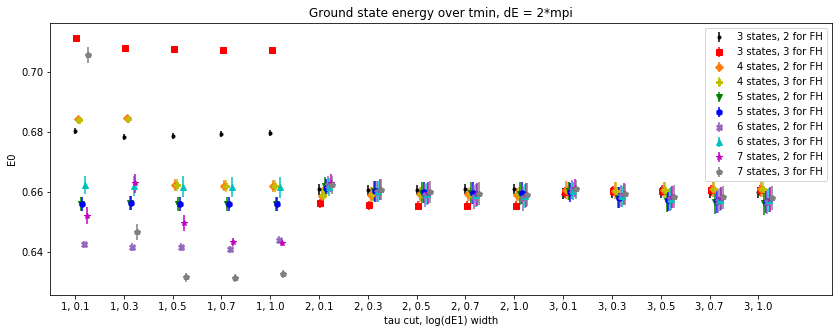

<Figure size 432x288 with 0 Axes>

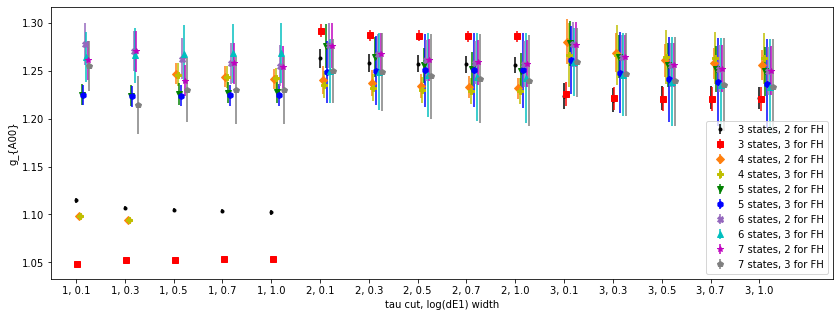

<Figure size 432x288 with 0 Axes>

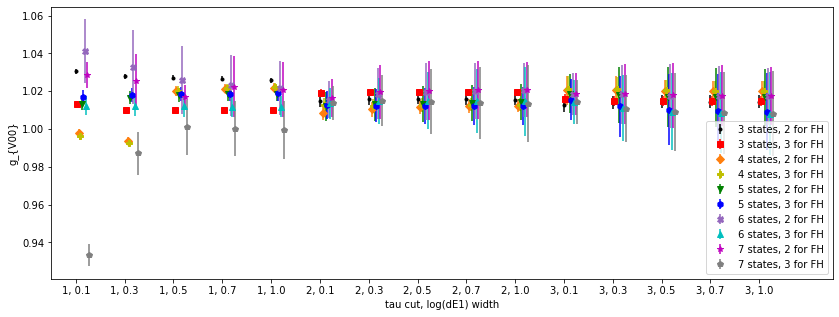

<Figure size 432x288 with 0 Axes>

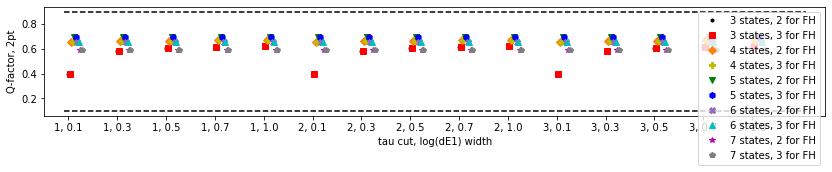

<Figure size 432x288 with 0 Axes>

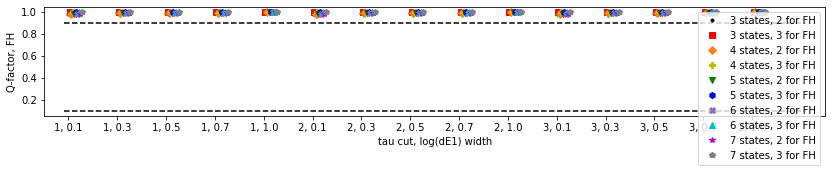

<Figure size 432x288 with 0 Axes>

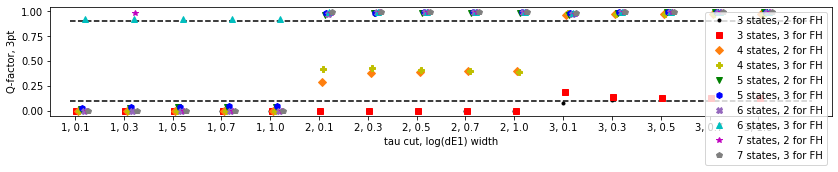

<Figure size 432x288 with 0 Axes>

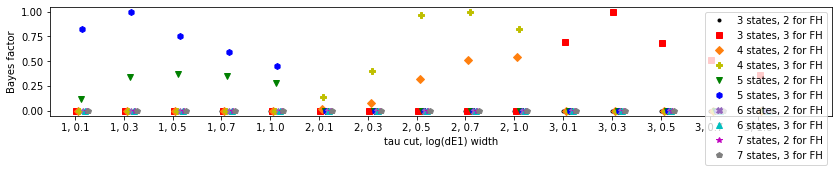

<Figure size 432x288 with 0 Axes>

In [96]:
# First, define colors, markers, and legend labels to be used for each number of states
ax_markers = np.array(['.', 's', 'D', 'P', 'v', 'h', 'X', '^', '*', 'p'])
ax_colors = np.array(['k', 'r', 'tab:orange', 'y', 'g', 'b', 'tab:purple', 'c', 'm', 'tab:grey'])
ax_labels = np.array(["3 states, 2 for FH", "3 states, 3 for FH", "4 states, 2 for FH", "4 states, 3 for FH", \
                      "5 states, 2 for FH", "5 states, 3 for FH", "6 states, 2 for FH", "6 states, 3 for FH", \
                      "7 states, 2 for FH", "7 states, 3 for FH",])






# Set an x-array to map the results to the graph
ax_ensemble_to_x_map = np.arange(0, 15, 1)
xticlocs = np.arange(0, 15, 1)
xticklabels = np.array(["1, 0.1", \
                        "1, 0.3", \
                        "1, 0.5", \
                        "1, 0.7", \
                        "1, 1.0", \
                        "2, 0.1", \
                        "2, 0.3", \
                        "2, 0.5", \
                        "2, 0.7", \
                        "2, 1.0", \
                        "3, 0.1", \
                        "3, 0.3", \
                        "3, 0.5", \
                        "3, 0.7", \
                        "3, 1.0"])



# Now create an "upper bound" and "lower bound" plot on Q
samp_line = np.linspace(-0.1,15.1,500)
Q_01_line = np.linspace(0.1,0.1,500)
Q_09_line = np.linspace(0.9,0.9,500)

# Next, create the figure
#E0
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

# Now loop over the number of states used in 3-point
for k in range(len(n_zFH_combined)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [E0_a0_graph[i][k].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [E0_a0_graph[i][k].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.title("Ground state energy over tmin, dE = 2*mpi")
plt.ylabel("E0")

plt.legend()
plt.show()

plt.clf()

# Next, create the figure
#gA00
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_zFH_combined)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [gA00_a0_graph[i][k].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [gA00_a0_graph[i][k].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.legend()
plt.ylabel("g_{A00}")
plt.show()

plt.clf()

# Next, create the figure
#gV00
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_zFH_combined)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [gV00_a0_graph[i][k].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [gV00_a0_graph[i][k].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.legend()
plt.ylabel("g_{V00}")
plt.show()

plt.clf()

# Next, create the figure
#Q-factor
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_zFH_combined)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [Q_a0_2pt_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
plt.plot(samp_line, Q_01_line, "k--")
plt.plot(samp_line, Q_09_line, "k--")
    
plt.legend(loc = 'upper right')
plt.ylabel("Q-factor, 2pt")
plt.show()

plt.clf()

#Q-factor
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_zFH_combined)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [Q_a0_FH_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
plt.plot(samp_line, Q_01_line, "k--")
plt.plot(samp_line, Q_09_line, "k--")
    
plt.legend(loc = 'upper right')
plt.ylabel("Q-factor, FH")
plt.show()

plt.clf()

#Q-factor
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_zFH_combined)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [Q_a0_3pt_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
plt.plot(samp_line, Q_01_line, "k--")
plt.plot(samp_line, Q_09_line, "k--")
    
plt.legend(loc = 'upper right')
plt.ylabel("Q-factor, 3pt")
plt.show()

plt.clf()

# Next, create the figure
#Bayes
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_zFH_combined)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [BF_a0_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
plt.legend(loc = 'upper right')
plt.ylabel("Bayes factor")
plt.show()

plt.clf()

#Bayes
#plt.figure(figsize = (14,2))
#plt.xlim([-0.5, 15.5])
#plt.xticks(ticks = xticlocs, labels=xticklabels)
#plt.xlabel("tau cut, log(dE1) width")

#for k in range(len(n_zFH_combined)):
    #plt.errorbar(ax_ensemble_to_x_map + k*0.03, [BF_a0_2pt_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
#plt.legend(loc = 'upper right')
#plt.ylabel("Bayes factor, 2pt")
#plt.show()

#plt.clf()

#Bayes
#plt.figure(figsize = (14,2))
#plt.xlim([-0.5, 15.5])
#plt.xticks(ticks = xticlocs, labels=xticklabels)
#plt.xlabel("tau cut, log(dE1) width")

#for k in range(len(n_zFH_combined)):
    #plt.errorbar(ax_ensemble_to_x_map + k*0.03, [BF_a0_FH_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
#plt.legend(loc = 'upper right')
#plt.ylabel("Bayes factor, FH")
#plt.show()

#plt.clf()

#Bayes
#plt.figure(figsize = (14,2))
#plt.xlim([-0.5, 15.5])
#plt.xticks(ticks = xticlocs, labels=xticklabels)
#plt.xlabel("tau cut, log(dE1) width")

#for k in range(len(n_zFH_combined)):
    #plt.errorbar(ax_ensemble_to_x_map + k*0.03, [BF_a0_3pt_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
#plt.legend(loc = 'upper right')
#plt.ylabel("Bayes factor, 3pt")
#plt.show()

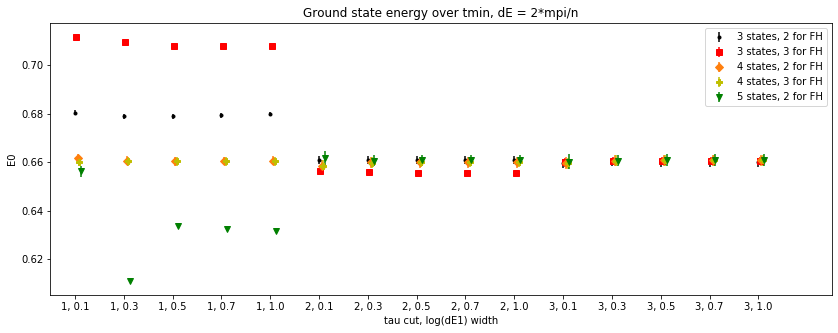

<Figure size 432x288 with 0 Axes>

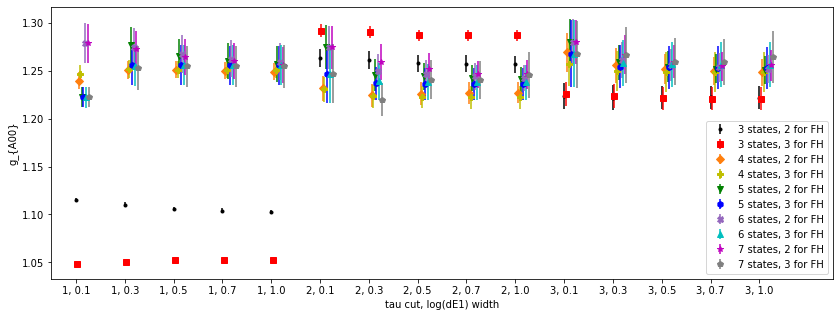

<Figure size 432x288 with 0 Axes>

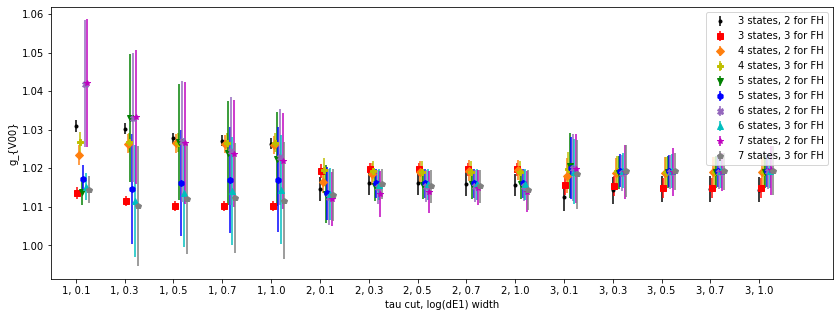

<Figure size 432x288 with 0 Axes>

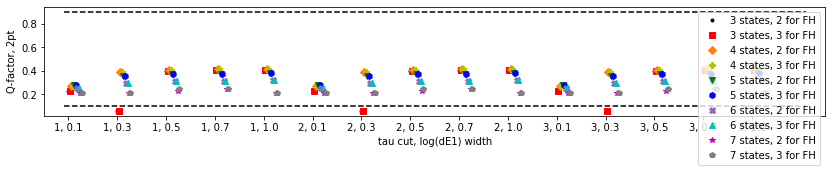

<Figure size 432x288 with 0 Axes>

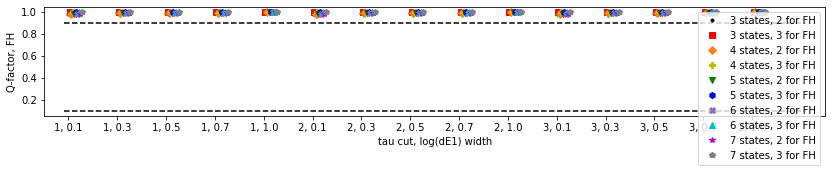

<Figure size 432x288 with 0 Axes>

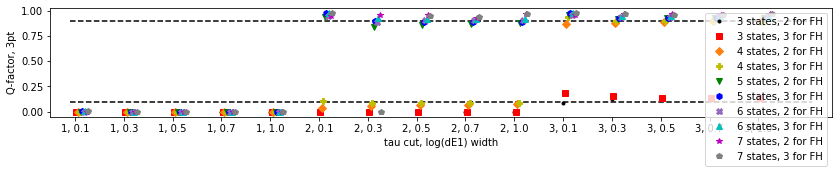

<Figure size 432x288 with 0 Axes>

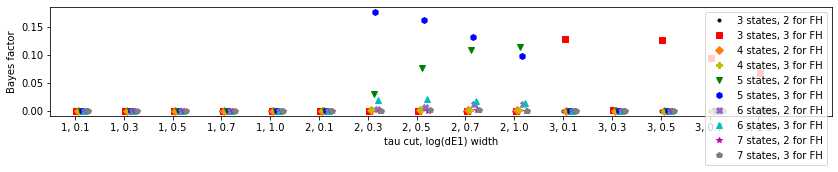

<Figure size 432x288 with 0 Axes>

In [97]:
# 1/n
# Next, create the figure
#E0
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

# Now loop over the number of states used in 3-point
for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [E0_a1_graph[i][k].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [E0_a1_graph[i][k].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.title("Ground state energy over tmin, dE = 2*mpi/n")
plt.ylabel("E0")

plt.legend()
plt.show()

plt.clf()

# Next, create the figure
#gA00
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_zFH_combined)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [gA00_a1_graph[i][k].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [gA00_a1_graph[i][k].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.legend()
plt.ylabel("g_{A00}")
plt.show()

plt.clf()

# Next, create the figure
#gV00
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_zFH_combined)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [gV00_a1_graph[i][k].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [gV00_a1_graph[i][k].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.legend()
plt.ylabel("g_{V00}")
plt.show()

plt.clf()

# Next, create the figure
#Q-factor
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_zFH_combined)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [Q_a1_2pt_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
plt.plot(samp_line, Q_01_line, "k--")
plt.plot(samp_line, Q_09_line, "k--")
    
plt.legend(loc = 'upper right')
plt.ylabel("Q-factor, 2pt")
plt.show()

plt.clf()

#Q-factor
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_zFH_combined)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [Q_a1_FH_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
plt.plot(samp_line, Q_01_line, "k--")
plt.plot(samp_line, Q_09_line, "k--")
    
plt.legend(loc = 'upper right')
plt.ylabel("Q-factor, FH")
plt.show()

plt.clf()

#Q-factor
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_zFH_combined)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [Q_a1_3pt_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
plt.plot(samp_line, Q_01_line, "k--")
plt.plot(samp_line, Q_09_line, "k--")
    
plt.legend(loc = 'upper right')
plt.ylabel("Q-factor, 3pt")
plt.show()

plt.clf()

# Next, create the figure
#Bayes
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_zFH_combined)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [BF_a1_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
plt.legend(loc = 'upper right')
plt.ylabel("Bayes factor")
plt.show()

plt.clf()

#Bayes
#plt.figure(figsize = (14,2))
#plt.xlim([-0.5, 15.5])
#plt.xticks(ticks = xticlocs, labels=xticklabels)
#plt.xlabel("tau cut, log(dE1) width")

#for k in range(len(n_zFH_combined)):
    #plt.errorbar(ax_ensemble_to_x_map + k*0.03, [BF_a1_2pt_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
#plt.legend(loc = 'upper right')
#plt.ylabel("Bayes factor, 2pt")
#plt.show()

#plt.clf()

#Bayes
#plt.figure(figsize = (14,2))
#plt.xlim([-0.5, 15.5])
#plt.xticks(ticks = xticlocs, labels=xticklabels)
#plt.xlabel("tau cut, log(dE1) width")

#for k in range(len(n_zFH_combined)):
    #plt.errorbar(ax_ensemble_to_x_map + k*0.03, [BF_a1_FH_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
#plt.legend(loc = 'upper right')
#plt.ylabel("Bayes factor, FH")
#plt.show()

#plt.clf()

#Bayes
#plt.figure(figsize = (14,2))
#plt.xlim([-0.5, 15.5])
#plt.xticks(ticks = xticlocs, labels=xticklabels)
#plt.xlabel("tau cut, log(dE1) width")

#for k in range(len(n_zFH_combined)):
    #plt.errorbar(ax_ensemble_to_x_map + k*0.03, [BF_a1_3pt_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
#plt.legend(loc = 'upper right')
#plt.ylabel("Bayes factor, 3pt")
#plt.show()

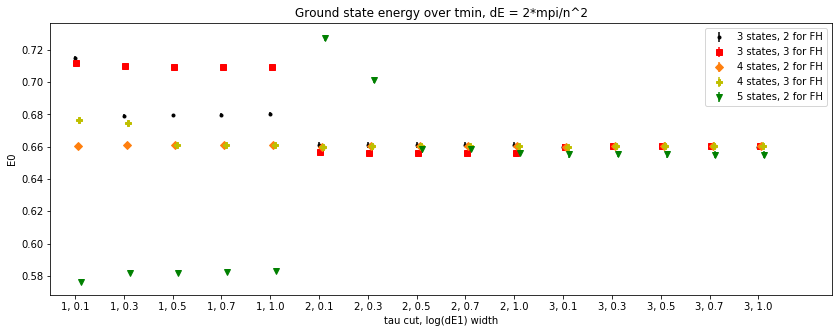

<Figure size 432x288 with 0 Axes>

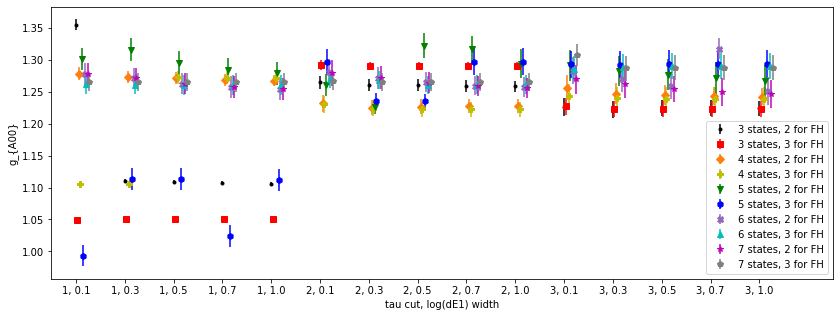

<Figure size 432x288 with 0 Axes>

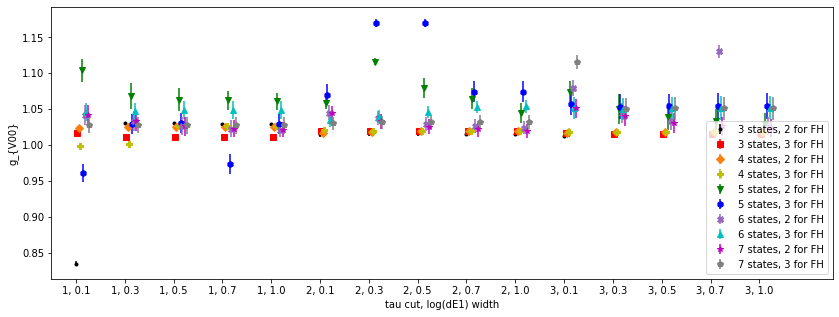

<Figure size 432x288 with 0 Axes>

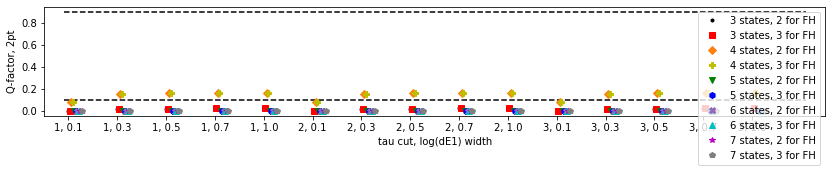

<Figure size 432x288 with 0 Axes>

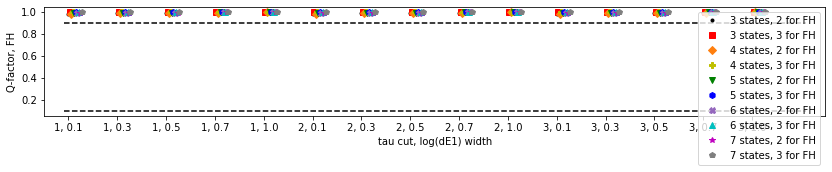

<Figure size 432x288 with 0 Axes>

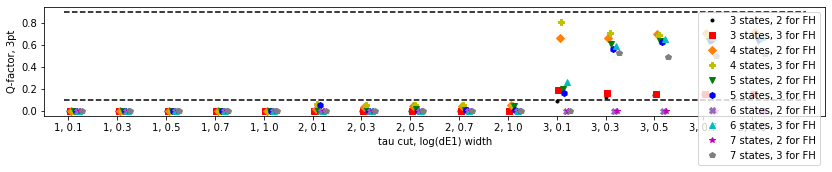

<Figure size 432x288 with 0 Axes>

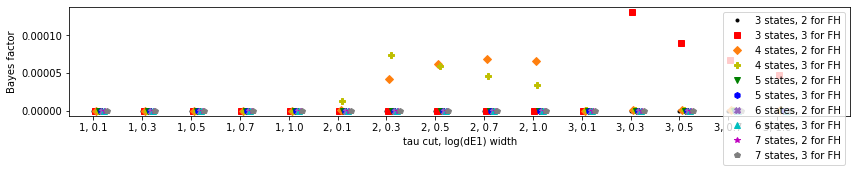

<Figure size 432x288 with 0 Axes>

In [98]:
# 1/n^2
# Next, create the figure
#E0
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

# Now loop over the number of states used in 3-point
for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [E0_a2_graph[i][k].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [E0_a2_graph[i][k].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.title("Ground state energy over tmin, dE = 2*mpi/n^2")
plt.ylabel("E0")

plt.legend()
plt.show()

plt.clf()

# Next, create the figure
#gA00
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_zFH_combined)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [gA00_a2_graph[i][k].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [gA00_a2_graph[i][k].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.legend()
plt.ylabel("g_{A00}")
plt.show()

plt.clf()

# Next, create the figure
#gV00
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_zFH_combined)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [gV00_a2_graph[i][k].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [gV00_a2_graph[i][k].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.legend()
plt.ylabel("g_{V00}")
plt.show()

plt.clf()

# Next, create the figure
#Q-factor
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_zFH_combined)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [Q_a2_2pt_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
plt.plot(samp_line, Q_01_line, "k--")
plt.plot(samp_line, Q_09_line, "k--")
    
plt.legend(loc = 'upper right')
plt.ylabel("Q-factor, 2pt")
plt.show()

plt.clf()

#Q-factor
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_zFH_combined)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [Q_a2_FH_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
plt.plot(samp_line, Q_01_line, "k--")
plt.plot(samp_line, Q_09_line, "k--")
    
plt.legend(loc = 'upper right')
plt.ylabel("Q-factor, FH")
plt.show()

plt.clf()

#Q-factor
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_zFH_combined)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [Q_a2_3pt_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
plt.plot(samp_line, Q_01_line, "k--")
plt.plot(samp_line, Q_09_line, "k--")
    
plt.legend(loc = 'upper right')
plt.ylabel("Q-factor, 3pt")
plt.show()

plt.clf()

# Next, create the figure
#Bayes
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_zFH_combined)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [BF_a2_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
plt.legend(loc = 'upper right')
plt.ylabel("Bayes factor")
plt.show()

plt.clf()

#Bayes
#plt.figure(figsize = (14,2))
#plt.xlim([-0.5, 15.5])
#plt.xticks(ticks = xticlocs, labels=xticklabels)
#plt.xlabel("tau cut, log(dE1) width")

#for k in range(len(n_zFH_combined)):
    #plt.errorbar(ax_ensemble_to_x_map + k*0.03, [BF_a2_2pt_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
#plt.legend(loc = 'upper right')
#plt.ylabel("Bayes factor, 2pt")
#plt.show()

#plt.clf()

#Bayes
#plt.figure(figsize = (14,2))
#plt.xlim([-0.5, 15.5])
#plt.xticks(ticks = xticlocs, labels=xticklabels)
#plt.xlabel("tau cut, log(dE1) width")

#for k in range(len(n_zFH_combined)):
    #plt.errorbar(ax_ensemble_to_x_map + k*0.03, [BF_a2_FH_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
#plt.legend(loc = 'upper right')
#plt.ylabel("Bayes factor, FH")
#plt.show()

#plt.clf()

#Bayes
#plt.figure(figsize = (14,2))
#plt.xlim([-0.5, 15.5])
#plt.xticks(ticks = xticlocs, labels=xticklabels)
#plt.xlabel("tau cut, log(dE1) width")

#for k in range(len(n_zFH_combined)):
    #plt.errorbar(ax_ensemble_to_x_map + k*0.03, [BF_a2_3pt_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
#plt.legend(loc = 'upper right')
#plt.ylabel("Bayes factor, 3pt")
#plt.show()